In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import datetime
from MLscripts.proj1_helpers import *
# from MLscripts.helpers import *
from MLscripts.plot import *
from MLscripts.implementations import *

# 1) Data Analysis and Cleanup
The degree of the feature expansion depends on the models that are run

In [2]:
yb_train, input_data_train, ids_train = load_csv_data('data/train.csv', sub_sample=False)
preprocessed_data_train, all_ys_train = clean_data(input_data_train, yb_train)

yb_test, input_data_test, ids_test = load_csv_data('data/test.csv', sub_sample=False)
preprocessed_data_test, _ = clean_data(input_data_test, yb_test)

preprocessed_data_train_augmented = []
preprocessed_data_test_augmented = []

for i, dataset_part in enumerate(preprocessed_data_train):
    preprocessed_data_train_augmented.append(expand_features(dataset_part, degree=4, mutual_product=True))
    
for i, dataset_part in enumerate(preprocessed_data_test):
    preprocessed_data_test_augmented.append(expand_features(dataset_part, degree=4, mutual_product=True))

Plotting the features in order to catch useful information for data preprocessing

Positive y: 34.266799999999996%
Negative y: 65.7332%


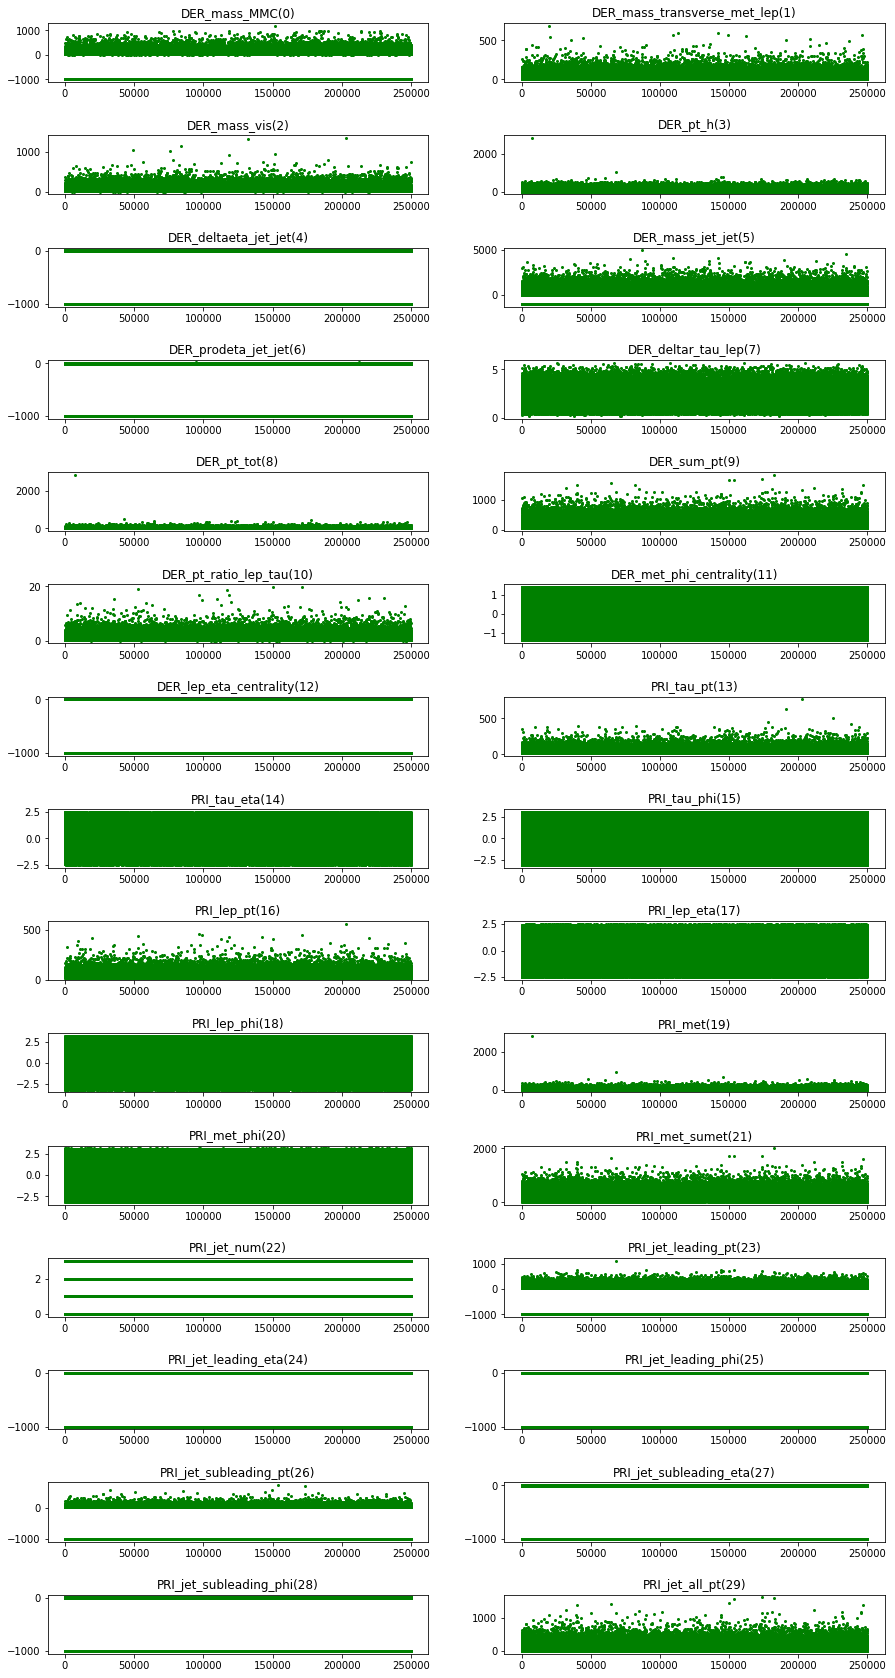

In [3]:
plot_features(yb_train, input_data_train)

Plotting the distribution of the features in order to find interesting patterns

Positive y (blue): 34.266799999999996%
Negative y (red): 65.7332%


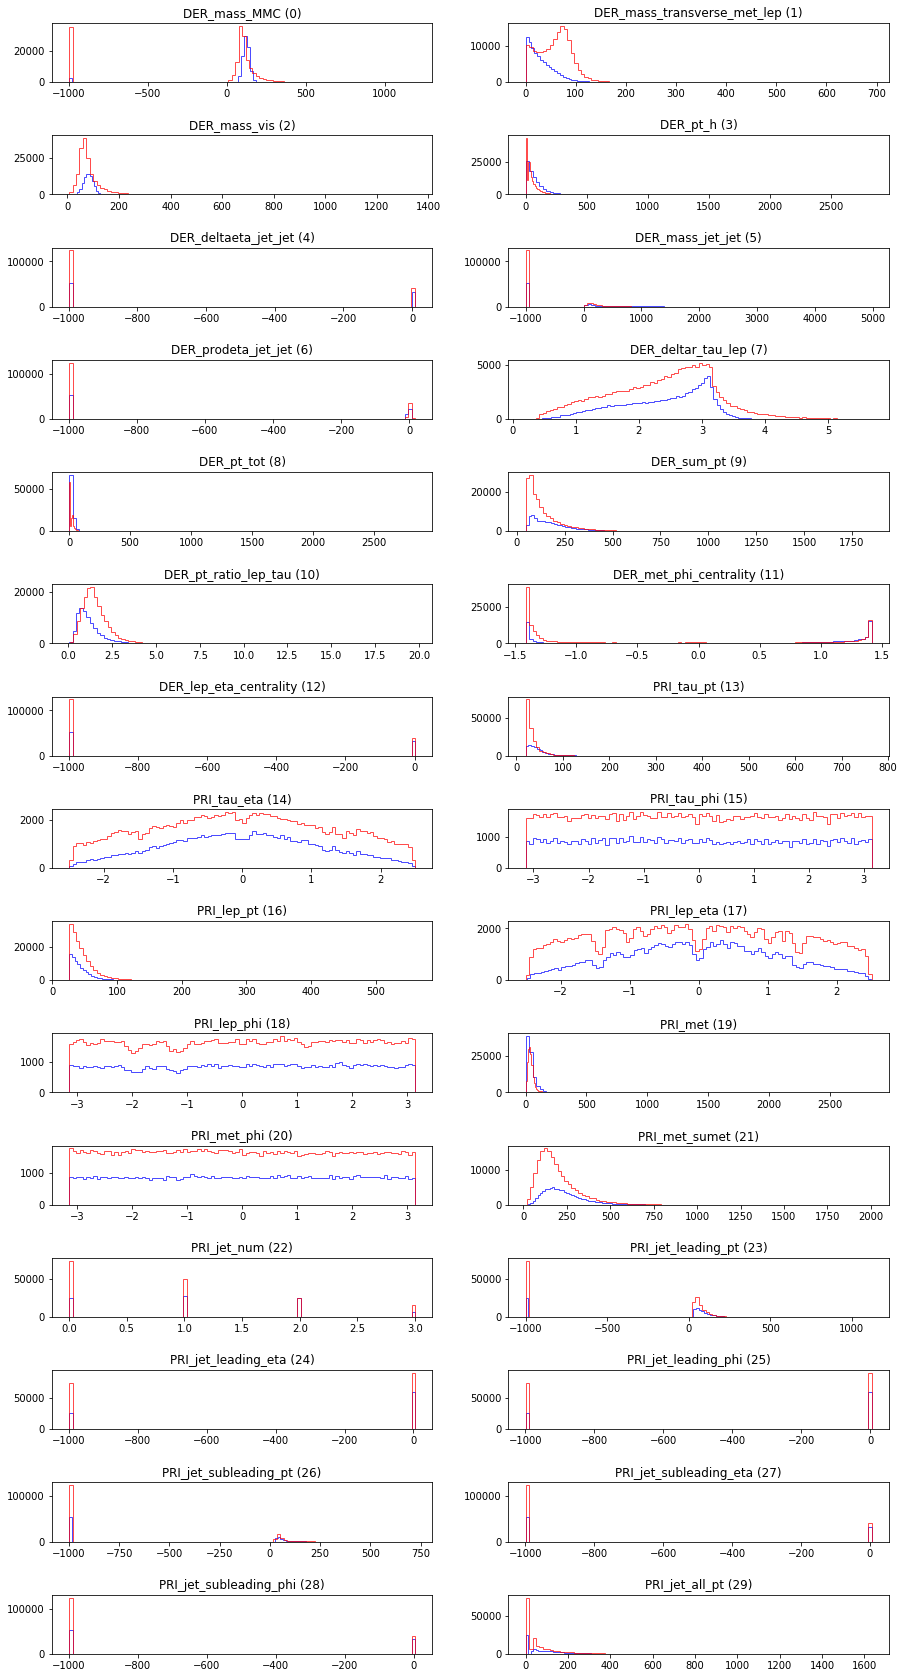

In [14]:
plot_feature_histograms(yb_train, input_data_train)

We can notice that not all features are really relevant for the output prediction. For instance there are many "-999" values. We observed that the jet_num feature is discrete and that depending on its value, there are some features that have more or less impact on the output. After determining that some features are useless (given a certain jet_num), we decided divide the dataset on the basis of this value and to drop them. We also noticed that for jet_num=0, all the values for feature 29 (jet_all_pt) are equal to 0. The following code snippet (and the report) give more details on this matter.

In [4]:
dataset0 = input_data_train[input_data_train[:, 22] == 0]
dataset1 = input_data_train[input_data_train[:, 22] == 1]
dataset2 = input_data_train[input_data_train[:, 22] == 2]
dataset3 = input_data_train[input_data_train[:, 22] == 3]

print("********** dataset 0 (size = " + str(dataset0.shape[0]) +") **********")
for col in range(dataset0.shape[1]):
    full_col = dataset0[:, col]
    missing_measure = full_col[full_col==-999]
    if missing_measure.shape[0] > 0:
        print("feature " + str(col) + ", -999 values: " + str(missing_measure.shape[0]))
# 0 (not all) 4, 5, 6, 12, 23, 24, 25, 26, 27, 28

print("********** dataset 1 (size = " + str(dataset1.shape[0]) +") **********")
for col in range(dataset1.shape[1]):
    full_col = dataset1[:, col]
    missing_measure = full_col[full_col==-999]
    if missing_measure.shape[0] > 0:
        print("feature " + str(col) + ", -999 values: " + str(missing_measure.shape[0]))
# 0 (not all) 4, 5, 6, 12, 26, 27, 28
    
print("********** dataset 2 (size = " + str(dataset2.shape[0]) +") **********")
for col in range(dataset2.shape[1]):
    full_col = dataset2[:, col]
    missing_measure = full_col[full_col==-999]
    if missing_measure.shape[0] > 0:
        print("feature " + str(col) + ", -999 values: " + str(missing_measure.shape[0]))
# 0 (not all)

print("********** dataset 3 (size = " + str(dataset3.shape[0]) +") **********")
for col in range(dataset3.shape[1]):
    full_col = dataset3[:, col]
    missing_measure = full_col[full_col==-999]
    if missing_measure.shape[0] > 0:
        print("feature " + str(col) + ", -999 values: " + str(missing_measure.shape[0]))
# 0 (not all)

********** dataset 0 (size = 99913) **********
feature 0, -999 values: 26123
feature 4, -999 values: 99913
feature 5, -999 values: 99913
feature 6, -999 values: 99913
feature 12, -999 values: 99913
feature 23, -999 values: 99913
feature 24, -999 values: 99913
feature 25, -999 values: 99913
feature 26, -999 values: 99913
feature 27, -999 values: 99913
feature 28, -999 values: 99913
********** dataset 1 (size = 77544) **********
feature 0, -999 values: 7562
feature 4, -999 values: 77544
feature 5, -999 values: 77544
feature 6, -999 values: 77544
feature 12, -999 values: 77544
feature 26, -999 values: 77544
feature 27, -999 values: 77544
feature 28, -999 values: 77544
********** dataset 2 (size = 50379) **********
feature 0, -999 values: 2952
********** dataset 3 (size = 22164) **********
feature 0, -999 values: 1477


In [27]:
def cross_validate(model, X, y, batch_size=20, n_splits=4, epochs=100, lambda_=0, initial_w=None, gamma=0.01, verbose=False, model_name='least_squares'):
        """ Run cross validation on the model and return the obtained test and train scores. """

        if initial_w == None:
                initial_w = np.random.uniform(low=-1, high=1, size=X.shape[1])
        def build_k_indices(y, k_fold, seed=12):
            """build k indices for k-fold."""
            num_row = y.shape[0]
            interval = int(num_row / k_fold)
            np.random.seed(seed)
            indices = np.random.permutation(num_row)
            te_indices = np.array([indices[k * interval: (k + 1) * interval] for k in range(k_fold)])
            tr_indices = np.array([te_indices[~(np.arange(te_indices.shape[0]) == k)].reshape(-1) for k in range(k_fold)])
            return zip(tr_indices, te_indices)
        
        kf = build_k_indices(X, n_splits)
        tr_scores = []
        va_scores = []

        result = {
            "train_score": [],
            "test_score" : []
        }

        split_n = 1
        for tr_indices, va_indices in kf:
            if verbose:
                print("----------------- fold " + str(split_n) + "/" + str(n_splits) + " -----------------")
            tr_indices = tr_indices.tolist()
            va_indices = va_indices.tolist()
            X_tr, y_tr = X[tr_indices], y[tr_indices]
            X_te, y_te = X[va_indices], y[va_indices]
            
            if model_name == 'least_squares':
                _, wi = model(y_tr, X_tr)
            elif model_name == 'ridge_regression':
                _, wi = model(y_tr, X_tr, lambda_)
            elif (model_name == 'least_squares_GD' or
                  model_name == 'least_squares_SGD' or
                  model_name == 'logistic_regression'):
                _, wi = model(y_tr, X_tr, initial_w, epochs, gamma)
            elif (model_name == 'reg_logistic_regression'):
                _, wi = model(y_tr, X_tr, initial_w, lambda_, epochs, gamma)
            result["train_score"].append(calculate_loss_SUCCESS(y_tr, X_tr, wi))
            result["test_score"].append(calculate_loss_SUCCESS(y_te, X_te, wi))            

            split_n = split_n + 1

        return result

# 2) Baselines
Trying out the baselines through cross validation

### Ridge Regression
Here the degree of the feature expansion can be higher than the other baselines (4 gives good results)

In [5]:
augmented_ridge_regression_cross_val_res = []
for i, tx in enumerate(preprocessed_data_train_augmented):
    augmented_ridge_regression_cross_val_res.append(cross_validate(ridge_regression, tx, all_ys_train[i], lambda_=1, model_name='ridge_regression'))
    
augmented_ridge_regression_cross_val_res

[{'test_score': [0.8361357995035631,
   0.8396989350628553,
   0.8418208023060293,
   0.8046280727039795],
  'train_score': [0.8400859422958871,
   0.8396855899858542,
   0.8383110470547415,
   0.801572050070729]},
 {'test_score': [0.7825234705457547,
   0.7830908903332302,
   0.7867017435262561,
   0.7849479005467863],
  'train_score': [0.7861171291997662,
   0.787372330547818,
   0.7857904329584924,
   0.7851198459369304]},
 {'test_score': [0.8073685882166111,
   0.8101476893758933,
   0.8126885818643799,
   0.8131649992059711],
  'train_score': [0.8159970356254301,
   0.8148589275316288,
   0.8130855963157059,
   0.8126091789741147]},
 {'test_score': [0.8038260241833604,
   0.8025627143114962,
   0.805630752571738,
   0.8007579859231185],
  'train_score': [0.807796426637791,
   0.8082175299284124,
   0.8067135896047645,
   0.8079167418636829]}]

### Least Squares
The augmented dataset leads to a non-invertible matrix

In [6]:
least_squares_cross_val_res = []
for i, tx in enumerate(preprocessed_data_train):
    least_squares_cross_val_res.append(cross_validate(least_squares, tx, all_ys_train[i], model_name='least_squares'))
    
least_squares_cross_val_res

[{'test_score': [0.7210745456001281,
   0.7179117623508687,
   0.7179117623508687,
   0.7192329249739771],
  'train_score': [0.7186190514319267,
   0.7184722555849147,
   0.719086129126965,
   0.7209811300611204]},
 {'test_score': [0.6733725368822862,
   0.6722376973073352,
   0.6800268234808625,
   0.682657587950067],
  'train_score': [0.6785824822036521,
   0.6789435675229547,
   0.6758829395783899,
   0.6754186870250009]},
 {'test_score': [0.728600921073527,
   0.7344767349531522,
   0.7350325551850088,
   0.7378910592345561],
  'train_score': [0.73617066327881,
   0.734132655762003,
   0.7332327563389974,
   0.7334180297496162]},
 {'test_score': [0.660530590146183,
   0.6358058112254106,
   0.6432051976177585,
   0.6424833062624075],
  'train_score': [0.6442880346507851,
   0.6495819045900258,
   0.6497623774288637,
   0.6453107140708657]}]

### Least Squares GD
The best results are obtained by not augmenting features and by using a learning rate = 0.005

cost function:  MSE
Gradient Descent: step 1 / 1000 - Loss = 1.5695963092073337
Accuracy: 0.5361251234419623
cost function:  MSE
Gradient Descent: step 2 / 1000 - Loss = 1.551635006863718
Accuracy: 0.5364320602129874
cost function:  MSE
Gradient Descent: step 3 / 1000 - Loss = 1.534047384504565
Accuracy: 0.5367256519070115
cost function:  MSE
Gradient Descent: step 4 / 1000 - Loss = 1.5168241221090621
Accuracy: 0.5372994902180586
cost function:  MSE
Gradient Descent: step 5 / 1000 - Loss = 1.4999561625792595
Accuracy: 0.5374863212960739
cost function:  MSE
Gradient Descent: step 6 / 1000 - Loss = 1.4834347036824924
Accuracy: 0.5378733285291056
cost function:  MSE
Gradient Descent: step 7 / 1000 - Loss = 1.4672511902544698
Accuracy: 0.5381669202231297
cost function:  MSE
Gradient Descent: step 8 / 1000 - Loss = 1.4513973066542332
Accuracy: 0.5384071316091494
cost function:  MSE
Gradient Descent: step 9 / 1000 - Loss = 1.4358649694626033
Accuracy: 0.5386740331491713
cost function:  MSE
G

Accuracy: 0.5643633063762777
cost function:  MSE
Gradient Descent: step 81 / 1000 - Loss = 0.8272532546708721
Accuracy: 0.5647903488403128
cost function:  MSE
Gradient Descent: step 82 / 1000 - Loss = 0.8229515453538677
Accuracy: 0.5652841166893533
cost function:  MSE
Gradient Descent: step 83 / 1000 - Loss = 0.8187141351125616
Accuracy: 0.5656177436143807
cost function:  MSE
Gradient Descent: step 84 / 1000 - Loss = 0.8145398180621541
Accuracy: 0.5661248565404222
cost function:  MSE
Gradient Descent: step 85 / 1000 - Loss = 0.8104274150361068
Accuracy: 0.5663250326954387
cost function:  MSE
Gradient Descent: step 86 / 1000 - Loss = 0.806375772908457
Accuracy: 0.5665652440814584
cost function:  MSE
Gradient Descent: step 87 / 1000 - Loss = 0.8023837639352258
Accuracy: 0.5668988710064857
cost function:  MSE
Gradient Descent: step 88 / 1000 - Loss = 0.7984502851143499
Accuracy: 0.5671657725465076
cost function:  MSE
Gradient Descent: step 89 / 1000 - Loss = 0.7945742575635693
Accuracy: 0

Accuracy: 0.5896789174473537
cost function:  MSE
Gradient Descent: step 156 / 1000 - Loss = 0.625349667316621
Accuracy: 0.5901593402193931
cost function:  MSE
Gradient Descent: step 157 / 1000 - Loss = 0.6237458583856668
Accuracy: 0.5903461712974084
cost function:  MSE
Gradient Descent: step 158 / 1000 - Loss = 0.6221602807822619
Accuracy: 0.5907865588384446
cost function:  MSE
Gradient Descent: step 159 / 1000 - Loss = 0.6205926644484553
Accuracy: 0.5910934956094697
cost function:  MSE
Gradient Descent: step 160 / 1000 - Loss = 0.6190427440817508
Accuracy: 0.5914137774574959
cost function:  MSE
Gradient Descent: step 161 / 1000 - Loss = 0.6175102590387043
Accuracy: 0.5916806789975179
cost function:  MSE
Gradient Descent: step 162 / 1000 - Loss = 0.6159949532407637
Accuracy: 0.5919075453065364
cost function:  MSE
Gradient Descent: step 163 / 1000 - Loss = 0.6144965750822571
Accuracy: 0.5920409960765474
cost function:  MSE
Gradient Descent: step 164 / 1000 - Loss = 0.613014877340505
Acc

cost function:  MSE
Gradient Descent: step 237 / 1000 - Loss = 0.5374748895503974
Accuracy: 0.6168228040675795
cost function:  MSE
Gradient Descent: step 238 / 1000 - Loss = 0.5367608991780504
Accuracy: 0.6169429097605893
cost function:  MSE
Gradient Descent: step 239 / 1000 - Loss = 0.5360530711693307
Accuracy: 0.6171163957616036
cost function:  MSE
Gradient Descent: step 240 / 1000 - Loss = 0.5353513322472576
Accuracy: 0.6173966423786266
cost function:  MSE
Gradient Descent: step 241 / 1000 - Loss = 0.5346556101992537
Accuracy: 0.6174900579176342
cost function:  MSE
Gradient Descent: step 242 / 1000 - Loss = 0.5339658338594381
Accuracy: 0.6179571356126725
cost function:  MSE
Gradient Descent: step 243 / 1000 - Loss = 0.5332819330912476
Accuracy: 0.6182106920756932
cost function:  MSE
Gradient Descent: step 244 / 1000 - Loss = 0.5326038387703825
Accuracy: 0.6187178050017349
cost function:  MSE
Gradient Descent: step 245 / 1000 - Loss = 0.5319314827680678
Accuracy: 0.6191448474657699
c

cost function:  MSE
Gradient Descent: step 313 / 1000 - Loss = 0.49672105260515653
Accuracy: 0.6355859823311181
cost function:  MSE
Gradient Descent: step 314 / 1000 - Loss = 0.49632354877699986
Accuracy: 0.6357594683321323
cost function:  MSE
Gradient Descent: step 315 / 1000 - Loss = 0.49592875092750455
Accuracy: 0.6359329543331464
cost function:  MSE
Gradient Descent: step 316 / 1000 - Loss = 0.49553663283415017
Accuracy: 0.6361865107961673
cost function:  MSE
Gradient Descent: step 317 / 1000 - Loss = 0.49514716859848595
Accuracy: 0.6364400672591881
cost function:  MSE
Gradient Descent: step 318 / 1000 - Loss = 0.4947603326414278
Accuracy: 0.6364400672591881
cost function:  MSE
Gradient Descent: step 319 / 1000 - Loss = 0.49437609969863094
Accuracy: 0.6366002081832012
cost function:  MSE
Gradient Descent: step 320 / 1000 - Loss = 0.4939944448159443
Accuracy: 0.6366535884912056
cost function:  MSE
Gradient Descent: step 321 / 1000 - Loss = 0.4936153433449319
Accuracy: 0.636813729415

cost function:  MSE
Gradient Descent: step 390 / 1000 - Loss = 0.4724737054499462
Accuracy: 0.6498919048762911
cost function:  MSE
Gradient Descent: step 391 / 1000 - Loss = 0.4722264144508178
Accuracy: 0.6500387007233032
cost function:  MSE
Gradient Descent: step 392 / 1000 - Loss = 0.4719804960018057
Accuracy: 0.650012010569301
cost function:  MSE
Gradient Descent: step 393 / 1000 - Loss = 0.4717359392271235
Accuracy: 0.6499853204152988
cost function:  MSE
Gradient Descent: step 394 / 1000 - Loss = 0.4714927333638255
Accuracy: 0.6502388768783196
cost function:  MSE
Gradient Descent: step 395 / 1000 - Loss = 0.47125086776037284
Accuracy: 0.6506926094963568
cost function:  MSE
Gradient Descent: step 396 / 1000 - Loss = 0.47101033187522506
Accuracy: 0.6508394053433688
cost function:  MSE
Gradient Descent: step 397 / 1000 - Loss = 0.4707711152754441
Accuracy: 0.650999546267382
cost function:  MSE
Gradient Descent: step 398 / 1000 - Loss = 0.4705332076353255
Accuracy: 0.6511063068833907
c

Accuracy: 0.6604745509381589
cost function:  MSE
Gradient Descent: step 468 / 1000 - Loss = 0.4566146781747177
Accuracy: 0.6604211706301545
cost function:  MSE
Gradient Descent: step 469 / 1000 - Loss = 0.4564486933456735
Accuracy: 0.6605546214001655
cost function:  MSE
Gradient Descent: step 470 / 1000 - Loss = 0.45628348649989925
Accuracy: 0.6606613820161742
cost function:  MSE
Gradient Descent: step 471 / 1000 - Loss = 0.4561190524677063
Accuracy: 0.6608215229401874
cost function:  MSE
Gradient Descent: step 472 / 1000 - Loss = 0.4559553861240889
Accuracy: 0.6609015934021939
cost function:  MSE
Gradient Descent: step 473 / 1000 - Loss = 0.455792482388241
Accuracy: 0.6609816638642005
cost function:  MSE
Gradient Descent: step 474 / 1000 - Loss = 0.4556303362230756
Accuracy: 0.6610750794032082
cost function:  MSE
Gradient Descent: step 475 / 1000 - Loss = 0.45546894263474946
Accuracy: 0.6611151146342115
cost function:  MSE
Gradient Descent: step 476 / 1000 - Loss = 0.45530829667219513

Accuracy: 0.6676141671337443
cost function:  MSE
Gradient Descent: step 544 / 1000 - Loss = 0.44590319719817545
Accuracy: 0.6676141671337443
cost function:  MSE
Gradient Descent: step 545 / 1000 - Loss = 0.44578422181214666
Accuracy: 0.6676008220567433
cost function:  MSE
Gradient Descent: step 546 / 1000 - Loss = 0.4456657313275918
Accuracy: 0.6677209277497531
cost function:  MSE
Gradient Descent: step 547 / 1000 - Loss = 0.4455477229321532
Accuracy: 0.6678009982117596
cost function:  MSE
Gradient Descent: step 548 / 1000 - Loss = 0.44543019383419813
Accuracy: 0.6677876531347586
cost function:  MSE
Gradient Descent: step 549 / 1000 - Loss = 0.4453131412626236
Accuracy: 0.6678810686737663
cost function:  MSE
Gradient Descent: step 550 / 1000 - Loss = 0.44519656246666733
Accuracy: 0.667987829289775
cost function:  MSE
Gradient Descent: step 551 / 1000 - Loss = 0.4450804547157191
Accuracy: 0.6680145194437772
cost function:  MSE
Gradient Descent: step 552 / 1000 - Loss = 0.444964815299138

Accuracy: 0.6726852963941602
cost function:  MSE
Gradient Descent: step 622 / 1000 - Loss = 0.4378913287039913
Accuracy: 0.6727520217791657
cost function:  MSE
Gradient Descent: step 623 / 1000 - Loss = 0.43780307280830094
Accuracy: 0.67280540208717
cost function:  MSE
Gradient Descent: step 624 / 1000 - Loss = 0.43771513269291523
Accuracy: 0.6729655430111832
cost function:  MSE
Gradient Descent: step 625 / 1000 - Loss = 0.4376275067184258
Accuracy: 0.6730322683961887
cost function:  MSE
Gradient Descent: step 626 / 1000 - Loss = 0.4375401932560324
Accuracy: 0.6730456134731897
cost function:  MSE
Gradient Descent: step 627 / 1000 - Loss = 0.4374531906874622
Accuracy: 0.6730456134731897
cost function:  MSE
Gradient Descent: step 628 / 1000 - Loss = 0.4373664974048851
Accuracy: 0.6730856487041931
cost function:  MSE
Gradient Descent: step 629 / 1000 - Loss = 0.43728011181083143
Accuracy: 0.6731523740891985
cost function:  MSE
Gradient Descent: step 630 / 1000 - Loss = 0.4371940323181114


Accuracy: 0.6766087490324819
cost function:  MSE
Gradient Descent: step 703 / 1000 - Loss = 0.4316415958648738
Accuracy: 0.6766487842634852
cost function:  MSE
Gradient Descent: step 704 / 1000 - Loss = 0.43157439053952196
Accuracy: 0.6767288547254917
cost function:  MSE
Gradient Descent: step 705 / 1000 - Loss = 0.4315073965790081
Accuracy: 0.6768222702644995
cost function:  MSE
Gradient Descent: step 706 / 1000 - Loss = 0.4314406129883468
Accuracy: 0.6769290308805082
cost function:  MSE
Gradient Descent: step 707 / 1000 - Loss = 0.431374038778375
Accuracy: 0.6770624816505191
cost function:  MSE
Gradient Descent: step 708 / 1000 - Loss = 0.43130767296571615
Accuracy: 0.6770624816505191
cost function:  MSE
Gradient Descent: step 709 / 1000 - Loss = 0.43124151457273485
Accuracy: 0.6771158619585235
cost function:  MSE
Gradient Descent: step 710 / 1000 - Loss = 0.43117556262750173
Accuracy: 0.6771959324205301
cost function:  MSE
Gradient Descent: step 711 / 1000 - Loss = 0.431109816163751

cost function:  MSE
Gradient Descent: step 778 / 1000 - Loss = 0.42712699223175493
Accuracy: 0.6791176235086877
cost function:  MSE
Gradient Descent: step 779 / 1000 - Loss = 0.42707322765055794
Accuracy: 0.6790775882776844
cost function:  MSE
Gradient Descent: step 780 / 1000 - Loss = 0.4270196136071202
Accuracy: 0.6790909333546855
cost function:  MSE
Gradient Descent: step 781 / 1000 - Loss = 0.4269661494505508
Accuracy: 0.679171003816692
cost function:  MSE
Gradient Descent: step 782 / 1000 - Loss = 0.4269128345335024
Accuracy: 0.6792510742786986
cost function:  MSE
Gradient Descent: step 783 / 1000 - Loss = 0.4268596682121498
Accuracy: 0.6793177996637041
cost function:  MSE
Gradient Descent: step 784 / 1000 - Loss = 0.42680664984616506
Accuracy: 0.6793711799717085
cost function:  MSE
Gradient Descent: step 785 / 1000 - Loss = 0.42675377879870124
Accuracy: 0.6794245602797128
cost function:  MSE
Gradient Descent: step 786 / 1000 - Loss = 0.42670105443636236
Accuracy: 0.67943790535671

Accuracy: 0.6811327301358528
cost function:  MSE
Gradient Descent: step 853 / 1000 - Loss = 0.4234723909155119
Accuracy: 0.6811060399818507
cost function:  MSE
Gradient Descent: step 854 / 1000 - Loss = 0.4234283251016231
Accuracy: 0.6811594202898551
cost function:  MSE
Gradient Descent: step 855 / 1000 - Loss = 0.42338436950852526
Accuracy: 0.681146075212854
cost function:  MSE
Gradient Descent: step 856 / 1000 - Loss = 0.4233405236985554
Accuracy: 0.681146075212854
cost function:  MSE
Gradient Descent: step 857 / 1000 - Loss = 0.4232967872362891
Accuracy: 0.6811327301358528
cost function:  MSE
Gradient Descent: step 858 / 1000 - Loss = 0.4232531596885274
Accuracy: 0.6810660047508474
cost function:  MSE
Gradient Descent: step 859 / 1000 - Loss = 0.42320964062428484
Accuracy: 0.6811193850588518
cost function:  MSE
Gradient Descent: step 860 / 1000 - Loss = 0.4231662296147745
Accuracy: 0.6811594202898551
cost function:  MSE
Gradient Descent: step 861 / 1000 - Loss = 0.4231229262333969
A

Accuracy: 0.6822136813729415
cost function:  MSE
Gradient Descent: step 933 / 1000 - Loss = 0.4202627126457263
Accuracy: 0.6821869912189393
cost function:  MSE
Gradient Descent: step 934 / 1000 - Loss = 0.4202262464435768
Accuracy: 0.6822136813729415
cost function:  MSE
Gradient Descent: step 935 / 1000 - Loss = 0.42018986156231486
Accuracy: 0.6822136813729415
cost function:  MSE
Gradient Descent: step 936 / 1000 - Loss = 0.4201535577079012
Accuracy: 0.6822670616809459
cost function:  MSE
Gradient Descent: step 937 / 1000 - Loss = 0.4201173345877114
Accuracy: 0.682280406757947
cost function:  MSE
Gradient Descent: step 938 / 1000 - Loss = 0.42008119191052357
Accuracy: 0.6823070969119491
cost function:  MSE
Gradient Descent: step 939 / 1000 - Loss = 0.4200451293865135
Accuracy: 0.6822670616809459
cost function:  MSE
Gradient Descent: step 940 / 1000 - Loss = 0.42000914672724504
Accuracy: 0.6822270264499426
cost function:  MSE
Gradient Descent: step 941 / 1000 - Loss = 0.4199732436456638

cost function:  MSE
Gradient Descent: step 9 / 1000 - Loss = 1.4383953957009237
Accuracy: 0.5374462860650706
cost function:  MSE
Gradient Descent: step 10 / 1000 - Loss = 1.4232452198468157
Accuracy: 0.5379533989911122
cost function:  MSE
Gradient Descent: step 11 / 1000 - Loss = 1.4083925883021333
Accuracy: 0.5385806176101636
cost function:  MSE
Gradient Descent: step 12 / 1000 - Loss = 1.3938305307052745
Accuracy: 0.5388742093041877
cost function:  MSE
Gradient Descent: step 13 / 1000 - Loss = 1.3795522615456897
Accuracy: 0.5394347025382337
cost function:  MSE
Gradient Descent: step 14 / 1000 - Loss = 1.3655511748108085
Accuracy: 0.539781674540262
cost function:  MSE
Gradient Descent: step 15 / 1000 - Loss = 1.3518208387976476
Accuracy: 0.5402754423893026
cost function:  MSE
Gradient Descent: step 16 / 1000 - Loss = 1.3383549910838028
Accuracy: 0.5408359356233485
cost function:  MSE
Gradient Descent: step 17 / 1000 - Loss = 1.3251475336527054
Accuracy: 0.5411695625483759
cost functio

cost function:  MSE
Gradient Descent: step 87 / 1000 - Loss = 0.8021691189576718
Accuracy: 0.565671123922385
cost function:  MSE
Gradient Descent: step 88 / 1000 - Loss = 0.7981949843047259
Accuracy: 0.565951370539408
cost function:  MSE
Gradient Descent: step 89 / 1000 - Loss = 0.7942789528214146
Accuracy: 0.5662983425414365
cost function:  MSE
Gradient Descent: step 90 / 1000 - Loss = 0.7904199679601273
Accuracy: 0.5666720046974671
cost function:  MSE
Gradient Descent: step 91 / 1000 - Loss = 0.7866169956268882
Accuracy: 0.567219152854512
cost function:  MSE
Gradient Descent: step 92 / 1000 - Loss = 0.7828690236390855
Accuracy: 0.5677129207035525
cost function:  MSE
Gradient Descent: step 93 / 1000 - Loss = 0.7791750611977132
Accuracy: 0.5679798222435744
cost function:  MSE
Gradient Descent: step 94 / 1000 - Loss = 0.7755341383737233
Accuracy: 0.5682734139375984
cost function:  MSE
Gradient Descent: step 95 / 1000 - Loss = 0.7719453056080766
Accuracy: 0.568633731016628
cost function:

cost function:  MSE
Gradient Descent: step 162 / 1000 - Loss = 0.614198652858421
Accuracy: 0.5914805028425014
cost function:  MSE
Gradient Descent: step 163 / 1000 - Loss = 0.612693414969151
Accuracy: 0.5916673339205167
cost function:  MSE
Gradient Descent: step 164 / 1000 - Loss = 0.6112050847857503
Accuracy: 0.5921744468465583
cost function:  MSE
Gradient Descent: step 165 / 1000 - Loss = 0.6097334148258158
Accuracy: 0.5925080737715857
cost function:  MSE
Gradient Descent: step 166 / 1000 - Loss = 0.608278161885454
Accuracy: 0.5928283556196119
cost function:  MSE
Gradient Descent: step 167 / 1000 - Loss = 0.6068390869549829
Accuracy: 0.5931753276216404
cost function:  MSE
Gradient Descent: step 168 / 1000 - Loss = 0.6054159551364957
Accuracy: 0.5934956094696666
cost function:  MSE
Gradient Descent: step 169 / 1000 - Loss = 0.6040085355632565
Accuracy: 0.5937758560866896
cost function:  MSE
Gradient Descent: step 170 / 1000 - Loss = 0.602616601320875
Accuracy: 0.5940294125497104
cost 

cost function:  MSE
Gradient Descent: step 240 / 1000 - Loss = 0.5334420440928661
Accuracy: 0.6161155149865215
cost function:  MSE
Gradient Descent: step 241 / 1000 - Loss = 0.5327479017164438
Accuracy: 0.6165025222195533
cost function:  MSE
Gradient Descent: step 242 / 1000 - Loss = 0.5320597372964784
Accuracy: 0.6167026983745696
cost function:  MSE
Gradient Descent: step 243 / 1000 - Loss = 0.5313774796515183
Accuracy: 0.6171030506846025
cost function:  MSE
Gradient Descent: step 244 / 1000 - Loss = 0.5307010586347631
Accuracy: 0.6173165719166199
cost function:  MSE
Gradient Descent: step 245 / 1000 - Loss = 0.5300304051169213
Accuracy: 0.6178770651506659
cost function:  MSE
Gradient Descent: step 246 / 1000 - Loss = 0.5293654509693728
Accuracy: 0.6182106920756932
cost function:  MSE
Gradient Descent: step 247 / 1000 - Loss = 0.5287061290476484
Accuracy: 0.6185443190007206
cost function:  MSE
Gradient Descent: step 248 / 1000 - Loss = 0.5280523731752083
Accuracy: 0.6190514319267623
c

cost function:  MSE
Gradient Descent: step 317 / 1000 - Loss = 0.4934009949126581
Accuracy: 0.6359462994101476
cost function:  MSE
Gradient Descent: step 318 / 1000 - Loss = 0.49301635791504006
Accuracy: 0.6361064403341607
cost function:  MSE
Gradient Descent: step 319 / 1000 - Loss = 0.49263431858180373
Accuracy: 0.6363066164891772
cost function:  MSE
Gradient Descent: step 320 / 1000 - Loss = 0.49225485181618855
Accuracy: 0.6366002081832012
cost function:  MSE
Gradient Descent: step 321 / 1000 - Loss = 0.491877932831883
Accuracy: 0.6366535884912056
cost function:  MSE
Gradient Descent: step 322 / 1000 - Loss = 0.4915035371485137
Accuracy: 0.6369204900312275
cost function:  MSE
Gradient Descent: step 323 / 1000 - Loss = 0.4911316405872125
Accuracy: 0.6370005604932341
cost function:  MSE
Gradient Descent: step 324 / 1000 - Loss = 0.4907622192662517
Accuracy: 0.6371206661862439
cost function:  MSE
Gradient Descent: step 325 / 1000 - Loss = 0.49039524959675207
Accuracy: 0.637480983265273

cost function:  MSE
Gradient Descent: step 398 / 1000 - Loss = 0.4689414105314303
Accuracy: 0.651426588731417
cost function:  MSE
Gradient Descent: step 399 / 1000 - Loss = 0.46870637804611404
Accuracy: 0.6516134198094323
cost function:  MSE
Gradient Descent: step 400 / 1000 - Loss = 0.46847262634943326
Accuracy: 0.6517335255024421
cost function:  MSE
Gradient Descent: step 401 / 1000 - Loss = 0.4682401454577675
Accuracy: 0.651866976272453
cost function:  MSE
Gradient Descent: step 402 / 1000 - Loss = 0.4680089254899782
Accuracy: 0.6519737368884618
cost function:  MSE
Gradient Descent: step 403 / 1000 - Loss = 0.46777895666611247
Accuracy: 0.6520804975044706
cost function:  MSE
Gradient Descent: step 404 / 1000 - Loss = 0.46755022930612733
Accuracy: 0.6522006031974804
cost function:  MSE
Gradient Descent: step 405 / 1000 - Loss = 0.46732273382862966
Accuracy: 0.6525075399685056
cost function:  MSE
Gradient Descent: step 406 / 1000 - Loss = 0.4670964607496379
Accuracy: 0.652667680892518

cost function:  MSE
Gradient Descent: step 473 / 1000 - Loss = 0.45429948365000894
Accuracy: 0.6620893052552913
cost function:  MSE
Gradient Descent: step 474 / 1000 - Loss = 0.4541384238858139
Accuracy: 0.6621560306402968
cost function:  MSE
Gradient Descent: step 475 / 1000 - Loss = 0.45397811158306073
Accuracy: 0.6623028264873089
cost function:  MSE
Gradient Descent: step 476 / 1000 - Loss = 0.4538185418266747
Accuracy: 0.662329516641311
cost function:  MSE
Gradient Descent: step 477 / 1000 - Loss = 0.45365970974375536
Accuracy: 0.662329516641311
cost function:  MSE
Gradient Descent: step 478 / 1000 - Loss = 0.4535016105031146
Accuracy: 0.6622894814103077
cost function:  MSE
Gradient Descent: step 479 / 1000 - Loss = 0.4533442393148292
Accuracy: 0.6622627912563055
cost function:  MSE
Gradient Descent: step 480 / 1000 - Loss = 0.4531875914297896
Accuracy: 0.6624496223343209
cost function:  MSE
Gradient Descent: step 481 / 1000 - Loss = 0.4530316621392615
Accuracy: 0.6625964181813329


Accuracy: 0.6690287452958603
cost function:  MSE
Gradient Descent: step 552 / 1000 - Loss = 0.44354447897915705
Accuracy: 0.6691755411428724
cost function:  MSE
Gradient Descent: step 553 / 1000 - Loss = 0.4434300849955436
Accuracy: 0.669255611604879
cost function:  MSE
Gradient Descent: step 554 / 1000 - Loss = 0.44331615117718687
Accuracy: 0.6693890623748899
cost function:  MSE
Gradient Descent: step 555 / 1000 - Loss = 0.44320267489418647
Accuracy: 0.6694557877598953
cost function:  MSE
Gradient Descent: step 556 / 1000 - Loss = 0.44308965353571755
Accuracy: 0.6694824779138976
cost function:  MSE
Gradient Descent: step 557 / 1000 - Loss = 0.4429770845098568
Accuracy: 0.6695225131449009
cost function:  MSE
Gradient Descent: step 558 / 1000 - Loss = 0.44286496524340696
Accuracy: 0.6696159286839085
cost function:  MSE
Gradient Descent: step 559 / 1000 - Loss = 0.4427532931817285
Accuracy: 0.6696559639149118
cost function:  MSE
Gradient Descent: step 560 / 1000 - Loss = 0.44264206578857

Accuracy: 0.6731790642432007
cost function:  MSE
Gradient Descent: step 630 / 1000 - Loss = 0.43582752769538297
Accuracy: 0.6731256839351963
cost function:  MSE
Gradient Descent: step 631 / 1000 - Loss = 0.4357423673840064
Accuracy: 0.673219099474204
cost function:  MSE
Gradient Descent: step 632 / 1000 - Loss = 0.43565750847596046
Accuracy: 0.6733125150132117
cost function:  MSE
Gradient Descent: step 633 / 1000 - Loss = 0.4355729494253765
Accuracy: 0.6734459657832226
cost function:  MSE
Gradient Descent: step 634 / 1000 - Loss = 0.4354886886962437
Accuracy: 0.6734860010142258
cost function:  MSE
Gradient Descent: step 635 / 1000 - Loss = 0.4354047247623309
Accuracy: 0.6735527263992314
cost function:  MSE
Gradient Descent: step 636 / 1000 - Loss = 0.43532105610710914
Accuracy: 0.673646141938239
cost function:  MSE
Gradient Descent: step 637 / 1000 - Loss = 0.4352376812236811
Accuracy: 0.6737128673232444
cost function:  MSE
Gradient Descent: step 638 / 1000 - Loss = 0.4351545986147018


Accuracy: 0.6775028691915552
cost function:  MSE
Gradient Descent: step 711 / 1000 - Loss = 0.4297888435513409
Accuracy: 0.6775695945765607
cost function:  MSE
Gradient Descent: step 712 / 1000 - Loss = 0.42972381820099703
Accuracy: 0.6776496650385673
cost function:  MSE
Gradient Descent: step 713 / 1000 - Loss = 0.42965899547370234
Accuracy: 0.6777163904235728
cost function:  MSE
Gradient Descent: step 714 / 1000 - Loss = 0.4295943744247501
Accuracy: 0.6777030453465717
cost function:  MSE
Gradient Descent: step 715 / 1000 - Loss = 0.4295299541148934
Accuracy: 0.6777430805775749
cost function:  MSE
Gradient Descent: step 716 / 1000 - Loss = 0.4294657336103085
Accuracy: 0.6777430805775749
cost function:  MSE
Gradient Descent: step 717 / 1000 - Loss = 0.42940171198255744
Accuracy: 0.6778098059625804
cost function:  MSE
Gradient Descent: step 718 / 1000 - Loss = 0.429337888308552
Accuracy: 0.6779032215015881
cost function:  MSE
Gradient Descent: step 719 / 1000 - Loss = 0.4292742616705174

cost function:  MSE
Gradient Descent: step 787 / 1000 - Loss = 0.4253643581610397
Accuracy: 0.6801451944377719
cost function:  MSE
Gradient Descent: step 788 / 1000 - Loss = 0.42531238089729984
Accuracy: 0.6801185042837697
cost function:  MSE
Gradient Descent: step 789 / 1000 - Loss = 0.4252605477464244
Accuracy: 0.6801451944377719
cost function:  MSE
Gradient Descent: step 790 / 1000 - Loss = 0.4252088580907313
Accuracy: 0.6802119198227774
cost function:  MSE
Gradient Descent: step 791 / 1000 - Loss = 0.425157311315864
Accuracy: 0.6802519550537807
cost function:  MSE
Gradient Descent: step 792 / 1000 - Loss = 0.4251059068107702
Accuracy: 0.6802653001307818
cost function:  MSE
Gradient Descent: step 793 / 1000 - Loss = 0.42505464396768167
Accuracy: 0.6802653001307818
cost function:  MSE
Gradient Descent: step 794 / 1000 - Loss = 0.4250035221820955
Accuracy: 0.6802386099767795
cost function:  MSE
Gradient Descent: step 795 / 1000 - Loss = 0.42495254085275025
Accuracy: 0.6802653001307818

cost function:  MSE
Gradient Descent: step 862 / 1000 - Loss = 0.4218279798404911
Accuracy: 0.6818133290629087
cost function:  MSE
Gradient Descent: step 863 / 1000 - Loss = 0.4217852986986996
Accuracy: 0.6817732938319054
cost function:  MSE
Gradient Descent: step 864 / 1000 - Loss = 0.4217427233352123
Accuracy: 0.6818266741399098
cost function:  MSE
Gradient Descent: step 865 / 1000 - Loss = 0.42170025333301625
Accuracy: 0.6819200896789175
cost function:  MSE
Gradient Descent: step 866 / 1000 - Loss = 0.4216578882772131
Accuracy: 0.6819734699869219
cost function:  MSE
Gradient Descent: step 867 / 1000 - Loss = 0.4216156277550059
Accuracy: 0.6820135052179251
cost function:  MSE
Gradient Descent: step 868 / 1000 - Loss = 0.4215734713556864
Accuracy: 0.6819868150639229
cost function:  MSE
Gradient Descent: step 869 / 1000 - Loss = 0.4215314186706245
Accuracy: 0.6819200896789175
cost function:  MSE
Gradient Descent: step 870 / 1000 - Loss = 0.4214894692932541
Accuracy: 0.6819200896789175


cost function:  MSE
Gradient Descent: step 940 / 1000 - Loss = 0.41878755248468136
Accuracy: 0.6833880481490379
cost function:  MSE
Gradient Descent: step 941 / 1000 - Loss = 0.41875201454354655
Accuracy: 0.6834414284570421
cost function:  MSE
Gradient Descent: step 942 / 1000 - Loss = 0.4187165553670109
Accuracy: 0.6834414284570421
cost function:  MSE
Gradient Descent: step 943 / 1000 - Loss = 0.41868117467128935
Accuracy: 0.68341473830304
cost function:  MSE
Gradient Descent: step 944 / 1000 - Loss = 0.41864587217395205
Accuracy: 0.6834280833800411
cost function:  MSE
Gradient Descent: step 945 / 1000 - Loss = 0.4186106475939177
Accuracy: 0.6834948087650465
cost function:  MSE
Gradient Descent: step 946 / 1000 - Loss = 0.4185755006514438
Accuracy: 0.6835081538420477
cost function:  MSE
Gradient Descent: step 947 / 1000 - Loss = 0.41854043106812094
Accuracy: 0.6835748792270532
cost function:  MSE
Gradient Descent: step 948 / 1000 - Loss = 0.41850543856686634
Accuracy: 0.68368163984306

cost function:  MSE
Gradient Descent: step 17 / 1000 - Loss = 1.3236255684857667
Accuracy: 0.5403421677743081
cost function:  MSE
Gradient Descent: step 18 / 1000 - Loss = 1.310633674724868
Accuracy: 0.5407825553153441
cost function:  MSE
Gradient Descent: step 19 / 1000 - Loss = 1.2978918635453753
Accuracy: 0.5412629780873836
cost function:  MSE
Gradient Descent: step 20 / 1000 - Loss = 1.2853943376570791
Accuracy: 0.5415432247044065
cost function:  MSE
Gradient Descent: step 21 / 1000 - Loss = 1.273135452945364
Accuracy: 0.5419435770144394
cost function:  MSE
Gradient Descent: step 22 / 1000 - Loss = 1.2611097140293814
Accuracy: 0.5421971334774601
cost function:  MSE
Gradient Descent: step 23 / 1000 - Loss = 1.2493117699575151
Accuracy: 0.5426508660954974
cost function:  MSE
Gradient Descent: step 24 / 1000 - Loss = 1.237736410035681
Accuracy: 0.5427042464035018
cost function:  MSE
Gradient Descent: step 25 / 1000 - Loss = 1.226378559784176
Accuracy: 0.5431846691755411
cost function:

cost function:  MSE
Gradient Descent: step 92 / 1000 - Loss = 0.7820902936605273
Accuracy: 0.5674993994715349
cost function:  MSE
Gradient Descent: step 93 / 1000 - Loss = 0.7784143987249953
Accuracy: 0.5677396108575546
cost function:  MSE
Gradient Descent: step 94 / 1000 - Loss = 0.7747913497810344
Accuracy: 0.5681266180905864
cost function:  MSE
Gradient Descent: step 95 / 1000 - Loss = 0.7712201945412467
Accuracy: 0.5687938719406411
cost function:  MSE
Gradient Descent: step 96 / 1000 - Loss = 0.7677000008741655
Accuracy: 0.5691008087116662
cost function:  MSE
Gradient Descent: step 97 / 1000 - Loss = 0.7642298563174573
Accuracy: 0.5694477807136947
cost function:  MSE
Gradient Descent: step 98 / 1000 - Loss = 0.7608088676042082
Accuracy: 0.5695678864067045
cost function:  MSE
Gradient Descent: step 99 / 1000 - Loss = 0.7574361602019112
Accuracy: 0.5701016894867483
cost function:  MSE
Gradient Descent: step 100 / 1000 - Loss = 0.7541108778637957
Accuracy: 0.5703952811807724
cost func

Accuracy: 0.5947633917847706
cost function:  MSE
Gradient Descent: step 173 / 1000 - Loss = 0.5985963483794444
Accuracy: 0.5949502228627859
cost function:  MSE
Gradient Descent: step 174 / 1000 - Loss = 0.5972682614842849
Accuracy: 0.5951770891718046
cost function:  MSE
Gradient Descent: step 175 / 1000 - Loss = 0.5959544765694808
Accuracy: 0.5956308217898417
cost function:  MSE
Gradient Descent: step 176 / 1000 - Loss = 0.5946547905091569
Accuracy: 0.5958710331758614
cost function:  MSE
Gradient Descent: step 177 / 1000 - Loss = 0.5933690036082178
Accuracy: 0.5961112445618811
cost function:  MSE
Gradient Descent: step 178 / 1000 - Loss = 0.5920969195361487
Accuracy: 0.5963914911789041
cost function:  MSE
Gradient Descent: step 179 / 1000 - Loss = 0.5908383452622631
Accuracy: 0.5966984279499292
cost function:  MSE
Gradient Descent: step 180 / 1000 - Loss = 0.5895930909923582
Accuracy: 0.5970453999519577
cost function:  MSE
Gradient Descent: step 181 / 1000 - Loss = 0.5883609701067418
A

cost function:  MSE
Gradient Descent: step 247 / 1000 - Loss = 0.5288769254477989
Accuracy: 0.6180905863826834
cost function:  MSE
Gradient Descent: step 248 / 1000 - Loss = 0.528222851633748
Accuracy: 0.6184375583847119
cost function:  MSE
Gradient Descent: step 249 / 1000 - Loss = 0.5275742526809215
Accuracy: 0.6187044599247338
cost function:  MSE
Gradient Descent: step 250 / 1000 - Loss = 0.526931064895373
Accuracy: 0.618864600848747
cost function:  MSE
Gradient Descent: step 251 / 1000 - Loss = 0.526293225494684
Accuracy: 0.6192649531587797
cost function:  MSE
Gradient Descent: step 252 / 1000 - Loss = 0.525660672593012
Accuracy: 0.6195718899298049
cost function:  MSE
Gradient Descent: step 253 / 1000 - Loss = 0.5250333451864293
Accuracy: 0.6197854111618224
cost function:  MSE
Gradient Descent: step 254 / 1000 - Loss = 0.5244111831385141
Accuracy: 0.6199322070088344
cost function:  MSE
Gradient Descent: step 255 / 1000 - Loss = 0.5237941271662107
Accuracy: 0.6203325593188672
cost f

Gradient Descent: step 323 / 1000 - Loss = 0.49123590190190436
Accuracy: 0.6370939760322417
cost function:  MSE
Gradient Descent: step 324 / 1000 - Loss = 0.4908653532368458
Accuracy: 0.6372941521872582
cost function:  MSE
Gradient Descent: step 325 / 1000 - Loss = 0.49049725563055735
Accuracy: 0.6374542931112712
cost function:  MSE
Gradient Descent: step 326 / 1000 - Loss = 0.49013158593138306
Accuracy: 0.6377745749592976
cost function:  MSE
Gradient Descent: step 327 / 1000 - Loss = 0.4897683212690358
Accuracy: 0.6377879200362986
cost function:  MSE
Gradient Descent: step 328 / 1000 - Loss = 0.4894074390505509
Accuracy: 0.6380815117303227
cost function:  MSE
Gradient Descent: step 329 / 1000 - Loss = 0.4890489169563141
Accuracy: 0.6382950329623402
cost function:  MSE
Gradient Descent: step 330 / 1000 - Loss = 0.4886927329361484
Accuracy: 0.6386019697333654
cost function:  MSE
Gradient Descent: step 331 / 1000 - Loss = 0.4883388652054625
Accuracy: 0.6387754557343795
cost function:  MS

Accuracy: 0.6512664478074038
cost function:  MSE
Gradient Descent: step 399 / 1000 - Loss = 0.4687305213914672
Accuracy: 0.6512931379614061
cost function:  MSE
Gradient Descent: step 400 / 1000 - Loss = 0.46849585527663185
Accuracy: 0.651439933808418
cost function:  MSE
Gradient Descent: step 401 / 1000 - Loss = 0.4682624645639977
Accuracy: 0.6516801451944377
cost function:  MSE
Gradient Descent: step 402 / 1000 - Loss = 0.4680303393873178
Accuracy: 0.6518002508874476
cost function:  MSE
Gradient Descent: step 403 / 1000 - Loss = 0.4677994699807211
Accuracy: 0.6520671524274695
cost function:  MSE
Gradient Descent: step 404 / 1000 - Loss = 0.46756984667744933
Accuracy: 0.6523207088904903
cost function:  MSE
Gradient Descent: step 405 / 1000 - Loss = 0.46734145990861864
Accuracy: 0.652574265353511
cost function:  MSE
Gradient Descent: step 406 / 1000 - Loss = 0.4671143002019918
Accuracy: 0.652574265353511
cost function:  MSE
Gradient Descent: step 407 / 1000 - Loss = 0.4668883581807745
A

Accuracy: 0.6615288120212454
cost function:  MSE
Gradient Descent: step 474 / 1000 - Loss = 0.45410699397714976
Accuracy: 0.6616355726372541
cost function:  MSE
Gradient Descent: step 475 / 1000 - Loss = 0.45394611428136045
Accuracy: 0.6616889529452585
cost function:  MSE
Gradient Descent: step 476 / 1000 - Loss = 0.453785981419087
Accuracy: 0.6618490938692716
cost function:  MSE
Gradient Descent: step 477 / 1000 - Loss = 0.45362659050234255
Accuracy: 0.6618891291002749
cost function:  MSE
Gradient Descent: step 478 / 1000 - Loss = 0.45346793668473523
Accuracy: 0.6621159954092936
cost function:  MSE
Gradient Descent: step 479 / 1000 - Loss = 0.4533100151610152
Accuracy: 0.662182720794299
cost function:  MSE
Gradient Descent: step 480 / 1000 - Loss = 0.4531528211666364
Accuracy: 0.6622894814103077
cost function:  MSE
Gradient Descent: step 481 / 1000 - Loss = 0.4529963499773162
Accuracy: 0.6625430378733286
cost function:  MSE
Gradient Descent: step 482 / 1000 - Loss = 0.4528405969086083

cost function:  MSE
Gradient Descent: step 554 / 1000 - Loss = 0.44325152874356594
Accuracy: 0.6687351536018363
cost function:  MSE
Gradient Descent: step 555 / 1000 - Loss = 0.44313777561453577
Accuracy: 0.6687618437558385
cost function:  MSE
Gradient Descent: step 556 / 1000 - Loss = 0.44302448036003816
Accuracy: 0.6687885339098406
cost function:  MSE
Gradient Descent: step 557 / 1000 - Loss = 0.4429116403720253
Accuracy: 0.6688686043718473
cost function:  MSE
Gradient Descent: step 558 / 1000 - Loss = 0.4427992530612271
Accuracy: 0.6688552592948461
cost function:  MSE
Gradient Descent: step 559 / 1000 - Loss = 0.4426873158569824
Accuracy: 0.6689353297568527
cost function:  MSE
Gradient Descent: step 560 / 1000 - Loss = 0.44257582620707037
Accuracy: 0.6690554354498626
cost function:  MSE
Gradient Descent: step 561 / 1000 - Loss = 0.44246478157754643
Accuracy: 0.6691488509888702
cost function:  MSE
Gradient Descent: step 562 / 1000 - Loss = 0.4423541794525738
Accuracy: 0.6691755411428

Accuracy: 0.6737529025542477
cost function:  MSE
Gradient Descent: step 628 / 1000 - Loss = 0.435920637570087
Accuracy: 0.6736061067072358
cost function:  MSE
Gradient Descent: step 629 / 1000 - Loss = 0.4358347714181097
Accuracy: 0.6736995222462434
cost function:  MSE
Gradient Descent: step 630 / 1000 - Loss = 0.43574921170771463
Accuracy: 0.6737128673232444
cost function:  MSE
Gradient Descent: step 631 / 1000 - Loss = 0.43566395686148357
Accuracy: 0.6737395574772467
cost function:  MSE
Gradient Descent: step 632 / 1000 - Loss = 0.4355790053120729
Accuracy: 0.6738463180932553
cost function:  MSE
Gradient Descent: step 633 / 1000 - Loss = 0.43549435550213494
Accuracy: 0.6738329730162543
cost function:  MSE
Gradient Descent: step 634 / 1000 - Loss = 0.43541000588424084
Accuracy: 0.673926388555262
cost function:  MSE
Gradient Descent: step 635 / 1000 - Loss = 0.4353259549208044
Accuracy: 0.6739931139402674
cost function:  MSE
Gradient Descent: step 636 / 1000 - Loss = 0.4352422010840042

cost function:  MSE
Gradient Descent: step 704 / 1000 - Loss = 0.4301689020205932
Accuracy: 0.6770891718045213
cost function:  MSE
Gradient Descent: step 705 / 1000 - Loss = 0.43010244977187434
Accuracy: 0.6771425521125257
cost function:  MSE
Gradient Descent: step 706 / 1000 - Loss = 0.4300362081139743
Accuracy: 0.6772760028825366
cost function:  MSE
Gradient Descent: step 707 / 1000 - Loss = 0.42997017605544385
Accuracy: 0.6772760028825366
cost function:  MSE
Gradient Descent: step 708 / 1000 - Loss = 0.42990435261060866
Accuracy: 0.6773827634985454
cost function:  MSE
Gradient Descent: step 709 / 1000 - Loss = 0.4298387367995281
Accuracy: 0.6775028691915552
cost function:  MSE
Gradient Descent: step 710 / 1000 - Loss = 0.42977332764795884
Accuracy: 0.6775829396535618
cost function:  MSE
Gradient Descent: step 711 / 1000 - Loss = 0.42970812418731297
Accuracy: 0.6775829396535618
cost function:  MSE
Gradient Descent: step 712 / 1000 - Loss = 0.4296431254546201
Accuracy: 0.6777030453465

cost function:  MSE
Gradient Descent: step 779 / 1000 - Loss = 0.42570881928088167
Accuracy: 0.6796647716657325
cost function:  MSE
Gradient Descent: step 780 / 1000 - Loss = 0.42565575683982954
Accuracy: 0.6796914618197347
cost function:  MSE
Gradient Descent: step 781 / 1000 - Loss = 0.4256028443246589
Accuracy: 0.6797448421277391
cost function:  MSE
Gradient Descent: step 782 / 1000 - Loss = 0.425550081085617
Accuracy: 0.6797715322817413
cost function:  MSE
Gradient Descent: step 783 / 1000 - Loss = 0.4254974664764749
Accuracy: 0.6798516027437478
cost function:  MSE
Gradient Descent: step 784 / 1000 - Loss = 0.4254449998545077
Accuracy: 0.6799183281287533
cost function:  MSE
Gradient Descent: step 785 / 1000 - Loss = 0.4253926805804719
Accuracy: 0.6799049830517522
cost function:  MSE
Gradient Descent: step 786 / 1000 - Loss = 0.4253405080185837
Accuracy: 0.6799983985907598
cost function:  MSE
Gradient Descent: step 787 / 1000 - Loss = 0.42528848153649534
Accuracy: 0.6800517788987642

cost function:  MSE
Gradient Descent: step 853 / 1000 - Loss = 0.42214875605979435
Accuracy: 0.6816665332158967
cost function:  MSE
Gradient Descent: step 854 / 1000 - Loss = 0.4221052385627119
Accuracy: 0.6817332586009022
cost function:  MSE
Gradient Descent: step 855 / 1000 - Loss = 0.4220618311618877
Accuracy: 0.6817599487549043
cost function:  MSE
Gradient Descent: step 856 / 1000 - Loss = 0.42201853341769263
Accuracy: 0.6817466036779032
cost function:  MSE
Gradient Descent: step 857 / 1000 - Loss = 0.4219753448927435
Accuracy: 0.6817466036779032
cost function:  MSE
Gradient Descent: step 858 / 1000 - Loss = 0.42193226515188975
Accuracy: 0.6817732938319054
cost function:  MSE
Gradient Descent: step 859 / 1000 - Loss = 0.4218892937622019
Accuracy: 0.6817599487549043
cost function:  MSE
Gradient Descent: step 860 / 1000 - Loss = 0.4218464302929563
Accuracy: 0.6817466036779032
cost function:  MSE
Gradient Descent: step 861 / 1000 - Loss = 0.42180367431562227
Accuracy: 0.68181332906290

Accuracy: 0.6827608295299864
cost function:  MSE
Gradient Descent: step 928 / 1000 - Loss = 0.41916329337424174
Accuracy: 0.6828142098379908
cost function:  MSE
Gradient Descent: step 929 / 1000 - Loss = 0.41912695012589013
Accuracy: 0.6827741746069875
cost function:  MSE
Gradient Descent: step 930 / 1000 - Loss = 0.41909068943857075
Accuracy: 0.6827207942989831
cost function:  MSE
Gradient Descent: step 931 / 1000 - Loss = 0.419054511009649
Accuracy: 0.6827474844529853
cost function:  MSE
Gradient Descent: step 932 / 1000 - Loss = 0.4190184145379506
Accuracy: 0.6827741746069875
cost function:  MSE
Gradient Descent: step 933 / 1000 - Loss = 0.41898239972375345
Accuracy: 0.6828142098379908
cost function:  MSE
Gradient Descent: step 934 / 1000 - Loss = 0.4189464662687787
Accuracy: 0.6827875196839885
cost function:  MSE
Gradient Descent: step 935 / 1000 - Loss = 0.4189106138761817
Accuracy: 0.6828542450689941
cost function:  MSE
Gradient Descent: step 936 / 1000 - Loss = 0.418874842250546

cost function:  MSE
Gradient Descent: step 9 / 1000 - Loss = 1.4324866836030075
Accuracy: 0.53792670883711
cost function:  MSE
Gradient Descent: step 10 / 1000 - Loss = 1.4175557857672343
Accuracy: 0.5379800891451144
cost function:  MSE
Gradient Descent: step 11 / 1000 - Loss = 1.4029164439105477
Accuracy: 0.5383670963781461
cost function:  MSE
Gradient Descent: step 12 / 1000 - Loss = 1.3885617689284675
Accuracy: 0.5389542797661943
cost function:  MSE
Gradient Descent: step 13 / 1000 - Loss = 1.3744850591484423
Accuracy: 0.5393679771532282
cost function:  MSE
Gradient Descent: step 14 / 1000 - Loss = 1.360679794691272
Accuracy: 0.5395948434622467
cost function:  MSE
Gradient Descent: step 15 / 1000 - Loss = 1.3471396320136162
Accuracy: 0.5398750900792697
cost function:  MSE
Gradient Descent: step 16 / 1000 - Loss = 1.3338583986255221
Accuracy: 0.5404489283903168
cost function:  MSE
Gradient Descent: step 17 / 1000 - Loss = 1.320830087977173
Accuracy: 0.540902661008354
cost function:  

cost function:  MSE
Gradient Descent: step 89 / 1000 - Loss = 0.7940760844966485
Accuracy: 0.5665652440814584
cost function:  MSE
Gradient Descent: step 90 / 1000 - Loss = 0.7902124577897388
Accuracy: 0.5668988710064857
cost function:  MSE
Gradient Descent: step 91 / 1000 - Loss = 0.7864042557292537
Accuracy: 0.5672058077775108
cost function:  MSE
Gradient Descent: step 92 / 1000 - Loss = 0.7826504915561476
Accuracy: 0.5675527797795393
cost function:  MSE
Gradient Descent: step 93 / 1000 - Loss = 0.7789501991196341
Accuracy: 0.5679130968585688
cost function:  MSE
Gradient Descent: step 94 / 1000 - Loss = 0.7753024323812925
Accuracy: 0.5683001040916006
cost function:  MSE
Gradient Descent: step 95 / 1000 - Loss = 0.771706264932684
Accuracy: 0.568927322710652
cost function:  MSE
Gradient Descent: step 96 / 1000 - Loss = 0.7681607895260488
Accuracy: 0.5692342594816772
cost function:  MSE
Gradient Descent: step 97 / 1000 - Loss = 0.7646651176177193
Accuracy: 0.5694744708676969
cost functio

cost function:  MSE
Gradient Descent: step 166 / 1000 - Loss = 0.6071031874184027
Accuracy: 0.593121947313636
cost function:  MSE
Gradient Descent: step 167 / 1000 - Loss = 0.6056512319372661
Accuracy: 0.5935890250086743
cost function:  MSE
Gradient Descent: step 168 / 1000 - Loss = 0.6042152997120439
Accuracy: 0.5939493420877039
cost function:  MSE
Gradient Descent: step 169 / 1000 - Loss = 0.6027951604884162
Accuracy: 0.5944297648597432
cost function:  MSE
Gradient Descent: step 170 / 1000 - Loss = 0.6013905879022023
Accuracy: 0.5946699762457629
cost function:  MSE
Gradient Descent: step 171 / 1000 - Loss = 0.6000013594050086
Accuracy: 0.5950302933247925
cost function:  MSE
Gradient Descent: step 172 / 1000 - Loss = 0.5986272561914736
Accuracy: 0.5952304694798088
cost function:  MSE
Gradient Descent: step 173 / 1000 - Loss = 0.597268063128084
Accuracy: 0.5956842020978461
cost function:  MSE
Gradient Descent: step 174 / 1000 - Loss = 0.5959235686835164
Accuracy: 0.5959911388688712
cos

cost function:  MSE
Gradient Descent: step 241 / 1000 - Loss = 0.530828010674005
Accuracy: 0.6189313262337524
cost function:  MSE
Gradient Descent: step 242 / 1000 - Loss = 0.5301326329086813
Accuracy: 0.6193984039287906
cost function:  MSE
Gradient Descent: step 243 / 1000 - Loss = 0.5294432227508494
Accuracy: 0.6195451997758027
cost function:  MSE
Gradient Descent: step 244 / 1000 - Loss = 0.5287597096704245
Accuracy: 0.619732030853818
cost function:  MSE
Gradient Descent: step 245 / 1000 - Loss = 0.5280820241595312
Accuracy: 0.6199855873168388
cost function:  MSE
Gradient Descent: step 246 / 1000 - Loss = 0.5274100977157028
Accuracy: 0.6202257987028585
cost function:  MSE
Gradient Descent: step 247 / 1000 - Loss = 0.5267438628253804
Accuracy: 0.6206795313208957
cost function:  MSE
Gradient Descent: step 248 / 1000 - Loss = 0.5260832529477145
Accuracy: 0.6210932287079296
cost function:  MSE
Gradient Descent: step 249 / 1000 - Loss = 0.5254282024986582
Accuracy: 0.621426855632957
cost

cost function:  MSE
Gradient Descent: step 318 / 1000 - Loss = 0.4906970209552876
Accuracy: 0.6380014412683161
cost function:  MSE
Gradient Descent: step 319 / 1000 - Loss = 0.49031164346630585
Accuracy: 0.6382549977313369
cost function:  MSE
Gradient Descent: step 320 / 1000 - Loss = 0.48992888140067203
Accuracy: 0.6385752795793632
cost function:  MSE
Gradient Descent: step 321 / 1000 - Loss = 0.48954870983715254
Accuracy: 0.6387754557343795
cost function:  MSE
Gradient Descent: step 322 / 1000 - Loss = 0.48917110416150394
Accuracy: 0.6390156671203993
cost function:  MSE
Gradient Descent: step 323 / 1000 - Loss = 0.48879604006198923
Accuracy: 0.6392692235834201
cost function:  MSE
Gradient Descent: step 324 / 1000 - Loss = 0.48842349352497644
Accuracy: 0.6394960898924387
cost function:  MSE
Gradient Descent: step 325 / 1000 - Loss = 0.4880534408306004
Accuracy: 0.6397629914324605
cost function:  MSE
Gradient Descent: step 326 / 1000 - Loss = 0.48768585854849683
Accuracy: 0.63994982251

cost function:  MSE
Gradient Descent: step 394 / 1000 - Loss = 0.4674348841881931
Accuracy: 0.6530146528945472
cost function:  MSE
Gradient Descent: step 395 / 1000 - Loss = 0.467194193400306
Accuracy: 0.6531614487415592
cost function:  MSE
Gradient Descent: step 396 / 1000 - Loss = 0.4669548579079026
Accuracy: 0.6533482798195746
cost function:  MSE
Gradient Descent: step 397 / 1000 - Loss = 0.46671686717715705
Accuracy: 0.6535084207435877
cost function:  MSE
Gradient Descent: step 398 / 1000 - Loss = 0.4664802107818139
Accuracy: 0.6536819067446019
cost function:  MSE
Gradient Descent: step 399 / 1000 - Loss = 0.4662448784018145
Accuracy: 0.6538820828996184
cost function:  MSE
Gradient Descent: step 400 / 1000 - Loss = 0.4660108598219445
Accuracy: 0.6540288787466304
cost function:  MSE
Gradient Descent: step 401 / 1000 - Loss = 0.46577814493050335
Accuracy: 0.6541356393626391
cost function:  MSE
Gradient Descent: step 402 / 1000 - Loss = 0.46554672371798705
Accuracy: 0.6541623295166413

cost function:  MSE
Gradient Descent: step 473 / 1000 - Loss = 0.45189846587516347
Accuracy: 0.6636640243414205
cost function:  MSE
Gradient Descent: step 474 / 1000 - Loss = 0.4517392120740861
Accuracy: 0.663744094803427
cost function:  MSE
Gradient Descent: step 475 / 1000 - Loss = 0.4515807286293235
Accuracy: 0.6638508554194358
cost function:  MSE
Gradient Descent: step 476 / 1000 - Loss = 0.45142301048905825
Accuracy: 0.6639976512664478
cost function:  MSE
Gradient Descent: step 477 / 1000 - Loss = 0.45126605264375136
Accuracy: 0.664010996343449
cost function:  MSE
Gradient Descent: step 478 / 1000 - Loss = 0.45110985012568244
Accuracy: 0.6640910668054555
cost function:  MSE
Gradient Descent: step 479 / 1000 - Loss = 0.45095439800851117
Accuracy: 0.6641311020364588
cost function:  MSE
Gradient Descent: step 480 / 1000 - Loss = 0.45079969140682935
Accuracy: 0.6641844823444631
cost function:  MSE
Gradient Descent: step 481 / 1000 - Loss = 0.4506457254757274
Accuracy: 0.66427789788347

cost function:  MSE
Gradient Descent: step 551 / 1000 - Loss = 0.44145778729699436
Accuracy: 0.6704566685349774
cost function:  MSE
Gradient Descent: step 552 / 1000 - Loss = 0.4413461265040276
Accuracy: 0.6704700136119786
cost function:  MSE
Gradient Descent: step 553 / 1000 - Loss = 0.4412349414251674
Accuracy: 0.670523393919983
cost function:  MSE
Gradient Descent: step 554 / 1000 - Loss = 0.4411242292958519
Accuracy: 0.6706168094589906
cost function:  MSE
Gradient Descent: step 555 / 1000 - Loss = 0.4410139873711668
Accuracy: 0.6706568446899939
cost function:  MSE
Gradient Descent: step 556 / 1000 - Loss = 0.4409042129256717
Accuracy: 0.670683534843996
cost function:  MSE
Gradient Descent: step 557 / 1000 - Loss = 0.4407949032532259
Accuracy: 0.6707769503830037
cost function:  MSE
Gradient Descent: step 558 / 1000 - Loss = 0.4406860556668193
Accuracy: 0.6707902954600048
cost function:  MSE
Gradient Descent: step 559 / 1000 - Loss = 0.440577667498405
Accuracy: 0.6708303306910081
cos

cost function:  MSE
Gradient Descent: step 627 / 1000 - Loss = 0.43415536471402
Accuracy: 0.6748071636373342
cost function:  MSE
Gradient Descent: step 628 / 1000 - Loss = 0.4340731677385628
Accuracy: 0.6748738890223397
cost function:  MSE
Gradient Descent: step 629 / 1000 - Loss = 0.43399128219924327
Accuracy: 0.6749272693303441
cost function:  MSE
Gradient Descent: step 630 / 1000 - Loss = 0.43390970643735316
Accuracy: 0.6749939947153495
cost function:  MSE
Gradient Descent: step 631 / 1000 - Loss = 0.433828438804706
Accuracy: 0.675074065177356
cost function:  MSE
Gradient Descent: step 632 / 1000 - Loss = 0.4337474776635599
Accuracy: 0.6751407905623615
cost function:  MSE
Gradient Descent: step 633 / 1000 - Loss = 0.43366682138653634
Accuracy: 0.6752208610243681
cost function:  MSE
Gradient Descent: step 634 / 1000 - Loss = 0.4335864683565419
Accuracy: 0.6752342061013692
cost function:  MSE
Gradient Descent: step 635 / 1000 - Loss = 0.4335064169666938
Accuracy: 0.6752208610243681
co

Accuracy: 0.67817012304161
cost function:  MSE
Gradient Descent: step 703 / 1000 - Loss = 0.4286915578748415
Accuracy: 0.6781567779646088
cost function:  MSE
Gradient Descent: step 704 / 1000 - Loss = 0.4286289525790578
Accuracy: 0.6781834681186111
cost function:  MSE
Gradient Descent: step 705 / 1000 - Loss = 0.4285665578773163
Accuracy: 0.6781834681186111
cost function:  MSE
Gradient Descent: step 706 / 1000 - Loss = 0.4285043727272179
Accuracy: 0.6782768836576187
cost function:  MSE
Gradient Descent: step 707 / 1000 - Loss = 0.42844239609248475
Accuracy: 0.6782501935036165
cost function:  MSE
Gradient Descent: step 708 / 1000 - Loss = 0.4283806269429178
Accuracy: 0.6783436090426241
cost function:  MSE
Gradient Descent: step 709 / 1000 - Loss = 0.42831906425435884
Accuracy: 0.6783569541196253
cost function:  MSE
Gradient Descent: step 710 / 1000 - Loss = 0.4282577070086485
Accuracy: 0.678463714735634
cost function:  MSE
Gradient Descent: step 711 / 1000 - Loss = 0.42819655419358554
A

cost function:  MSE
Gradient Descent: step 777 / 1000 - Loss = 0.4245664450425868
Accuracy: 0.6808391384418289
cost function:  MSE
Gradient Descent: step 778 / 1000 - Loss = 0.42451696247205783
Accuracy: 0.6808524835188299
cost function:  MSE
Gradient Descent: step 779 / 1000 - Loss = 0.42446762756033557
Accuracy: 0.6809058638268343
cost function:  MSE
Gradient Descent: step 780 / 1000 - Loss = 0.4244184396251172
Accuracy: 0.680865828595831
cost function:  MSE
Gradient Descent: step 781 / 1000 - Loss = 0.42436939798789375
Accuracy: 0.6809325539808365
cost function:  MSE
Gradient Descent: step 782 / 1000 - Loss = 0.42432050197392657
Accuracy: 0.680865828595831
cost function:  MSE
Gradient Descent: step 783 / 1000 - Loss = 0.4242717509122261
Accuracy: 0.6809058638268343
cost function:  MSE
Gradient Descent: step 784 / 1000 - Loss = 0.4242231441355259
Accuracy: 0.6809325539808365
cost function:  MSE
Gradient Descent: step 785 / 1000 - Loss = 0.42417468098026084
Accuracy: 0.681079349827848

cost function:  MSE
Gradient Descent: step 857 / 1000 - Loss = 0.4210238640942661
Accuracy: 0.68341473830304
cost function:  MSE
Gradient Descent: step 858 / 1000 - Loss = 0.42098431626523397
Accuracy: 0.6834547735340433
cost function:  MSE
Gradient Descent: step 859 / 1000 - Loss = 0.4209448717988888
Accuracy: 0.6834547735340433
cost function:  MSE
Gradient Descent: step 860 / 1000 - Loss = 0.42090553025378075
Accuracy: 0.6834013932260389
cost function:  MSE
Gradient Descent: step 861 / 1000 - Loss = 0.42086629119079877
Accuracy: 0.68341473830304
cost function:  MSE
Gradient Descent: step 862 / 1000 - Loss = 0.4208271541731575
Accuracy: 0.6834280833800411
cost function:  MSE
Gradient Descent: step 863 / 1000 - Loss = 0.42078811876638217
Accuracy: 0.6834280833800411
cost function:  MSE
Gradient Descent: step 864 / 1000 - Loss = 0.4207491845382958
Accuracy: 0.6834547735340433
cost function:  MSE
Gradient Descent: step 865 / 1000 - Loss = 0.4207103510590071
Accuracy: 0.6834948087650465
c

Accuracy: 0.6845624149251341
cost function:  MSE
Gradient Descent: step 937 / 1000 - Loss = 0.4181537879217747
Accuracy: 0.6845624149251341
cost function:  MSE
Gradient Descent: step 938 / 1000 - Loss = 0.4181212865109965
Accuracy: 0.6845891050791363
cost function:  MSE
Gradient Descent: step 939 / 1000 - Loss = 0.41808885953498454
Accuracy: 0.6845891050791363
cost function:  MSE
Gradient Descent: step 940 / 1000 - Loss = 0.41805650670235095
Accuracy: 0.6846157952331385
cost function:  MSE
Gradient Descent: step 941 / 1000 - Loss = 0.4180242277231825
Accuracy: 0.6846958656951451
cost function:  MSE
Gradient Descent: step 942 / 1000 - Loss = 0.41799202230903015
Accuracy: 0.6846825206181439
cost function:  MSE
Gradient Descent: step 943 / 1000 - Loss = 0.4179598901729031
Accuracy: 0.6846291403101396
cost function:  MSE
Gradient Descent: step 944 / 1000 - Loss = 0.41792783102925996
Accuracy: 0.6846291403101396
cost function:  MSE
Gradient Descent: step 945 / 1000 - Loss = 0.41789584459399

Accuracy: 0.4594380824650091
cost function:  MSE
Gradient Descent: step 14 / 1000 - Loss = 2.180522969252844
Accuracy: 0.46024622579868635
cost function:  MSE
Gradient Descent: step 15 / 1000 - Loss = 2.1531042127348967
Accuracy: 0.4607276728910898
cost function:  MSE
Gradient Descent: step 16 / 1000 - Loss = 2.1265660342588735
Accuracy: 0.46174215069293995
cost function:  MSE
Gradient Descent: step 17 / 1000 - Loss = 2.1008676574202587
Accuracy: 0.4626190721826748
cost function:  MSE
Gradient Descent: step 18 / 1000 - Loss = 2.0759704262950636
Accuracy: 0.46358196636748167
cost function:  MSE
Gradient Descent: step 19 / 1000 - Loss = 2.051837691645972
Accuracy: 0.46480277863750474
cost function:  MSE
Gradient Descent: step 20 / 1000 - Loss = 2.028434703288638
Accuracy: 0.46578286736132607
cost function:  MSE
Gradient Descent: step 21 / 1000 - Loss = 2.005728508283754
Accuracy: 0.46719281956050757
cost function:  MSE
Gradient Descent: step 22 / 1000 - Loss = 1.9836878546387045
Accuracy

Accuracy: 0.5133945458922247
cost function:  MSE
Gradient Descent: step 93 / 1000 - Loss = 1.1953849301249857
Accuracy: 0.5136524639774408
cost function:  MSE
Gradient Descent: step 94 / 1000 - Loss = 1.1893362591362204
Accuracy: 0.5140995219918154
cost function:  MSE
Gradient Descent: step 95 / 1000 - Loss = 1.1833576010088918
Accuracy: 0.5145981636232333
cost function:  MSE
Gradient Descent: step 96 / 1000 - Loss = 1.177447730241486
Accuracy: 0.5150796107156367
cost function:  MSE
Gradient Descent: step 97 / 1000 - Loss = 1.1716054570928143
Accuracy: 0.5155782523470546
cost function:  MSE
Gradient Descent: step 98 / 1000 - Loss = 1.1658296260503886
Accuracy: 0.5159565322053715
cost function:  MSE
Gradient Descent: step 99 / 1000 - Loss = 1.1601191143759644
Accuracy: 0.5161800612125589
cost function:  MSE
Gradient Descent: step 100 / 1000 - Loss = 1.1544728307241405
Accuracy: 0.5167646755390488
cost function:  MSE
Gradient Descent: step 101 / 1000 - Loss = 1.1488897138302117
Accuracy:

Gradient Descent: step 171 / 1000 - Loss = 0.871886887037358
Accuracy: 0.543846074486743
cost function:  MSE
Gradient Descent: step 172 / 1000 - Loss = 0.8691203567463869
Accuracy: 0.5441899652670312
cost function:  MSE
Gradient Descent: step 173 / 1000 - Loss = 0.8663784359569681
Accuracy: 0.5444306888132329
cost function:  MSE
Gradient Descent: step 174 / 1000 - Loss = 0.8636608473211937
Accuracy: 0.5447401905154923
cost function:  MSE
Gradient Descent: step 175 / 1000 - Loss = 0.8609673172049246
Accuracy: 0.5451184703738092
cost function:  MSE
Gradient Descent: step 176 / 1000 - Loss = 0.858297575623989
Accuracy: 0.5455311393101551
cost function:  MSE
Gradient Descent: step 177 / 1000 - Loss = 0.8556513561820656
Accuracy: 0.5456686956222704
cost function:  MSE
Gradient Descent: step 178 / 1000 - Loss = 0.8530283960101093
Accuracy: 0.5460125864025586
cost function:  MSE
Gradient Descent: step 179 / 1000 - Loss = 0.8504284357073193
Accuracy: 0.5464768389559476
cost function:  MSE
Grad

cost function:  MSE
Gradient Descent: step 249 / 1000 - Loss = 0.7131563775454451
Accuracy: 0.5673853983974689
cost function:  MSE
Gradient Descent: step 250 / 1000 - Loss = 0.7116919238576849
Accuracy: 0.5675745383266274
cost function:  MSE
Gradient Descent: step 251 / 1000 - Loss = 0.710238254871064
Accuracy: 0.567763678255786
cost function:  MSE
Gradient Descent: step 252 / 1000 - Loss = 0.7087952644876584
Accuracy: 0.5681075690360742
cost function:  MSE
Gradient Descent: step 253 / 1000 - Loss = 0.7073628478306886
Accuracy: 0.568141958114103
cost function:  MSE
Gradient Descent: step 254 / 1000 - Loss = 0.7059409012290391
Accuracy: 0.568606210667492
cost function:  MSE
Gradient Descent: step 255 / 1000 - Loss = 0.7045293222020039
Accuracy: 0.5688297396746793
cost function:  MSE
Gradient Descent: step 256 / 1000 - Loss = 0.7031280094442381
Accuracy: 0.5688641287527081
cost function:  MSE
Gradient Descent: step 257 / 1000 - Loss = 0.7017368628109171
Accuracy: 0.5693283813060972
cost 

cost function:  MSE
Gradient Descent: step 327 / 1000 - Loss = 0.6247068085001832
Accuracy: 0.5861962240792324
cost function:  MSE
Gradient Descent: step 328 / 1000 - Loss = 0.6238395942032587
Accuracy: 0.5863337803913478
cost function:  MSE
Gradient Descent: step 329 / 1000 - Loss = 0.6229776277309025
Accuracy: 0.5865745039375494
cost function:  MSE
Gradient Descent: step 330 / 1000 - Loss = 0.6221208643566806
Accuracy: 0.5867120602496647
cost function:  MSE
Gradient Descent: step 331 / 1000 - Loss = 0.6212692598241606
Accuracy: 0.5869871728738952
cost function:  MSE
Gradient Descent: step 332 / 1000 - Loss = 0.6204227703413996
Accuracy: 0.5871247291860106
cost function:  MSE
Gradient Descent: step 333 / 1000 - Loss = 0.6195813525754973
Accuracy: 0.5873482581931978
cost function:  MSE
Gradient Descent: step 334 / 1000 - Loss = 0.6187449636472167
Accuracy: 0.5875889817393996
cost function:  MSE
Gradient Descent: step 335 / 1000 - Loss = 0.6179135611256777
Accuracy: 0.587984456136731
co

cost function:  MSE
Gradient Descent: step 405 / 1000 - Loss = 0.5699903245917566
Accuracy: 0.6021699508236185
cost function:  MSE
Gradient Descent: step 406 / 1000 - Loss = 0.5694272719825374
Accuracy: 0.6023762852917913
cost function:  MSE
Gradient Descent: step 407 / 1000 - Loss = 0.5688670526208914
Accuracy: 0.6025138416039066
cost function:  MSE
Gradient Descent: step 408 / 1000 - Loss = 0.5683096460651675
Accuracy: 0.6026857869940507
cost function:  MSE
Gradient Descent: step 409 / 1000 - Loss = 0.5677550320665468
Accuracy: 0.603201623164483
cost function:  MSE
Gradient Descent: step 410 / 1000 - Loss = 0.5672031905669329
Accuracy: 0.6034251521716703
cost function:  MSE
Gradient Descent: step 411 / 1000 - Loss = 0.5666541016968631
Accuracy: 0.6036830702568864
cost function:  MSE
Gradient Descent: step 412 / 1000 - Loss = 0.5661077457734408
Accuracy: 0.604044155576189
cost function:  MSE
Gradient Descent: step 413 / 1000 - Loss = 0.5655641032982973
Accuracy: 0.6040785446542178
cos

cost function:  MSE
Gradient Descent: step 480 / 1000 - Loss = 0.5344457115975314
Accuracy: 0.6156160803328863
cost function:  MSE
Gradient Descent: step 481 / 1000 - Loss = 0.5340492563514004
Accuracy: 0.6159427765741601
cost function:  MSE
Gradient Descent: step 482 / 1000 - Loss = 0.5336545194394111
Accuracy: 0.6161319165033186
cost function:  MSE
Gradient Descent: step 483 / 1000 - Loss = 0.5332614903916684
Accuracy: 0.6164070291275491
cost function:  MSE
Gradient Descent: step 484 / 1000 - Loss = 0.5328701588252182
Accuracy: 0.6166477526737508
cost function:  MSE
Gradient Descent: step 485 / 1000 - Loss = 0.5324805144431671
Accuracy: 0.6168368926029093
cost function:  MSE
Gradient Descent: step 486 / 1000 - Loss = 0.5320925470338079
Accuracy: 0.6169744489150246
cost function:  MSE
Gradient Descent: step 487 / 1000 - Loss = 0.5317062464697633
Accuracy: 0.6171979779222119
cost function:  MSE
Gradient Descent: step 488 / 1000 - Loss = 0.5313216027071291
Accuracy: 0.6173011451562984
c

Accuracy: 0.626328278138863
cost function:  MSE
Gradient Descent: step 557 / 1000 - Loss = 0.5082829744229387
Accuracy: 0.626448639911964
cost function:  MSE
Gradient Descent: step 558 / 1000 - Loss = 0.5079935346488436
Accuracy: 0.6265690016850648
cost function:  MSE
Gradient Descent: step 559 / 1000 - Loss = 0.5077052083709258
Accuracy: 0.6265690016850648
cost function:  MSE
Gradient Descent: step 560 / 1000 - Loss = 0.5074179898269247
Accuracy: 0.6265690016850648
cost function:  MSE
Gradient Descent: step 561 / 1000 - Loss = 0.5071318732957382
Accuracy: 0.6266549743801368
cost function:  MSE
Gradient Descent: step 562 / 1000 - Loss = 0.5068468530970394
Accuracy: 0.6267925306922522
cost function:  MSE
Gradient Descent: step 563 / 1000 - Loss = 0.5065629235909116
Accuracy: 0.6270332542384539
cost function:  MSE
Gradient Descent: step 564 / 1000 - Loss = 0.506280079177471
Accuracy: 0.6270504487774683
cost function:  MSE
Gradient Descent: step 565 / 1000 - Loss = 0.5059983142965082
Accu

Accuracy: 0.6366965851645517
cost function:  MSE
Gradient Descent: step 637 / 1000 - Loss = 0.4882301112568884
Accuracy: 0.6369373087107535
cost function:  MSE
Gradient Descent: step 638 / 1000 - Loss = 0.48801441142380086
Accuracy: 0.6370060868668111
cost function:  MSE
Gradient Descent: step 639 / 1000 - Loss = 0.48779946854975814
Accuracy: 0.6371780322569552
cost function:  MSE
Gradient Descent: step 640 / 1000 - Loss = 0.4875852792409694
Accuracy: 0.6373499776470993
cost function:  MSE
Gradient Descent: step 641 / 1000 - Loss = 0.4873718401242348
Accuracy: 0.6374187558031569
cost function:  MSE
Gradient Descent: step 642 / 1000 - Loss = 0.487159147846777
Accuracy: 0.6376250902713299
cost function:  MSE
Gradient Descent: step 643 / 1000 - Loss = 0.4869471990760798
Accuracy: 0.6376250902713299
cost function:  MSE
Gradient Descent: step 644 / 1000 - Loss = 0.4867359904997207
Accuracy: 0.6377110629664019
cost function:  MSE
Gradient Descent: step 645 / 1000 - Loss = 0.4865255188252166


Accuracy: 0.6457237181471165
cost function:  MSE
Gradient Descent: step 716 / 1000 - Loss = 0.473281239213497
Accuracy: 0.6458440799202173
cost function:  MSE
Gradient Descent: step 717 / 1000 - Loss = 0.47311629399886157
Accuracy: 0.6458956635372606
cost function:  MSE
Gradient Descent: step 718 / 1000 - Loss = 0.4729518900404477
Accuracy: 0.645912858076275
cost function:  MSE
Gradient Descent: step 719 / 1000 - Loss = 0.47278802516561347
Accuracy: 0.645998830771347
cost function:  MSE
Gradient Descent: step 720 / 1000 - Loss = 0.47262469721306055
Accuracy: 0.6460160253103614
cost function:  MSE
Gradient Descent: step 721 / 1000 - Loss = 0.4724619040327524
Accuracy: 0.646084803466419
cost function:  MSE
Gradient Descent: step 722 / 1000 - Loss = 0.47229964348583664
Accuracy: 0.6461019980054334
cost function:  MSE
Gradient Descent: step 723 / 1000 - Loss = 0.4721379134445685
Accuracy: 0.6463599160906496
cost function:  MSE
Gradient Descent: step 724 / 1000 - Loss = 0.4719767117922296
A

cost function:  MSE
Gradient Descent: step 793 / 1000 - Loss = 0.46201917900264583
Accuracy: 0.6520856975824478
cost function:  MSE
Gradient Descent: step 794 / 1000 - Loss = 0.4618902881642906
Accuracy: 0.652051308504419
cost function:  MSE
Gradient Descent: step 795 / 1000 - Loss = 0.4617617995047084
Accuracy: 0.6522060593555487
cost function:  MSE
Gradient Descent: step 796 / 1000 - Loss = 0.4616337115357404
Accuracy: 0.6522748375116063
cost function:  MSE
Gradient Descent: step 797 / 1000 - Loss = 0.4615060227760888
Accuracy: 0.6523951992847071
cost function:  MSE
Gradient Descent: step 798 / 1000 - Loss = 0.4613787317512706
Accuracy: 0.6524123938237216
cost function:  MSE
Gradient Descent: step 799 / 1000 - Loss = 0.46125183699358097
Accuracy: 0.6524983665187937
cost function:  MSE
Gradient Descent: step 800 / 1000 - Loss = 0.4611253370420507
Accuracy: 0.6524639774407648
cost function:  MSE
Gradient Descent: step 801 / 1000 - Loss = 0.4609992304424051
Accuracy: 0.6525671446748512


Accuracy: 0.6570549193576121
cost function:  MSE
Gradient Descent: step 869 / 1000 - Loss = 0.45327316543632
Accuracy: 0.6570721138966265
cost function:  MSE
Gradient Descent: step 870 / 1000 - Loss = 0.4531710332780785
Accuracy: 0.6571924756697273
cost function:  MSE
Gradient Descent: step 871 / 1000 - Loss = 0.4530692071960324
Accuracy: 0.6571580865916985
cost function:  MSE
Gradient Descent: step 872 / 1000 - Loss = 0.4529676861244783
Accuracy: 0.6573644210598714
cost function:  MSE
Gradient Descent: step 873 / 1000 - Loss = 0.4528664690021646
Accuracy: 0.6573644210598714
cost function:  MSE
Gradient Descent: step 874 / 1000 - Loss = 0.4527655547722686
Accuracy: 0.6574847828329723
cost function:  MSE
Gradient Descent: step 875 / 1000 - Loss = 0.4526649423823721
Accuracy: 0.6575535609890298
cost function:  MSE
Gradient Descent: step 876 / 1000 - Loss = 0.45256463078443676
Accuracy: 0.6575879500670587
cost function:  MSE
Gradient Descent: step 877 / 1000 - Loss = 0.4524646189347852
Ac

Accuracy: 0.6618350012036177
cost function:  MSE
Gradient Descent: step 948 / 1000 - Loss = 0.44606966851396196
Accuracy: 0.661972557515733
cost function:  MSE
Gradient Descent: step 949 / 1000 - Loss = 0.44598875278708816
Accuracy: 0.661972557515733
cost function:  MSE
Gradient Descent: step 950 / 1000 - Loss = 0.4459080710092591
Accuracy: 0.6620241411327762
cost function:  MSE
Gradient Descent: step 951 / 1000 - Loss = 0.4458276224046997
Accuracy: 0.6620585302108051
cost function:  MSE
Gradient Descent: step 952 / 1000 - Loss = 0.44574740620062886
Accuracy: 0.6620929192888338
cost function:  MSE
Gradient Descent: step 953 / 1000 - Loss = 0.44566742162724504
Accuracy: 0.6621445029058771
cost function:  MSE
Gradient Descent: step 954 / 1000 - Loss = 0.445587667917713
Accuracy: 0.6621273083668627
cost function:  MSE
Gradient Descent: step 955 / 1000 - Loss = 0.4455081443081485
Accuracy: 0.6621960865229203
cost function:  MSE
Gradient Descent: step 956 / 1000 - Loss = 0.44542885003760874

Accuracy: 0.47266068296708963
cost function:  MSE
Gradient Descent: step 24 / 1000 - Loss = 1.9339106940310693
Accuracy: 0.47322810275456517
cost function:  MSE
Gradient Descent: step 25 / 1000 - Loss = 1.9137190441956624
Accuracy: 0.4740706351662712
cost function:  MSE
Gradient Descent: step 26 / 1000 - Loss = 1.8940758039349714
Accuracy: 0.47486158396093403
cost function:  MSE
Gradient Descent: step 27 / 1000 - Loss = 1.8749578412622314
Accuracy: 0.47568692183362565
cost function:  MSE
Gradient Descent: step 28 / 1000 - Loss = 1.8563431717041792
Accuracy: 0.47658103786237493
cost function:  MSE
Gradient Descent: step 29 / 1000 - Loss = 1.8382108986598695
Accuracy: 0.4773204030399945
cost function:  MSE
Gradient Descent: step 30 / 1000 - Loss = 1.8205411568997953
Accuracy: 0.4783348808418446
cost function:  MSE
Gradient Descent: step 31 / 1000 - Loss = 1.8033150590393072
Accuracy: 0.479400942260738
cost function:  MSE
Gradient Descent: step 32 / 1000 - Loss = 1.7865146448291738
Accura

Accuracy: 0.519085938305994
cost function:  MSE
Gradient Descent: step 102 / 1000 - Loss = 1.136224271734367
Accuracy: 0.5193266618521958
cost function:  MSE
Gradient Descent: step 103 / 1000 - Loss = 1.130794796946195
Accuracy: 0.5200488324908009
cost function:  MSE
Gradient Descent: step 104 / 1000 - Loss = 1.1254256661458684
Accuracy: 0.5204271123491179
cost function:  MSE
Gradient Descent: step 105 / 1000 - Loss = 1.1201159109943402
Accuracy: 0.520771003129406
cost function:  MSE
Gradient Descent: step 106 / 1000 - Loss = 1.1148645881775876
Accuracy: 0.5212868392998383
cost function:  MSE
Gradient Descent: step 107 / 1000 - Loss = 1.1096707784248212
Accuracy: 0.521733897314213
cost function:  MSE
Gradient Descent: step 108 / 1000 - Loss = 1.1045335855737868
Accuracy: 0.5220090099384436
cost function:  MSE
Gradient Descent: step 109 / 1000 - Loss = 1.0994521356807514
Accuracy: 0.5222669280236597
cost function:  MSE
Gradient Descent: step 110 / 1000 - Loss = 1.0944255761728872
Accura

Gradient Descent: step 178 / 1000 - Loss = 0.8481609958537734
Accuracy: 0.5486261563327487
cost function:  MSE
Gradient Descent: step 179 / 1000 - Loss = 0.8455869889420934
Accuracy: 0.5489012689569792
cost function:  MSE
Gradient Descent: step 180 / 1000 - Loss = 0.8430355937176857
Accuracy: 0.5489184634959937
cost function:  MSE
Gradient Descent: step 181 / 1000 - Loss = 0.8405065577155993
Accuracy: 0.549141992503181
cost function:  MSE
Gradient Descent: step 182 / 1000 - Loss = 0.8379996317932603
Accuracy: 0.5494171051274115
cost function:  MSE
Gradient Descent: step 183 / 1000 - Loss = 0.8355145700757637
Accuracy: 0.5497953849857286
cost function:  MSE
Gradient Descent: step 184 / 1000 - Loss = 0.8330511299024801
Accuracy: 0.5500189139929158
cost function:  MSE
Gradient Descent: step 185 / 1000 - Loss = 0.8306090717749349
Accuracy: 0.5501392757660167
cost function:  MSE
Gradient Descent: step 186 / 1000 - Loss = 0.8281881593059032
Accuracy: 0.550569139241377
cost function:  MSE
Gra

cost function:  MSE
Gradient Descent: step 259 / 1000 - Loss = 0.6958249172118952
Accuracy: 0.5712885587537399
cost function:  MSE
Gradient Descent: step 260 / 1000 - Loss = 0.6944803145409224
Accuracy: 0.5715120877609271
cost function:  MSE
Gradient Descent: step 261 / 1000 - Loss = 0.6931453946200887
Accuracy: 0.5717528113071288
cost function:  MSE
Gradient Descent: step 262 / 1000 - Loss = 0.6918200633966227
Accuracy: 0.5720279239313594
cost function:  MSE
Gradient Descent: step 263 / 1000 - Loss = 0.6905042278919238
Accuracy: 0.5724921764847485
cost function:  MSE
Gradient Descent: step 264 / 1000 - Loss = 0.689197796188081
Accuracy: 0.5727329000309501
cost function:  MSE
Gradient Descent: step 265 / 1000 - Loss = 0.6879006774145747
Accuracy: 0.5729392344991231
cost function:  MSE
Gradient Descent: step 266 / 1000 - Loss = 0.6866127817351675
Accuracy: 0.5731971525843392
cost function:  MSE
Gradient Descent: step 267 / 1000 - Loss = 0.6853340203349614
Accuracy: 0.57331751435744
cost

cost function:  MSE
Gradient Descent: step 338 / 1000 - Loss = 0.613350596188273
Accuracy: 0.5896867154991575
cost function:  MSE
Gradient Descent: step 339 / 1000 - Loss = 0.6125493380332107
Accuracy: 0.5899274390453592
cost function:  MSE
Gradient Descent: step 340 / 1000 - Loss = 0.6117528008065827
Accuracy: 0.590340107981705
cost function:  MSE
Gradient Descent: step 341 / 1000 - Loss = 0.6109609450158524
Accuracy: 0.590546442449878
cost function:  MSE
Gradient Descent: step 342 / 1000 - Loss = 0.6101737315795634
Accuracy: 0.5907355823790365
cost function:  MSE
Gradient Descent: step 343 / 1000 - Loss = 0.609391121822544
Accuracy: 0.5908731386911517
cost function:  MSE
Gradient Descent: step 344 / 1000 - Loss = 0.608613077471161
Accuracy: 0.5910278895422814
cost function:  MSE
Gradient Descent: step 345 / 1000 - Loss = 0.6078395606486503
Accuracy: 0.5913030021665119
cost function:  MSE
Gradient Descent: step 346 / 1000 - Loss = 0.6070705338704904
Accuracy: 0.591560920251728
cost fu

Accuracy: 0.6049726606829671
cost function:  MSE
Gradient Descent: step 414 / 1000 - Loss = 0.5635836185671655
Accuracy: 0.6051446060731112
cost function:  MSE
Gradient Descent: step 415 / 1000 - Loss = 0.5630522960134253
Accuracy: 0.60517899515114
cost function:  MSE
Gradient Descent: step 416 / 1000 - Loss = 0.5625235916034425
Accuracy: 0.6053165514632552
cost function:  MSE
Gradient Descent: step 417 / 1000 - Loss = 0.5619974867837069
Accuracy: 0.6054884968533993
cost function:  MSE
Gradient Descent: step 418 / 1000 - Loss = 0.5614739631739584
Accuracy: 0.6057120258605867
cost function:  MSE
Gradient Descent: step 419 / 1000 - Loss = 0.5609530025653008
Accuracy: 0.606021527562846
cost function:  MSE
Gradient Descent: step 420 / 1000 - Loss = 0.5604345869183297
Accuracy: 0.6061590838749613
cost function:  MSE
Gradient Descent: step 421 / 1000 - Loss = 0.5599186983612856
Accuracy: 0.6064685855772207
cost function:  MSE
Gradient Descent: step 422 / 1000 - Loss = 0.5594053191882309
Accu

Accuracy: 0.6174215069293992
cost function:  MSE
Gradient Descent: step 488 / 1000 - Loss = 0.5303072284945174
Accuracy: 0.617748203170673
cost function:  MSE
Gradient Descent: step 489 / 1000 - Loss = 0.5299289057592769
Accuracy: 0.6178685649437738
cost function:  MSE
Gradient Descent: step 490 / 1000 - Loss = 0.5295521954632384
Accuracy: 0.6180061212558892
cost function:  MSE
Gradient Descent: step 491 / 1000 - Loss = 0.5291770879480079
Accuracy: 0.6182812338801197
cost function:  MSE
Gradient Descent: step 492 / 1000 - Loss = 0.5288035736344361
Accuracy: 0.6184531792702638
cost function:  MSE
Gradient Descent: step 493 / 1000 - Loss = 0.528431643021823
Accuracy: 0.6186595137384366
cost function:  MSE
Gradient Descent: step 494 / 1000 - Loss = 0.528061286687126
Accuracy: 0.618676708277451
cost function:  MSE
Gradient Descent: step 495 / 1000 - Loss = 0.5276924952841797
Accuracy: 0.6188314591285807
cost function:  MSE
Gradient Descent: step 496 / 1000 - Loss = 0.527325259542924
Accura

cost function:  MSE
Gradient Descent: step 566 / 1000 - Loss = 0.505003669882316
Accuracy: 0.6280649265793184
cost function:  MSE
Gradient Descent: step 567 / 1000 - Loss = 0.5047271681173884
Accuracy: 0.628219677430448
cost function:  MSE
Gradient Descent: step 568 / 1000 - Loss = 0.5044517135136509
Accuracy: 0.6281852883524193
cost function:  MSE
Gradient Descent: step 569 / 1000 - Loss = 0.504177300750622
Accuracy: 0.6282540665084769
cost function:  MSE
Gradient Descent: step 570 / 1000 - Loss = 0.5039039245451931
Accuracy: 0.6284432064376354
cost function:  MSE
Gradient Descent: step 571 / 1000 - Loss = 0.5036315796512857
Accuracy: 0.6285807627497507
cost function:  MSE
Gradient Descent: step 572 / 1000 - Loss = 0.5033602608595197
Accuracy: 0.6286667354448228
cost function:  MSE
Gradient Descent: step 573 / 1000 - Loss = 0.5030899629968798
Accuracy: 0.6287355136008803
cost function:  MSE
Gradient Descent: step 574 / 1000 - Loss = 0.5028206809263881
Accuracy: 0.6287699026789092
cost

Accuracy: 0.6388630970803673
cost function:  MSE
Gradient Descent: step 646 / 1000 - Loss = 0.4858073449263268
Accuracy: 0.6389662643144537
cost function:  MSE
Gradient Descent: step 647 / 1000 - Loss = 0.4856004129406382
Accuracy: 0.6390694315485402
cost function:  MSE
Gradient Descent: step 648 / 1000 - Loss = 0.4853941975348657
Accuracy: 0.6392585714776987
cost function:  MSE
Gradient Descent: step 649 / 1000 - Loss = 0.4851886955468089
Accuracy: 0.6392585714776987
cost function:  MSE
Gradient Descent: step 650 / 1000 - Loss = 0.48498390383311707
Accuracy: 0.6394133223288284
cost function:  MSE
Gradient Descent: step 651 / 1000 - Loss = 0.48477981926914604
Accuracy: 0.6396196567970013
cost function:  MSE
Gradient Descent: step 652 / 1000 - Loss = 0.4845764387488052
Accuracy: 0.6398259912651741
cost function:  MSE
Gradient Descent: step 653 / 1000 - Loss = 0.48437375918441183
Accuracy: 0.6399635475772895
cost function:  MSE
Gradient Descent: step 654 / 1000 - Loss = 0.484171777506545

cost function:  MSE
Gradient Descent: step 720 / 1000 - Loss = 0.47224439671235285
Accuracy: 0.6468241686440387
cost function:  MSE
Gradient Descent: step 721 / 1000 - Loss = 0.47208302107517597
Accuracy: 0.6469101413391107
cost function:  MSE
Gradient Descent: step 722 / 1000 - Loss = 0.47192217067399
Accuracy: 0.6469273358781251
cost function:  MSE
Gradient Descent: step 723 / 1000 - Loss = 0.4717618434157017
Accuracy: 0.6470820867292548
cost function:  MSE
Gradient Descent: step 724 / 1000 - Loss = 0.47160203721806543
Accuracy: 0.6472024485023556
cost function:  MSE
Gradient Descent: step 725 / 1000 - Loss = 0.4714427500096071
Accuracy: 0.6473228102754565
cost function:  MSE
Gradient Descent: step 726 / 1000 - Loss = 0.4712839797295524
Accuracy: 0.6474603665875718
cost function:  MSE
Gradient Descent: step 727 / 1000 - Loss = 0.4711257243277497
Accuracy: 0.6474947556656006
cost function:  MSE
Gradient Descent: step 728 / 1000 - Loss = 0.4709679817645985
Accuracy: 0.647511950204615
c

cost function:  MSE
Gradient Descent: step 796 / 1000 - Loss = 0.4613422850777062
Accuracy: 0.6534784552426149
cost function:  MSE
Gradient Descent: step 797 / 1000 - Loss = 0.46121553903121093
Accuracy: 0.6534440661645862
cost function:  MSE
Gradient Descent: step 798 / 1000 - Loss = 0.4610891855115405
Accuracy: 0.6534612607036006
cost function:  MSE
Gradient Descent: step 799 / 1000 - Loss = 0.4609632230746759
Accuracy: 0.653564427937687
cost function:  MSE
Gradient Descent: step 800 / 1000 - Loss = 0.4608376502832195
Accuracy: 0.6535472333986726
cost function:  MSE
Gradient Descent: step 801 / 1000 - Loss = 0.46071246570635616
Accuracy: 0.653650400632759
cost function:  MSE
Gradient Descent: step 802 / 1000 - Loss = 0.4605876679198157
Accuracy: 0.6537019842498023
cost function:  MSE
Gradient Descent: step 803 / 1000 - Loss = 0.4604632555058298
Accuracy: 0.6537707624058599
cost function:  MSE
Gradient Descent: step 804 / 1000 - Loss = 0.4603392270530964
Accuracy: 0.6537879569448743
c

cost function:  MSE
Gradient Descent: step 875 / 1000 - Loss = 0.4524336614848378
Accuracy: 0.6589807077272258
cost function:  MSE
Gradient Descent: step 876 / 1000 - Loss = 0.45233394611201105
Accuracy: 0.6590150968052546
cost function:  MSE
Gradient Descent: step 877 / 1000 - Loss = 0.4522345268487657
Accuracy: 0.6590494858832835
cost function:  MSE
Gradient Descent: step 878 / 1000 - Loss = 0.4521354026722377
Accuracy: 0.6590666804222979
cost function:  MSE
Gradient Descent: step 879 / 1000 - Loss = 0.45203657256380153
Accuracy: 0.6591870421953987
cost function:  MSE
Gradient Descent: step 880 / 1000 - Loss = 0.4519380355090511
Accuracy: 0.6591354585783555
cost function:  MSE
Gradient Descent: step 881 / 1000 - Loss = 0.45183979049777423
Accuracy: 0.6592214312734276
cost function:  MSE
Gradient Descent: step 882 / 1000 - Loss = 0.45174183652393113
Accuracy: 0.6592042367344132
cost function:  MSE
Gradient Descent: step 883 / 1000 - Loss = 0.4516441725856347
Accuracy: 0.65923862581244

cost function:  MSE
Gradient Descent: step 949 / 1000 - Loss = 0.4457927546454875
Accuracy: 0.6622132810619348
cost function:  MSE
Gradient Descent: step 950 / 1000 - Loss = 0.4457124400223427
Accuracy: 0.6622132810619348
cost function:  MSE
Gradient Descent: step 951 / 1000 - Loss = 0.44563235597865675
Accuracy: 0.6623164482960212
cost function:  MSE
Gradient Descent: step 952 / 1000 - Loss = 0.44555250175362093
Accuracy: 0.6622992537570068
cost function:  MSE
Gradient Descent: step 953 / 1000 - Loss = 0.44547287658935875
Accuracy: 0.6623336428350356
cost function:  MSE
Gradient Descent: step 954 / 1000 - Loss = 0.44539347973090726
Accuracy: 0.6623336428350356
cost function:  MSE
Gradient Descent: step 955 / 1000 - Loss = 0.44531431042620756
Accuracy: 0.662436810069122
cost function:  MSE
Gradient Descent: step 956 / 1000 - Loss = 0.4452353679260863
Accuracy: 0.6625743663812373
cost function:  MSE
Gradient Descent: step 957 / 1000 - Loss = 0.4451566514842478
Accuracy: 0.66262594999828

cost function:  MSE
Gradient Descent: step 28 / 1000 - Loss = 1.8697960682608943
Accuracy: 0.47613397984800027
cost function:  MSE
Gradient Descent: step 29 / 1000 - Loss = 1.8516497047558487
Accuracy: 0.47701090133773516
cost function:  MSE
Gradient Descent: step 30 / 1000 - Loss = 1.8339614866039031
Accuracy: 0.478266102685787
cost function:  MSE
Gradient Descent: step 31 / 1000 - Loss = 1.8167126947950993
Accuracy: 0.47895388424636337
cost function:  MSE
Gradient Descent: step 32 / 1000 - Loss = 1.79988553731345
Accuracy: 0.479779222119055
cost function:  MSE
Gradient Descent: step 33 / 1000 - Loss = 1.7834631005325428
Accuracy: 0.4803810309845593
cost function:  MSE
Gradient Descent: step 34 / 1000 - Loss = 1.7674293032009678
Accuracy: 0.48086247807696275
cost function:  MSE
Gradient Descent: step 35 / 1000 - Loss = 1.7517688528788475
Accuracy: 0.48160184325458233
cost function:  MSE
Gradient Descent: step 36 / 1000 - Loss = 1.7364672046942542
Accuracy: 0.48230681935417313
cost fun

Accuracy: 0.5187248529866915
cost function:  MSE
Gradient Descent: step 105 / 1000 - Loss = 1.1281900742946125
Accuracy: 0.5194126345472678
cost function:  MSE
Gradient Descent: step 106 / 1000 - Loss = 1.122873458408076
Accuracy: 0.5196877471714983
cost function:  MSE
Gradient Descent: step 107 / 1000 - Loss = 1.117615037523361
Accuracy: 0.5200488324908009
cost function:  MSE
Gradient Descent: step 108 / 1000 - Loss = 1.1124139144345997
Accuracy: 0.5205130850441899
cost function:  MSE
Gradient Descent: step 109 / 1000 - Loss = 1.107269213741067
Accuracy: 0.5207881976684205
cost function:  MSE
Gradient Descent: step 110 / 1000 - Loss = 1.1021800810243683
Accuracy: 0.5212524502218095
cost function:  MSE
Gradient Descent: step 111 / 1000 - Loss = 1.0971456820647818
Accuracy: 0.5218026754702706
cost function:  MSE
Gradient Descent: step 112 / 1000 - Loss = 1.0921652020947168
Accuracy: 0.5221293717115444
cost function:  MSE
Gradient Descent: step 113 / 1000 - Loss = 1.0872378450873854
Accu

cost function:  MSE
Gradient Descent: step 184 / 1000 - Loss = 0.8377108032598806
Accuracy: 0.5473193713676536
cost function:  MSE
Gradient Descent: step 185 / 1000 - Loss = 0.8352424186852897
Accuracy: 0.5475600949138554
cost function:  MSE
Gradient Descent: step 186 / 1000 - Loss = 0.8327954669040849
Accuracy: 0.5478180129990715
cost function:  MSE
Gradient Descent: step 187 / 1000 - Loss = 0.8303697106196635
Accuracy: 0.5481619037793597
cost function:  MSE
Gradient Descent: step 188 / 1000 - Loss = 0.8279649156034329
Accuracy: 0.5485229890986623
cost function:  MSE
Gradient Descent: step 189 / 1000 - Loss = 0.8255808506468744
Accuracy: 0.5489012689569792
cost function:  MSE
Gradient Descent: step 190 / 1000 - Loss = 0.8232172875146587
Accuracy: 0.549227965198253
cost function:  MSE
Gradient Descent: step 191 / 1000 - Loss = 0.820874000898766
Accuracy: 0.549520272361498
cost function:  MSE
Gradient Descent: step 192 / 1000 - Loss = 0.8185507683735845
Accuracy: 0.549898552219815
cost 

cost function:  MSE
Gradient Descent: step 261 / 1000 - Loss = 0.6963917191768222
Accuracy: 0.5682967089652327
cost function:  MSE
Gradient Descent: step 262 / 1000 - Loss = 0.6950538638673469
Accuracy: 0.5686577942845352
cost function:  MSE
Gradient Descent: step 263 / 1000 - Loss = 0.6937256081969014
Accuracy: 0.5687953505966505
cost function:  MSE
Gradient Descent: step 264 / 1000 - Loss = 0.6924068590087792
Accuracy: 0.5689672959867946
cost function:  MSE
Gradient Descent: step 265 / 1000 - Loss = 0.6910975242123052
Accuracy: 0.5691048522989098
cost function:  MSE
Gradient Descent: step 266 / 1000 - Loss = 0.6897975127694148
Accuracy: 0.5694831321572269
cost function:  MSE
Gradient Descent: step 267 / 1000 - Loss = 0.6885067346814294
Accuracy: 0.5696378830083565
cost function:  MSE
Gradient Descent: step 268 / 1000 - Loss = 0.6872251009760073
Accuracy: 0.5697582447814574
cost function:  MSE
Gradient Descent: step 269 / 1000 - Loss = 0.6859525236942741
Accuracy: 0.5700849410227312
c

cost function:  MSE
Gradient Descent: step 339 / 1000 - Loss = 0.6150579232735862
Accuracy: 0.5862993913133189
cost function:  MSE
Gradient Descent: step 340 / 1000 - Loss = 0.6142543223171262
Accuracy: 0.5865401148595206
cost function:  MSE
Gradient Descent: step 341 / 1000 - Loss = 0.6134554487599988
Accuracy: 0.5867464493276935
cost function:  MSE
Gradient Descent: step 342 / 1000 - Loss = 0.612661263113913
Accuracy: 0.5869355892568521
cost function:  MSE
Gradient Descent: step 343 / 1000 - Loss = 0.611871726302165
Accuracy: 0.5869871728738952
cost function:  MSE
Gradient Descent: step 344 / 1000 - Loss = 0.6110867996548159
Accuracy: 0.5872966745761546
cost function:  MSE
Gradient Descent: step 345 / 1000 - Loss = 0.6103064449039297
Accuracy: 0.5875373981223564
cost function:  MSE
Gradient Descent: step 346 / 1000 - Loss = 0.6095306241788769
Accuracy: 0.5874686199662987
cost function:  MSE
Gradient Descent: step 347 / 1000 - Loss = 0.6087593000016864
Accuracy: 0.587778121668558
cost

cost function:  MSE
Gradient Descent: step 420 / 1000 - Loss = 0.5624922920141607
Accuracy: 0.6015165583410709
cost function:  MSE
Gradient Descent: step 421 / 1000 - Loss = 0.5619720877280929
Accuracy: 0.6016713091922006
cost function:  MSE
Gradient Descent: step 422 / 1000 - Loss = 0.561454417727436
Accuracy: 0.6018948381993878
cost function:  MSE
Gradient Descent: step 423 / 1000 - Loss = 0.5609392643105773
Accuracy: 0.6020323945115031
cost function:  MSE
Gradient Descent: step 424 / 1000 - Loss = 0.560426609939698
Accuracy: 0.602445063447849
cost function:  MSE
Gradient Descent: step 425 / 1000 - Loss = 0.5599164372389905
Accuracy: 0.6025826197599642
cost function:  MSE
Gradient Descent: step 426 / 1000 - Loss = 0.5594087289928952
Accuracy: 0.6028749269232092
cost function:  MSE
Gradient Descent: step 427 / 1000 - Loss = 0.5589034681443629
Accuracy: 0.6030124832353244
cost function:  MSE
Gradient Descent: step 428 / 1000 - Loss = 0.5584006377931297
Accuracy: 0.6030640668523677
cost

cost function:  MSE
Gradient Descent: step 499 / 1000 - Loss = 0.5280155774868341
Accuracy: 0.6144812407579353
cost function:  MSE
Gradient Descent: step 500 / 1000 - Loss = 0.5276517293219781
Accuracy: 0.6145672134530074
cost function:  MSE
Gradient Descent: step 501 / 1000 - Loss = 0.52728940734922
Accuracy: 0.6147219643041371
cost function:  MSE
Gradient Descent: step 502 / 1000 - Loss = 0.5269286026559101
Accuracy: 0.6147391588431514
cost function:  MSE
Gradient Descent: step 503 / 1000 - Loss = 0.5265693064008978
Accuracy: 0.6149282987723099
cost function:  MSE
Gradient Descent: step 504 / 1000 - Loss = 0.526211509813823
Accuracy: 0.6152721895525981
cost function:  MSE
Gradient Descent: step 505 / 1000 - Loss = 0.5258552041944081
Accuracy: 0.6154441349427422
cost function:  MSE
Gradient Descent: step 506 / 1000 - Loss = 0.5255003809117651
Accuracy: 0.6155816912548575
cost function:  MSE
Gradient Descent: step 507 / 1000 - Loss = 0.5251470314037083
Accuracy: 0.615770831184016
cost 

cost function:  MSE
Gradient Descent: step 574 / 1000 - Loss = 0.5044363779816202
Accuracy: 0.6237662918257162
cost function:  MSE
Gradient Descent: step 575 / 1000 - Loss = 0.504166345228198
Accuracy: 0.6239382372158603
cost function:  MSE
Gradient Descent: step 576 / 1000 - Loss = 0.5038973288353054
Accuracy: 0.6241445716840331
cost function:  MSE
Gradient Descent: step 577 / 1000 - Loss = 0.5036293237183728
Accuracy: 0.6242993225351628
cost function:  MSE
Gradient Descent: step 578 / 1000 - Loss = 0.5033623248278656
Accuracy: 0.6245056570033357
cost function:  MSE
Gradient Descent: step 579 / 1000 - Loss = 0.5030963271489717
Accuracy: 0.6246947969324942
cost function:  MSE
Gradient Descent: step 580 / 1000 - Loss = 0.5028313257012916
Accuracy: 0.6247635750885518
cost function:  MSE
Gradient Descent: step 581 / 1000 - Loss = 0.5025673155385278
Accuracy: 0.6248839368616528
cost function:  MSE
Gradient Descent: step 582 / 1000 - Loss = 0.5023042917481872
Accuracy: 0.6249699095567248
co

cost function:  MSE
Gradient Descent: step 648 / 1000 - Loss = 0.4869053533385739
Accuracy: 0.6335843736029437
cost function:  MSE
Gradient Descent: step 649 / 1000 - Loss = 0.48669875508328153
Accuracy: 0.6337047353760445
cost function:  MSE
Gradient Descent: step 650 / 1000 - Loss = 0.4864928744962416
Accuracy: 0.634014237078304
cost function:  MSE
Gradient Descent: step 651 / 1000 - Loss = 0.4862877084152112
Accuracy: 0.6342033770074624
cost function:  MSE
Gradient Descent: step 652 / 1000 - Loss = 0.48608325369667577
Accuracy: 0.6343581278585921
cost function:  MSE
Gradient Descent: step 653 / 1000 - Loss = 0.4858795072157017
Accuracy: 0.6344441005536642
cost function:  MSE
Gradient Descent: step 654 / 1000 - Loss = 0.4856764658657877
Accuracy: 0.6345472677877506
cost function:  MSE
Gradient Descent: step 655 / 1000 - Loss = 0.48547412655872124
Accuracy: 0.6345816568657794
cost function:  MSE
Gradient Descent: step 656 / 1000 - Loss = 0.4852724862244363
Accuracy: 0.6346848240998659

Accuracy: 0.6419753086419753
cost function:  MSE
Gradient Descent: step 727 / 1000 - Loss = 0.4725703239200465
Accuracy: 0.6421472540321194
cost function:  MSE
Gradient Descent: step 728 / 1000 - Loss = 0.4724119658437626
Accuracy: 0.6423020048832491
cost function:  MSE
Gradient Descent: step 729 / 1000 - Loss = 0.4722541234720071
Accuracy: 0.6424911448124075
cost function:  MSE
Gradient Descent: step 730 / 1000 - Loss = 0.47209679475984095
Accuracy: 0.6425943120464941
cost function:  MSE
Gradient Descent: step 731 / 1000 - Loss = 0.4719399776727757
Accuracy: 0.6426802847415661
cost function:  MSE
Gradient Descent: step 732 / 1000 - Loss = 0.47178367018670936
Accuracy: 0.6428178410536813
cost function:  MSE
Gradient Descent: step 733 / 1000 - Loss = 0.4716278702878494
Accuracy: 0.6429038137487534
cost function:  MSE
Gradient Descent: step 734 / 1000 - Loss = 0.4714725759726467
Accuracy: 0.6429897864438254
cost function:  MSE
Gradient Descent: step 735 / 1000 - Loss = 0.4713177852477256

Accuracy: 0.6486811788575948
cost function:  MSE
Gradient Descent: step 803 / 1000 - Loss = 0.4618733273698078
Accuracy: 0.6487671515526668
cost function:  MSE
Gradient Descent: step 804 / 1000 - Loss = 0.4617489884572645
Accuracy: 0.6488531242477389
cost function:  MSE
Gradient Descent: step 805 / 1000 - Loss = 0.46162503531004834
Accuracy: 0.6491282368719694
cost function:  MSE
Gradient Descent: step 806 / 1000 - Loss = 0.4615014665112163
Accuracy: 0.6491798204890127
cost function:  MSE
Gradient Descent: step 807 / 1000 - Loss = 0.4613782806502606
Accuracy: 0.6492657931840847
cost function:  MSE
Gradient Descent: step 808 / 1000 - Loss = 0.4612554763230745
Accuracy: 0.6493689604181712
cost function:  MSE
Gradient Descent: step 809 / 1000 - Loss = 0.46113305213190914
Accuracy: 0.6494549331132432
cost function:  MSE
Gradient Descent: step 810 / 1000 - Loss = 0.46101100668534034
Accuracy: 0.6495065167302865
cost function:  MSE
Gradient Descent: step 811 / 1000 - Loss = 0.460889338598228

cost function:  MSE
Gradient Descent: step 880 / 1000 - Loss = 0.45333235178234016
Accuracy: 0.6538739296399464
cost function:  MSE
Gradient Descent: step 881 / 1000 - Loss = 0.45323399527616676
Accuracy: 0.6539770968740328
cost function:  MSE
Gradient Descent: step 882 / 1000 - Loss = 0.4531359318242516
Accuracy: 0.6540802641081193
cost function:  MSE
Gradient Descent: step 883 / 1000 - Loss = 0.4530381604119645
Accuracy: 0.6541662368031913
cost function:  MSE
Gradient Descent: step 884 / 1000 - Loss = 0.45294068002886745
Accuracy: 0.654235014959249
cost function:  MSE
Gradient Descent: step 885 / 1000 - Loss = 0.45284348966869153
Accuracy: 0.6542006258812201
cost function:  MSE
Gradient Descent: step 886 / 1000 - Loss = 0.4527465883293166
Accuracy: 0.6543725712713642
cost function:  MSE
Gradient Descent: step 887 / 1000 - Loss = 0.4526499750127511
Accuracy: 0.6543553767323498
cost function:  MSE
Gradient Descent: step 888 / 1000 - Loss = 0.45255364872510684
Accuracy: 0.65444134942742

Accuracy: 0.6585508442518656
cost function:  MSE
Gradient Descent: step 961 / 1000 - Loss = 0.44623486156515874
Accuracy: 0.6586024278689089
cost function:  MSE
Gradient Descent: step 962 / 1000 - Loss = 0.44615727982167774
Accuracy: 0.6586712060249664
cost function:  MSE
Gradient Descent: step 963 / 1000 - Loss = 0.44607992088455173
Accuracy: 0.6587399841810241
cost function:  MSE
Gradient Descent: step 964 / 1000 - Loss = 0.44600278401877236
Accuracy: 0.658774373259053
cost function:  MSE
Gradient Descent: step 965 / 1000 - Loss = 0.445925868492147
Accuracy: 0.6587915677980674
cost function:  MSE
Gradient Descent: step 966 / 1000 - Loss = 0.44584917357528114
Accuracy: 0.6587227896420097
cost function:  MSE
Gradient Descent: step 967 / 1000 - Loss = 0.44577269854156776
Accuracy: 0.6587915677980674
cost function:  MSE
Gradient Descent: step 968 / 1000 - Loss = 0.4456964426671728
Accuracy: 0.6587915677980674
cost function:  MSE
Gradient Descent: step 969 / 1000 - Loss = 0.44562040523102

Accuracy: 0.4812235633962653
cost function:  MSE
Gradient Descent: step 36 / 1000 - Loss = 1.7240540906236175
Accuracy: 0.4823240138931875
cost function:  MSE
Gradient Descent: step 37 / 1000 - Loss = 1.7092771724792262
Accuracy: 0.48308057360982154
cost function:  MSE
Gradient Descent: step 38 / 1000 - Loss = 1.694833789324191
Accuracy: 0.4841810241067437
cost function:  MSE
Gradient Descent: step 39 / 1000 - Loss = 1.6807110720896674
Accuracy: 0.48485161112830566
cost function:  MSE
Gradient Descent: step 40 / 1000 - Loss = 1.666896780120262
Accuracy: 0.4857285326180405
cost function:  MSE
Gradient Descent: step 41 / 1000 - Loss = 1.6533792682063244
Accuracy: 0.48653667595171773
cost function:  MSE
Gradient Descent: step 42 / 1000 - Loss = 1.6401474553806303
Accuracy: 0.4871040957391932
cost function:  MSE
Gradient Descent: step 43 / 1000 - Loss = 1.6271907953845326
Accuracy: 0.48768871006568315
cost function:  MSE
Gradient Descent: step 44 / 1000 - Loss = 1.6144992487136494
Accuracy

Accuracy: 0.5223185116407029
cost function:  MSE
Gradient Descent: step 112 / 1000 - Loss = 1.0900368404312422
Accuracy: 0.5229203205062072
cost function:  MSE
Gradient Descent: step 113 / 1000 - Loss = 1.0851798980686103
Accuracy: 0.5234189621376251
cost function:  MSE
Gradient Descent: step 114 / 1000 - Loss = 1.0803740059509515
Accuracy: 0.5238488256129853
cost function:  MSE
Gradient Descent: step 115 / 1000 - Loss = 1.0756184244581952
Accuracy: 0.5243474672444032
cost function:  MSE
Gradient Descent: step 116 / 1000 - Loss = 1.0709124305433604
Accuracy: 0.5246397744076481
cost function:  MSE
Gradient Descent: step 117 / 1000 - Loss = 1.0662553171397697
Accuracy: 0.5249320815708931
cost function:  MSE
Gradient Descent: step 118 / 1000 - Loss = 1.061646392595981
Accuracy: 0.5250524433439939
cost function:  MSE
Gradient Descent: step 119 / 1000 - Loss = 1.0570849801370288
Accuracy: 0.5255854740534406
cost function:  MSE
Gradient Descent: step 120 / 1000 - Loss = 1.0525704173506112
Ac

cost function:  MSE
Gradient Descent: step 187 / 1000 - Loss = 0.8310528593234248
Accuracy: 0.548557378176691
cost function:  MSE
Gradient Descent: step 188 / 1000 - Loss = 0.8286637122284041
Accuracy: 0.548849685339936
cost function:  MSE
Gradient Descent: step 189 / 1000 - Loss = 0.8262949548739055
Accuracy: 0.549227965198253
cost function:  MSE
Gradient Descent: step 190 / 1000 - Loss = 0.8239463653257127
Accuracy: 0.5494686887444548
cost function:  MSE
Gradient Descent: step 191 / 1000 - Loss = 0.821617724467005
Accuracy: 0.5497609959076997
cost function:  MSE
Gradient Descent: step 192 / 1000 - Loss = 0.8193088159553041
Accuracy: 0.5501908593830599
cost function:  MSE
Gradient Descent: step 193 / 1000 - Loss = 0.8170194261803445
Accuracy: 0.5505519447023626
cost function:  MSE
Gradient Descent: step 194 / 1000 - Loss = 0.8147493442228331
Accuracy: 0.5508442518656075
cost function:  MSE
Gradient Descent: step 195 / 1000 - Loss = 0.812498361814064
Accuracy: 0.5510849754118092
cost f

cost function:  MSE
Gradient Descent: step 264 / 1000 - Loss = 0.6936418288518252
Accuracy: 0.569448743079198
cost function:  MSE
Gradient Descent: step 265 / 1000 - Loss = 0.6923343462118408
Accuracy: 0.569655077547371
cost function:  MSE
Gradient Descent: step 266 / 1000 - Loss = 0.6910361128989122
Accuracy: 0.5699989683276592
cost function:  MSE
Gradient Descent: step 267 / 1000 - Loss = 0.6897470404880897
Accuracy: 0.5703944427249905
cost function:  MSE
Gradient Descent: step 268 / 1000 - Loss = 0.6884670415517656
Accuracy: 0.5707211389662643
cost function:  MSE
Gradient Descent: step 269 / 1000 - Loss = 0.6871960296473154
Accuracy: 0.5708243062003507
cost function:  MSE
Gradient Descent: step 270 / 1000 - Loss = 0.6859339193048873
Accuracy: 0.5711510024416245
cost function:  MSE
Gradient Descent: step 271 / 1000 - Loss = 0.6846806260153738
Accuracy: 0.5714433096048694
cost function:  MSE
Gradient Descent: step 272 / 1000 - Loss = 0.6834360662185375
Accuracy: 0.571632449534028
cost

Gradient Descent: step 338 / 1000 - Loss = 0.6171137804827111
Accuracy: 0.5871763128030537
cost function:  MSE
Gradient Descent: step 339 / 1000 - Loss = 0.6163046218890221
Accuracy: 0.5874170363492555
cost function:  MSE
Gradient Descent: step 340 / 1000 - Loss = 0.6155002194494451
Accuracy: 0.5877953162075725
cost function:  MSE
Gradient Descent: step 341 / 1000 - Loss = 0.6147005336264963
Accuracy: 0.5880188452147598
cost function:  MSE
Gradient Descent: step 342 / 1000 - Loss = 0.6139055252914557
Accuracy: 0.5881564015268751
cost function:  MSE
Gradient Descent: step 343 / 1000 - Loss = 0.6131151557196233
Accuracy: 0.588362735995048
cost function:  MSE
Gradient Descent: step 344 / 1000 - Loss = 0.6123293865856362
Accuracy: 0.5887066267753361
cost function:  MSE
Gradient Descent: step 345 / 1000 - Loss = 0.611548179958846
Accuracy: 0.5888785721654802
cost function:  MSE
Gradient Descent: step 346 / 1000 - Loss = 0.6107714982987519
Accuracy: 0.5891536847897108
cost function:  MSE
Gra

cost function:  MSE
Gradient Descent: step 416 / 1000 - Loss = 0.5657705714262518
Accuracy: 0.6034939303277279
cost function:  MSE
Gradient Descent: step 417 / 1000 - Loss = 0.5652390653900563
Accuracy: 0.6036314866398432
cost function:  MSE
Gradient Descent: step 418 / 1000 - Loss = 0.564710168468663
Accuracy: 0.6038206265690017
cost function:  MSE
Gradient Descent: step 419 / 1000 - Loss = 0.5641838623388478
Accuracy: 0.6037862374909728
cost function:  MSE
Gradient Descent: step 420 / 1000 - Loss = 0.5636601288468712
Accuracy: 0.6038378211080161
cost function:  MSE
Gradient Descent: step 421 / 1000 - Loss = 0.5631389500066456
Accuracy: 0.6040097664981602
cost function:  MSE
Gradient Descent: step 422 / 1000 - Loss = 0.562620307997917
Accuracy: 0.604130128271261
cost function:  MSE
Gradient Descent: step 423 / 1000 - Loss = 0.5621041851644792
Accuracy: 0.604216100966333
cost function:  MSE
Gradient Descent: step 424 / 1000 - Loss = 0.561590564012399
Accuracy: 0.6043192682004196
cost f

cost function:  MSE
Gradient Descent: step 495 / 1000 - Loss = 0.5305899027313355
Accuracy: 0.615564496715843
cost function:  MSE
Gradient Descent: step 496 / 1000 - Loss = 0.5302191300819675
Accuracy: 0.6157364421059871
cost function:  MSE
Gradient Descent: step 497 / 1000 - Loss = 0.5298499233608975
Accuracy: 0.6157880257230304
cost function:  MSE
Gradient Descent: step 498 / 1000 - Loss = 0.5294822733536486
Accuracy: 0.615856803879088
cost function:  MSE
Gradient Descent: step 499 / 1000 - Loss = 0.5291161709199642
Accuracy: 0.6159427765741601
cost function:  MSE
Gradient Descent: step 500 / 1000 - Loss = 0.5287516069930648
Accuracy: 0.6160975274252898
cost function:  MSE
Gradient Descent: step 501 / 1000 - Loss = 0.5283885725789214
Accuracy: 0.6161663055813473
cost function:  MSE
Gradient Descent: step 502 / 1000 - Loss = 0.5280270587555331
Accuracy: 0.616235083737405
cost function:  MSE
Gradient Descent: step 503 / 1000 - Loss = 0.5276670566722175
Accuracy: 0.6165617799786788
cost

cost function:  MSE
Gradient Descent: step 573 / 1000 - Loss = 0.5057632952072787
Accuracy: 0.6263110835998487
cost function:  MSE
Gradient Descent: step 574 / 1000 - Loss = 0.5054917395125536
Accuracy: 0.6264830289899928
cost function:  MSE
Gradient Descent: step 575 / 1000 - Loss = 0.5052212077308883
Accuracy: 0.626534612607036
cost function:  MSE
Gradient Descent: step 576 / 1000 - Loss = 0.5049516947304433
Accuracy: 0.6267409470752089
cost function:  MSE
Gradient Descent: step 577 / 1000 - Loss = 0.5046831954147789
Accuracy: 0.6269472815433819
cost function:  MSE
Gradient Descent: step 578 / 1000 - Loss = 0.5044157047225374
Accuracy: 0.6269816706214106
cost function:  MSE
Gradient Descent: step 579 / 1000 - Loss = 0.5041492176271334
Accuracy: 0.6270848378554971
cost function:  MSE
Gradient Descent: step 580 / 1000 - Loss = 0.503883729136445
Accuracy: 0.6271880050895835
cost function:  MSE
Gradient Descent: step 581 / 1000 - Loss = 0.5036192342925034
Accuracy: 0.6272567832456412
cos

Accuracy: 0.6360431926820042
cost function:  MSE
Gradient Descent: step 649 / 1000 - Loss = 0.48772267329545665
Accuracy: 0.6362323326111627
cost function:  MSE
Gradient Descent: step 650 / 1000 - Loss = 0.48751644613596223
Accuracy: 0.6363354998452492
cost function:  MSE
Gradient Descent: step 651 / 1000 - Loss = 0.48731093517420754
Accuracy: 0.6364902506963789
cost function:  MSE
Gradient Descent: step 652 / 1000 - Loss = 0.4871061372592445
Accuracy: 0.6365590288524364
cost function:  MSE
Gradient Descent: step 653 / 1000 - Loss = 0.4869020492587584
Accuracy: 0.6366965851645517
cost function:  MSE
Gradient Descent: step 654 / 1000 - Loss = 0.48669866805892625
Accuracy: 0.636748168781595
cost function:  MSE
Gradient Descent: step 655 / 1000 - Loss = 0.4864959905642695
Accuracy: 0.6369029196327246
cost function:  MSE
Gradient Descent: step 656 / 1000 - Loss = 0.4862940136975093
Accuracy: 0.6369888923277967
cost function:  MSE
Gradient Descent: step 657 / 1000 - Loss = 0.486092734399426

Accuracy: 0.6438323188555315
cost function:  MSE
Gradient Descent: step 725 / 1000 - Loss = 0.4738905393910964
Accuracy: 0.6439698751676468
cost function:  MSE
Gradient Descent: step 726 / 1000 - Loss = 0.4737309080927563
Accuracy: 0.6439870697066612
cost function:  MSE
Gradient Descent: step 727 / 1000 - Loss = 0.47357179788512294
Accuracy: 0.6441246260187764
cost function:  MSE
Gradient Descent: step 728 / 1000 - Loss = 0.47341320669804626
Accuracy: 0.644313765947935
cost function:  MSE
Gradient Descent: step 729 / 1000 - Loss = 0.47325513247200846
Accuracy: 0.6443653495649782
cost function:  MSE
Gradient Descent: step 730 / 1000 - Loss = 0.4730975731580456
Accuracy: 0.6445372949551222
cost function:  MSE
Gradient Descent: step 731 / 1000 - Loss = 0.47294052671768166
Accuracy: 0.6445544894941366
cost function:  MSE
Gradient Descent: step 732 / 1000 - Loss = 0.47278399112285113
Accuracy: 0.6445888785721655
cost function:  MSE
Gradient Descent: step 733 / 1000 - Loss = 0.47262796435583

cost function:  MSE
Gradient Descent: step 804 / 1000 - Loss = 0.46273593122898915
Accuracy: 0.6500911310567764
cost function:  MSE
Gradient Descent: step 805 / 1000 - Loss = 0.4626118318252302
Accuracy: 0.6501255201348052
cost function:  MSE
Gradient Descent: step 806 / 1000 - Loss = 0.46248811778675264
Accuracy: 0.6501771037518485
cost function:  MSE
Gradient Descent: step 807 / 1000 - Loss = 0.4623647877006376
Accuracy: 0.650159909212834
cost function:  MSE
Gradient Descent: step 808 / 1000 - Loss = 0.4622418401603739
Accuracy: 0.6502630764469205
cost function:  MSE
Gradient Descent: step 809 / 1000 - Loss = 0.4621192737658259
Accuracy: 0.6503490491419925
cost function:  MSE
Gradient Descent: step 810 / 1000 - Loss = 0.46199708712319276
Accuracy: 0.6504178272980501
cost function:  MSE
Gradient Descent: step 811 / 1000 - Loss = 0.46187527884497154
Accuracy: 0.6504350218370646
cost function:  MSE
Gradient Descent: step 812 / 1000 - Loss = 0.46175384754991944
Accuracy: 0.65048660545410

Accuracy: 0.6549399910588397
cost function:  MSE
Gradient Descent: step 878 / 1000 - Loss = 0.45450867019028085
Accuracy: 0.6549399910588397
cost function:  MSE
Gradient Descent: step 879 / 1000 - Loss = 0.45440964764479824
Accuracy: 0.6550259637539118
cost function:  MSE
Gradient Descent: step 880 / 1000 - Loss = 0.4543109210590404
Accuracy: 0.6551463255270126
cost function:  MSE
Gradient Descent: step 881 / 1000 - Loss = 0.45421248940809894
Accuracy: 0.6551119364489838
cost function:  MSE
Gradient Descent: step 882 / 1000 - Loss = 0.4541143516713089
Accuracy: 0.6551979091440558
cost function:  MSE
Gradient Descent: step 883 / 1000 - Loss = 0.4540165068322223
Accuracy: 0.6553354654561712
cost function:  MSE
Gradient Descent: step 884 / 1000 - Loss = 0.45391895387858805
Accuracy: 0.6553354654561712
cost function:  MSE
Gradient Descent: step 885 / 1000 - Loss = 0.4538216918023295
Accuracy: 0.6553354654561712
cost function:  MSE
Gradient Descent: step 886 / 1000 - Loss = 0.45372471959952

cost function:  MSE
Gradient Descent: step 953 / 1000 - Loss = 0.4478388599143159
Accuracy: 0.6588259568760961
cost function:  MSE
Gradient Descent: step 954 / 1000 - Loss = 0.44775945197258615
Accuracy: 0.6588259568760961
cost function:  MSE
Gradient Descent: step 955 / 1000 - Loss = 0.4476802735552039
Accuracy: 0.6588431514151105
cost function:  MSE
Gradient Descent: step 956 / 1000 - Loss = 0.4476013239025461
Accuracy: 0.6588259568760961
cost function:  MSE
Gradient Descent: step 957 / 1000 - Loss = 0.4475226022579093
Accuracy: 0.6589463186491971
cost function:  MSE
Gradient Descent: step 958 / 1000 - Loss = 0.447444107867499
Accuracy: 0.6589807077272258
cost function:  MSE
Gradient Descent: step 959 / 1000 - Loss = 0.44736583998041474
Accuracy: 0.6589979022662402
cost function:  MSE
Gradient Descent: step 960 / 1000 - Loss = 0.44728779784863665
Accuracy: 0.6589635131882114
cost function:  MSE
Gradient Descent: step 961 / 1000 - Loss = 0.4472099807270121
Accuracy: 0.6589463186491971

Accuracy: 0.5169392832565772
cost function:  MSE
Gradient Descent: step 28 / 1000 - Loss = 3.156930473880946
Accuracy: 0.517124556667196
cost function:  MSE
Gradient Descent: step 29 / 1000 - Loss = 3.1132529069657813
Accuracy: 0.5172833624477264
cost function:  MSE
Gradient Descent: step 30 / 1000 - Loss = 3.0707443906807206
Accuracy: 0.5173098300778148
cost function:  MSE
Gradient Descent: step 31 / 1000 - Loss = 3.0293582847699563
Accuracy: 0.5172833624477264
cost function:  MSE
Gradient Descent: step 32 / 1000 - Loss = 2.989050280120409
Accuracy: 0.5177068445291408
cost function:  MSE
Gradient Descent: step 33 / 1000 - Loss = 2.949778269436721
Accuracy: 0.5178127150494944
cost function:  MSE
Gradient Descent: step 34 / 1000 - Loss = 2.9115022254142384
Accuracy: 0.5179450531999364
cost function:  MSE
Gradient Descent: step 35 / 1000 - Loss = 2.87418408596724
Accuracy: 0.5180773913503784
cost function:  MSE
Gradient Descent: step 36 / 1000 - Loss = 2.837787646096146
Accuracy: 0.51799

Accuracy: 0.5434863162352443
cost function:  MSE
Gradient Descent: step 108 / 1000 - Loss = 1.4597828931848669
Accuracy: 0.5439362659467472
cost function:  MSE
Gradient Descent: step 109 / 1000 - Loss = 1.4496952845515105
Accuracy: 0.5444391509184268
cost function:  MSE
Gradient Descent: step 110 / 1000 - Loss = 1.4397415840013053
Accuracy: 0.5451008416706368
cost function:  MSE
Gradient Descent: step 111 / 1000 - Loss = 1.429919366212808
Accuracy: 0.5455243237520513
cost function:  MSE
Gradient Descent: step 112 / 1000 - Loss = 1.4202262640680727
Accuracy: 0.5457890000529353
cost function:  MSE
Gradient Descent: step 113 / 1000 - Loss = 1.4106599668110862
Accuracy: 0.5460536763538193
cost function:  MSE
Gradient Descent: step 114 / 1000 - Loss = 1.4012182182814008
Accuracy: 0.5466359642157641
cost function:  MSE
Gradient Descent: step 115 / 1000 - Loss = 1.391898815219265
Accuracy: 0.5470594462971785
cost function:  MSE
Gradient Descent: step 116 / 1000 - Loss = 1.3826996056387482
Acc

cost function:  MSE
Gradient Descent: step 188 / 1000 - Loss = 0.9392639561221767
Accuracy: 0.579958710497062
cost function:  MSE
Gradient Descent: step 189 / 1000 - Loss = 0.9352063986291215
Accuracy: 0.5802498544280346
cost function:  MSE
Gradient Descent: step 190 / 1000 - Loss = 0.9311884496970425
Accuracy: 0.5806468688793606
cost function:  MSE
Gradient Descent: step 191 / 1000 - Loss = 0.927209601570382
Accuracy: 0.5811497538510402
cost function:  MSE
Gradient Descent: step 192 / 1000 - Loss = 0.9232693547402185
Accuracy: 0.5814408977820126
cost function:  MSE
Gradient Descent: step 193 / 1000 - Loss = 0.9193672177822945
Accuracy: 0.5821025885342227
cost function:  MSE
Gradient Descent: step 194 / 1000 - Loss = 0.9155027071987782
Accuracy: 0.5826054735059023
cost function:  MSE
Gradient Descent: step 195 / 1000 - Loss = 0.9116753472636165
Accuracy: 0.5828966174368747
cost function:  MSE
Gradient Descent: step 196 / 1000 - Loss = 0.9078846698714057
Accuracy: 0.5834259700386427
cos

Accuracy: 0.6113757874119952
cost function:  MSE
Gradient Descent: step 268 / 1000 - Loss = 0.7081247950112358
Accuracy: 0.6117728018633212
cost function:  MSE
Gradient Descent: step 269 / 1000 - Loss = 0.7061196784633332
Accuracy: 0.6120110105341168
cost function:  MSE
Gradient Descent: step 270 / 1000 - Loss = 0.7041304657645469
Accuracy: 0.612355089725266
cost function:  MSE
Gradient Descent: step 271 / 1000 - Loss = 0.7021569965744358
Accuracy: 0.612487427875708
cost function:  MSE
Gradient Descent: step 272 / 1000 - Loss = 0.7001991125692606
Accuracy: 0.6127256365465036
cost function:  MSE
Gradient Descent: step 273 / 1000 - Loss = 0.6982566574108446
Accuracy: 0.6129373775872109
cost function:  MSE
Gradient Descent: step 274 / 1000 - Loss = 0.6963294767160034
Accuracy: 0.6133343920385369
cost function:  MSE
Gradient Descent: step 275 / 1000 - Loss = 0.6944174180265364
Accuracy: 0.6139960827907469
cost function:  MSE
Gradient Descent: step 276 / 1000 - Loss = 0.6925203307797668
Acc

Accuracy: 0.6379228203906622
cost function:  MSE
Gradient Descent: step 345 / 1000 - Loss = 0.5907620144546551
Accuracy: 0.6381874966915463
cost function:  MSE
Gradient Descent: step 346 / 1000 - Loss = 0.5896267137147739
Accuracy: 0.6383463024720767
cost function:  MSE
Gradient Descent: step 347 / 1000 - Loss = 0.5884991824567312
Accuracy: 0.6388756550738447
cost function:  MSE
Gradient Descent: step 348 / 1000 - Loss = 0.5873793542929238
Accuracy: 0.6392462018950823
cost function:  MSE
Gradient Descent: step 349 / 1000 - Loss = 0.5862671635228623
Accuracy: 0.6396961516065851
cost function:  MSE
Gradient Descent: step 350 / 1000 - Loss = 0.5851625451245974
Accuracy: 0.6398814250172039
cost function:  MSE
Gradient Descent: step 351 / 1000 - Loss = 0.5840654347462741
Accuracy: 0.6401196336879996
cost function:  MSE
Gradient Descent: step 352 / 1000 - Loss = 0.5829757686978161
Accuracy: 0.640146101318088
cost function:  MSE
Gradient Descent: step 353 / 1000 - Loss = 0.5818934839427271
Ac

cost function:  MSE
Gradient Descent: step 425 / 1000 - Loss = 0.5199481998743674
Accuracy: 0.6566883701233391
cost function:  MSE
Gradient Descent: step 426 / 1000 - Loss = 0.519270089627157
Accuracy: 0.6570059816843999
cost function:  MSE
Gradient Descent: step 427 / 1000 - Loss = 0.5185960642308206
Accuracy: 0.657270657985284
cost function:  MSE
Gradient Descent: step 428 / 1000 - Loss = 0.5179260929868578
Accuracy: 0.6575618019162565
cost function:  MSE
Gradient Descent: step 429 / 1000 - Loss = 0.5172601454708687
Accuracy: 0.6576676724366101
cost function:  MSE
Gradient Descent: step 430 / 1000 - Loss = 0.5165981915296761
Accuracy: 0.6579588163675825
cost function:  MSE
Gradient Descent: step 431 / 1000 - Loss = 0.5159402012784804
Accuracy: 0.6581970250383781
cost function:  MSE
Gradient Descent: step 432 / 1000 - Loss = 0.5152861450980544
Accuracy: 0.6583293631888201
cost function:  MSE
Gradient Descent: step 433 / 1000 - Loss = 0.514635993631965
Accuracy: 0.6586734423799693
cost

Accuracy: 0.6724630776560266
cost function:  MSE
Gradient Descent: step 500 / 1000 - Loss = 0.4786421920399139
Accuracy: 0.6726483510666454
cost function:  MSE
Gradient Descent: step 501 / 1000 - Loss = 0.4782007901385377
Accuracy: 0.672754221586999
cost function:  MSE
Gradient Descent: step 502 / 1000 - Loss = 0.4777617726378748
Accuracy: 0.672939494997618
cost function:  MSE
Gradient Descent: step 503 / 1000 - Loss = 0.47732512330074683
Accuracy: 0.6733100418188556
cost function:  MSE
Gradient Descent: step 504 / 1000 - Loss = 0.4768908260201626
Accuracy: 0.6734953152294744
cost function:  MSE
Gradient Descent: step 505 / 1000 - Loss = 0.47645886481811
Accuracy: 0.6735217828595628
cost function:  MSE
Gradient Descent: step 506 / 1000 - Loss = 0.476029223844353
Accuracy: 0.67373352390027
cost function:  MSE
Gradient Descent: step 507 / 1000 - Loss = 0.4756018873752482
Accuracy: 0.6737599915303584
cost function:  MSE
Gradient Descent: step 508 / 1000 - Loss = 0.47517683981257147
Accura

Accuracy: 0.6840294320046583
cost function:  MSE
Gradient Descent: step 579 / 1000 - Loss = 0.4500052588832928
Accuracy: 0.6840029643745699
cost function:  MSE
Gradient Descent: step 580 / 1000 - Loss = 0.4497109265010728
Accuracy: 0.6840558996347467
cost function:  MSE
Gradient Descent: step 581 / 1000 - Loss = 0.4494180175261867
Accuracy: 0.6840294320046583
cost function:  MSE
Gradient Descent: step 582 / 1000 - Loss = 0.4491265231027718
Accuracy: 0.6841088348949235
cost function:  MSE
Gradient Descent: step 583 / 1000 - Loss = 0.44883643443954807
Accuracy: 0.6842941083055423
cost function:  MSE
Gradient Descent: step 584 / 1000 - Loss = 0.4485477428092763
Accuracy: 0.6844264464559844
cost function:  MSE
Gradient Descent: step 585 / 1000 - Loss = 0.44826043954822253
Accuracy: 0.6845852522365148
cost function:  MSE
Gradient Descent: step 586 / 1000 - Loss = 0.4479745160556263
Accuracy: 0.684796993277222
cost function:  MSE
Gradient Descent: step 587 / 1000 - Loss = 0.44768996379317394

cost function:  MSE
Gradient Descent: step 655 / 1000 - Loss = 0.4311440150552822
Accuracy: 0.691652109470118
cost function:  MSE
Gradient Descent: step 656 / 1000 - Loss = 0.4309365525299373
Accuracy: 0.6918109152506484
cost function:  MSE
Gradient Descent: step 657 / 1000 - Loss = 0.43072999209785495
Accuracy: 0.6919697210311788
cost function:  MSE
Gradient Descent: step 658 / 1000 - Loss = 0.43052432857129125
Accuracy: 0.6921549944417977
cost function:  MSE
Gradient Descent: step 659 / 1000 - Loss = 0.430319556797491
Accuracy: 0.6923138002223281
cost function:  MSE
Gradient Descent: step 660 / 1000 - Loss = 0.4301156716584187
Accuracy: 0.6922873325922397
cost function:  MSE
Gradient Descent: step 661 / 1000 - Loss = 0.4299126680704914
Accuracy: 0.6924196707426817
cost function:  MSE
Gradient Descent: step 662 / 1000 - Loss = 0.4297105409843146
Accuracy: 0.6926314117833889
cost function:  MSE
Gradient Descent: step 663 / 1000 - Loss = 0.42950928538442096
Accuracy: 0.6928431528240961


Accuracy: 0.697713196760362
cost function:  MSE
Gradient Descent: step 729 / 1000 - Loss = 0.4179283738947529
Accuracy: 0.697898470170981
cost function:  MSE
Gradient Descent: step 730 / 1000 - Loss = 0.41777564670307504
Accuracy: 0.6981102112116881
cost function:  MSE
Gradient Descent: step 731 / 1000 - Loss = 0.4176235171498596
Accuracy: 0.6980837435815997
cost function:  MSE
Gradient Descent: step 732 / 1000 - Loss = 0.4174719820392145
Accuracy: 0.6980837435815997
cost function:  MSE
Gradient Descent: step 733 / 1000 - Loss = 0.4173210381954277
Accuracy: 0.698295484622307
cost function:  MSE
Gradient Descent: step 734 / 1000 - Loss = 0.41717068246282235
Accuracy: 0.6984013551426606
cost function:  MSE
Gradient Descent: step 735 / 1000 - Loss = 0.417020911705614
Accuracy: 0.6984807580329258
cost function:  MSE
Gradient Descent: step 736 / 1000 - Loss = 0.4168717228077699
Accuracy: 0.6986660314435446
cost function:  MSE
Gradient Descent: step 737 / 1000 - Loss = 0.4167231126728667
Acc

cost function:  MSE
Gradient Descent: step 804 / 1000 - Loss = 0.4079387339240348
Accuracy: 0.7037213487904294
cost function:  MSE
Gradient Descent: step 805 / 1000 - Loss = 0.40782316664609913
Accuracy: 0.7037213487904294
cost function:  MSE
Gradient Descent: step 806 / 1000 - Loss = 0.4077080048335716
Accuracy: 0.7038007516806946
cost function:  MSE
Gradient Descent: step 807 / 1000 - Loss = 0.4075932464714625
Accuracy: 0.703827219310783
cost function:  MSE
Gradient Descent: step 808 / 1000 - Loss = 0.40747888955677847
Accuracy: 0.7039330898311366
cost function:  MSE
Gradient Descent: step 809 / 1000 - Loss = 0.40736493209844216
Accuracy: 0.7039330898311366
cost function:  MSE
Gradient Descent: step 810 / 1000 - Loss = 0.40725137211721385
Accuracy: 0.7039860250913134
cost function:  MSE
Gradient Descent: step 811 / 1000 - Loss = 0.4071382076456102
Accuracy: 0.7040389603514902
cost function:  MSE
Gradient Descent: step 812 / 1000 - Loss = 0.4070254367278283
Accuracy: 0.704118363241755

cost function:  MSE
Gradient Descent: step 881 / 1000 - Loss = 0.40009382879737626
Accuracy: 0.7079032343443968
cost function:  MSE
Gradient Descent: step 882 / 1000 - Loss = 0.4000043661986087
Accuracy: 0.7079297019744852
cost function:  MSE
Gradient Descent: step 883 / 1000 - Loss = 0.3999151838647779
Accuracy: 0.7079032343443968
cost function:  MSE
Gradient Descent: step 884 / 1000 - Loss = 0.3998262805077044
Accuracy: 0.7079297019744852
cost function:  MSE
Gradient Descent: step 885 / 1000 - Loss = 0.3997376548464683
Accuracy: 0.7079032343443968
cost function:  MSE
Gradient Descent: step 886 / 1000 - Loss = 0.3996493056073632
Accuracy: 0.7080091048647504
cost function:  MSE
Gradient Descent: step 887 / 1000 - Loss = 0.39956123152385153
Accuracy: 0.707982637234662
cost function:  MSE
Gradient Descent: step 888 / 1000 - Loss = 0.3994734313365177
Accuracy: 0.7079561696045736
cost function:  MSE
Gradient Descent: step 889 / 1000 - Loss = 0.3993859037930246
Accuracy: 0.707982637234662
c

Accuracy: 0.7107617383939442
cost function:  MSE
Gradient Descent: step 956 / 1000 - Loss = 0.39408297622310956
Accuracy: 0.7109205441744746
cost function:  MSE
Gradient Descent: step 957 / 1000 - Loss = 0.3940113982856807
Accuracy: 0.7109205441744746
cost function:  MSE
Gradient Descent: step 958 / 1000 - Loss = 0.3939400213965413
Accuracy: 0.7109999470647398
cost function:  MSE
Gradient Descent: step 959 / 1000 - Loss = 0.39386884470357303
Accuracy: 0.7111587528452702
cost function:  MSE
Gradient Descent: step 960 / 1000 - Loss = 0.39379786735922084
Accuracy: 0.7112910909957122
cost function:  MSE
Gradient Descent: step 961 / 1000 - Loss = 0.3937270885204641
Accuracy: 0.7113704938859774
cost function:  MSE
Gradient Descent: step 962 / 1000 - Loss = 0.39365650734878793
Accuracy: 0.7114234291461543
cost function:  MSE
Gradient Descent: step 963 / 1000 - Loss = 0.3935861230101583
Accuracy: 0.7114498967762427
cost function:  MSE
Gradient Descent: step 964 / 1000 - Loss = 0.39351593467499

Accuracy: 0.5155100312318035
cost function:  MSE
Gradient Descent: step 31 / 1000 - Loss = 3.0312990337793173
Accuracy: 0.5152718225610079
cost function:  MSE
Gradient Descent: step 32 / 1000 - Loss = 2.990993123776866
Accuracy: 0.5154306283415383
cost function:  MSE
Gradient Descent: step 33 / 1000 - Loss = 2.951723858371668
Accuracy: 0.5155364988618919
cost function:  MSE
Gradient Descent: step 34 / 1000 - Loss = 2.9134510952506454
Accuracy: 0.5155100312318035
cost function:  MSE
Gradient Descent: step 35 / 1000 - Loss = 2.8761366680390053
Accuracy: 0.5157217722725107
cost function:  MSE
Gradient Descent: step 36 / 1000 - Loss = 2.8397442773384074
Accuracy: 0.5158541104229527
cost function:  MSE
Gradient Descent: step 37 / 1000 - Loss = 2.8042393880716774
Accuracy: 0.5161717219840135
cost function:  MSE
Gradient Descent: step 38 / 1000 - Loss = 2.7695891327616478
Accuracy: 0.5164893335450744
cost function:  MSE
Gradient Descent: step 39 / 1000 - Loss = 2.735762220394021
Accuracy: 0.5

Accuracy: 0.5416071144989678
cost function:  MSE
Gradient Descent: step 106 / 1000 - Loss = 1.4821172747633564
Accuracy: 0.5421364671007358
cost function:  MSE
Gradient Descent: step 107 / 1000 - Loss = 1.4717453188953622
Accuracy: 0.542348208141443
cost function:  MSE
Gradient Descent: step 108 / 1000 - Loss = 1.4615122633588296
Accuracy: 0.5429040283732994
cost function:  MSE
Gradient Descent: step 109 / 1000 - Loss = 1.4514155641141646
Accuracy: 0.5435127838653327
cost function:  MSE
Gradient Descent: step 110 / 1000 - Loss = 1.4414527391101757
Accuracy: 0.5437774601662168
cost function:  MSE
Gradient Descent: step 111 / 1000 - Loss = 1.43162136628354
Accuracy: 0.5443068127679848
cost function:  MSE
Gradient Descent: step 112 / 1000 - Loss = 1.4219190816415765
Accuracy: 0.5444126832883384
cost function:  MSE
Gradient Descent: step 113 / 1000 - Loss = 1.4123435774241329
Accuracy: 0.5446773595892224
cost function:  MSE
Gradient Descent: step 114 / 1000 - Loss = 1.4028926003406934
Accu

Gradient Descent: step 180 / 1000 - Loss = 0.9743030034718648
Accuracy: 0.5762267746545974
cost function:  MSE
Gradient Descent: step 181 / 1000 - Loss = 0.9699011496610417
Accuracy: 0.5765973214758351
cost function:  MSE
Gradient Descent: step 182 / 1000 - Loss = 0.9655433084707749
Accuracy: 0.5768090625165423
cost function:  MSE
Gradient Descent: step 183 / 1000 - Loss = 0.9612288997172689
Accuracy: 0.5771266740776031
cost function:  MSE
Gradient Descent: step 184 / 1000 - Loss = 0.9569573529029056
Accuracy: 0.5778148324599015
cost function:  MSE
Gradient Descent: step 185 / 1000 - Loss = 0.9527281070209995
Accuracy: 0.5781853792811392
cost function:  MSE
Gradient Descent: step 186 / 1000 - Loss = 0.9485406103651758
Accuracy: 0.5786617966227304
cost function:  MSE
Gradient Descent: step 187 / 1000 - Loss = 0.9443943203432217
Accuracy: 0.5791911492244984
cost function:  MSE
Gradient Descent: step 188 / 1000 - Loss = 0.9402887032953031
Accuracy: 0.579561696045736
cost function:  MSE
Gr

Accuracy: 0.6093642475252766
cost function:  MSE
Gradient Descent: step 263 / 1000 - Loss = 0.7188818771373593
Accuracy: 0.6095759885659838
cost function:  MSE
Gradient Descent: step 264 / 1000 - Loss = 0.7167882821904449
Accuracy: 0.6098671324969562
cost function:  MSE
Gradient Descent: step 265 / 1000 - Loss = 0.7147114413342829
Accuracy: 0.6101318087978402
cost function:  MSE
Gradient Descent: step 266 / 1000 - Loss = 0.7126511836622075
Accuracy: 0.6104229527288126
cost function:  MSE
Gradient Descent: step 267 / 1000 - Loss = 0.7106073404504006
Accuracy: 0.6106346937695198
cost function:  MSE
Gradient Descent: step 268 / 1000 - Loss = 0.7085797451236682
Accuracy: 0.6107670319199618
cost function:  MSE
Gradient Descent: step 269 / 1000 - Loss = 0.7065682332218514
Accuracy: 0.610978772960669
cost function:  MSE
Gradient Descent: step 270 / 1000 - Loss = 0.7045726423668619
Accuracy: 0.6113493197819068
cost function:  MSE
Gradient Descent: step 271 / 1000 - Loss = 0.7025928122303221
Ac

cost function:  MSE
Gradient Descent: step 340 / 1000 - Loss = 0.5965973750971082
Accuracy: 0.6364141654756234
cost function:  MSE
Gradient Descent: step 341 / 1000 - Loss = 0.595417118831588
Accuracy: 0.6365729712561538
cost function:  MSE
Gradient Descent: step 342 / 1000 - Loss = 0.5942449938910529
Accuracy: 0.6368641151871262
cost function:  MSE
Gradient Descent: step 343 / 1000 - Loss = 0.5930809303443292
Accuracy: 0.6370229209676566
cost function:  MSE
Gradient Descent: step 344 / 1000 - Loss = 0.5919248589917235
Accuracy: 0.6374993383092478
cost function:  MSE
Gradient Descent: step 345 / 1000 - Loss = 0.5907767113557691
Accuracy: 0.6378169498703086
cost function:  MSE
Gradient Descent: step 346 / 1000 - Loss = 0.5896364196721081
Accuracy: 0.6380816261711927
cost function:  MSE
Gradient Descent: step 347 / 1000 - Loss = 0.5885039168805122
Accuracy: 0.6384257053623419
cost function:  MSE
Gradient Descent: step 348 / 1000 - Loss = 0.5873791366160404
Accuracy: 0.6386639140331375
co

Gradient Descent: step 417 / 1000 - Loss = 0.5252296195772314
Accuracy: 0.6559208088507755
cost function:  MSE
Gradient Descent: step 418 / 1000 - Loss = 0.5245141205052057
Accuracy: 0.6561325498914827
cost function:  MSE
Gradient Descent: step 419 / 1000 - Loss = 0.5238029816044969
Accuracy: 0.6563972261923667
cost function:  MSE
Gradient Descent: step 420 / 1000 - Loss = 0.5230961698554106
Accuracy: 0.6565824996029855
cost function:  MSE
Gradient Descent: step 421 / 1000 - Loss = 0.5223936525361887
Accuracy: 0.6568471759038695
cost function:  MSE
Gradient Descent: step 422 / 1000 - Loss = 0.5216953972198384
Accuracy: 0.6570853845746651
cost function:  MSE
Gradient Descent: step 423 / 1000 - Loss = 0.5210013717709913
Accuracy: 0.6573235932454607
cost function:  MSE
Gradient Descent: step 424 / 1000 - Loss = 0.520311544342805
Accuracy: 0.6576941400666985
cost function:  MSE
Gradient Descent: step 425 / 1000 - Loss = 0.5196258833739029
Accuracy: 0.6579058811074057
cost function:  MSE
Gr

cost function:  MSE
Gradient Descent: step 495 / 1000 - Loss = 0.480369080599264
Accuracy: 0.6707691493303689
cost function:  MSE
Gradient Descent: step 496 / 1000 - Loss = 0.4799133637885693
Accuracy: 0.6707956169604573
cost function:  MSE
Gradient Descent: step 497 / 1000 - Loss = 0.47946013121950815
Accuracy: 0.671033825631253
cost function:  MSE
Gradient Descent: step 498 / 1000 - Loss = 0.4790093659367441
Accuracy: 0.6711396961516066
cost function:  MSE
Gradient Descent: step 499 / 1000 - Loss = 0.4785610511211989
Accuracy: 0.6712720343020486
cost function:  MSE
Gradient Descent: step 500 / 1000 - Loss = 0.4781151700887763
Accuracy: 0.6715102429728442
cost function:  MSE
Gradient Descent: step 501 / 1000 - Loss = 0.47767170628910166
Accuracy: 0.6716161134931978
cost function:  MSE
Gradient Descent: step 502 / 1000 - Loss = 0.47723064330427045
Accuracy: 0.6719337250542586
cost function:  MSE
Gradient Descent: step 503 / 1000 - Loss = 0.4767919648476203
Accuracy: 0.6720395955746122


Accuracy: 0.6821237626382933
cost function:  MSE
Gradient Descent: step 571 / 1000 - Loss = 0.45177666767946656
Accuracy: 0.6822296331586469
cost function:  MSE
Gradient Descent: step 572 / 1000 - Loss = 0.4514695953449596
Accuracy: 0.6824149065692657
cost function:  MSE
Gradient Descent: step 573 / 1000 - Loss = 0.45116403232113245
Accuracy: 0.682626647609973
cost function:  MSE
Gradient Descent: step 574 / 1000 - Loss = 0.45085996916153986
Accuracy: 0.6827325181303266
cost function:  MSE
Gradient Descent: step 575 / 1000 - Loss = 0.450557396488881
Accuracy: 0.6827325181303266
cost function:  MSE
Gradient Descent: step 576 / 1000 - Loss = 0.4502563049944142
Accuracy: 0.6829177915409455
cost function:  MSE
Gradient Descent: step 577 / 1000 - Loss = 0.4499566854373823
Accuracy: 0.6830765973214759
cost function:  MSE
Gradient Descent: step 578 / 1000 - Loss = 0.4496585286444383
Accuracy: 0.683156000211741
cost function:  MSE
Gradient Descent: step 579 / 1000 - Loss = 0.44936182550907894


cost function:  MSE
Gradient Descent: step 645 / 1000 - Loss = 0.4325887114521809
Accuracy: 0.6904875337462284
cost function:  MSE
Gradient Descent: step 646 / 1000 - Loss = 0.43237170480319526
Accuracy: 0.6905140013763168
cost function:  MSE
Gradient Descent: step 647 / 1000 - Loss = 0.43215566298699865
Accuracy: 0.6905404690064052
cost function:  MSE
Gradient Descent: step 648 / 1000 - Loss = 0.4319405804032405
Accuracy: 0.6906198718966704
cost function:  MSE
Gradient Descent: step 649 / 1000 - Loss = 0.4317264514895078
Accuracy: 0.6908051453072892
cost function:  MSE
Gradient Descent: step 650 / 1000 - Loss = 0.4315132707210361
Accuracy: 0.69112275686835
cost function:  MSE
Gradient Descent: step 651 / 1000 - Loss = 0.4313010326104137
Accuracy: 0.691255095018792
cost function:  MSE
Gradient Descent: step 652 / 1000 - Loss = 0.43108973170729836
Accuracy: 0.6913080302789688
cost function:  MSE
Gradient Descent: step 653 / 1000 - Loss = 0.43087936259812665
Accuracy: 0.6914668360594992


Accuracy: 0.6962839447355884
cost function:  MSE
Gradient Descent: step 725 / 1000 - Loss = 0.4178705816736684
Accuracy: 0.6964692181462072
cost function:  MSE
Gradient Descent: step 726 / 1000 - Loss = 0.41771577296727136
Accuracy: 0.6966015562966492
cost function:  MSE
Gradient Descent: step 727 / 1000 - Loss = 0.4175615804017576
Accuracy: 0.6965750886665608
cost function:  MSE
Gradient Descent: step 728 / 1000 - Loss = 0.4174080006627391
Accuracy: 0.6965486210364724
cost function:  MSE
Gradient Descent: step 729 / 1000 - Loss = 0.4172550304567399
Accuracy: 0.6967603620771796
cost function:  MSE
Gradient Descent: step 730 / 1000 - Loss = 0.41710266651104416
Accuracy: 0.6970779736382404
cost function:  MSE
Gradient Descent: step 731 / 1000 - Loss = 0.4169509055735504
Accuracy: 0.6972632470488592
cost function:  MSE
Gradient Descent: step 732 / 1000 - Loss = 0.4167997444126255
Accuracy: 0.6973691175692128
cost function:  MSE
Gradient Descent: step 733 / 1000 - Loss = 0.4166491798169561

cost function:  MSE
Gradient Descent: step 800 / 1000 - Loss = 0.40776898251185273
Accuracy: 0.7021068233550368
cost function:  MSE
Gradient Descent: step 801 / 1000 - Loss = 0.40765243662198575
Accuracy: 0.7022126938753904
cost function:  MSE
Gradient Descent: step 802 / 1000 - Loss = 0.4075363075540735
Accuracy: 0.7022920967656556
cost function:  MSE
Gradient Descent: step 803 / 1000 - Loss = 0.40742059321817226
Accuracy: 0.7023450320258324
cost function:  MSE
Gradient Descent: step 804 / 1000 - Loss = 0.40730529153678685
Accuracy: 0.702450902546186
cost function:  MSE
Gradient Descent: step 805 / 1000 - Loss = 0.40719040044478805
Accuracy: 0.7023714996559208
cost function:  MSE
Gradient Descent: step 806 / 1000 - Loss = 0.4070759178893292
Accuracy: 0.7024244349160976
cost function:  MSE
Gradient Descent: step 807 / 1000 - Loss = 0.4069618418297656
Accuracy: 0.7025303054364512
cost function:  MSE
Gradient Descent: step 808 / 1000 - Loss = 0.4068481702375731
Accuracy: 0.70263617595680

cost function:  MSE
Gradient Descent: step 879 / 1000 - Loss = 0.39969780579144765
Accuracy: 0.7063416441691811
cost function:  MSE
Gradient Descent: step 880 / 1000 - Loss = 0.39960862201605024
Accuracy: 0.7062887089090043
cost function:  MSE
Gradient Descent: step 881 / 1000 - Loss = 0.3995197225699236
Accuracy: 0.7062622412789159
cost function:  MSE
Gradient Descent: step 882 / 1000 - Loss = 0.39943110613284744
Accuracy: 0.7063151765390927
cost function:  MSE
Gradient Descent: step 883 / 1000 - Loss = 0.39934277139204843
Accuracy: 0.7064739823196231
cost function:  MSE
Gradient Descent: step 884 / 1000 - Loss = 0.3992547170421562
Accuracy: 0.7065533852098883
cost function:  MSE
Gradient Descent: step 885 / 1000 - Loss = 0.3991669417851548
Accuracy: 0.7065533852098883
cost function:  MSE
Gradient Descent: step 886 / 1000 - Loss = 0.39907944433033676
Accuracy: 0.7066327881001535
cost function:  MSE
Gradient Descent: step 887 / 1000 - Loss = 0.3989922233942583
Accuracy: 0.7067386586205

cost function:  MSE
Gradient Descent: step 954 / 1000 - Loss = 0.3937171929450895
Accuracy: 0.7100735800116458
cost function:  MSE
Gradient Descent: step 955 / 1000 - Loss = 0.3936461213452136
Accuracy: 0.7101794505319994
cost function:  MSE
Gradient Descent: step 956 / 1000 - Loss = 0.39357525291626705
Accuracy: 0.7101794505319994
cost function:  MSE
Gradient Descent: step 957 / 1000 - Loss = 0.39350458678575734
Accuracy: 0.710285321052353
cost function:  MSE
Gradient Descent: step 958 / 1000 - Loss = 0.39343412208588024
Accuracy: 0.710285321052353
cost function:  MSE
Gradient Descent: step 959 / 1000 - Loss = 0.39336385795349005
Accuracy: 0.7104970620930602
cost function:  MSE
Gradient Descent: step 960 / 1000 - Loss = 0.3932937935300722
Accuracy: 0.7104705944629718
cost function:  MSE
Gradient Descent: step 961 / 1000 - Loss = 0.3932239279617154
Accuracy: 0.7104970620930602
cost function:  MSE
Gradient Descent: step 962 / 1000 - Loss = 0.3931542603990844
Accuracy: 0.7104705944629718

Accuracy: 0.5159864485733947
cost function:  MSE
Gradient Descent: step 34 / 1000 - Loss = 2.904391724230088
Accuracy: 0.5158805780530411
cost function:  MSE
Gradient Descent: step 35 / 1000 - Loss = 2.867086472674251
Accuracy: 0.5159335133132179
cost function:  MSE
Gradient Descent: step 36 / 1000 - Loss = 2.8307067606835914
Accuracy: 0.5157747075326875
cost function:  MSE
Gradient Descent: step 37 / 1000 - Loss = 2.795218099594925
Accuracy: 0.5163569953946323
cost function:  MSE
Gradient Descent: step 38 / 1000 - Loss = 2.7605876502878766
Accuracy: 0.5163040601344555
cost function:  MSE
Gradient Descent: step 39 / 1000 - Loss = 2.7267841337289096
Accuracy: 0.5167804774760468
cost function:  MSE
Gradient Descent: step 40 / 1000 - Loss = 2.6937777466486055
Accuracy: 0.5168069451061352
cost function:  MSE
Gradient Descent: step 41 / 1000 - Loss = 2.6615400820504775
Accuracy: 0.5169392832565772
cost function:  MSE
Gradient Descent: step 42 / 1000 - Loss = 2.630044054267441
Accuracy: 0.51

cost function:  MSE
Gradient Descent: step 110 / 1000 - Loss = 1.438746026274578
Accuracy: 0.5447567624794876
cost function:  MSE
Gradient Descent: step 111 / 1000 - Loss = 1.4290062556444425
Accuracy: 0.5452331798210788
cost function:  MSE
Gradient Descent: step 112 / 1000 - Loss = 1.4193946591797224
Accuracy: 0.5455772590122281
cost function:  MSE
Gradient Descent: step 113 / 1000 - Loss = 1.4099089163742815
Accuracy: 0.5460801439839077
cost function:  MSE
Gradient Descent: step 114 / 1000 - Loss = 1.4005467622345773
Accuracy: 0.5463712879148801
cost function:  MSE
Gradient Descent: step 115 / 1000 - Loss = 1.391305985552651
Accuracy: 0.5464506908051453
cost function:  MSE
Gradient Descent: step 116 / 1000 - Loss = 1.3821844272478085
Accuracy: 0.5470329786670901
cost function:  MSE
Gradient Descent: step 117 / 1000 - Loss = 1.3731799787736694
Accuracy: 0.5477211370493886
cost function:  MSE
Gradient Descent: step 118 / 1000 - Loss = 1.3642905805874534
Accuracy: 0.548409295431687
cost

cost function:  MSE
Gradient Descent: step 191 / 1000 - Loss = 0.9299186497312011
Accuracy: 0.5793234873749404
cost function:  MSE
Gradient Descent: step 192 / 1000 - Loss = 0.9259936580736077
Accuracy: 0.57982637234662
cost function:  MSE
Gradient Descent: step 193 / 1000 - Loss = 0.9221062667535619
Accuracy: 0.5800116457572388
cost function:  MSE
Gradient Descent: step 194 / 1000 - Loss = 0.918256000458884
Accuracy: 0.5804880630988302
cost function:  MSE
Gradient Descent: step 195 / 1000 - Loss = 0.9144423915789158
Accuracy: 0.5808850775501562
cost function:  MSE
Gradient Descent: step 196 / 1000 - Loss = 0.9106649800522008
Accuracy: 0.5812820920014822
cost function:  MSE
Gradient Descent: step 197 / 1000 - Loss = 0.9069233132176753
Accuracy: 0.5818379122333386
cost function:  MSE
Gradient Descent: step 198 / 1000 - Loss = 0.9032169456692806
Accuracy: 0.5823407972050183
cost function:  MSE
Gradient Descent: step 199 / 1000 - Loss = 0.8995454391138974
Accuracy: 0.5826584087660791
cost

cost function:  MSE
Gradient Descent: step 272 / 1000 - Loss = 0.7030641404455146
Accuracy: 0.6103700174686358
cost function:  MSE
Gradient Descent: step 273 / 1000 - Loss = 0.7011157090707605
Accuracy: 0.6105023556190778
cost function:  MSE
Gradient Descent: step 274 / 1000 - Loss = 0.6991824651535928
Accuracy: 0.6108729024403154
cost function:  MSE
Gradient Descent: step 275 / 1000 - Loss = 0.6972642588499963
Accuracy: 0.611031708220846
cost function:  MSE
Gradient Descent: step 276 / 1000 - Loss = 0.6953609421650923
Accuracy: 0.6110581758509344
cost function:  MSE
Gradient Descent: step 277 / 1000 - Loss = 0.693472368924841
Accuracy: 0.611428722672172
cost function:  MSE
Gradient Descent: step 278 / 1000 - Loss = 0.691598394748268
Accuracy: 0.6119845429040284
cost function:  MSE
Gradient Descent: step 279 / 1000 - Loss = 0.6897388770201975
Accuracy: 0.6121433486845588
cost function:  MSE
Gradient Descent: step 280 / 1000 - Loss = 0.6878936748644832
Accuracy: 0.6124080249854428
cost 

Accuracy: 0.6358318776136784
cost function:  MSE
Gradient Descent: step 347 / 1000 - Loss = 0.5908045333518628
Accuracy: 0.6361494891747393
cost function:  MSE
Gradient Descent: step 348 / 1000 - Loss = 0.5896770015674339
Accuracy: 0.6363347625853581
cost function:  MSE
Gradient Descent: step 349 / 1000 - Loss = 0.5885571236559177
Accuracy: 0.6368641151871262
cost function:  MSE
Gradient Descent: step 350 / 1000 - Loss = 0.5874448351205281
Accuracy: 0.6371023238579218
cost function:  MSE
Gradient Descent: step 351 / 1000 - Loss = 0.5863400721207523
Accuracy: 0.6374728706791594
cost function:  MSE
Gradient Descent: step 352 / 1000 - Loss = 0.5852427714642802
Accuracy: 0.6377640146101318
cost function:  MSE
Gradient Descent: step 353 / 1000 - Loss = 0.5841528705990602
Accuracy: 0.6381080938012811
cost function:  MSE
Gradient Descent: step 354 / 1000 - Loss = 0.5830703076054622
Accuracy: 0.6384257053623419
cost function:  MSE
Gradient Descent: step 355 / 1000 - Loss = 0.5819950211885629
A

cost function:  MSE
Gradient Descent: step 422 / 1000 - Loss = 0.5238029464813173
Accuracy: 0.6557355354401567
cost function:  MSE
Gradient Descent: step 423 / 1000 - Loss = 0.5231066971761188
Accuracy: 0.6559208088507755
cost function:  MSE
Gradient Descent: step 424 / 1000 - Loss = 0.5224146569531951
Accuracy: 0.6560796146313059
cost function:  MSE
Gradient Descent: step 425 / 1000 - Loss = 0.5217267942486006
Accuracy: 0.6561590175215711
cost function:  MSE
Gradient Descent: step 426 / 1000 - Loss = 0.5210430777784086
Accuracy: 0.6563442909321899
cost function:  MSE
Gradient Descent: step 427 / 1000 - Loss = 0.5203634765357911
Accuracy: 0.6565030967127203
cost function:  MSE
Gradient Descent: step 428 / 1000 - Loss = 0.5196879597881398
Accuracy: 0.6569265787941347
cost function:  MSE
Gradient Descent: step 429 / 1000 - Loss = 0.5190164970742166
Accuracy: 0.6571912550950187
cost function:  MSE
Gradient Descent: step 430 / 1000 - Loss = 0.5183490582013421
Accuracy: 0.6575618019162565
c

cost function:  MSE
Gradient Descent: step 502 / 1000 - Loss = 0.47919245287875917
Accuracy: 0.6707956169604573
cost function:  MSE
Gradient Descent: step 503 / 1000 - Loss = 0.4787523071856983
Accuracy: 0.6709279551108994
cost function:  MSE
Gradient Descent: step 504 / 1000 - Loss = 0.4783145368791738
Accuracy: 0.671298501932137
cost function:  MSE
Gradient Descent: step 505 / 1000 - Loss = 0.47787912586508496
Accuracy: 0.6713514371923138
cost function:  MSE
Gradient Descent: step 506 / 1000 - Loss = 0.4774460581770811
Accuracy: 0.6715367106029326
cost function:  MSE
Gradient Descent: step 507 / 1000 - Loss = 0.4770153179753903
Accuracy: 0.6715102429728442
cost function:  MSE
Gradient Descent: step 508 / 1000 - Loss = 0.4765868895456608
Accuracy: 0.6716690487533746
cost function:  MSE
Gradient Descent: step 509 / 1000 - Loss = 0.4761607572978099
Accuracy: 0.6720131279445238
cost function:  MSE
Gradient Descent: step 510 / 1000 - Loss = 0.47573690576489475
Accuracy: 0.672357207135673


Accuracy: 0.6805357048329893
cost function:  MSE
Gradient Descent: step 576 / 1000 - Loss = 0.45212446979460574
Accuracy: 0.6806151077232545
cost function:  MSE
Gradient Descent: step 577 / 1000 - Loss = 0.4518237400778298
Accuracy: 0.6809062516542269
cost function:  MSE
Gradient Descent: step 578 / 1000 - Loss = 0.45152447601522727
Accuracy: 0.6811709279551109
cost function:  MSE
Gradient Descent: step 579 / 1000 - Loss = 0.45122666845832016
Accuracy: 0.6811973955851993
cost function:  MSE
Gradient Descent: step 580 / 1000 - Loss = 0.45093030832530334
Accuracy: 0.6814620718860833
cost function:  MSE
Gradient Descent: step 581 / 1000 - Loss = 0.4506353866004876
Accuracy: 0.6814885395161717
cost function:  MSE
Gradient Descent: step 582 / 1000 - Loss = 0.45034189433374855
Accuracy: 0.6816208776666137
cost function:  MSE
Gradient Descent: step 583 / 1000 - Loss = 0.45004982263998
Accuracy: 0.6817796834471441
cost function:  MSE
Gradient Descent: step 584 / 1000 - Loss = 0.449759162698551

cost function:  MSE
Gradient Descent: step 653 / 1000 - Loss = 0.4326679349399216
Accuracy: 0.6888994759409243
cost function:  MSE
Gradient Descent: step 654 / 1000 - Loss = 0.43245750859425314
Accuracy: 0.6889524112011011
cost function:  MSE
Gradient Descent: step 655 / 1000 - Loss = 0.4322480040221397
Accuracy: 0.6889259435710127
cost function:  MSE
Gradient Descent: step 656 / 1000 - Loss = 0.4320394159022414
Accuracy: 0.6890318140913663
cost function:  MSE
Gradient Descent: step 657 / 1000 - Loss = 0.4318317389491382
Accuracy: 0.6890847493515431
cost function:  MSE
Gradient Descent: step 658 / 1000 - Loss = 0.43162496791305244
Accuracy: 0.6892170875019851
cost function:  MSE
Gradient Descent: step 659 / 1000 - Loss = 0.43141909757957686
Accuracy: 0.6892964903922503
cost function:  MSE
Gradient Descent: step 660 / 1000 - Loss = 0.43121412276940574
Accuracy: 0.6891641522418083
cost function:  MSE
Gradient Descent: step 661 / 1000 - Loss = 0.43101003833806273
Accuracy: 0.6893229580223

Accuracy: 0.6957281245037319
cost function:  MSE
Gradient Descent: step 736 / 1000 - Loss = 0.4179092375252162
Accuracy: 0.6956751892435551
cost function:  MSE
Gradient Descent: step 737 / 1000 - Loss = 0.4177600656120673
Accuracy: 0.6958339950240855
cost function:  MSE
Gradient Descent: step 738 / 1000 - Loss = 0.41761147453054437
Accuracy: 0.6960986713249696
cost function:  MSE
Gradient Descent: step 739 / 1000 - Loss = 0.417463461186592
Accuracy: 0.6962839447355884
cost function:  MSE
Gradient Descent: step 740 / 1000 - Loss = 0.41731602250560057
Accuracy: 0.6964427505161188
cost function:  MSE
Gradient Descent: step 741 / 1000 - Loss = 0.41716915543226674
Accuracy: 0.696654491556826
cost function:  MSE
Gradient Descent: step 742 / 1000 - Loss = 0.41702285693045876
Accuracy: 0.6967603620771796
cost function:  MSE
Gradient Descent: step 743 / 1000 - Loss = 0.41687712398307974
Accuracy: 0.6968662325975332
cost function:  MSE
Gradient Descent: step 744 / 1000 - Loss = 0.416731953591933

Gradient Descent: step 811 / 1000 - Loss = 0.4081456867679631
Accuracy: 0.7013921973426499
cost function:  MSE
Gradient Descent: step 812 / 1000 - Loss = 0.4080326540325145
Accuracy: 0.7012863268222963
cost function:  MSE
Gradient Descent: step 813 / 1000 - Loss = 0.40792001591869154
Accuracy: 0.7014186649727383
cost function:  MSE
Gradient Descent: step 814 / 1000 - Loss = 0.40780777047235023
Accuracy: 0.7014980678630035
cost function:  MSE
Gradient Descent: step 815 / 1000 - Loss = 0.4076959157509481
Accuracy: 0.7016568736435339
cost function:  MSE
Gradient Descent: step 816 / 1000 - Loss = 0.4075844498234661
Accuracy: 0.7017627441638876
cost function:  MSE
Gradient Descent: step 817 / 1000 - Loss = 0.4074733707703328
Accuracy: 0.701789211793976
cost function:  MSE
Gradient Descent: step 818 / 1000 - Loss = 0.4073626766833475
Accuracy: 0.7018950823143296
cost function:  MSE
Gradient Descent: step 819 / 1000 - Loss = 0.4072523656656056
Accuracy: 0.7020274204647716
cost function:  MSE


Accuracy: 0.7055211476364406
cost function:  MSE
Gradient Descent: step 889 / 1000 - Loss = 0.40038057214770434
Accuracy: 0.7056534857868827
cost function:  MSE
Gradient Descent: step 890 / 1000 - Loss = 0.400293235000525
Accuracy: 0.7056005505267059
cost function:  MSE
Gradient Descent: step 891 / 1000 - Loss = 0.4002061697421182
Accuracy: 0.7056270181567943
cost function:  MSE
Gradient Descent: step 892 / 1000 - Loss = 0.40011937512894435
Accuracy: 0.7057593563072363
cost function:  MSE
Gradient Descent: step 893 / 1000 - Loss = 0.40003284992445437
Accuracy: 0.7057593563072363
cost function:  MSE
Gradient Descent: step 894 / 1000 - Loss = 0.3999465928990457
Accuracy: 0.7058916944576783
cost function:  MSE
Gradient Descent: step 895 / 1000 - Loss = 0.39986060283001795
Accuracy: 0.7059975649780319
cost function:  MSE
Gradient Descent: step 896 / 1000 - Loss = 0.39977487850152915
Accuracy: 0.7060505002382087
cost function:  MSE
Gradient Descent: step 897 / 1000 - Loss = 0.39968941870455

cost function:  MSE
Gradient Descent: step 971 / 1000 - Loss = 0.39402286416523197
Accuracy: 0.7097824360806734
cost function:  MSE
Gradient Descent: step 972 / 1000 - Loss = 0.39395424170947874
Accuracy: 0.7098089037107618
cost function:  MSE
Gradient Descent: step 973 / 1000 - Loss = 0.3938858089632016
Accuracy: 0.7099147742311154
cost function:  MSE
Gradient Descent: step 974 / 1000 - Loss = 0.39381756513323896
Accuracy: 0.7099147742311154
cost function:  MSE
Gradient Descent: step 975 / 1000 - Loss = 0.3937495094306468
Accuracy: 0.7099941771213806
cost function:  MSE
Gradient Descent: step 976 / 1000 - Loss = 0.3936816410706727
Accuracy: 0.7099677094912922
cost function:  MSE
Gradient Descent: step 977 / 1000 - Loss = 0.39361395927272796
Accuracy: 0.7099412418612038
cost function:  MSE
Gradient Descent: step 978 / 1000 - Loss = 0.39354646326036674
Accuracy: 0.7100735800116458
cost function:  MSE
Gradient Descent: step 979 / 1000 - Loss = 0.393479152261258
Accuracy: 0.71007358001164

cost function:  MSE
Gradient Descent: step 48 / 1000 - Loss = 2.4732000858891032
Accuracy: 0.5204859456884231
cost function:  MSE
Gradient Descent: step 49 / 1000 - Loss = 2.4461200783869694
Accuracy: 0.5205124133185115
cost function:  MSE
Gradient Descent: step 50 / 1000 - Loss = 2.4196043465152353
Accuracy: 0.5204065427981579
cost function:  MSE
Gradient Descent: step 51 / 1000 - Loss = 2.393634841710196
Accuracy: 0.5209358953999259
cost function:  MSE
Gradient Descent: step 52 / 1000 - Loss = 2.3681943034172304
Accuracy: 0.5216240537822243
cost function:  MSE
Gradient Descent: step 53 / 1000 - Loss = 2.34326621810974
Accuracy: 0.5219151977131967
cost function:  MSE
Gradient Descent: step 54 / 1000 - Loss = 2.3188347806212235
Accuracy: 0.5226298237255836
cost function:  MSE
Gradient Descent: step 55 / 1000 - Loss = 2.294884857655213
Accuracy: 0.5228680323963792
cost function:  MSE
Gradient Descent: step 56 / 1000 - Loss = 2.2714019533459338
Accuracy: 0.5232385792176169
cost function:

Accuracy: 0.5525117780953893
cost function:  MSE
Gradient Descent: step 133 / 1000 - Loss = 1.2507347393705703
Accuracy: 0.5528558572865385
cost function:  MSE
Gradient Descent: step 134 / 1000 - Loss = 1.2433413442395582
Accuracy: 0.5532528717378646
cost function:  MSE
Gradient Descent: step 135 / 1000 - Loss = 1.2360353593736766
Accuracy: 0.5538351595998094
cost function:  MSE
Gradient Descent: step 136 / 1000 - Loss = 1.2288154012062922
Accuracy: 0.5542321740511355
cost function:  MSE
Gradient Descent: step 137 / 1000 - Loss = 1.221680114288458
Accuracy: 0.5543909798316659
cost function:  MSE
Gradient Descent: step 138 / 1000 - Loss = 1.21462817056792
Accuracy: 0.5547350590228151
cost function:  MSE
Gradient Descent: step 139 / 1000 - Loss = 1.2076582686917279
Accuracy: 0.555185008734318
cost function:  MSE
Gradient Descent: step 140 / 1000 - Loss = 1.2007691333314423
Accuracy: 0.55531734688476
cost function:  MSE
Gradient Descent: step 141 / 1000 - Loss = 1.1939595145300732
Accurac

cost function:  MSE
Gradient Descent: step 207 / 1000 - Loss = 0.8738976008758687
Accuracy: 0.5854110422952729
cost function:  MSE
Gradient Descent: step 208 / 1000 - Loss = 0.8704868105303912
Accuracy: 0.585940394897041
cost function:  MSE
Gradient Descent: step 209 / 1000 - Loss = 0.8671074330739075
Accuracy: 0.5864432798687206
cost function:  MSE
Gradient Descent: step 210 / 1000 - Loss = 0.8637590922190681
Accuracy: 0.586602085649251
cost function:  MSE
Gradient Descent: step 211 / 1000 - Loss = 0.8604414173846981
Accuracy: 0.586999100100577
cost function:  MSE
Gradient Descent: step 212 / 1000 - Loss = 0.8571540435906614
Accuracy: 0.5873167116616378
cost function:  MSE
Gradient Descent: step 213 / 1000 - Loss = 0.8538966113549817
Accuracy: 0.5873696469218146
cost function:  MSE
Gradient Descent: step 214 / 1000 - Loss = 0.850668766593157
Accuracy: 0.5877666613731406
cost function:  MSE
Gradient Descent: step 215 / 1000 - Loss = 0.8474701605196148
Accuracy: 0.5881107405642899
cost 

Accuracy: 0.6169339897305596
cost function:  MSE
Gradient Descent: step 291 / 1000 - Loss = 0.6695259692932374
Accuracy: 0.6174104070721508
cost function:  MSE
Gradient Descent: step 292 / 1000 - Loss = 0.6678354784978343
Accuracy: 0.6178338891535652
cost function:  MSE
Gradient Descent: step 293 / 1000 - Loss = 0.6661577748090225
Accuracy: 0.6181250330845376
cost function:  MSE
Gradient Descent: step 294 / 1000 - Loss = 0.6644927365262919
Accuracy: 0.6183103064951564
cost function:  MSE
Gradient Descent: step 295 / 1000 - Loss = 0.6628402433794929
Accuracy: 0.6186279180562172
cost function:  MSE
Gradient Descent: step 296 / 1000 - Loss = 0.6612001765082504
Accuracy: 0.6191572706579853
cost function:  MSE
Gradient Descent: step 297 / 1000 - Loss = 0.6595724184417302
Accuracy: 0.6194748822190461
cost function:  MSE
Gradient Descent: step 298 / 1000 - Loss = 0.6579568530787624
Accuracy: 0.6197924937801069
cost function:  MSE
Gradient Descent: step 299 / 1000 - Loss = 0.6563533656682881
A

cost function:  MSE
Gradient Descent: step 372 / 1000 - Loss = 0.5655899993374532
Accuracy: 0.641866497273834
cost function:  MSE
Gradient Descent: step 373 / 1000 - Loss = 0.5646359823976124
Accuracy: 0.642051770684453
cost function:  MSE
Gradient Descent: step 374 / 1000 - Loss = 0.5636882222080885
Accuracy: 0.6421576412048066
cost function:  MSE
Gradient Descent: step 375 / 1000 - Loss = 0.5627466678005472
Accuracy: 0.6423693822455138
cost function:  MSE
Gradient Descent: step 376 / 1000 - Loss = 0.5618112687045778
Accuracy: 0.6427928643269282
cost function:  MSE
Gradient Descent: step 377 / 1000 - Loss = 0.5608819749418836
Accuracy: 0.6430310729977238
cost function:  MSE
Gradient Descent: step 378 / 1000 - Loss = 0.5599587370205599
Accuracy: 0.6433222169286962
cost function:  MSE
Gradient Descent: step 379 / 1000 - Loss = 0.5590415059294404
Accuracy: 0.6435868932295802
cost function:  MSE
Gradient Descent: step 380 / 1000 - Loss = 0.5581302331325333
Accuracy: 0.6439045047906411
cos

Accuracy: 0.6600497591445662
cost function:  MSE
Gradient Descent: step 451 / 1000 - Loss = 0.5061055709618181
Accuracy: 0.6601291620348314
cost function:  MSE
Gradient Descent: step 452 / 1000 - Loss = 0.5055209643981239
Accuracy: 0.6602615001852734
cost function:  MSE
Gradient Descent: step 453 / 1000 - Loss = 0.5049397600103758
Accuracy: 0.660367370705627
cost function:  MSE
Gradient Descent: step 454 / 1000 - Loss = 0.5043619331108239
Accuracy: 0.6607114498967762
cost function:  MSE
Gradient Descent: step 455 / 1000 - Loss = 0.5037874592231628
Accuracy: 0.6607908527870414
cost function:  MSE
Gradient Descent: step 456 / 1000 - Loss = 0.5032163140804151
Accuracy: 0.6611084643481022
cost function:  MSE
Gradient Descent: step 457 / 1000 - Loss = 0.5026484736228392
Accuracy: 0.6612408024985443
cost function:  MSE
Gradient Descent: step 458 / 1000 - Loss = 0.5020839139958643
Accuracy: 0.6615054787994283
cost function:  MSE
Gradient Descent: step 459 / 1000 - Loss = 0.5015226115480427
Ac

cost function:  MSE
Gradient Descent: step 529 / 1000 - Loss = 0.4691073394611629
Accuracy: 0.6747657614737177
cost function:  MSE
Gradient Descent: step 530 / 1000 - Loss = 0.468727479137601
Accuracy: 0.6752421788153089
cost function:  MSE
Gradient Descent: step 531 / 1000 - Loss = 0.4683495985716807
Accuracy: 0.6754803874861045
cost function:  MSE
Gradient Descent: step 532 / 1000 - Loss = 0.4679736847032455
Accuracy: 0.6756127256365465
cost function:  MSE
Gradient Descent: step 533 / 1000 - Loss = 0.4675997245730407
Accuracy: 0.6756656608967233
cost function:  MSE
Gradient Descent: step 534 / 1000 - Loss = 0.46722770532181257
Accuracy: 0.6757715314170769
cost function:  MSE
Gradient Descent: step 535 / 1000 - Loss = 0.4668576141894172
Accuracy: 0.6758774019374305
cost function:  MSE
Gradient Descent: step 536 / 1000 - Loss = 0.46648943851393887
Accuracy: 0.6760891429781377
cost function:  MSE
Gradient Descent: step 537 / 1000 - Loss = 0.46612316573081947
Accuracy: 0.6763273516489333

Accuracy: 0.6851410724683712
cost function:  MSE
Gradient Descent: step 611 / 1000 - Loss = 0.443531750701462
Accuracy: 0.6852998782489016
cost function:  MSE
Gradient Descent: step 612 / 1000 - Loss = 0.44327843800548006
Accuracy: 0.6855380869196972
cost function:  MSE
Gradient Descent: step 613 / 1000 - Loss = 0.4430263031401492
Accuracy: 0.6855645545497856
cost function:  MSE
Gradient Descent: step 614 / 1000 - Loss = 0.44277533899102545
Accuracy: 0.6855645545497856
cost function:  MSE
Gradient Descent: step 615 / 1000 - Loss = 0.4425255384938616
Accuracy: 0.6856439574400508
cost function:  MSE
Gradient Descent: step 616 / 1000 - Loss = 0.442276894634204
Accuracy: 0.6857498279604044
cost function:  MSE
Gradient Descent: step 617 / 1000 - Loss = 0.4420294004469906
Accuracy: 0.6856968927002276
cost function:  MSE
Gradient Descent: step 618 / 1000 - Loss = 0.44178304901615323
Accuracy: 0.6857762955904928
cost function:  MSE
Gradient Descent: step 619 / 1000 - Loss = 0.44153783347422515

cost function:  MSE
Gradient Descent: step 685 / 1000 - Loss = 0.427558609132779
Accuracy: 0.6916785771002064
cost function:  MSE
Gradient Descent: step 686 / 1000 - Loss = 0.4273760815548535
Accuracy: 0.69178444762056
cost function:  MSE
Gradient Descent: step 687 / 1000 - Loss = 0.42719431841519884
Accuracy: 0.6917579799904716
cost function:  MSE
Gradient Descent: step 688 / 1000 - Loss = 0.42701331542367565
Accuracy: 0.6919697210311788
cost function:  MSE
Gradient Descent: step 689 / 1000 - Loss = 0.42683306831836687
Accuracy: 0.6919697210311788
cost function:  MSE
Gradient Descent: step 690 / 1000 - Loss = 0.4266535728653692
Accuracy: 0.6919961886612672
cost function:  MSE
Gradient Descent: step 691 / 1000 - Loss = 0.426474824858585
Accuracy: 0.6921020591816209
cost function:  MSE
Gradient Descent: step 692 / 1000 - Loss = 0.42629682011951314
Accuracy: 0.6923667354825049
cost function:  MSE
Gradient Descent: step 693 / 1000 - Loss = 0.42611955449704686
Accuracy: 0.6924461383727701


cost function:  MSE
Gradient Descent: step 762 / 1000 - Loss = 0.4154613308752506
Accuracy: 0.6972367794187708
cost function:  MSE
Gradient Descent: step 763 / 1000 - Loss = 0.415326923490728
Accuracy: 0.6971573765285056
cost function:  MSE
Gradient Descent: step 764 / 1000 - Loss = 0.4151930195074186
Accuracy: 0.6972897146789476
cost function:  MSE
Gradient Descent: step 765 / 1000 - Loss = 0.41505961630307886
Accuracy: 0.6973955851993012
cost function:  MSE
Gradient Descent: step 766 / 1000 - Loss = 0.41492671127166003
Accuracy: 0.6975279233497432
cost function:  MSE
Gradient Descent: step 767 / 1000 - Loss = 0.41479430182319293
Accuracy: 0.6975014557196548
cost function:  MSE
Gradient Descent: step 768 / 1000 - Loss = 0.41466238538367756
Accuracy: 0.6976337938700968
cost function:  MSE
Gradient Descent: step 769 / 1000 - Loss = 0.4145309593949723
Accuracy: 0.6976073262400084
cost function:  MSE
Gradient Descent: step 770 / 1000 - Loss = 0.41440002131468384
Accuracy: 0.69773966439045

cost function:  MSE
Gradient Descent: step 841 / 1000 - Loss = 0.4062087821706506
Accuracy: 0.7023450320258324
cost function:  MSE
Gradient Descent: step 842 / 1000 - Loss = 0.40610719380486937
Accuracy: 0.702450902546186
cost function:  MSE
Gradient Descent: step 843 / 1000 - Loss = 0.40600594384700844
Accuracy: 0.7024773701762744
cost function:  MSE
Gradient Descent: step 844 / 1000 - Loss = 0.40590503066697553
Accuracy: 0.7025038378063628
cost function:  MSE
Gradient Descent: step 845 / 1000 - Loss = 0.40580445264417997
Accuracy: 0.7026097083267164
cost function:  MSE
Gradient Descent: step 846 / 1000 - Loss = 0.4057042081674697
Accuracy: 0.7025303054364512
cost function:  MSE
Gradient Descent: step 847 / 1000 - Loss = 0.40560429563506883
Accuracy: 0.7025038378063628
cost function:  MSE
Gradient Descent: step 848 / 1000 - Loss = 0.4055047134545199
Accuracy: 0.7026361759568048
cost function:  MSE
Gradient Descent: step 849 / 1000 - Loss = 0.4054054600426181
Accuracy: 0.70266264358689

cost function:  MSE
Gradient Descent: step 919 / 1000 - Loss = 0.39918946766413044
Accuracy: 0.7067651262505955
cost function:  MSE
Gradient Descent: step 920 / 1000 - Loss = 0.39911002292980263
Accuracy: 0.7067915938806839
cost function:  MSE
Gradient Descent: step 921 / 1000 - Loss = 0.39903081384218586
Accuracy: 0.7068180615107723
cost function:  MSE
Gradient Descent: step 922 / 1000 - Loss = 0.3989518393556618
Accuracy: 0.7069768672913027
cost function:  MSE
Gradient Descent: step 923 / 1000 - Loss = 0.3988730984303906
Accuracy: 0.7072150759620983
cost function:  MSE
Gradient Descent: step 924 / 1000 - Loss = 0.39879459003227197
Accuracy: 0.7073209464824519
cost function:  MSE
Gradient Descent: step 925 / 1000 - Loss = 0.3987163131329138
Accuracy: 0.7074797522629823
cost function:  MSE
Gradient Descent: step 926 / 1000 - Loss = 0.3986382667095926
Accuracy: 0.7075326875231592
cost function:  MSE
Gradient Descent: step 927 / 1000 - Loss = 0.3985604497452215
Accuracy: 0.70750621989307

cost function:  MSE
Gradient Descent: step 997 / 1000 - Loss = 0.3936284218427728
Accuracy: 0.710549997353237
cost function:  MSE
Gradient Descent: step 998 / 1000 - Loss = 0.3935646106956595
Accuracy: 0.7105764649833254
cost function:  MSE
Gradient Descent: step 999 / 1000 - Loss = 0.3935009685740046
Accuracy: 0.710549997353237
cost function:  MSE
Gradient Descent: step 1000 / 1000 - Loss = 0.3934374947914772
Accuracy: 0.7106029326134138
cost function:  MSE
Gradient Descent: step 1 / 1000 - Loss = 6.847188374266875
Accuracy: 0.5554352403296637
cost function:  MSE
Gradient Descent: step 2 / 1000 - Loss = 6.734122736871988
Accuracy: 0.554532876135475
cost function:  MSE
Gradient Descent: step 3 / 1000 - Loss = 6.623700961120052
Accuracy: 0.5541117728448535
cost function:  MSE
Gradient Descent: step 4 / 1000 - Loss = 6.5158482978379055
Accuracy: 0.5539914576189616
cost function:  MSE
Gradient Descent: step 5 / 1000 - Loss = 6.410492466999922
Accuracy: 0.5539313000060158
cost function:  M

Accuracy: 0.5438849786440474
cost function:  MSE
Gradient Descent: step 78 / 1000 - Loss = 2.5353897327733805
Accuracy: 0.5438849786440474
cost function:  MSE
Gradient Descent: step 79 / 1000 - Loss = 2.510875994266023
Accuracy: 0.5437045058052097
cost function:  MSE
Gradient Descent: step 80 / 1000 - Loss = 2.486763905472156
Accuracy: 0.543463875353426
cost function:  MSE
Gradient Descent: step 81 / 1000 - Loss = 2.4630451545784577
Accuracy: 0.5432834025145882
cost function:  MSE
Gradient Descent: step 82 / 1000 - Loss = 2.4397116327032733
Accuracy: 0.5428021416110209
cost function:  MSE
Gradient Descent: step 83 / 1000 - Loss = 2.4167554283286243
Accuracy: 0.5421404078686157
cost function:  MSE
Gradient Descent: step 84 / 1000 - Loss = 2.3941688219001955
Accuracy: 0.541959935029778
cost function:  MSE
Gradient Descent: step 85 / 1000 - Loss = 2.371944280589749
Accuracy: 0.5417193045779943
cost function:  MSE
Gradient Descent: step 86 / 1000 - Loss = 2.350074453214559
Accuracy: 0.5414

Accuracy: 0.5337183420561872
cost function:  MSE
Gradient Descent: step 165 / 1000 - Loss = 1.3312818413295469
Accuracy: 0.5335378692173495
cost function:  MSE
Gradient Descent: step 166 / 1000 - Loss = 1.3239732399286515
Accuracy: 0.5335980268302953
cost function:  MSE
Gradient Descent: step 167 / 1000 - Loss = 1.3167500344116696
Accuracy: 0.5335980268302953
cost function:  MSE
Gradient Descent: step 168 / 1000 - Loss = 1.3096109521871768
Accuracy: 0.533898814895025
cost function:  MSE
Gradient Descent: step 169 / 1000 - Loss = 1.302554744000757
Accuracy: 0.5342597605727005
cost function:  MSE
Gradient Descent: step 170 / 1000 - Loss = 1.2955801834277516
Accuracy: 0.5343800757985923
cost function:  MSE
Gradient Descent: step 171 / 1000 - Loss = 1.2886860663785074
Accuracy: 0.5343199181856464
cost function:  MSE
Gradient Descent: step 172 / 1000 - Loss = 1.281871210615766
Accuracy: 0.5343800757985923
cost function:  MSE
Gradient Descent: step 173 / 1000 - Loss = 1.2751344552838915
Accu

Gradient Descent: step 244 / 1000 - Loss = 0.942705096047005
Accuracy: 0.5347410214762678
cost function:  MSE
Gradient Descent: step 245 / 1000 - Loss = 0.9395153279107432
Accuracy: 0.5349214943151056
cost function:  MSE
Gradient Descent: step 246 / 1000 - Loss = 0.9363554358802302
Accuracy: 0.5348011790892138
cost function:  MSE
Gradient Descent: step 247 / 1000 - Loss = 0.9332250681887415
Accuracy: 0.5348613367021596
cost function:  MSE
Gradient Descent: step 248 / 1000 - Loss = 0.9301238780696648
Accuracy: 0.5351621247668893
cost function:  MSE
Gradient Descent: step 249 / 1000 - Loss = 0.9270515236715582
Accuracy: 0.535402755218673
cost function:  MSE
Gradient Descent: step 250 / 1000 - Loss = 0.924007667974915
Accuracy: 0.5351019671539433
cost function:  MSE
Gradient Descent: step 251 / 1000 - Loss = 0.9209919787105778
Accuracy: 0.5351621247668893
cost function:  MSE
Gradient Descent: step 252 / 1000 - Loss = 0.9180041282797864
Accuracy: 0.5352824399927811
cost function:  MSE
Grad

Accuracy: 0.538290320640077
cost function:  MSE
Gradient Descent: step 322 / 1000 - Loss = 0.7625518521941581
Accuracy: 0.538290320640077
cost function:  MSE
Gradient Descent: step 323 / 1000 - Loss = 0.7609232572467488
Accuracy: 0.5380496901882933
cost function:  MSE
Gradient Descent: step 324 / 1000 - Loss = 0.7593074530000187
Accuracy: 0.5379293749624015
cost function:  MSE
Gradient Descent: step 325 / 1000 - Loss = 0.757704311892
Accuracy: 0.5381098478012393
cost function:  MSE
Gradient Descent: step 326 / 1000 - Loss = 0.7561137078675326
Accuracy: 0.5381098478012393
cost function:  MSE
Gradient Descent: step 327 / 1000 - Loss = 0.7545355163575174
Accuracy: 0.5384707934789148
cost function:  MSE
Gradient Descent: step 328 / 1000 - Loss = 0.7529696142585082
Accuracy: 0.5388317391565902
cost function:  MSE
Gradient Descent: step 329 / 1000 - Loss = 0.7514158799126281
Accuracy: 0.539012211995428
cost function:  MSE
Gradient Descent: step 330 / 1000 - Loss = 0.7498741930878056
Accuracy

cost function:  MSE
Gradient Descent: step 397 / 1000 - Loss = 0.6688177503766138
Accuracy: 0.5453287613547494
cost function:  MSE
Gradient Descent: step 398 / 1000 - Loss = 0.6678757148055268
Accuracy: 0.5456897070324249
cost function:  MSE
Gradient Descent: step 399 / 1000 - Loss = 0.6669400020511224
Accuracy: 0.5458100222583168
cost function:  MSE
Gradient Descent: step 400 / 1000 - Loss = 0.6660105566936256
Accuracy: 0.5458100222583168
cost function:  MSE
Gradient Descent: step 401 / 1000 - Loss = 0.6650873238877651
Accuracy: 0.5455693918065331
cost function:  MSE
Gradient Descent: step 402 / 1000 - Loss = 0.6641702493559383
Accuracy: 0.545629549419479
cost function:  MSE
Gradient Descent: step 403 / 1000 - Loss = 0.663259279381462
Accuracy: 0.5456897070324249
cost function:  MSE
Gradient Descent: step 404 / 1000 - Loss = 0.6623543608019237
Accuracy: 0.5460506527101004
cost function:  MSE
Gradient Descent: step 405 / 1000 - Loss = 0.6614554410026159
Accuracy: 0.54635144077483
cost 

Accuracy: 0.5528484629729893
cost function:  MSE
Gradient Descent: step 473 / 1000 - Loss = 0.6119753581723553
Accuracy: 0.5529086205859352
cost function:  MSE
Gradient Descent: step 474 / 1000 - Loss = 0.6113889716114596
Accuracy: 0.5530890934247729
cost function:  MSE
Gradient Descent: step 475 / 1000 - Loss = 0.6108059496587909
Accuracy: 0.5531492510377188
cost function:  MSE
Gradient Descent: step 476 / 1000 - Loss = 0.6102262661244013
Accuracy: 0.5535101967153944
cost function:  MSE
Gradient Descent: step 477 / 1000 - Loss = 0.6096498950617214
Accuracy: 0.5534500391024484
cost function:  MSE
Gradient Descent: step 478 / 1000 - Loss = 0.609076810764977
Accuracy: 0.5536906695542321
cost function:  MSE
Gradient Descent: step 479 / 1000 - Loss = 0.6085069877666331
Accuracy: 0.5538109847801239
cost function:  MSE
Gradient Descent: step 480 / 1000 - Loss = 0.6079404008348697
Accuracy: 0.5539914576189616
cost function:  MSE
Gradient Descent: step 481 / 1000 - Loss = 0.6073770249710877
Ac

cost function:  MSE
Gradient Descent: step 552 / 1000 - Loss = 0.5742610482333845
Accuracy: 0.558924381880527
cost function:  MSE
Gradient Descent: step 553 / 1000 - Loss = 0.5738757334903314
Accuracy: 0.5592853275582025
cost function:  MSE
Gradient Descent: step 554 / 1000 - Loss = 0.5734922983461584
Accuracy: 0.5591650123323106
cost function:  MSE
Gradient Descent: step 555 / 1000 - Loss = 0.5731107298113357
Accuracy: 0.5592853275582025
cost function:  MSE
Gradient Descent: step 556 / 1000 - Loss = 0.5727310150054277
Accuracy: 0.5597665884617699
cost function:  MSE
Gradient Descent: step 557 / 1000 - Loss = 0.5723531411560492
Accuracy: 0.559646273235878
cost function:  MSE
Gradient Descent: step 558 / 1000 - Loss = 0.5719770955978243
Accuracy: 0.5598267460747157
cost function:  MSE
Gradient Descent: step 559 / 1000 - Loss = 0.5716028657713615
Accuracy: 0.5598267460747157
cost function:  MSE
Gradient Descent: step 560 / 1000 - Loss = 0.5712304392222376
Accuracy: 0.5598267460747157
cos

Accuracy: 0.5650604584010106
cost function:  MSE
Gradient Descent: step 633 / 1000 - Loss = 0.5481900760886639
Accuracy: 0.5651206160139566
cost function:  MSE
Gradient Descent: step 634 / 1000 - Loss = 0.5479227373289599
Accuracy: 0.5650604584010106
cost function:  MSE
Gradient Descent: step 635 / 1000 - Loss = 0.5476565058567647
Accuracy: 0.5650604584010106
cost function:  MSE
Gradient Descent: step 636 / 1000 - Loss = 0.5473913748996136
Accuracy: 0.5650003007880647
cost function:  MSE
Gradient Descent: step 637 / 1000 - Loss = 0.5471273377366996
Accuracy: 0.5649401431751188
cost function:  MSE
Gradient Descent: step 638 / 1000 - Loss = 0.5468643876984205
Accuracy: 0.5650604584010106
cost function:  MSE
Gradient Descent: step 639 / 1000 - Loss = 0.5466025181659258
Accuracy: 0.5652409312398484
cost function:  MSE
Gradient Descent: step 640 / 1000 - Loss = 0.5463417225706778
Accuracy: 0.5653010888527943
cost function:  MSE
Gradient Descent: step 641 / 1000 - Loss = 0.5460819943940065
A

Gradient Descent: step 716 / 1000 - Loss = 0.5292300587931901
Accuracy: 0.5716777958250616
cost function:  MSE
Gradient Descent: step 717 / 1000 - Loss = 0.5290356044279438
Accuracy: 0.5718582686638994
cost function:  MSE
Gradient Descent: step 718 / 1000 - Loss = 0.5288418363322396
Accuracy: 0.5717981110509535
cost function:  MSE
Gradient Descent: step 719 / 1000 - Loss = 0.5286487508127328
Accuracy: 0.5720387415027371
cost function:  MSE
Gradient Descent: step 720 / 1000 - Loss = 0.5284563442016906
Accuracy: 0.5720387415027371
cost function:  MSE
Gradient Descent: step 721 / 1000 - Loss = 0.528264612856781
Accuracy: 0.572159056728629
cost function:  MSE
Gradient Descent: step 722 / 1000 - Loss = 0.5280735531608728
Accuracy: 0.5719184262768453
cost function:  MSE
Gradient Descent: step 723 / 1000 - Loss = 0.5278831615218287
Accuracy: 0.5719785838897913
cost function:  MSE
Gradient Descent: step 724 / 1000 - Loss = 0.5276934343723072
Accuracy: 0.5720387415027371
cost function:  MSE
Gra

Gradient Descent: step 797 / 1000 - Loss = 0.5154255133784132
Accuracy: 0.5755278830536005
cost function:  MSE
Gradient Descent: step 798 / 1000 - Loss = 0.5152765640841331
Accuracy: 0.5754677254406545
cost function:  MSE
Gradient Descent: step 799 / 1000 - Loss = 0.5151280699316608
Accuracy: 0.5757083558924382
cost function:  MSE
Gradient Descent: step 800 / 1000 - Loss = 0.5149800287653674
Accuracy: 0.5755880406665463
cost function:  MSE
Gradient Descent: step 801 / 1000 - Loss = 0.5148324384432403
Accuracy: 0.5760091439571677
cost function:  MSE
Gradient Descent: step 802 / 1000 - Loss = 0.5146852968367824
Accuracy: 0.5761294591830596
cost function:  MSE
Gradient Descent: step 803 / 1000 - Loss = 0.5145386018309119
Accuracy: 0.5763700896348433
cost function:  MSE
Gradient Descent: step 804 / 1000 - Loss = 0.514392351323861
Accuracy: 0.5763700896348433
cost function:  MSE
Gradient Descent: step 805 / 1000 - Loss = 0.514246543227076
Accuracy: 0.576610720086627
cost function:  MSE
Grad

Accuracy: 0.581002225831679
cost function:  MSE
Gradient Descent: step 882 / 1000 - Loss = 0.5042013401758924
Accuracy: 0.5811225410575709
cost function:  MSE
Gradient Descent: step 883 / 1000 - Loss = 0.5040845461834573
Accuracy: 0.5814834867352463
cost function:  MSE
Gradient Descent: step 884 / 1000 - Loss = 0.5039680641681686
Accuracy: 0.5814834867352463
cost function:  MSE
Gradient Descent: step 885 / 1000 - Loss = 0.5038518928392179
Accuracy: 0.5815436443481923
cost function:  MSE
Gradient Descent: step 886 / 1000 - Loss = 0.5037360309131697
Accuracy: 0.5813631715093545
cost function:  MSE
Gradient Descent: step 887 / 1000 - Loss = 0.5036204771139108
Accuracy: 0.5813030138964086
cost function:  MSE
Gradient Descent: step 888 / 1000 - Loss = 0.5035052301726004
Accuracy: 0.5814233291223004
cost function:  MSE
Gradient Descent: step 889 / 1000 - Loss = 0.5033902888276169
Accuracy: 0.5814233291223004
cost function:  MSE
Gradient Descent: step 890 / 1000 - Loss = 0.5032756518245125
Ac

Accuracy: 0.5864765686097576
cost function:  MSE
Gradient Descent: step 963 / 1000 - Loss = 0.49565278029584015
Accuracy: 0.5864765686097576
cost function:  MSE
Gradient Descent: step 964 / 1000 - Loss = 0.4955576277021721
Accuracy: 0.5867171990615412
cost function:  MSE
Gradient Descent: step 965 / 1000 - Loss = 0.49546270265461145
Accuracy: 0.586837514287433
cost function:  MSE
Gradient Descent: step 966 / 1000 - Loss = 0.49536800432344197
Accuracy: 0.5870179871262708
cost function:  MSE
Gradient Descent: step 967 / 1000 - Loss = 0.49527353188323553
Accuracy: 0.5871383023521627
cost function:  MSE
Gradient Descent: step 968 / 1000 - Loss = 0.4951792845128255
Accuracy: 0.5871383023521627
cost function:  MSE
Gradient Descent: step 969 / 1000 - Loss = 0.495085261395278
Accuracy: 0.5870179871262708
cost function:  MSE
Gradient Descent: step 970 / 1000 - Loss = 0.49499146171786756
Accuracy: 0.5870179871262708
cost function:  MSE
Gradient Descent: step 971 / 1000 - Loss = 0.494897884672047

Accuracy: 0.5548938218131505
cost function:  MSE
Gradient Descent: step 41 / 1000 - Loss = 3.78722683288756
Accuracy: 0.5546531913613668
cost function:  MSE
Gradient Descent: step 42 / 1000 - Loss = 3.739372758401741
Accuracy: 0.5545930337484208
cost function:  MSE
Gradient Descent: step 43 / 1000 - Loss = 3.692455038000484
Accuracy: 0.5547735065872587
cost function:  MSE
Gradient Descent: step 44 / 1000 - Loss = 3.6464512365216475
Accuracy: 0.5547735065872587
cost function:  MSE
Gradient Descent: step 45 / 1000 - Loss = 3.601339538680981
Accuracy: 0.5544125609095831
cost function:  MSE
Gradient Descent: step 46 / 1000 - Loss = 3.5570987297596734
Accuracy: 0.554532876135475
cost function:  MSE
Gradient Descent: step 47 / 1000 - Loss = 3.5137081769723495
Accuracy: 0.5538109847801239
cost function:  MSE
Gradient Descent: step 48 / 1000 - Loss = 3.4711478114882253
Accuracy: 0.5539914576189616
cost function:  MSE
Gradient Descent: step 49 / 1000 - Loss = 3.429398111079306
Accuracy: 0.55357

Accuracy: 0.5425615111592372
cost function:  MSE
Gradient Descent: step 125 / 1000 - Loss = 1.6844537952024357
Accuracy: 0.5426818263851291
cost function:  MSE
Gradient Descent: step 126 / 1000 - Loss = 1.6725156607482476
Accuracy: 0.5428622992239668
cost function:  MSE
Gradient Descent: step 127 / 1000 - Loss = 1.6607400923378017
Accuracy: 0.5427419839980749
cost function:  MSE
Gradient Descent: step 128 / 1000 - Loss = 1.649124243167843
Accuracy: 0.5423810383203994
cost function:  MSE
Gradient Descent: step 129 / 1000 - Loss = 1.6376653269028614
Accuracy: 0.5420802502556699
cost function:  MSE
Gradient Descent: step 130 / 1000 - Loss = 1.6263606162019268
Accuracy: 0.5415989893521025
cost function:  MSE
Gradient Descent: step 131 / 1000 - Loss = 1.6152074412849966
Accuracy: 0.5418396198038862
cost function:  MSE
Gradient Descent: step 132 / 1000 - Loss = 1.6042031885375065
Accuracy: 0.5418997774168322
cost function:  MSE
Gradient Descent: step 133 / 1000 - Loss = 1.5933452991521677
Ac

Accuracy: 0.5392528424472117
cost function:  MSE
Gradient Descent: step 209 / 1000 - Loss = 1.0603740980209926
Accuracy: 0.5388918967695362
cost function:  MSE
Gradient Descent: step 210 / 1000 - Loss = 1.055962658426268
Accuracy: 0.539012211995428
cost function:  MSE
Gradient Descent: step 211 / 1000 - Loss = 1.0515964619876605
Accuracy: 0.5388918967695362
cost function:  MSE
Gradient Descent: step 212 / 1000 - Loss = 1.0472749186682486
Accuracy: 0.5387715815436444
cost function:  MSE
Gradient Descent: step 213 / 1000 - Loss = 1.0429974478918356
Accuracy: 0.5385911087048066
cost function:  MSE
Gradient Descent: step 214 / 1000 - Loss = 1.0387634783608892
Accuracy: 0.5388317391565902
cost function:  MSE
Gradient Descent: step 215 / 1000 - Loss = 1.0345724478785314
Accuracy: 0.5388317391565902
cost function:  MSE
Gradient Descent: step 216 / 1000 - Loss = 1.0304238031744908
Accuracy: 0.5387114239306985
cost function:  MSE
Gradient Descent: step 217 / 1000 - Loss = 1.0263169997349124
Acc

Accuracy: 0.5426818263851291
cost function:  MSE
Gradient Descent: step 292 / 1000 - Loss = 0.8072724293331612
Accuracy: 0.5428021416110209
cost function:  MSE
Gradient Descent: step 293 / 1000 - Loss = 0.8052315755774717
Accuracy: 0.5430427720628046
cost function:  MSE
Gradient Descent: step 294 / 1000 - Loss = 0.8032077634439101
Accuracy: 0.5431630872886963
cost function:  MSE
Gradient Descent: step 295 / 1000 - Loss = 0.8012008130744577
Accuracy: 0.5431029296757505
cost function:  MSE
Gradient Descent: step 296 / 1000 - Loss = 0.7992105468880258
Accuracy: 0.5433435601275342
cost function:  MSE
Gradient Descent: step 297 / 1000 - Loss = 0.7972367895462952
Accuracy: 0.5435841905793178
cost function:  MSE
Gradient Descent: step 298 / 1000 - Loss = 0.795279367920147
Accuracy: 0.5438248210311015
cost function:  MSE
Gradient Descent: step 299 / 1000 - Loss = 0.7933381110566939
Accuracy: 0.5440052938699392
cost function:  MSE
Gradient Descent: step 300 / 1000 - Loss = 0.7914128501468858
Ac

Gradient Descent: step 379 / 1000 - Loss = 0.6784587235675297
Accuracy: 0.549359321422126
cost function:  MSE
Gradient Descent: step 380 / 1000 - Loss = 0.677410320080919
Accuracy: 0.5495397942609638
cost function:  MSE
Gradient Descent: step 381 / 1000 - Loss = 0.6763692048470902
Accuracy: 0.5499608975515852
cost function:  MSE
Gradient Descent: step 382 / 1000 - Loss = 0.6753353125328152
Accuracy: 0.5502015280033689
cost function:  MSE
Gradient Descent: step 383 / 1000 - Loss = 0.6743085784996291
Accuracy: 0.5497804247127474
cost function:  MSE
Gradient Descent: step 384 / 1000 - Loss = 0.6732889387952729
Accuracy: 0.5498405823256933
cost function:  MSE
Gradient Descent: step 385 / 1000 - Loss = 0.6722763301452537
Accuracy: 0.5495397942609638
cost function:  MSE
Gradient Descent: step 386 / 1000 - Loss = 0.6712706899445287
Accuracy: 0.5495397942609638
cost function:  MSE
Gradient Descent: step 387 / 1000 - Loss = 0.6702719562493082
Accuracy: 0.5495999518739096
cost function:  MSE
Gra

Accuracy: 0.5563977621367984
cost function:  MSE
Gradient Descent: step 456 / 1000 - Loss = 0.6150737471145872
Accuracy: 0.556698550201528
cost function:  MSE
Gradient Descent: step 457 / 1000 - Loss = 0.6144366173598208
Accuracy: 0.5569391806533117
cost function:  MSE
Gradient Descent: step 458 / 1000 - Loss = 0.6138032843489288
Accuracy: 0.5573001263309871
cost function:  MSE
Gradient Descent: step 459 / 1000 - Loss = 0.6131737179831533
Accuracy: 0.557420441556879
cost function:  MSE
Gradient Descent: step 460 / 1000 - Loss = 0.6125478884478514
Accuracy: 0.557480599169825
cost function:  MSE
Gradient Descent: step 461 / 1000 - Loss = 0.6119257662094163
Accuracy: 0.557480599169825
cost function:  MSE
Gradient Descent: step 462 / 1000 - Loss = 0.6113073220122323
Accuracy: 0.5576009143957168
cost function:  MSE
Gradient Descent: step 463 / 1000 - Loss = 0.6106925268756694
Accuracy: 0.5577813872345545
cost function:  MSE
Gradient Descent: step 464 / 1000 - Loss = 0.6100813520911161
Accur

cost function:  MSE
Gradient Descent: step 537 / 1000 - Loss = 0.5736041134801976
Accuracy: 0.5668050291764423
cost function:  MSE
Gradient Descent: step 538 / 1000 - Loss = 0.5731969394133333
Accuracy: 0.5668050291764423
cost function:  MSE
Gradient Descent: step 539 / 1000 - Loss = 0.5727918335634783
Accuracy: 0.5668050291764423
cost function:  MSE
Gradient Descent: step 540 / 1000 - Loss = 0.5723887813928629
Accuracy: 0.5665643987246586
cost function:  MSE
Gradient Descent: step 541 / 1000 - Loss = 0.5719877684869078
Accuracy: 0.5668651867893882
cost function:  MSE
Gradient Descent: step 542 / 1000 - Loss = 0.571588780553027
Accuracy: 0.567045659628226
cost function:  MSE
Gradient Descent: step 543 / 1000 - Loss = 0.5711918034194426
Accuracy: 0.567045659628226
cost function:  MSE
Gradient Descent: step 544 / 1000 - Loss = 0.5707968230340141
Accuracy: 0.5672862900800096
cost function:  MSE
Gradient Descent: step 545 / 1000 - Loss = 0.5704038254630813
Accuracy: 0.5673464476929555
cost

Gradient Descent: step 620 / 1000 - Loss = 0.5457070388606845
Accuracy: 0.5734223666004933
cost function:  MSE
Gradient Descent: step 621 / 1000 - Loss = 0.5454315016395298
Accuracy: 0.5733622089875474
cost function:  MSE
Gradient Descent: step 622 / 1000 - Loss = 0.545157155358642
Accuracy: 0.5731215785357637
cost function:  MSE
Gradient Descent: step 623 / 1000 - Loss = 0.5448839925938048
Accuracy: 0.5731817361487096
cost function:  MSE
Gradient Descent: step 624 / 1000 - Loss = 0.5446120059777324
Accuracy: 0.5735426818263851
cost function:  MSE
Gradient Descent: step 625 / 1000 - Loss = 0.5443411881995697
Accuracy: 0.5737833122781688
cost function:  MSE
Gradient Descent: step 626 / 1000 - Loss = 0.5440715320043923
Accuracy: 0.5738434698911147
cost function:  MSE
Gradient Descent: step 627 / 1000 - Loss = 0.5438030301927166
Accuracy: 0.5737833122781688
cost function:  MSE
Gradient Descent: step 628 / 1000 - Loss = 0.5435356756200125
Accuracy: 0.5737231546652228
cost function:  MSE
Gr

Gradient Descent: step 702 / 1000 - Loss = 0.5264980452344044
Accuracy: 0.5773927690549239
cost function:  MSE
Gradient Descent: step 703 / 1000 - Loss = 0.5262997919208193
Accuracy: 0.577272453829032
cost function:  MSE
Gradient Descent: step 704 / 1000 - Loss = 0.5261022727834892
Accuracy: 0.5770318233772483
cost function:  MSE
Gradient Descent: step 705 / 1000 - Loss = 0.5259054837596139
Accuracy: 0.577272453829032
cost function:  MSE
Gradient Descent: step 706 / 1000 - Loss = 0.5257094208147866
Accuracy: 0.5771521386031402
cost function:  MSE
Gradient Descent: step 707 / 1000 - Loss = 0.5255140799427662
Accuracy: 0.5771521386031402
cost function:  MSE
Gradient Descent: step 708 / 1000 - Loss = 0.5253194571652483
Accuracy: 0.5770919809901943
cost function:  MSE
Gradient Descent: step 709 / 1000 - Loss = 0.5251255485316386
Accuracy: 0.5770318233772483
cost function:  MSE
Gradient Descent: step 710 / 1000 - Loss = 0.5249323501188325
Accuracy: 0.5770318233772483
cost function:  MSE
Gra

cost function:  MSE
Gradient Descent: step 779 / 1000 - Loss = 0.5131178800209282
Accuracy: 0.581784274799976
cost function:  MSE
Gradient Descent: step 780 / 1000 - Loss = 0.5129660733636401
Accuracy: 0.5818444324129218
cost function:  MSE
Gradient Descent: step 781 / 1000 - Loss = 0.512814756777844
Accuracy: 0.5819647476388137
cost function:  MSE
Gradient Descent: step 782 / 1000 - Loss = 0.5126639278429579
Accuracy: 0.58172411718703
cost function:  MSE
Gradient Descent: step 783 / 1000 - Loss = 0.5125135841539367
Accuracy: 0.5819647476388137
cost function:  MSE
Gradient Descent: step 784 / 1000 - Loss = 0.5123637233211552
Accuracy: 0.5820850628647055
cost function:  MSE
Gradient Descent: step 785 / 1000 - Loss = 0.51221434297029
Accuracy: 0.5823858509294351
cost function:  MSE
Gradient Descent: step 786 / 1000 - Loss = 0.5120654407422074
Accuracy: 0.5826264813812188
cost function:  MSE
Gradient Descent: step 787 / 1000 - Loss = 0.5119170142928477
Accuracy: 0.5828671118330024
cost fu

Accuracy: 0.5862359381579739
cost function:  MSE
Gradient Descent: step 862 / 1000 - Loss = 0.501988731074353
Accuracy: 0.5862359381579739
cost function:  MSE
Gradient Descent: step 863 / 1000 - Loss = 0.501870601471579
Accuracy: 0.5864164109968116
cost function:  MSE
Gradient Descent: step 864 / 1000 - Loss = 0.5017528047467058
Accuracy: 0.5865367262227035
cost function:  MSE
Gradient Descent: step 865 / 1000 - Loss = 0.5016353394472683
Accuracy: 0.5866570414485953
cost function:  MSE
Gradient Descent: step 866 / 1000 - Loss = 0.5015182041293008
Accuracy: 0.5867171990615412
cost function:  MSE
Gradient Descent: step 867 / 1000 - Loss = 0.5014013973572767
Accuracy: 0.5866570414485953
cost function:  MSE
Gradient Descent: step 868 / 1000 - Loss = 0.5012849177040498
Accuracy: 0.5866570414485953
cost function:  MSE
Gradient Descent: step 869 / 1000 - Loss = 0.501168763750796
Accuracy: 0.5865968838356495
cost function:  MSE
Gradient Descent: step 870 / 1000 - Loss = 0.5010529340869556
Accu

Accuracy: 0.5906876015159719
cost function:  MSE
Gradient Descent: step 940 / 1000 - Loss = 0.4936747381829697
Accuracy: 0.5908680743548096
cost function:  MSE
Gradient Descent: step 941 / 1000 - Loss = 0.49357878221086465
Accuracy: 0.5909282319677556
cost function:  MSE
Gradient Descent: step 942 / 1000 - Loss = 0.493483067425847
Accuracy: 0.5911087048065933
cost function:  MSE
Gradient Descent: step 943 / 1000 - Loss = 0.49338759289078704
Accuracy: 0.5912290200324851
cost function:  MSE
Gradient Descent: step 944 / 1000 - Loss = 0.49329235767357094
Accuracy: 0.5910485471936474
cost function:  MSE
Gradient Descent: step 945 / 1000 - Loss = 0.4931973608470666
Accuracy: 0.5908680743548096
cost function:  MSE
Gradient Descent: step 946 / 1000 - Loss = 0.4931026014890933
Accuracy: 0.5907477591289177
cost function:  MSE
Gradient Descent: step 947 / 1000 - Loss = 0.49300807868238666
Accuracy: 0.5906876015159719
cost function:  MSE
Gradient Descent: step 948 / 1000 - Loss = 0.492913791514570

Accuracy: 0.5545930337484208
cost function:  MSE
Gradient Descent: step 24 / 1000 - Loss = 4.744752865373947
Accuracy: 0.5542922456836913
cost function:  MSE
Gradient Descent: step 25 / 1000 - Loss = 4.678910299403003
Accuracy: 0.5543524032966372
cost function:  MSE
Gradient Descent: step 26 / 1000 - Loss = 4.6144382146314875
Accuracy: 0.5544125609095831
cost function:  MSE
Gradient Descent: step 27 / 1000 - Loss = 4.55130187055013
Accuracy: 0.5541117728448535
cost function:  MSE
Gradient Descent: step 28 / 1000 - Loss = 4.489467537108631
Accuracy: 0.5536305119412862
cost function:  MSE
Gradient Descent: step 29 / 1000 - Loss = 4.428902461684371
Accuracy: 0.5535703543283402
cost function:  MSE
Gradient Descent: step 30 / 1000 - Loss = 4.36957483726742
Accuracy: 0.5535101967153944
cost function:  MSE
Gradient Descent: step 31 / 1000 - Loss = 4.3114537718111485
Accuracy: 0.5532094086506647
cost function:  MSE
Gradient Descent: step 32 / 1000 - Loss = 4.254509258700198
Accuracy: 0.5526078

Gradient Descent: step 106 / 1000 - Loss = 1.978877938664071
Accuracy: 0.5409372556096974
cost function:  MSE
Gradient Descent: step 107 / 1000 - Loss = 1.9632388197536488
Accuracy: 0.5405763099320219
cost function:  MSE
Gradient Descent: step 108 / 1000 - Loss = 1.9478240342543953
Accuracy: 0.540516152319076
cost function:  MSE
Gradient Descent: step 109 / 1000 - Loss = 1.932629432302804
Accuracy: 0.540516152319076
cost function:  MSE
Gradient Descent: step 110 / 1000 - Loss = 1.9176509570736913
Accuracy: 0.5402153642543464
cost function:  MSE
Gradient Descent: step 111 / 1000 - Loss = 1.902884642399817
Accuracy: 0.5400950490284545
cost function:  MSE
Gradient Descent: step 112 / 1000 - Loss = 1.8883266104580823
Accuracy: 0.5402755218672923
cost function:  MSE
Gradient Descent: step 113 / 1000 - Loss = 1.8739730695203163
Accuracy: 0.5400348914155086
cost function:  MSE
Gradient Descent: step 114 / 1000 - Loss = 1.859820311766723
Accuracy: 0.5402153642543464
cost function:  MSE
Gradien

cost function:  MSE
Gradient Descent: step 191 / 1000 - Loss = 1.1724840048899972
Accuracy: 0.5384106358659688
cost function:  MSE
Gradient Descent: step 192 / 1000 - Loss = 1.1670144058433625
Accuracy: 0.5379293749624015
cost function:  MSE
Gradient Descent: step 193 / 1000 - Loss = 1.1616028102175906
Accuracy: 0.5376887445106178
cost function:  MSE
Gradient Descent: step 194 / 1000 - Loss = 1.156248437279948
Accuracy: 0.537568429284726
cost function:  MSE
Gradient Descent: step 195 / 1000 - Loss = 1.1509505192844167
Accuracy: 0.5376285868976719
cost function:  MSE
Gradient Descent: step 196 / 1000 - Loss = 1.1457083012109197
Accuracy: 0.537568429284726
cost function:  MSE
Gradient Descent: step 197 / 1000 - Loss = 1.1405210405106192
Accuracy: 0.537568429284726
cost function:  MSE
Gradient Descent: step 198 / 1000 - Loss = 1.1353880068571234
Accuracy: 0.5376285868976719
cost function:  MSE
Gradient Descent: step 199 / 1000 - Loss = 1.1303084819034606
Accuracy: 0.5378692173494556
cost 

cost function:  MSE
Gradient Descent: step 278 / 1000 - Loss = 0.8524885111620101
Accuracy: 0.5412982012873729
cost function:  MSE
Gradient Descent: step 279 / 1000 - Loss = 0.850105276000762
Accuracy: 0.5409974132226433
cost function:  MSE
Gradient Descent: step 280 / 1000 - Loss = 0.8477424126392343
Accuracy: 0.5411778860614811
cost function:  MSE
Gradient Descent: step 281 / 1000 - Loss = 0.8453997027135949
Accuracy: 0.541238043674427
cost function:  MSE
Gradient Descent: step 282 / 1000 - Loss = 0.8430769306547382
Accuracy: 0.5414185165132648
cost function:  MSE
Gradient Descent: step 283 / 1000 - Loss = 0.8407738836458065
Accuracy: 0.5414185165132648
cost function:  MSE
Gradient Descent: step 284 / 1000 - Loss = 0.8384903515804834
Accuracy: 0.5414786741262106
cost function:  MSE
Gradient Descent: step 285 / 1000 - Loss = 0.8362261270220318
Accuracy: 0.5415388317391566
cost function:  MSE
Gradient Descent: step 286 / 1000 - Loss = 0.833981005163066
Accuracy: 0.5413583589003188
cost

cost function:  MSE
Gradient Descent: step 363 / 1000 - Loss = 0.7056088050850772
Accuracy: 0.5465920712266137
cost function:  MSE
Gradient Descent: step 364 / 1000 - Loss = 0.704387211835705
Accuracy: 0.5464717560007218
cost function:  MSE
Gradient Descent: step 365 / 1000 - Loss = 0.7031743618397276
Accuracy: 0.5466522288395597
cost function:  MSE
Gradient Descent: step 366 / 1000 - Loss = 0.7019701749086629
Accuracy: 0.5467725440654515
cost function:  MSE
Gradient Descent: step 367 / 1000 - Loss = 0.7007745717197722
Accuracy: 0.5467725440654515
cost function:  MSE
Gradient Descent: step 368 / 1000 - Loss = 0.6995874738052995
Accuracy: 0.5471936473560729
cost function:  MSE
Gradient Descent: step 369 / 1000 - Loss = 0.6984088035418549
Accuracy: 0.5473741201949107
cost function:  MSE
Gradient Descent: step 370 / 1000 - Loss = 0.6972384841399538
Accuracy: 0.5476147506466943
cost function:  MSE
Gradient Descent: step 371 / 1000 - Loss = 0.6960764396337028
Accuracy: 0.5477952234855321
co

cost function:  MSE
Gradient Descent: step 443 / 1000 - Loss = 0.6300715449063888
Accuracy: 0.5541719304577994
cost function:  MSE
Gradient Descent: step 444 / 1000 - Loss = 0.6293531837096242
Accuracy: 0.5541719304577994
cost function:  MSE
Gradient Descent: step 445 / 1000 - Loss = 0.628639196097715
Accuracy: 0.5541117728448535
cost function:  MSE
Gradient Descent: step 446 / 1000 - Loss = 0.6279295466632433
Accuracy: 0.5546531913613668
cost function:  MSE
Gradient Descent: step 447 / 1000 - Loss = 0.627224200338209
Accuracy: 0.5551344522649341
cost function:  MSE
Gradient Descent: step 448 / 1000 - Loss = 0.6265231223903239
Accuracy: 0.55519460987788
cost function:  MSE
Gradient Descent: step 449 / 1000 - Loss = 0.6258262784193481
Accuracy: 0.5553149251037719
cost function:  MSE
Gradient Descent: step 450 / 1000 - Loss = 0.625133634353475
Accuracy: 0.5550141370390423
cost function:  MSE
Gradient Descent: step 451 / 1000 - Loss = 0.6244451564457548
Accuracy: 0.5551344522649341
cost f

Accuracy: 0.5618119473019311
cost function:  MSE
Gradient Descent: step 521 / 1000 - Loss = 0.5848957280347445
Accuracy: 0.5618119473019311
cost function:  MSE
Gradient Descent: step 522 / 1000 - Loss = 0.5844335344320969
Accuracy: 0.5621127353666606
cost function:  MSE
Gradient Descent: step 523 / 1000 - Loss = 0.5839737437426391
Accuracy: 0.5621127353666606
cost function:  MSE
Gradient Descent: step 524 / 1000 - Loss = 0.583516338641231
Accuracy: 0.5620525777537148
cost function:  MSE
Gradient Descent: step 525 / 1000 - Loss = 0.5830613019530577
Accuracy: 0.5620525777537148
cost function:  MSE
Gradient Descent: step 526 / 1000 - Loss = 0.5826086166521438
Accuracy: 0.5618721049148769
cost function:  MSE
Gradient Descent: step 527 / 1000 - Loss = 0.5821582658598824
Accuracy: 0.5624736810443361
cost function:  MSE
Gradient Descent: step 528 / 1000 - Loss = 0.5817102328435845
Accuracy: 0.5624135234313903
cost function:  MSE
Gradient Descent: step 529 / 1000 - Loss = 0.5812645010150413
Ac

Accuracy: 0.5680683390483066
cost function:  MSE
Gradient Descent: step 599 / 1000 - Loss = 0.5549293537982348
Accuracy: 0.5681886542741984
cost function:  MSE
Gradient Descent: step 600 / 1000 - Loss = 0.5546121782332372
Accuracy: 0.5682488118871443
cost function:  MSE
Gradient Descent: step 601 / 1000 - Loss = 0.5542964124003488
Accuracy: 0.5685495999518739
cost function:  MSE
Gradient Descent: step 602 / 1000 - Loss = 0.5539820472489113
Accuracy: 0.5687300727907116
cost function:  MSE
Gradient Descent: step 603 / 1000 - Loss = 0.5536690737998754
Accuracy: 0.5687300727907116
cost function:  MSE
Gradient Descent: step 604 / 1000 - Loss = 0.5533574831451531
Accuracy: 0.5686699151777658
cost function:  MSE
Gradient Descent: step 605 / 1000 - Loss = 0.5530472664469732
Accuracy: 0.5687902304036576
cost function:  MSE
Gradient Descent: step 606 / 1000 - Loss = 0.5527384149372491
Accuracy: 0.5686097575648198
cost function:  MSE
Gradient Descent: step 607 / 1000 - Loss = 0.5524309199169463
A

Accuracy: 0.5734223666004933
cost function:  MSE
Gradient Descent: step 687 / 1000 - Loss = 0.5315658885740745
Accuracy: 0.573662997052277
cost function:  MSE
Gradient Descent: step 688 / 1000 - Loss = 0.5313446912103709
Accuracy: 0.5735426818263851
cost function:  MSE
Gradient Descent: step 689 / 1000 - Loss = 0.53112432289996
Accuracy: 0.5736028394393311
cost function:  MSE
Gradient Descent: step 690 / 1000 - Loss = 0.5309047789890586
Accuracy: 0.573662997052277
cost function:  MSE
Gradient Descent: step 691 / 1000 - Loss = 0.5306860548571772
Accuracy: 0.573662997052277
cost function:  MSE
Gradient Descent: step 692 / 1000 - Loss = 0.5304681459168419
Accuracy: 0.5736028394393311
cost function:  MSE
Gradient Descent: step 693 / 1000 - Loss = 0.530251047613322
Accuracy: 0.5737231546652228
cost function:  MSE
Gradient Descent: step 694 / 1000 - Loss = 0.5300347554243584
Accuracy: 0.5739637851170065
cost function:  MSE
Gradient Descent: step 695 / 1000 - Loss = 0.5298192648598966
Accurac

cost function:  MSE
Gradient Descent: step 769 / 1000 - Loss = 0.5158203583265419
Accuracy: 0.580220176863382
cost function:  MSE
Gradient Descent: step 770 / 1000 - Loss = 0.515654215452942
Accuracy: 0.5801600192504361
cost function:  MSE
Gradient Descent: step 771 / 1000 - Loss = 0.5154886099970817
Accuracy: 0.5803404920892739
cost function:  MSE
Gradient Descent: step 772 / 1000 - Loss = 0.5153235393062802
Accuracy: 0.5804608073151657
cost function:  MSE
Gradient Descent: step 773 / 1000 - Loss = 0.5151590007451203
Accuracy: 0.580280334476328
cost function:  MSE
Gradient Descent: step 774 / 1000 - Loss = 0.5149949916953226
Accuracy: 0.5805811225410575
cost function:  MSE
Gradient Descent: step 775 / 1000 - Loss = 0.5148315095556089
Accuracy: 0.5809420682187331
cost function:  MSE
Gradient Descent: step 776 / 1000 - Loss = 0.5146685517415756
Accuracy: 0.5810623834446249
cost function:  MSE
Gradient Descent: step 777 / 1000 - Loss = 0.5145061156855616
Accuracy: 0.5810623834446249
cost

Accuracy: 0.5845515249954881
cost function:  MSE
Gradient Descent: step 853 / 1000 - Loss = 0.5035146848738302
Accuracy: 0.5847921554472718
cost function:  MSE
Gradient Descent: step 854 / 1000 - Loss = 0.5033858588740581
Accuracy: 0.5849124706731637
cost function:  MSE
Gradient Descent: step 855 / 1000 - Loss = 0.5032573969482314
Accuracy: 0.5852734163508392
cost function:  MSE
Gradient Descent: step 856 / 1000 - Loss = 0.5031292975232158
Accuracy: 0.5852132587378933
cost function:  MSE
Gradient Descent: step 857 / 1000 - Loss = 0.5030015590351457
Accuracy: 0.5852132587378933
cost function:  MSE
Gradient Descent: step 858 / 1000 - Loss = 0.5028741799293589
Accuracy: 0.5855140468026229
cost function:  MSE
Gradient Descent: step 859 / 1000 - Loss = 0.5027471586603286
Accuracy: 0.5856945196414606
cost function:  MSE
Gradient Descent: step 860 / 1000 - Loss = 0.5026204936916021
Accuracy: 0.5858148348673524
cost function:  MSE
Gradient Descent: step 861 / 1000 - Loss = 0.5024941834957342
A

cost function:  MSE
Gradient Descent: step 935 / 1000 - Loss = 0.4940353106013019
Accuracy: 0.5906876015159719
cost function:  MSE
Gradient Descent: step 936 / 1000 - Loss = 0.4939318329770036
Accuracy: 0.5907477591289177
cost function:  MSE
Gradient Descent: step 937 / 1000 - Loss = 0.4938286161949661
Accuracy: 0.5906876015159719
cost function:  MSE
Gradient Descent: step 938 / 1000 - Loss = 0.4937256592632787
Accuracy: 0.5908079167418637
cost function:  MSE
Gradient Descent: step 939 / 1000 - Loss = 0.4936229611953126
Accuracy: 0.5908079167418637
cost function:  MSE
Gradient Descent: step 940 / 1000 - Loss = 0.49352052100968674
Accuracy: 0.5908680743548096
cost function:  MSE
Gradient Descent: step 941 / 1000 - Loss = 0.49341833773023114
Accuracy: 0.5908079167418637
cost function:  MSE
Gradient Descent: step 942 / 1000 - Loss = 0.49331641038595375
Accuracy: 0.5907477591289177
cost function:  MSE
Gradient Descent: step 943 / 1000 - Loss = 0.49321473801100707
Accuracy: 0.59068760151597

Accuracy: 0.5533898814895025
cost function:  MSE
Gradient Descent: step 17 / 1000 - Loss = 5.277583245221844
Accuracy: 0.5530890934247729
cost function:  MSE
Gradient Descent: step 18 / 1000 - Loss = 5.199826284833541
Accuracy: 0.5533297238765565
cost function:  MSE
Gradient Descent: step 19 / 1000 - Loss = 5.12376425013324
Accuracy: 0.5531492510377188
cost function:  MSE
Gradient Descent: step 20 / 1000 - Loss = 5.049352167449871
Accuracy: 0.5527281477470974
cost function:  MSE
Gradient Descent: step 21 / 1000 - Loss = 4.97654644168129
Accuracy: 0.5527281477470974
cost function:  MSE
Gradient Descent: step 22 / 1000 - Loss = 4.9053048081966635
Accuracy: 0.5524875172953138
cost function:  MSE
Gradient Descent: step 23 / 1000 - Loss = 4.835586286648935
Accuracy: 0.5521867292305841
cost function:  MSE
Gradient Descent: step 24 / 1000 - Loss = 4.767351136611686
Accuracy: 0.5521867292305841
cost function:  MSE
Gradient Descent: step 25 / 1000 - Loss = 4.700560814959001
Accuracy: 0.55176562

cost function:  MSE
Gradient Descent: step 104 / 1000 - Loss = 2.0096121950447996
Accuracy: 0.5420200926427239
cost function:  MSE
Gradient Descent: step 105 / 1000 - Loss = 1.993469083448035
Accuracy: 0.5417794621909403
cost function:  MSE
Gradient Descent: step 106 / 1000 - Loss = 1.9775606537366712
Accuracy: 0.5415388317391566
cost function:  MSE
Gradient Descent: step 107 / 1000 - Loss = 1.961882501357474
Accuracy: 0.5413583589003188
cost function:  MSE
Gradient Descent: step 108 / 1000 - Loss = 1.9464303219690886
Accuracy: 0.5407567827708597
cost function:  MSE
Gradient Descent: step 109 / 1000 - Loss = 1.9311999088406326
Accuracy: 0.5408770979967515
cost function:  MSE
Gradient Descent: step 110 / 1000 - Loss = 1.916187150324216
Accuracy: 0.5406966251579137
cost function:  MSE
Gradient Descent: step 111 / 1000 - Loss = 1.9013880273991293
Accuracy: 0.5406364675449679
cost function:  MSE
Gradient Descent: step 112 / 1000 - Loss = 1.8867986112855104
Accuracy: 0.5407567827708597
cost

Accuracy: 0.539794260963725
cost function:  MSE
Gradient Descent: step 186 / 1000 - Loss = 1.1988221670392292
Accuracy: 0.5396137881248873
cost function:  MSE
Gradient Descent: step 187 / 1000 - Loss = 1.1930569698863844
Accuracy: 0.5396739457378331
cost function:  MSE
Gradient Descent: step 188 / 1000 - Loss = 1.1873540035375783
Accuracy: 0.5394333152860494
cost function:  MSE
Gradient Descent: step 189 / 1000 - Loss = 1.1817124146748101
Accuracy: 0.5393130000601576
cost function:  MSE
Gradient Descent: step 190 / 1000 - Loss = 1.1761313644748637
Accuracy: 0.5391926848342657
cost function:  MSE
Gradient Descent: step 191 / 1000 - Loss = 1.170610028311818
Accuracy: 0.5394333152860494
cost function:  MSE
Gradient Descent: step 192 / 1000 - Loss = 1.1651475954666124
Accuracy: 0.539012211995428
cost function:  MSE
Gradient Descent: step 193 / 1000 - Loss = 1.1597432688434988
Accuracy: 0.5388317391565902
cost function:  MSE
Gradient Descent: step 194 / 1000 - Loss = 1.1543962646931802
Accu

Accuracy: 0.541238043674427
cost function:  MSE
Gradient Descent: step 264 / 1000 - Loss = 0.8869178546259103
Accuracy: 0.5412982012873729
cost function:  MSE
Gradient Descent: step 265 / 1000 - Loss = 0.8842348703622441
Accuracy: 0.541238043674427
cost function:  MSE
Gradient Descent: step 266 / 1000 - Loss = 0.8815756362764888
Accuracy: 0.5414786741262106
cost function:  MSE
Gradient Descent: step 267 / 1000 - Loss = 0.8789398893565638
Accuracy: 0.5409974132226433
cost function:  MSE
Gradient Descent: step 268 / 1000 - Loss = 0.8763273700795337
Accuracy: 0.5407567827708597
cost function:  MSE
Gradient Descent: step 269 / 1000 - Loss = 0.8737378223563098
Accuracy: 0.54045599470613
cost function:  MSE
Gradient Descent: step 270 / 1000 - Loss = 0.8711709934773839
Accuracy: 0.539794260963725
cost function:  MSE
Gradient Descent: step 271 / 1000 - Loss = 0.8686266340595944
Accuracy: 0.5397341033507791
cost function:  MSE
Gradient Descent: step 272 / 1000 - Loss = 0.8661044979938787
Accura

cost function:  MSE
Gradient Descent: step 354 / 1000 - Loss = 0.7166685142464361
Accuracy: 0.5438849786440474
cost function:  MSE
Gradient Descent: step 355 / 1000 - Loss = 0.7153731582799852
Accuracy: 0.5439451362569934
cost function:  MSE
Gradient Descent: step 356 / 1000 - Loss = 0.7140872822058799
Accuracy: 0.5438248210311015
cost function:  MSE
Gradient Descent: step 357 / 1000 - Loss = 0.7128107974237883
Accuracy: 0.5440052938699392
cost function:  MSE
Gradient Descent: step 358 / 1000 - Loss = 0.7115436163065306
Accuracy: 0.5443060819346688
cost function:  MSE
Gradient Descent: step 359 / 1000 - Loss = 0.7102856521877755
Accuracy: 0.5442459243217229
cost function:  MSE
Gradient Descent: step 360 / 1000 - Loss = 0.7090368193499033
Accuracy: 0.5441857667087769
cost function:  MSE
Gradient Descent: step 361 / 1000 - Loss = 0.7077970330120535
Accuracy: 0.5443662395476148
cost function:  MSE
Gradient Descent: step 362 / 1000 - Loss = 0.7065662093183428
Accuracy: 0.5447271852252903
c

Accuracy: 0.5522468868435301
cost function:  MSE
Gradient Descent: step 442 / 1000 - Loss = 0.6311117722478256
Accuracy: 0.5522468868435301
cost function:  MSE
Gradient Descent: step 443 / 1000 - Loss = 0.6303952622134618
Accuracy: 0.5521867292305841
cost function:  MSE
Gradient Descent: step 444 / 1000 - Loss = 0.6296831347078823
Accuracy: 0.5524875172953138
cost function:  MSE
Gradient Descent: step 445 / 1000 - Loss = 0.6289753540361963
Accuracy: 0.5525476749082596
cost function:  MSE
Gradient Descent: step 446 / 1000 - Loss = 0.6282718848475233
Accuracy: 0.5528484629729893
cost function:  MSE
Gradient Descent: step 447 / 1000 - Loss = 0.6275726921312186
Accuracy: 0.5528484629729893
cost function:  MSE
Gradient Descent: step 448 / 1000 - Loss = 0.6268777412131494
Accuracy: 0.5527883053600433
cost function:  MSE
Gradient Descent: step 449 / 1000 - Loss = 0.6261869977520151
Accuracy: 0.5529086205859352
cost function:  MSE
Gradient Descent: step 450 / 1000 - Loss = 0.6255004277357118
A

cost function:  MSE
Gradient Descent: step 523 / 1000 - Loss = 0.584717201912365
Accuracy: 0.5607892678818505
cost function:  MSE
Gradient Descent: step 524 / 1000 - Loss = 0.5842641133267913
Accuracy: 0.5609697407206882
cost function:  MSE
Gradient Descent: step 525 / 1000 - Loss = 0.5838133723739476
Accuracy: 0.5606689526559586
cost function:  MSE
Gradient Descent: step 526 / 1000 - Loss = 0.5833649621094881
Accuracy: 0.5606087950430126
cost function:  MSE
Gradient Descent: step 527 / 1000 - Loss = 0.5829188657363948
Accuracy: 0.5604884798171209
cost function:  MSE
Gradient Descent: step 528 / 1000 - Loss = 0.5824750666035189
Accuracy: 0.5605486374300668
cost function:  MSE
Gradient Descent: step 529 / 1000 - Loss = 0.5820335482041364
Accuracy: 0.5607291102689045
cost function:  MSE
Gradient Descent: step 530 / 1000 - Loss = 0.5815942941745245
Accuracy: 0.5608494254947963
cost function:  MSE
Gradient Descent: step 531 / 1000 - Loss = 0.5811572882925491
Accuracy: 0.5607892678818505
co

cost function:  MSE
Gradient Descent: step 604 / 1000 - Loss = 0.5543900333528096
Accuracy: 0.5646393551103892
cost function:  MSE
Gradient Descent: step 605 / 1000 - Loss = 0.5540827039533635
Accuracy: 0.5646995127233352
cost function:  MSE
Gradient Descent: step 606 / 1000 - Loss = 0.5537767251102997
Accuracy: 0.5646995127233352
cost function:  MSE
Gradient Descent: step 607 / 1000 - Loss = 0.5534720881918942
Accuracy: 0.5648799855621729
cost function:  MSE
Gradient Descent: step 608 / 1000 - Loss = 0.553168784634608
Accuracy: 0.5648799855621729
cost function:  MSE
Gradient Descent: step 609 / 1000 - Loss = 0.5528668059424665
Accuracy: 0.5649401431751188
cost function:  MSE
Gradient Descent: step 610 / 1000 - Loss = 0.5525661436864523
Accuracy: 0.5650604584010106
cost function:  MSE
Gradient Descent: step 611 / 1000 - Loss = 0.5522667895038983
Accuracy: 0.5651807736269024
cost function:  MSE
Gradient Descent: step 612 / 1000 - Loss = 0.551968735097888
Accuracy: 0.5653612464657403
cos

cost function:  MSE
Gradient Descent: step 685 / 1000 - Loss = 0.5332351297965015
Accuracy: 0.5712566925344402
cost function:  MSE
Gradient Descent: step 686 / 1000 - Loss = 0.5330141591283941
Accuracy: 0.5711965349214944
cost function:  MSE
Gradient Descent: step 687 / 1000 - Loss = 0.5327940169382329
Accuracy: 0.5712566925344402
cost function:  MSE
Gradient Descent: step 688 / 1000 - Loss = 0.5325746985523833
Accuracy: 0.5714973229862239
cost function:  MSE
Gradient Descent: step 689 / 1000 - Loss = 0.5323561993308396
Accuracy: 0.5713770077603321
cost function:  MSE
Gradient Descent: step 690 / 1000 - Loss = 0.5321385146669444
Accuracy: 0.5716176382121158
cost function:  MSE
Gradient Descent: step 691 / 1000 - Loss = 0.5319216399871102
Accuracy: 0.5717981110509535
cost function:  MSE
Gradient Descent: step 692 / 1000 - Loss = 0.5317055707505446
Accuracy: 0.5716777958250616
cost function:  MSE
Gradient Descent: step 693 / 1000 - Loss = 0.5314903024489781
Accuracy: 0.5716777958250616
c

cost function:  MSE
Gradient Descent: step 769 / 1000 - Loss = 0.5171735285802701
Accuracy: 0.5769716657643025
cost function:  MSE
Gradient Descent: step 770 / 1000 - Loss = 0.5170085920394145
Accuracy: 0.5768513505384106
cost function:  MSE
Gradient Descent: step 771 / 1000 - Loss = 0.516844186225935
Accuracy: 0.5769115081513565
cost function:  MSE
Gradient Descent: step 772 / 1000 - Loss = 0.5166803085187661
Accuracy: 0.5769115081513565
cost function:  MSE
Gradient Descent: step 773 / 1000 - Loss = 0.5165169563139497
Accuracy: 0.5770318233772483
cost function:  MSE
Gradient Descent: step 774 / 1000 - Loss = 0.5163541270245108
Accuracy: 0.5769115081513565
cost function:  MSE
Gradient Descent: step 775 / 1000 - Loss = 0.516191818080321
Accuracy: 0.5768513505384106
cost function:  MSE
Gradient Descent: step 776 / 1000 - Loss = 0.516030026927974
Accuracy: 0.5767911929254648
cost function:  MSE
Gradient Descent: step 777 / 1000 - Loss = 0.5158687510306545
Accuracy: 0.5769115081513565
cost

cost function:  MSE
Gradient Descent: step 850 / 1000 - Loss = 0.5053350268314755
Accuracy: 0.5811826986705168
cost function:  MSE
Gradient Descent: step 851 / 1000 - Loss = 0.505205853851396
Accuracy: 0.5811225410575709
cost function:  MSE
Gradient Descent: step 852 / 1000 - Loss = 0.5050770451481228
Accuracy: 0.5812428562834627
cost function:  MSE
Gradient Descent: step 853 / 1000 - Loss = 0.5049485991415825
Accuracy: 0.5813030138964086
cost function:  MSE
Gradient Descent: step 854 / 1000 - Loss = 0.5048205142610692
Accuracy: 0.5814834867352463
cost function:  MSE
Gradient Descent: step 855 / 1000 - Loss = 0.5046927889451756
Accuracy: 0.58172411718703
cost function:  MSE
Gradient Descent: step 856 / 1000 - Loss = 0.5045654216417282
Accuracy: 0.5819045900258678
cost function:  MSE
Gradient Descent: step 857 / 1000 - Loss = 0.504438410807721
Accuracy: 0.58172411718703
cost function:  MSE
Gradient Descent: step 858 / 1000 - Loss = 0.5043117549092505
Accuracy: 0.5816639595740841
cost fu

Accuracy: 0.5852734163508392
cost function:  MSE
Gradient Descent: step 930 / 1000 - Loss = 0.4960358396018595
Accuracy: 0.5853335739637852
cost function:  MSE
Gradient Descent: step 931 / 1000 - Loss = 0.49593149124116814
Accuracy: 0.585453889189677
cost function:  MSE
Gradient Descent: step 932 / 1000 - Loss = 0.49582740560846894
Accuracy: 0.5857546772544066
cost function:  MSE
Gradient Descent: step 933 / 1000 - Loss = 0.4957235816995021
Accuracy: 0.5858148348673524
cost function:  MSE
Gradient Descent: step 934 / 1000 - Loss = 0.4956200185154009
Accuracy: 0.5859351500932443
cost function:  MSE
Gradient Descent: step 935 / 1000 - Loss = 0.4955167150626535
Accuracy: 0.5859953077061902
cost function:  MSE
Gradient Descent: step 936 / 1000 - Loss = 0.4954136703530694
Accuracy: 0.5859351500932443
cost function:  MSE
Gradient Descent: step 937 / 1000 - Loss = 0.4953108834037451
Accuracy: 0.5860554653191361
cost function:  MSE
Gradient Descent: step 938 / 1000 - Loss = 0.4952083532370273


[{'test_score': [0.6882056209464329,
   0.6816398430618945,
   0.6862038593962687,
   0.682000160140924],
  'train_score': [0.6831745269170203,
   0.6845357247711319,
   0.6839085061520805,
   0.6857234366242293]},
 {'test_score': [0.6597544619828742,
   0.6536675951717734,
   0.6702775198596925,
   0.6658929124110182],
  'train_score': [0.6635888441830875,
   0.6646549056019808,
   0.6601843254582345,
   0.6610612469479693]},
 {'test_score': [0.7079561696045736,
   0.7113704938859774,
   0.710417659202795,
   0.7154994441797682],
  'train_score': [0.7128526811709279,
   0.7119263141178339,
   0.7109205441744746,
   0.7106029326134138]},
 {'test_score': [0.5993502977801841,
   0.5843710521566504,
   0.5906876015159719,
   0.5908680743548096],
  'train_score': [0.5881609817722433,
   0.5932142212597005,
   0.5930939060338086,
   0.5893039764182157]}]

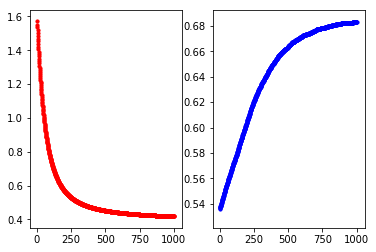

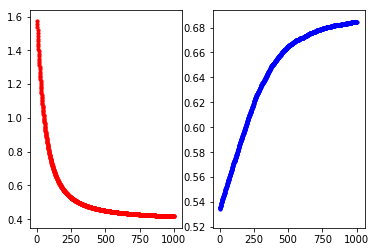

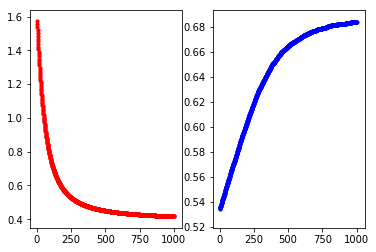

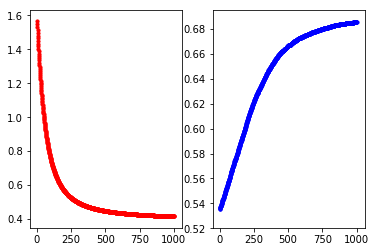

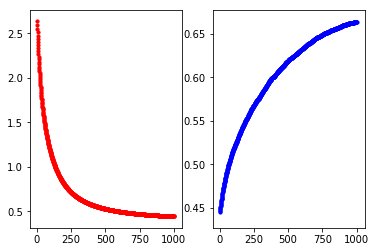

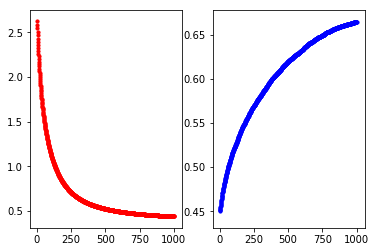

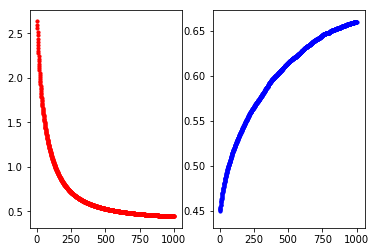

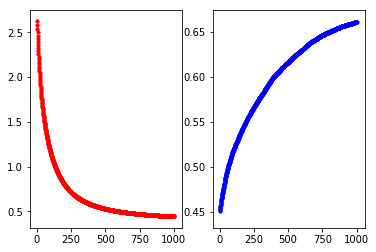

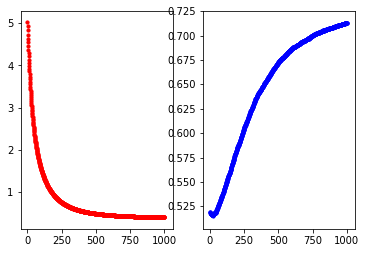

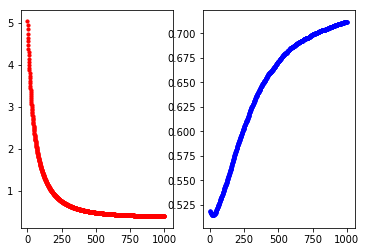

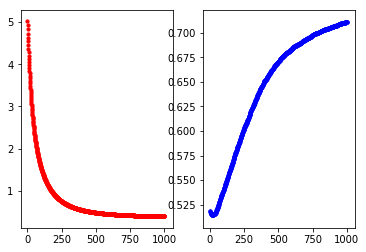

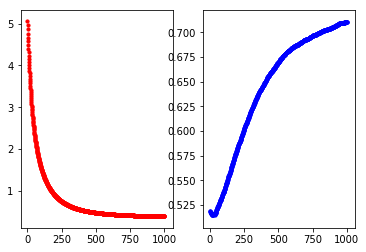

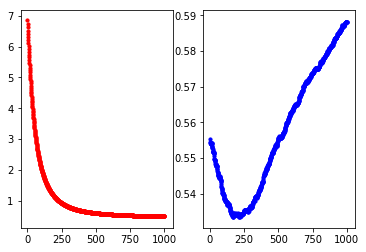

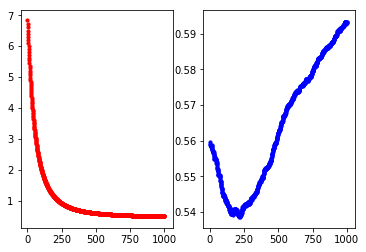

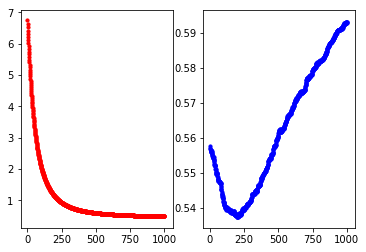

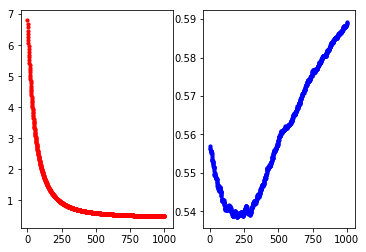

In [54]:
least_squares_GD_cross_val_res = []
for i, tx in enumerate(preprocessed_data_train):
    least_squares_GD_cross_val_res.append(cross_validate(least_squares_GD, tx, all_ys_train[i], epochs=1000, gamma=0.005, model_name='least_squares_GD'))
    
least_squares_GD_cross_val_res

### Logistic Regression
The feature expansion for this model has to be 2. Otherwise very low performance is achieved

feature expansion degree = 2

cost function:  LIKELIHOOD
Accuracy: 0.6520137721194651
cost function:  LIKELIHOOD
Accuracy: 0.6493447567192463
cost function:  LIKELIHOOD
Accuracy: 0.6797581872047401
cost function:  LIKELIHOOD
Accuracy: 0.6947046734459658
cost function:  LIKELIHOOD


/home/marco/Documents/programming/ML_project1/MLscripts/implementations.py:90: RuntimeWarning: divide by zero encountered in log
  return -log_likelihood + lambda_ * np.squeeze(np.matmul(w.T, w))


Accuracy: 0.7189526783569541
cost function:  LIKELIHOOD
Accuracy: 0.7283209224117223
cost function:  LIKELIHOOD
Accuracy: 0.7503136093095257
cost function:  LIKELIHOOD
Accuracy: 0.7548109002588945
cost function:  LIKELIHOOD
Accuracy: 0.7725465075933489
cost function:  LIKELIHOOD
Accuracy: 0.7741078816024769
cost function:  LIKELIHOOD
Accuracy: 0.7859449649024475
cost function:  LIKELIHOOD
Accuracy: 0.7877465502975952
cost function:  LIKELIHOOD
Accuracy: 0.7955400752662343
cost function:  LIKELIHOOD
Accuracy: 0.7968478928123415
cost function:  LIKELIHOOD
Accuracy: 0.802866522539835
cost function:  LIKELIHOOD
Accuracy: 0.8035471214668909
cost function:  LIKELIHOOD
Accuracy: 0.8079910321082553
cost function:  LIKELIHOOD
Accuracy: 0.8091387087303493
cost function:  LIKELIHOOD
Accuracy: 0.8115675127445485
cost function:  LIKELIHOOD
Accuracy: 0.8124349427496197
cost function:  LIKELIHOOD
Accuracy: 0.8143966690687805
cost function:  LIKELIHOOD
Accuracy: 0.8153041343048549
cost function:  LIKE

cost function:  LIKELIHOOD
Accuracy: 0.8317452691702031
cost function:  LIKELIHOOD
Accuracy: 0.8307577334721221
cost function:  LIKELIHOOD
Accuracy: 0.8318386847092107
cost function:  LIKELIHOOD
Accuracy: 0.8308111137801265
cost function:  LIKELIHOOD
Accuracy: 0.8319587904022206
cost function:  LIKELIHOOD
Accuracy: 0.8307977687031254
cost function:  LIKELIHOOD
Accuracy: 0.8320655510182293
cost function:  LIKELIHOOD
Accuracy: 0.830744388395121
cost function:  LIKELIHOOD
Accuracy: 0.8322523820962447
cost function:  LIKELIHOOD
Accuracy: 0.8306910080871167
cost function:  LIKELIHOOD
Accuracy: 0.8323724877892545
cost function:  LIKELIHOOD
Accuracy: 0.8305709023941068
cost function:  LIKELIHOOD
Accuracy: 0.8325192836362666
cost function:  LIKELIHOOD
Accuracy: 0.8305709023941068
cost function:  LIKELIHOOD
Accuracy: 0.8326393893292764
cost function:  LIKELIHOOD
Accuracy: 0.8305175220861024
cost function:  LIKELIHOOD
Accuracy: 0.8326527344062775
cost function:  LIKELIHOOD
Accuracy: 0.8305842474

Accuracy: 0.8352016441134865
cost function:  LIKELIHOOD
Accuracy: 0.8297168174660368
cost function:  LIKELIHOOD
Accuracy: 0.8352416793444898
cost function:  LIKELIHOOD
Accuracy: 0.8296901273120346
cost function:  LIKELIHOOD
Accuracy: 0.8352950596524942
cost function:  LIKELIHOOD
Accuracy: 0.829610056850028
cost function:  LIKELIHOOD
Accuracy: 0.8353084047294953
cost function:  LIKELIHOOD
Accuracy: 0.8296500920810314
cost function:  LIKELIHOOD
Accuracy: 0.8353217498064964
cost function:  LIKELIHOOD
Accuracy: 0.8296901273120346
cost function:  LIKELIHOOD
Accuracy: 0.8353617850374997
cost function:  LIKELIHOOD
Accuracy: 0.8296901273120346
cost function:  LIKELIHOOD
Accuracy: 0.8354151653455041
cost function:  LIKELIHOOD
Accuracy: 0.8296901273120346
cost function:  LIKELIHOOD
Accuracy: 0.8354818907305095
cost function:  LIKELIHOOD
Accuracy: 0.8296901273120346
cost function:  LIKELIHOOD
Accuracy: 0.8355219259615128
cost function:  LIKELIHOOD
Accuracy: 0.8297968879280433
cost function:  LIKE

Accuracy: 0.8277417460698748
cost function:  LIKELIHOOD
Accuracy: 0.827474844529853
cost function:  LIKELIHOOD
Accuracy: 0.8279819574558945
cost function:  LIKELIHOOD
Accuracy: 0.8277017108388716
cost function:  LIKELIHOOD
Accuracy: 0.8280887180719033
cost function:  LIKELIHOOD
Accuracy: 0.8277817813008781
cost function:  LIKELIHOOD
Accuracy: 0.8285024154589372
cost function:  LIKELIHOOD
Accuracy: 0.8277417460698748
cost function:  LIKELIHOOD
Accuracy: 0.828462380227934
cost function:  LIKELIHOOD
Accuracy: 0.8279686123788934
cost function:  LIKELIHOOD
Accuracy: 0.8285824859209437
cost function:  LIKELIHOOD
Accuracy: 0.8277284009928737
cost function:  LIKELIHOOD
Accuracy: 0.8287025916139537
cost function:  LIKELIHOOD
Accuracy: 0.8278885419168869
cost function:  LIKELIHOOD
Accuracy: 0.8288226973069635
cost function:  LIKELIHOOD
Accuracy: 0.8278084714548803
cost function:  LIKELIHOOD
Accuracy: 0.8288760776149678
cost function:  LIKELIHOOD
Accuracy: 0.8277150559158727
cost function:  LIKEL

cost function:  LIKELIHOOD
Accuracy: 0.8292363946939973
cost function:  LIKELIHOOD
Accuracy: 0.8334934742573464
cost function:  LIKELIHOOD
Accuracy: 0.8292897750020017
cost function:  LIKELIHOOD
Accuracy: 0.8335335094883497
cost function:  LIKELIHOOD
Accuracy: 0.8292363946939973
cost function:  LIKELIHOOD
Accuracy: 0.8334534390263432
cost function:  LIKELIHOOD
Accuracy: 0.8292097045399952
cost function:  LIKELIHOOD
Accuracy: 0.833426748872341
cost function:  LIKELIHOOD
Accuracy: 0.8292497397709985
cost function:  LIKELIHOOD
Accuracy: 0.8334934742573464
cost function:  LIKELIHOOD
Accuracy: 0.829316465156004
cost function:  LIKELIHOOD
Accuracy: 0.8336002348733552
cost function:  LIKELIHOOD
Accuracy: 0.8293031200790029
cost function:  LIKELIHOOD
Accuracy: 0.8336402701043585
cost function:  LIKELIHOOD
Accuracy: 0.829329810233005
cost function:  LIKELIHOOD
Accuracy: 0.833560199642352
cost function:  LIKELIHOOD
Accuracy: 0.8293431553100061
cost function:  LIKELIHOOD
Accuracy: 0.8335735447193

Accuracy: 0.8348012918034537
cost function:  LIKELIHOOD
Accuracy: 0.8301972402380762
cost function:  LIKELIHOOD
Accuracy: 0.8347879467264526
cost function:  LIKELIHOOD
Accuracy: 0.8302372754690794
cost function:  LIKELIHOOD
Accuracy: 0.834841327034457
cost function:  LIKELIHOOD
Accuracy: 0.8302372754690794
cost function:  LIKELIHOOD
Accuracy: 0.834854672111458
cost function:  LIKELIHOOD
Accuracy: 0.8302506205460806
cost function:  LIKELIHOOD
Accuracy: 0.8348146368804548
cost function:  LIKELIHOOD
Accuracy: 0.8302506205460806
cost function:  LIKELIHOOD
Accuracy: 0.834841327034457
cost function:  LIKELIHOOD
Accuracy: 0.8302773107000827
cost function:  LIKELIHOOD
Accuracy: 0.8347612565724504
cost function:  LIKELIHOOD
Accuracy: 0.8302506205460806
cost function:  LIKELIHOOD
Accuracy: 0.8347345664184482
cost function:  LIKELIHOOD
Accuracy: 0.8302239303920783
cost function:  LIKELIHOOD
Accuracy: 0.8347746016494515
cost function:  LIKELIHOOD
Accuracy: 0.8302639656230817
cost function:  LIKELI

Accuracy: 0.8300637894680652
cost function:  LIKELIHOOD
Accuracy: 0.830037099314063
cost function:  LIKELIHOOD
Accuracy: 0.8301038246990685
cost function:  LIKELIHOOD
Accuracy: 0.830183895161075
cost function:  LIKELIHOOD
Accuracy: 0.8301438599300718
cost function:  LIKELIHOOD
Accuracy: 0.8302639656230817
cost function:  LIKELIHOOD
Accuracy: 0.8302506205460806
cost function:  LIKELIHOOD
Accuracy: 0.8303573811620893
cost function:  LIKELIHOOD
Accuracy: 0.8304374516240959
cost function:  LIKELIHOOD
Accuracy: 0.8304908319321003
cost function:  LIKELIHOOD
Accuracy: 0.8304774868550991
cost function:  LIKELIHOOD
Accuracy: 0.8305175220861024
cost function:  LIKELIHOOD
Accuracy: 0.8305842474711079
cost function:  LIKELIHOOD
Accuracy: 0.8306109376251101
cost function:  LIKELIHOOD
Accuracy: 0.8306509728561133
cost function:  LIKELIHOOD
Accuracy: 0.8306910080871167
cost function:  LIKELIHOOD
Accuracy: 0.8306776630101156
cost function:  LIKELIHOOD
Accuracy: 0.8306910080871167
cost function:  LIKEL

Accuracy: 0.8329329810233005
cost function:  LIKELIHOOD
Accuracy: 0.8329062908692983
cost function:  LIKELIHOOD
Accuracy: 0.8329062908692983
cost function:  LIKELIHOOD
Accuracy: 0.8329463261003016
cost function:  LIKELIHOOD
Accuracy: 0.8329463261003016
cost function:  LIKELIHOOD
Accuracy: 0.8329463261003016
cost function:  LIKELIHOOD
Accuracy: 0.8329730162543038
cost function:  LIKELIHOOD
Accuracy: 0.8329863613313049
cost function:  LIKELIHOOD
Accuracy: 0.8330263965623081
cost function:  LIKELIHOOD
Accuracy: 0.8330664317933114
cost function:  LIKELIHOOD
Accuracy: 0.8330397416393093
cost function:  LIKELIHOOD
Accuracy: 0.8330530867163104
cost function:  LIKELIHOOD
Accuracy: 0.8330931219473137
cost function:  LIKELIHOOD
Accuracy: 0.8330797768703125
cost function:  LIKELIHOOD
Accuracy: 0.8331331571783169
cost function:  LIKELIHOOD
Accuracy: 0.8331331571783169
cost function:  LIKELIHOOD
Accuracy: 0.8331198121013158
cost function:  LIKELIHOOD
Accuracy: 0.833146502255318
cost function:  LIKE

cost function:  LIKELIHOOD
Accuracy: 0.8337470307203673
cost function:  LIKELIHOOD
Accuracy: 0.8337603757973684
cost function:  LIKELIHOOD
Accuracy: 0.8337603757973684
cost function:  LIKELIHOOD
Accuracy: 0.8337870659513705
cost function:  LIKELIHOOD
Accuracy: 0.8338271011823738
cost function:  LIKELIHOOD
Accuracy: 0.8338271011823738
cost function:  LIKELIHOOD
Accuracy: 0.8338671364133771
cost function:  LIKELIHOOD
Accuracy: 0.8339472068753837
cost function:  LIKELIHOOD
Accuracy: 0.6499986654922999
cost function:  LIKELIHOOD
Accuracy: 0.6497717991832813
cost function:  LIKELIHOOD
Accuracy: 0.6794779405877172
cost function:  LIKELIHOOD
Accuracy: 0.6948247791389757
cost function:  LIKELIHOOD
Accuracy: 0.7192462700509782
cost function:  LIKELIHOOD
Accuracy: 0.7290148664157792
cost function:  LIKELIHOOD
Accuracy: 0.750780687004564
cost function:  LIKELIHOOD
Accuracy: 0.7555315344169535
cost function:  LIKELIHOOD
Accuracy: 0.7723863666693357
cost function:  LIKELIHOOD
Accuracy: 0.7741746069

cost function:  LIKELIHOOD
Accuracy: 0.8295566765420237
cost function:  LIKELIHOOD
Accuracy: 0.8320788960952304
cost function:  LIKELIHOOD
Accuracy: 0.8296234019270291
cost function:  LIKELIHOOD
Accuracy: 0.8321055862492327
cost function:  LIKELIHOOD
Accuracy: 0.8296767822350335
cost function:  LIKELIHOOD
Accuracy: 0.8320655510182293
cost function:  LIKELIHOOD
Accuracy: 0.829743507620039
cost function:  LIKELIHOOD
Accuracy: 0.8321055862492327
cost function:  LIKELIHOOD
Accuracy: 0.8299570288520565
cost function:  LIKELIHOOD
Accuracy: 0.8321856567112392
cost function:  LIKELIHOOD
Accuracy: 0.8299837190060587
cost function:  LIKELIHOOD
Accuracy: 0.8321723116342381
cost function:  LIKELIHOOD
Accuracy: 0.8301972402380762
cost function:  LIKELIHOOD
Accuracy: 0.8322790722502469
cost function:  LIKELIHOOD
Accuracy: 0.8301038246990685
cost function:  LIKELIHOOD
Accuracy: 0.8323191074812502
cost function:  LIKELIHOOD
Accuracy: 0.8300904796220674
cost function:  LIKELIHOOD
Accuracy: 0.8323057624

cost function:  LIKELIHOOD
Accuracy: 0.832999706408306
cost function:  LIKELIHOOD
Accuracy: 0.832999706408306
cost function:  LIKELIHOOD
Accuracy: 0.8329863613313049
cost function:  LIKELIHOOD
Accuracy: 0.832999706408306
cost function:  LIKELIHOOD
Accuracy: 0.8329730162543038
cost function:  LIKELIHOOD
Accuracy: 0.8330397416393093
cost function:  LIKELIHOOD
Accuracy: 0.8330664317933114
cost function:  LIKELIHOOD
Accuracy: 0.8330397416393093
cost function:  LIKELIHOOD
Accuracy: 0.833013051485307
cost function:  LIKELIHOOD
Accuracy: 0.832999706408306
cost function:  LIKELIHOOD
Accuracy: 0.8329730162543038
cost function:  LIKELIHOOD
Accuracy: 0.8329596711773027
cost function:  LIKELIHOOD
Accuracy: 0.8329730162543038
cost function:  LIKELIHOOD
Accuracy: 0.8329863613313049
cost function:  LIKELIHOOD
Accuracy: 0.8329863613313049
cost function:  LIKELIHOOD
Accuracy: 0.8329596711773027
cost function:  LIKELIHOOD
Accuracy: 0.832999706408306
cost function:  LIKELIHOOD
Accuracy: 0.833053086716310

cost function:  LIKELIHOOD
Accuracy: 0.7335534234327178
cost function:  LIKELIHOOD
Accuracy: 0.7455552116647752
cost function:  LIKELIHOOD
Accuracy: 0.7281371436431789
cost function:  LIKELIHOOD
Accuracy: 0.7475153891124179
cost function:  LIKELIHOOD
Accuracy: 0.7370439148526428
cost function:  LIKELIHOOD
Accuracy: 0.7475841672684755
cost function:  LIKELIHOOD
Accuracy: 0.7286013961965679
cost function:  LIKELIHOOD
Accuracy: 0.7498538464183775
cost function:  LIKELIHOOD
Accuracy: 0.7423226383300664
cost function:  LIKELIHOOD
Accuracy: 0.748529866914268
cost function:  LIKELIHOOD
Accuracy: 0.7284122562674095
cost function:  LIKELIHOOD
Accuracy: 0.7517108566319337
cost function:  LIKELIHOOD
Accuracy: 0.7465181058495822
cost function:  LIKELIHOOD
Accuracy: 0.750421266205853
cost function:  LIKELIHOOD
Accuracy: 0.7280511709481069
cost function:  LIKELIHOOD
Accuracy: 0.7529660579799855
cost function:  LIKELIHOOD
Accuracy: 0.7481859761339799
cost function:  LIKELIHOOD
Accuracy: 0.75177963478

cost function:  LIKELIHOOD
Accuracy: 0.7379896144984353
cost function:  LIKELIHOOD
Accuracy: 0.7621651363526943
cost function:  LIKELIHOOD
Accuracy: 0.7619072182674782
cost function:  LIKELIHOOD
Accuracy: 0.7632655868496165
cost function:  LIKELIHOOD
Accuracy: 0.7426321400323257
cost function:  LIKELIHOOD
Accuracy: 0.7655008769214897
cost function:  LIKELIHOOD
Accuracy: 0.7687678393342274
cost function:  LIKELIHOOD
Accuracy: 0.7627497506791843
cost function:  LIKELIHOOD
Accuracy: 0.7380755871935073
cost function:  LIKELIHOOD
Accuracy: 0.7622854981257953
cost function:  LIKELIHOOD
Accuracy: 0.7623026926648097
cost function:  LIKELIHOOD
Accuracy: 0.7632827813886309
cost function:  LIKELIHOOD
Accuracy: 0.7426321400323257
cost function:  LIKELIHOOD
Accuracy: 0.7653805151483889
cost function:  LIKELIHOOD
Accuracy: 0.7689397847243715
cost function:  LIKELIHOOD
Accuracy: 0.762990474225386
cost function:  LIKELIHOOD
Accuracy: 0.7380583926544929
cost function:  LIKELIHOOD
Accuracy: 0.7623542762

cost function:  LIKELIHOOD
Accuracy: 0.7647099281268269
cost function:  LIKELIHOOD
Accuracy: 0.7419615530107638
cost function:  LIKELIHOOD
Accuracy: 0.7644004264245675
cost function:  LIKELIHOOD
Accuracy: 0.7674094707520891
cost function:  LIKELIHOOD
Accuracy: 0.7645379827366828
cost function:  LIKELIHOOD
Accuracy: 0.741548884074418
cost function:  LIKELIHOOD
Accuracy: 0.7642628701124523
cost function:  LIKELIHOOD
Accuracy: 0.7670139963547578
cost function:  LIKELIHOOD
Accuracy: 0.7646755390487981
cost function:  LIKELIHOOD
Accuracy: 0.7419615530107638
cost function:  LIKELIHOOD
Accuracy: 0.7644692045806252
cost function:  LIKELIHOOD
Accuracy: 0.7675126379861756
cost function:  LIKELIHOOD
Accuracy: 0.7646583445097836
cost function:  LIKELIHOOD
Accuracy: 0.74163485676949
cost function:  LIKELIHOOD
Accuracy: 0.7642456755734379
cost function:  LIKELIHOOD
Accuracy: 0.7670999690498298
cost function:  LIKELIHOOD
Accuracy: 0.7647787062828846
cost function:  LIKELIHOOD
Accuracy: 0.741978747549

cost function:  LIKELIHOOD
Accuracy: 0.7632140032325734
cost function:  LIKELIHOOD
Accuracy: 0.7457787406719626
cost function:  LIKELIHOOD
Accuracy: 0.7644863991196396
cost function:  LIKELIHOOD
Accuracy: 0.7620275800405791
cost function:  LIKELIHOOD
Accuracy: 0.763575088551876
cost function:  LIKELIHOOD
Accuracy: 0.7463805495374669
cost function:  LIKELIHOOD
Accuracy: 0.7647443172048557
cost function:  LIKELIHOOD
Accuracy: 0.7624918325939681
cost function:  LIKELIHOOD
Accuracy: 0.7638502011761065
cost function:  LIKELIHOOD
Accuracy: 0.7464493276935246
cost function:  LIKELIHOOD
Accuracy: 0.7650882079851439
cost function:  LIKELIHOOD
Accuracy: 0.7629560851473572
cost function:  LIKELIHOOD
Accuracy: 0.7643144537294955
cost function:  LIKELIHOOD
Accuracy: 0.7469995529419856
cost function:  LIKELIHOOD
Accuracy: 0.7654492933044466
cost function:  LIKELIHOOD
Accuracy: 0.7637814230200488
cost function:  LIKELIHOOD
Accuracy: 0.7648302898999277
cost function:  LIKELIHOOD
Accuracy: 0.7470683310

Accuracy: 0.7705904604697548
cost function:  LIKELIHOOD
Accuracy: 0.7699714570652361
cost function:  LIKELIHOOD
Accuracy: 0.7701090133773514
cost function:  LIKELIHOOD
Accuracy: 0.7532067815261873
cost function:  LIKELIHOOD
Accuracy: 0.7705044877746827
cost function:  LIKELIHOOD
Accuracy: 0.7699198734481929
cost function:  LIKELIHOOD
Accuracy: 0.7701090133773514
cost function:  LIKELIHOOD
Accuracy: 0.7533099487602737
cost function:  LIKELIHOOD
Accuracy: 0.7705044877746827
cost function:  LIKELIHOOD
Accuracy: 0.770005846143265
cost function:  LIKELIHOOD
Accuracy: 0.7702637642284811
cost function:  LIKELIHOOD
Accuracy: 0.7535850613845043
cost function:  LIKELIHOOD
Accuracy: 0.7704529041576396
cost function:  LIKELIHOOD
Accuracy: 0.7700746242993225
cost function:  LIKELIHOOD
Accuracy: 0.7704529041576396
cost function:  LIKELIHOOD
Accuracy: 0.7537054231576051
cost function:  LIKELIHOOD
Accuracy: 0.7705044877746827
cost function:  LIKELIHOOD
Accuracy: 0.7702121806114378
cost function:  LIKE

cost function:  LIKELIHOOD
Accuracy: 0.7705388768527116
cost function:  LIKELIHOOD
Accuracy: 0.7710547130231439
cost function:  LIKELIHOOD
Accuracy: 0.7549262354276282
cost function:  LIKELIHOOD
Accuracy: 0.7712782420303311
cost function:  LIKELIHOOD
Accuracy: 0.7705904604697548
cost function:  LIKELIHOOD
Accuracy: 0.771106296640187
cost function:  LIKELIHOOD
Accuracy: 0.7549090408886138
cost function:  LIKELIHOOD
Accuracy: 0.7712610474913167
cost function:  LIKELIHOOD
Accuracy: 0.7705904604697548
cost function:  LIKELIHOOD
Accuracy: 0.7711234911792015
cost function:  LIKELIHOOD
Accuracy: 0.7550122081227002
cost function:  LIKELIHOOD
Accuracy: 0.771226658413288
cost function:  LIKELIHOOD
Accuracy: 0.7705388768527116
cost function:  LIKELIHOOD
Accuracy: 0.7710031294061006
cost function:  LIKELIHOOD
Accuracy: 0.5817084493964717
cost function:  LIKELIHOOD
Accuracy: 0.6043708518174628
cost function:  LIKELIHOOD
Accuracy: 0.6299735204099178
cost function:  LIKELIHOOD
Accuracy: 0.63858798445

Accuracy: 0.73843667251281
cost function:  LIKELIHOOD
Accuracy: 0.7628185288352419
cost function:  LIKELIHOOD
Accuracy: 0.7609615186216857
cost function:  LIKELIHOOD
Accuracy: 0.7626637779841122
cost function:  LIKELIHOOD
Accuracy: 0.7430104198906428
cost function:  LIKELIHOOD
Accuracy: 0.7657759895457202
cost function:  LIKELIHOOD
Accuracy: 0.7697651225970632
cost function:  LIKELIHOOD
Accuracy: 0.7642972591904811
cost function:  LIKELIHOOD
Accuracy: 0.7391588431514151
cost function:  LIKELIHOOD
Accuracy: 0.7630248633034148
cost function:  LIKELIHOOD
Accuracy: 0.7612022421678875
cost function:  LIKELIHOOD
Accuracy: 0.762990474225386
cost function:  LIKELIHOOD
Accuracy: 0.7436466178341758
cost function:  LIKELIHOOD
Accuracy: 0.7659479349358643
cost function:  LIKELIHOOD
Accuracy: 0.7701605969943945
cost function:  LIKELIHOOD
Accuracy: 0.7647271226658413
cost function:  LIKELIHOOD
Accuracy: 0.7395371230097321
cost function:  LIKELIHOOD
Accuracy: 0.7632827813886309
cost function:  LIKELI

cost function:  LIKELIHOOD
Accuracy: 0.7680800577736511
cost function:  LIKELIHOOD
Accuracy: 0.7719144399738643
cost function:  LIKELIHOOD
Accuracy: 0.7668248564255993
cost function:  LIKELIHOOD
Accuracy: 0.7423570274080952
cost function:  LIKELIHOOD
Accuracy: 0.7655868496165618
cost function:  LIKELIHOOD
Accuracy: 0.7661542694040373
cost function:  LIKELIHOOD
Accuracy: 0.7656040441555761
cost function:  LIKELIHOOD
Accuracy: 0.7452457099625159
cost function:  LIKELIHOOD
Accuracy: 0.7681488359297087
cost function:  LIKELIHOOD
Accuracy: 0.7718112727397779
cost function:  LIKELIHOOD
Accuracy: 0.7668248564255993
cost function:  LIKELIHOOD
Accuracy: 0.7426149454933113
cost function:  LIKELIHOOD
Accuracy: 0.7656212386945906
cost function:  LIKELIHOOD
Accuracy: 0.7662402420991093
cost function:  LIKELIHOOD
Accuracy: 0.7657244059286771
cost function:  LIKELIHOOD
Accuracy: 0.7451941263454727
cost function:  LIKELIHOOD
Accuracy: 0.7682348086247808
cost function:  LIKELIHOOD
Accuracy: 0.771570549

cost function:  LIKELIHOOD
Accuracy: 0.7410158533649713
cost function:  LIKELIHOOD
Accuracy: 0.7253172392448158
cost function:  LIKELIHOOD
Accuracy: 0.7426493345713402
cost function:  LIKELIHOOD
Accuracy: 0.7280339764090925
cost function:  LIKELIHOOD
Accuracy: 0.743440283366003
cost function:  LIKELIHOOD
Accuracy: 0.7289280924378417
cost function:  LIKELIHOOD
Accuracy: 0.7451597372674439
cost function:  LIKELIHOOD
Accuracy: 0.7305271845661818
cost function:  LIKELIHOOD
Accuracy: 0.7466040785446543
cost function:  LIKELIHOOD
Accuracy: 0.7321606657725507
cost function:  LIKELIHOOD
Accuracy: 0.7476529454245332
cost function:  LIKELIHOOD
Accuracy: 0.7337597579008907
cost function:  LIKELIHOOD
Accuracy: 0.7490457030847003
cost function:  LIKELIHOOD
Accuracy: 0.7340348705251212
cost function:  LIKELIHOOD
Accuracy: 0.750421266205853
cost function:  LIKELIHOOD
Accuracy: 0.7349117920148561
cost function:  LIKELIHOOD
Accuracy: 0.7514873276247463
cost function:  LIKELIHOOD
Accuracy: 0.73637332783

cost function:  LIKELIHOOD
Accuracy: 0.7618384401114207
cost function:  LIKELIHOOD
Accuracy: 0.763368754083703
cost function:  LIKELIHOOD
Accuracy: 0.7458131297499914
cost function:  LIKELIHOOD
Accuracy: 0.7638845902541352
cost function:  LIKELIHOOD
Accuracy: 0.7617524674163486
cost function:  LIKELIHOOD
Accuracy: 0.7634203377007462
cost function:  LIKELIHOOD
Accuracy: 0.7461226314522508
cost function:  LIKELIHOOD
Accuracy: 0.7639361738711785
cost function:  LIKELIHOOD
Accuracy: 0.7618040510333918
cost function:  LIKELIHOOD
Accuracy: 0.7636094776299047
cost function:  LIKELIHOOD
Accuracy: 0.7461398259912652
cost function:  LIKELIHOOD
Accuracy: 0.7638845902541352
cost function:  LIKELIHOOD
Accuracy: 0.7618728291894494
cost function:  LIKELIHOOD
Accuracy: 0.763661061246948
cost function:  LIKELIHOOD
Accuracy: 0.7462773823033805
cost function:  LIKELIHOOD
Accuracy: 0.7640221465662506
cost function:  LIKELIHOOD
Accuracy: 0.7618900237284638
cost function:  LIKELIHOOD
Accuracy: 0.76376422848

Accuracy: 0.7643488428075244
cost function:  LIKELIHOOD
Accuracy: 0.7488737576945562
cost function:  LIKELIHOOD
Accuracy: 0.7650538189071151
cost function:  LIKELIHOOD
Accuracy: 0.7631624196155301
cost function:  LIKELIHOOD
Accuracy: 0.7643144537294955
cost function:  LIKELIHOOD
Accuracy: 0.7488909522335706
cost function:  LIKELIHOOD
Accuracy: 0.7650882079851439
cost function:  LIKELIHOOD
Accuracy: 0.7631624196155301
cost function:  LIKELIHOOD
Accuracy: 0.7644520100416108
cost function:  LIKELIHOOD
Accuracy: 0.7489597303896283
cost function:  LIKELIHOOD
Accuracy: 0.7651054025241584
cost function:  LIKELIHOOD
Accuracy: 0.7632483923106022
cost function:  LIKELIHOOD
Accuracy: 0.7645379827366828
cost function:  LIKELIHOOD
Accuracy: 0.748908146772585
cost function:  LIKELIHOOD
Accuracy: 0.7651913752192304
cost function:  LIKELIHOOD
Accuracy: 0.7631108359984868
cost function:  LIKELIHOOD
Accuracy: 0.7645207881976684
cost function:  LIKELIHOOD
Accuracy: 0.7489597303896283
cost function:  LIKE

cost function:  LIKELIHOOD
Accuracy: 0.7737282303742523
cost function:  LIKELIHOOD
Accuracy: 0.7745222592769043
cost function:  LIKELIHOOD
Accuracy: 0.7747604679476999
cost function:  LIKELIHOOD
Accuracy: 0.7753956910698216
cost function:  LIKELIHOOD
Accuracy: 0.7760309141919433
cost function:  LIKELIHOOD
Accuracy: 0.7767455402043301
cost function:  LIKELIHOOD
Accuracy: 0.7772219575459214
cost function:  LIKELIHOOD
Accuracy: 0.777857180668043
cost function:  LIKELIHOOD
Accuracy: 0.7783600656397226
cost function:  LIKELIHOOD
Accuracy: 0.7786776772007834
cost function:  LIKELIHOOD
Accuracy: 0.7791805621724631
cost function:  LIKELIHOOD
Accuracy: 0.7796569795140543
cost function:  LIKELIHOOD
Accuracy: 0.7803186702662643
cost function:  LIKELIHOOD
Accuracy: 0.7807686199777671
cost function:  LIKELIHOOD
Accuracy: 0.7813244402096237
cost function:  LIKELIHOOD
Accuracy: 0.7818537928113917
cost function:  LIKELIHOOD
Accuracy: 0.7822772748928061
cost function:  LIKELIHOOD
Accuracy: 0.7827801598

Accuracy: 0.8040601344555609
cost function:  LIKELIHOOD
Accuracy: 0.8025250119104336
cost function:  LIKELIHOOD
Accuracy: 0.8041395373458261
cost function:  LIKELIHOOD
Accuracy: 0.8025250119104336
cost function:  LIKELIHOOD
Accuracy: 0.8044836165369753
cost function:  LIKELIHOOD
Accuracy: 0.8027102853210524
cost function:  LIKELIHOOD
Accuracy: 0.8045365517971521
cost function:  LIKELIHOOD
Accuracy: 0.8030014292520248
cost function:  LIKELIHOOD
Accuracy: 0.8046688899475941
cost function:  LIKELIHOOD
Accuracy: 0.80308083214229
cost function:  LIKELIHOOD
Accuracy: 0.8044571489068869
cost function:  LIKELIHOOD
Accuracy: 0.8032661055529088
cost function:  LIKELIHOOD
Accuracy: 0.8046688899475941
cost function:  LIKELIHOOD
Accuracy: 0.8033984437033508
cost function:  LIKELIHOOD
Accuracy: 0.8048541633582129
cost function:  LIKELIHOOD
Accuracy: 0.803477846593616
cost function:  LIKELIHOOD
Accuracy: 0.8047482928378593
cost function:  LIKELIHOOD
Accuracy: 0.8038219257847652
cost function:  LIKELI

Accuracy: 0.8089301783918268
cost function:  LIKELIHOOD
Accuracy: 0.8072362500661691
cost function:  LIKELIHOOD
Accuracy: 0.8089566460219152
cost function:  LIKELIHOOD
Accuracy: 0.8072362500661691
cost function:  LIKELIHOOD
Accuracy: 0.8089301783918268
cost function:  LIKELIHOOD
Accuracy: 0.8073156529564343
cost function:  LIKELIHOOD
Accuracy: 0.8088243078714732
cost function:  LIKELIHOOD
Accuracy: 0.8073685882166111
cost function:  LIKELIHOOD
Accuracy: 0.80887724313165
cost function:  LIKELIHOOD
Accuracy: 0.8074479911068763
cost function:  LIKELIHOOD
Accuracy: 0.8089301783918268
cost function:  LIKELIHOOD
Accuracy: 0.8075803292573183
cost function:  LIKELIHOOD
Accuracy: 0.8089566460219152
cost function:  LIKELIHOOD
Accuracy: 0.8075803292573183
cost function:  LIKELIHOOD
Accuracy: 0.8089566460219152
cost function:  LIKELIHOOD
Accuracy: 0.8076067968874067
cost function:  LIKELIHOOD
Accuracy: 0.8088243078714732
cost function:  LIKELIHOOD
Accuracy: 0.8077126674077603
cost function:  LIKEL

Accuracy: 0.7920438303954264
cost function:  LIKELIHOOD
Accuracy: 0.7922291038060452
cost function:  LIKELIHOOD
Accuracy: 0.7927319887777249
cost function:  LIKELIHOOD
Accuracy: 0.7930231327086973
cost function:  LIKELIHOOD
Accuracy: 0.7930760679688741
cost function:  LIKELIHOOD
Accuracy: 0.7932878090095813
cost function:  LIKELIHOOD
Accuracy: 0.7937377587210841
cost function:  LIKELIHOOD
Accuracy: 0.7940553702821449
cost function:  LIKELIHOOD
Accuracy: 0.794452384733471
cost function:  LIKELIHOOD
Accuracy: 0.794584722883913
cost function:  LIKELIHOOD
Accuracy: 0.7947435286644434
cost function:  LIKELIHOOD
Accuracy: 0.795114075485681
cost function:  LIKELIHOOD
Accuracy: 0.795246413636123
cost function:  LIKELIHOOD
Accuracy: 0.7952728812662114
cost function:  LIKELIHOOD
Accuracy: 0.7954316870467418
cost function:  LIKELIHOOD
Accuracy: 0.7955375575670954
cost function:  LIKELIHOOD
Accuracy: 0.795775766237891
cost function:  LIKELIHOOD
Accuracy: 0.7958551691281562
cost function:  LIKELIHO

Accuracy: 0.8037425228945
cost function:  LIKELIHOOD
Accuracy: 0.8042454078661797
cost function:  LIKELIHOOD
Accuracy: 0.8039277963051188
cost function:  LIKELIHOOD
Accuracy: 0.8042189402360913
cost function:  LIKELIHOOD
Accuracy: 0.8039807315652956
cost function:  LIKELIHOOD
Accuracy: 0.8042983431263565
cost function:  LIKELIHOOD
Accuracy: 0.804007199195384
cost function:  LIKELIHOOD
Accuracy: 0.8043512783865333
cost function:  LIKELIHOOD
Accuracy: 0.8041130697157377
cost function:  LIKELIHOOD
Accuracy: 0.8043512783865333
cost function:  LIKELIHOOD
Accuracy: 0.8041130697157377
cost function:  LIKELIHOOD
Accuracy: 0.8044042136467101
cost function:  LIKELIHOOD
Accuracy: 0.8041924726060029
cost function:  LIKELIHOOD
Accuracy: 0.8044836165369753
cost function:  LIKELIHOOD
Accuracy: 0.8043512783865333
cost function:  LIKELIHOOD
Accuracy: 0.8044836165369753
cost function:  LIKELIHOOD
Accuracy: 0.8042718754962681
cost function:  LIKELIHOOD
Accuracy: 0.8045100841670637
cost function:  LIKELIH

cost function:  LIKELIHOOD
Accuracy: 0.7081679106452808
cost function:  LIKELIHOOD
Accuracy: 0.7099941771213806
cost function:  LIKELIHOOD
Accuracy: 0.7120057170080991
cost function:  LIKELIHOOD
Accuracy: 0.7134879042930496
cost function:  LIKELIHOOD
Accuracy: 0.7147318829072045
cost function:  LIKELIHOOD
Accuracy: 0.7166640199036578
cost function:  LIKELIHOOD
Accuracy: 0.7179609337779895
cost function:  LIKELIHOOD
Accuracy: 0.7198136678841777
cost function:  LIKELIHOOD
Accuracy: 0.7208459054576253
cost function:  LIKELIHOOD
Accuracy: 0.7223280927425758
cost function:  LIKELIHOOD
Accuracy: 0.7233073950558467
cost function:  LIKELIHOOD
Accuracy: 0.7247895823407972
cost function:  LIKELIHOOD
Accuracy: 0.7260864962151289
cost function:  LIKELIHOOD
Accuracy: 0.727409877719549
cost function:  LIKELIHOOD
Accuracy: 0.7282833095124662
cost function:  LIKELIHOOD
Accuracy: 0.729977237838124
cost function:  LIKELIHOOD
Accuracy: 0.7311418135620137
cost function:  LIKELIHOOD
Accuracy: 0.73238579217

cost function:  LIKELIHOOD
Accuracy: 0.7930231327086973
cost function:  LIKELIHOOD
Accuracy: 0.7902704991795034
cost function:  LIKELIHOOD
Accuracy: 0.7932878090095813
cost function:  LIKELIHOOD
Accuracy: 0.7904557725901222
cost function:  LIKELIHOOD
Accuracy: 0.7937112910909957
cost function:  LIKELIHOOD
Accuracy: 0.7906939812609179
cost function:  LIKELIHOOD
Accuracy: 0.7939759673918797
cost function:  LIKELIHOOD
Accuracy: 0.7909851251918903
cost function:  LIKELIHOOD
Accuracy: 0.7941083055423217
cost function:  LIKELIHOOD
Accuracy: 0.7910115928219787
cost function:  LIKELIHOOD
Accuracy: 0.7941083055423217
cost function:  LIKELIHOOD
Accuracy: 0.7913027367529512
cost function:  LIKELIHOOD
Accuracy: 0.7941877084325869
cost function:  LIKELIHOOD
Accuracy: 0.7917262188343656
cost function:  LIKELIHOOD
Accuracy: 0.7943729818432057
cost function:  LIKELIHOOD
Accuracy: 0.791752686464454
cost function:  LIKELIHOOD
Accuracy: 0.7944259171033826
cost function:  LIKELIHOOD
Accuracy: 0.7919379598

cost function:  LIKELIHOOD
Accuracy: 0.800910486475041
cost function:  LIKELIHOOD
Accuracy: 0.8017574506378699
cost function:  LIKELIHOOD
Accuracy: 0.800910486475041
cost function:  LIKELIHOOD
Accuracy: 0.8016780477476046
cost function:  LIKELIHOOD
Accuracy: 0.801042824625483
cost function:  LIKELIHOOD
Accuracy: 0.8016251124874278
cost function:  LIKELIHOOD
Accuracy: 0.8011222275157482
cost function:  LIKELIHOOD
Accuracy: 0.8015986448573394
cost function:  LIKELIHOOD
Accuracy: 0.801042824625483
cost function:  LIKELIHOOD
Accuracy: 0.8015986448573394
cost function:  LIKELIHOOD
Accuracy: 0.8009369541051294
cost function:  LIKELIHOOD
Accuracy: 0.801572177227251
cost function:  LIKELIHOOD
Accuracy: 0.8008840188449526
cost function:  LIKELIHOOD
Accuracy: 0.8016515801175162
cost function:  LIKELIHOOD
Accuracy: 0.8009369541051294
cost function:  LIKELIHOOD
Accuracy: 0.8017309830077815
cost function:  LIKELIHOOD
Accuracy: 0.8010163569953946
cost function:  LIKELIHOOD
Accuracy: 0.80170451537769

Accuracy: 0.764623365623842
cost function:  LIKELIHOOD
Accuracy: 0.765417394526494
cost function:  LIKELIHOOD
Accuracy: 0.7658408766079086
cost function:  LIKELIHOOD
Accuracy: 0.7670054523317982
cost function:  LIKELIHOOD
Accuracy: 0.7676936107140967
cost function:  LIKELIHOOD
Accuracy: 0.7681170927955111
cost function:  LIKELIHOOD
Accuracy: 0.7688317188078979
cost function:  LIKELIHOOD
Accuracy: 0.7697845534910804
cost function:  LIKELIHOOD
Accuracy: 0.7704991795034672
cost function:  LIKELIHOOD
Accuracy: 0.7712138055158541
cost function:  LIKELIHOOD
Accuracy: 0.7713196760362078
cost function:  LIKELIHOOD
Accuracy: 0.771531417076915
cost function:  LIKELIHOOD
Accuracy: 0.7719548991583294
cost function:  LIKELIHOOD
Accuracy: 0.772854798581335
cost function:  LIKELIHOOD
Accuracy: 0.7733576835530147
cost function:  LIKELIHOOD
Accuracy: 0.7739399714149595
cost function:  LIKELIHOOD
Accuracy: 0.7744693240167275
cost function:  LIKELIHOOD
Accuracy: 0.7747869355777883
cost function:  LIKELIH

Accuracy: 0.7949552697051506
cost function:  LIKELIHOOD
Accuracy: 0.7958022338679794
cost function:  LIKELIHOOD
Accuracy: 0.7951670107458578
cost function:  LIKELIHOOD
Accuracy: 0.7959345720184214
cost function:  LIKELIHOOD
Accuracy: 0.7952728812662114
cost function:  LIKELIHOOD
Accuracy: 0.7960669101688634
cost function:  LIKELIHOOD
Accuracy: 0.795378751786565
cost function:  LIKELIHOOD
Accuracy: 0.796358054099836
cost function:  LIKELIHOOD
Accuracy: 0.7955904928272722
cost function:  LIKELIHOOD
Accuracy: 0.7966491980308084
cost function:  LIKELIHOOD
Accuracy: 0.7957228309777142
cost function:  LIKELIHOOD
Accuracy: 0.7969138743316924
cost function:  LIKELIHOOD
Accuracy: 0.7958551691281562
cost function:  LIKELIHOOD
Accuracy: 0.7970462124821344
cost function:  LIKELIHOOD
Accuracy: 0.795908104388333
cost function:  LIKELIHOOD
Accuracy: 0.797152083002488
cost function:  LIKELIHOOD
Accuracy: 0.795908104388333
cost function:  LIKELIHOOD
Accuracy: 0.79728442115293
cost function:  LIKELIHOOD

Accuracy: 0.7996400402307977
cost function:  LIKELIHOOD
Accuracy: 0.8024720766502568
cost function:  LIKELIHOOD
Accuracy: 0.7996400402307977
cost function:  LIKELIHOOD
Accuracy: 0.8024985442803452
cost function:  LIKELIHOOD
Accuracy: 0.7997723783812397
cost function:  LIKELIHOOD
Accuracy: 0.802551479540522
cost function:  LIKELIHOOD
Accuracy: 0.7999047165316817
cost function:  LIKELIHOOD
Accuracy: 0.8025779471706104
cost function:  LIKELIHOOD
Accuracy: 0.8000370546821237
cost function:  LIKELIHOOD
Accuracy: 0.8026044148006988
cost function:  LIKELIHOOD
Accuracy: 0.7999576517918585
cost function:  LIKELIHOOD
Accuracy: 0.8024720766502568
cost function:  LIKELIHOOD
Accuracy: 0.8000370546821237
cost function:  LIKELIHOOD
Accuracy: 0.8025250119104336
cost function:  LIKELIHOOD
Accuracy: 0.8000105870520353
cost function:  LIKELIHOOD
Accuracy: 0.802551479540522
cost function:  LIKELIHOOD
Accuracy: 0.8000635223122121
cost function:  LIKELIHOOD
Accuracy: 0.8024720766502568
cost function:  LIKEL

/home/marco/Documents/programming/ML_project1/MLscripts/implementations.py:139: RuntimeWarning: overflow encountered in exp
  


Accuracy: 0.663478313180533
cost function:  LIKELIHOOD
Accuracy: 0.6643205197617759
cost function:  LIKELIHOOD
Accuracy: 0.6660650905372075
cost function:  LIKELIHOOD
Accuracy: 0.6669674547313963
cost function:  LIKELIHOOD
Accuracy: 0.66720808518318
cost function:  LIKELIHOOD
Accuracy: 0.6681706069903146
cost function:  LIKELIHOOD
Accuracy: 0.6687120255068278
cost function:  LIKELIHOOD
Accuracy: 0.6693136016362871
cost function:  LIKELIHOOD
Accuracy: 0.6707573843469891
cost function:  LIKELIHOOD
Accuracy: 0.6716597485411779
cost function:  LIKELIHOOD
Accuracy: 0.6720206942188534
cost function:  LIKELIHOOD
Accuracy: 0.6734043193166095
cost function:  LIKELIHOOD
Accuracy: 0.673825422607231
cost function:  LIKELIHOOD
Accuracy: 0.6741863682849064
cost function:  LIKELIHOOD
Accuracy: 0.6742465258978524
cost function:  LIKELIHOOD
Accuracy: 0.675269205317933
cost function:  LIKELIHOOD
Accuracy: 0.6761715695121218
cost function:  LIKELIHOOD
Accuracy: 0.6771340913192565
cost function:  LIKELIHO

cost function:  LIKELIHOOD
Accuracy: 0.7615352222823798
cost function:  LIKELIHOOD
Accuracy: 0.7619563255730013
cost function:  LIKELIHOOD
Accuracy: 0.7624375864765686
cost function:  LIKELIHOOD
Accuracy: 0.7626782169283522
cost function:  LIKELIHOOD
Accuracy: 0.7629790049930819
cost function:  LIKELIHOOD
Accuracy: 0.7630993202189738
cost function:  LIKELIHOOD
Accuracy: 0.7634001082837033
cost function:  LIKELIHOOD
Accuracy: 0.7637610539613788
cost function:  LIKELIHOOD
Accuracy: 0.7643024724778921
cost function:  LIKELIHOOD
Accuracy: 0.7645431029296758
cost function:  LIKELIHOOD
Accuracy: 0.7652649942850268
cost function:  LIKELIHOOD
Accuracy: 0.7656259399627022
cost function:  LIKELIHOOD
Accuracy: 0.76580641280154
cost function:  LIKELIHOOD
Accuracy: 0.7664681465439451
cost function:  LIKELIHOOD
Accuracy: 0.7664681465439451
cost function:  LIKELIHOOD
Accuracy: 0.7669494074475125
cost function:  LIKELIHOOD
Accuracy: 0.767250195512242
cost function:  LIKELIHOOD
Accuracy: 0.767430668351

cost function:  LIKELIHOOD
Accuracy: 0.7896889851410696
cost function:  LIKELIHOOD
Accuracy: 0.7897491427540155
cost function:  LIKELIHOOD
Accuracy: 0.7897491427540155
cost function:  LIKELIHOOD
Accuracy: 0.7898694579799074
cost function:  LIKELIHOOD
Accuracy: 0.7898093003669614
cost function:  LIKELIHOOD
Accuracy: 0.7900499308187451
cost function:  LIKELIHOOD
Accuracy: 0.7902304036575829
cost function:  LIKELIHOOD
Accuracy: 0.7902905612705288
cost function:  LIKELIHOOD
Accuracy: 0.7904710341093666
cost function:  LIKELIHOOD
Accuracy: 0.7904108764964206
cost function:  LIKELIHOOD
Accuracy: 0.7904108764964206
cost function:  LIKELIHOOD
Accuracy: 0.7904710341093666
cost function:  LIKELIHOOD
Accuracy: 0.7905311917223125
cost function:  LIKELIHOOD
Accuracy: 0.7906515069482043
cost function:  LIKELIHOOD
Accuracy: 0.7907718221740961
cost function:  LIKELIHOOD
Accuracy: 0.790892137399988
cost function:  LIKELIHOOD
Accuracy: 0.790831979787042
cost function:  LIKELIHOOD
Accuracy: 0.79095229501

Accuracy: 0.7123262948926187
cost function:  LIKELIHOOD
Accuracy: 0.7132286590868074
cost function:  LIKELIHOOD
Accuracy: 0.7138302352162667
cost function:  LIKELIHOOD
Accuracy: 0.7145521265716176
cost function:  LIKELIHOOD
Accuracy: 0.7148529146363473
cost function:  LIKELIHOOD
Accuracy: 0.7154544907658064
cost function:  LIKELIHOOD
Accuracy: 0.7163568549599952
cost function:  LIKELIHOOD
Accuracy: 0.7174998496059677
cost function:  LIKELIHOOD
Accuracy: 0.717981110509535
cost function:  LIKELIHOOD
Accuracy: 0.7186428442519401
cost function:  LIKELIHOOD
Accuracy: 0.7186428442519401
cost function:  LIKELIHOOD
Accuracy: 0.7197256812849666
cost function:  LIKELIHOOD
Accuracy: 0.7205678878662095
cost function:  LIKELIHOOD
Accuracy: 0.7213499368345064
cost function:  LIKELIHOOD
Accuracy: 0.721650724899236
cost function:  LIKELIHOOD
Accuracy: 0.7215905672862901
cost function:  LIKELIHOOD
Accuracy: 0.7223124586416411
cost function:  LIKELIHOOD
Accuracy: 0.7225530890934247
cost function:  LIKEL

cost function:  LIKELIHOOD
Accuracy: 0.7740480057751309
cost function:  LIKELIHOOD
Accuracy: 0.7743487938398604
cost function:  LIKELIHOOD
Accuracy: 0.7744089514528063
cost function:  LIKELIHOOD
Accuracy: 0.7745292666786981
cost function:  LIKELIHOOD
Accuracy: 0.7744089514528063
cost function:  LIKELIHOOD
Accuracy: 0.774709739517536
cost function:  LIKELIHOOD
Accuracy: 0.7748300547434278
cost function:  LIKELIHOOD
Accuracy: 0.7751308428081574
cost function:  LIKELIHOOD
Accuracy: 0.7752511580340492
cost function:  LIKELIHOOD
Accuracy: 0.7752511580340492
cost function:  LIKELIHOOD
Accuracy: 0.7756121037117247
cost function:  LIKELIHOOD
Accuracy: 0.7760933646152921
cost function:  LIKELIHOOD
Accuracy: 0.7765746255188594
cost function:  LIKELIHOOD
Accuracy: 0.7769957288094809
cost function:  LIKELIHOOD
Accuracy: 0.7771160440353727
cost function:  LIKELIHOOD
Accuracy: 0.7773566744871564
cost function:  LIKELIHOOD
Accuracy: 0.777657462551886
cost function:  LIKELIHOOD
Accuracy: 0.77771762016

cost function:  LIKELIHOOD
Accuracy: 0.7917945015941767
cost function:  LIKELIHOOD
Accuracy: 0.7920351320459604
cost function:  LIKELIHOOD
Accuracy: 0.7920952896589063
cost function:  LIKELIHOOD
Accuracy: 0.7922156048847981
cost function:  LIKELIHOOD
Accuracy: 0.79233592011069
cost function:  LIKELIHOOD
Accuracy: 0.7922757624977441
cost function:  LIKELIHOOD
Accuracy: 0.7922757624977441
cost function:  LIKELIHOOD
Accuracy: 0.7922757624977441
cost function:  LIKELIHOOD
Accuracy: 0.79233592011069
cost function:  LIKELIHOOD
Accuracy: 0.79233592011069
cost function:  LIKELIHOOD
Accuracy: 0.7922757624977441
cost function:  LIKELIHOOD
Accuracy: 0.79233592011069
cost function:  LIKELIHOOD
Accuracy: 0.7922757624977441
cost function:  LIKELIHOOD
Accuracy: 0.7922757624977441
cost function:  LIKELIHOOD
Accuracy: 0.5225290260482464
cost function:  LIKELIHOOD
Accuracy: 0.5544125609095831
cost function:  LIKELIHOOD
Accuracy: 0.5747458340853034
cost function:  LIKELIHOOD
Accuracy: 0.5885820850628647


cost function:  LIKELIHOOD
Accuracy: 0.7468567647235758
cost function:  LIKELIHOOD
Accuracy: 0.7475184984659808
cost function:  LIKELIHOOD
Accuracy: 0.7479396017566023
cost function:  LIKELIHOOD
Accuracy: 0.7485411778860614
cost function:  LIKELIHOOD
Accuracy: 0.7487216507248993
cost function:  LIKELIHOOD
Accuracy: 0.7493232268543584
cost function:  LIKELIHOOD
Accuracy: 0.7496841725320339
cost function:  LIKELIHOOD
Accuracy: 0.750345906274439
cost function:  LIKELIHOOD
Accuracy: 0.75106779762979
cost function:  LIKELIHOOD
Accuracy: 0.7516693737592492
cost function:  LIKELIHOOD
Accuracy: 0.7520904770498706
cost function:  LIKELIHOOD
Accuracy: 0.7522709498887085
cost function:  LIKELIHOOD
Accuracy: 0.7526920531793299
cost function:  LIKELIHOOD
Accuracy: 0.7532334716958431
cost function:  LIKELIHOOD
Accuracy: 0.7534741021476268
cost function:  LIKELIHOOD
Accuracy: 0.7537147325994105
cost function:  LIKELIHOOD
Accuracy: 0.7542561511159237
cost function:  LIKELIHOOD
Accuracy: 0.754496781567

cost function:  LIKELIHOOD
Accuracy: 0.78644047404199
cost function:  LIKELIHOOD
Accuracy: 0.78644047404199
cost function:  LIKELIHOOD
Accuracy: 0.7868615773326114
cost function:  LIKELIHOOD
Accuracy: 0.7868014197196656
cost function:  LIKELIHOOD
Accuracy: 0.7867412621067196
cost function:  LIKELIHOOD
Accuracy: 0.7868615773326114
cost function:  LIKELIHOOD
Accuracy: 0.7870420501714492
cost function:  LIKELIHOOD
Accuracy: 0.7869818925585033
cost function:  LIKELIHOOD
Accuracy: 0.7872826806232329
cost function:  LIKELIHOOD
Accuracy: 0.7873428382361788
cost function:  LIKELIHOOD
Accuracy: 0.7874631534620706
cost function:  LIKELIHOOD
Accuracy: 0.7877037839138543
cost function:  LIKELIHOOD
Accuracy: 0.7877639415268002
cost function:  LIKELIHOOD
Accuracy: 0.7875233110750165
cost function:  LIKELIHOOD
Accuracy: 0.7877037839138543
cost function:  LIKELIHOOD
Accuracy: 0.7875834686879625
cost function:  LIKELIHOOD
Accuracy: 0.7877037839138543
cost function:  LIKELIHOOD
Accuracy: 0.7875834686879

Accuracy: 0.6847741081633881
cost function:  LIKELIHOOD
Accuracy: 0.6857366299705228
cost function:  LIKELIHOOD
Accuracy: 0.686338206099982
cost function:  LIKELIHOOD
Accuracy: 0.6873007279071166
cost function:  LIKELIHOOD
Accuracy: 0.6876015159718463
cost function:  LIKELIHOOD
Accuracy: 0.6886843530048727
cost function:  LIKELIHOOD
Accuracy: 0.6890452986825483
cost function:  LIKELIHOOD
Accuracy: 0.6897070324249533
cost function:  LIKELIHOOD
Accuracy: 0.6901281357155749
cost function:  LIKELIHOOD
Accuracy: 0.6909101846838718
cost function:  LIKELIHOOD
Accuracy: 0.6912109727486013
cost function:  LIKELIHOOD
Accuracy: 0.6917523912651146
cost function:  LIKELIHOOD
Accuracy: 0.6924141250075198
cost function:  LIKELIHOOD
Accuracy: 0.6930758587499248
cost function:  LIKELIHOOD
Accuracy: 0.6939782229441136
cost function:  LIKELIHOOD
Accuracy: 0.6950610599771401
cost function:  LIKELIHOOD
Accuracy: 0.6961438970101667
cost function:  LIKELIHOOD
Accuracy: 0.696625157913734
cost function:  LIKEL

Accuracy: 0.7627383745412982
cost function:  LIKELIHOOD
Accuracy: 0.7630993202189738
cost function:  LIKELIHOOD
Accuracy: 0.7632797930578115
cost function:  LIKELIHOOD
Accuracy: 0.7637008963484329
cost function:  LIKELIHOOD
Accuracy: 0.7642423148649462
cost function:  LIKELIHOOD
Accuracy: 0.7642423148649462
cost function:  LIKELIHOOD
Accuracy: 0.7644829453167298
cost function:  LIKELIHOOD
Accuracy: 0.7644227877037839
cost function:  LIKELIHOOD
Accuracy: 0.7646634181555676
cost function:  LIKELIHOOD
Accuracy: 0.765144679059135
cost function:  LIKELIHOOD
Accuracy: 0.7652048366720808
cost function:  LIKELIHOOD
Accuracy: 0.7656259399627022
cost function:  LIKELIHOOD
Accuracy: 0.7660470432533237
cost function:  LIKELIHOOD
Accuracy: 0.7664079889309993
cost function:  LIKELIHOOD
Accuracy: 0.7667689346086747
cost function:  LIKELIHOOD
Accuracy: 0.7668290922216207
cost function:  LIKELIHOOD
Accuracy: 0.7670697226734043
cost function:  LIKELIHOOD
Accuracy: 0.7673705107381339
cost function:  LIKE

Accuracy: 0.7869217349455574
cost function:  LIKELIHOOD
Accuracy: 0.7870420501714492
cost function:  LIKELIHOOD
Accuracy: 0.7871022077843951
cost function:  LIKELIHOOD
Accuracy: 0.7870420501714492
cost function:  LIKELIHOOD
Accuracy: 0.7871022077843951
cost function:  LIKELIHOOD
Accuracy: 0.7874631534620706
cost function:  LIKELIHOOD
Accuracy: 0.7877037839138543
cost function:  LIKELIHOOD
Accuracy: 0.787884256752692
cost function:  LIKELIHOOD
Accuracy: 0.7877639415268002
cost function:  LIKELIHOOD
Accuracy: 0.787884256752692
cost function:  LIKELIHOOD
Accuracy: 0.7876436263009083
cost function:  LIKELIHOOD
Accuracy: 0.7877037839138543
cost function:  LIKELIHOOD
Accuracy: 0.7877037839138543
cost function:  LIKELIHOOD
Accuracy: 0.7880045719785839
cost function:  LIKELIHOOD
Accuracy: 0.7880647295915298
cost function:  LIKELIHOOD
Accuracy: 0.7882452024303676
cost function:  LIKELIHOOD
Accuracy: 0.7883655176562594
cost function:  LIKELIHOOD
Accuracy: 0.7881248872044757
cost function:  LIKEL

[{'test_score': [0.8280486828408999,
   0.8306109376251101,
   0.8374969973576748,
   0.8321322764032348],
  'train_score': [0.8303306910080871,
   0.8304774868550991,
   0.8339472068753837,
   0.8335735447193531]},
 {'test_score': [0.7448674301041989,
   0.7647787062828846,
   0.773290003095017,
   0.7670999690498298],
  'train_score': [0.7420647202448503,
   0.7710031294061006,
   0.7710719075621583,
   0.7648990680559854]},
 {'test_score': [0.7995077020803557,
   0.8066539622042243,
   0.8033190408130856,
   0.8083214228997936],
  'train_score': [0.8077920702980255,
   0.806045206712191,
   0.8019427240484887,
   0.8024456090201684]},
 {'test_score': [0.7875834686879625,
   0.7919148168200686,
   0.7911929254647175,
   0.7929976538530951],
  'train_score': [0.7946219094026349,
   0.7922757624977441,
   0.7936593875955003,
   0.7899897732057992]}]

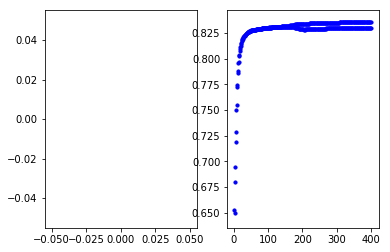

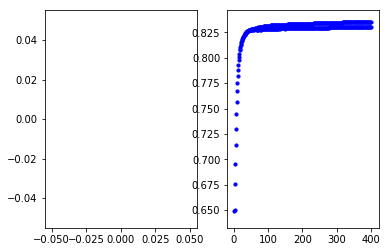

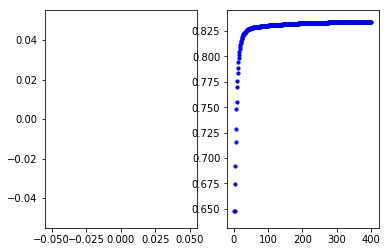

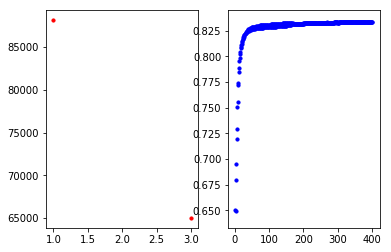

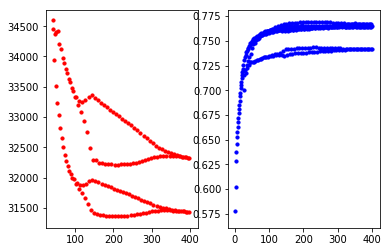

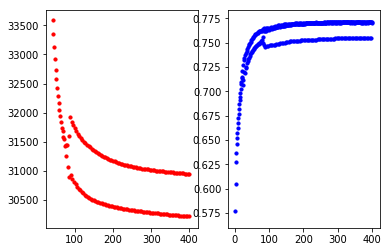

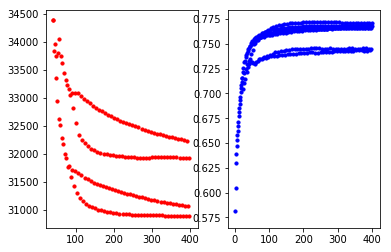

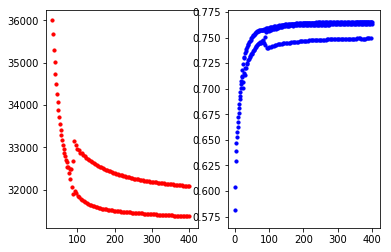

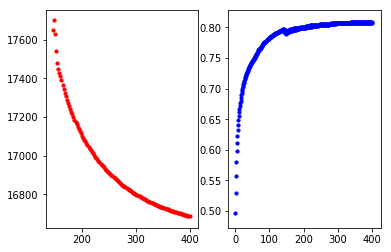

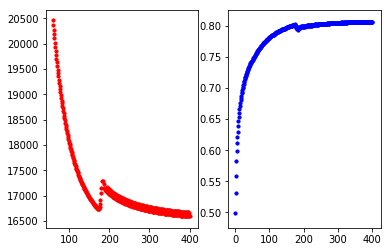

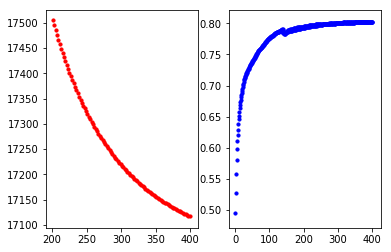

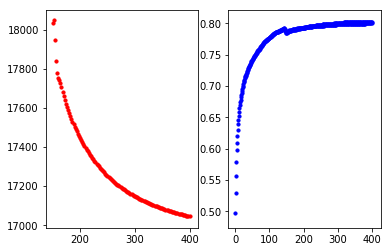

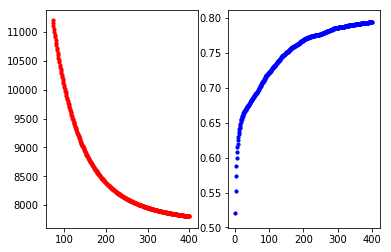

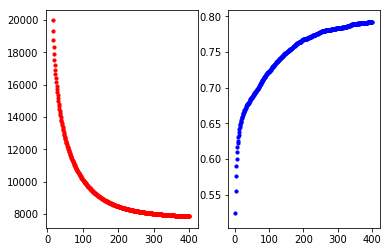

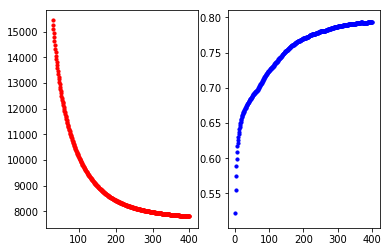

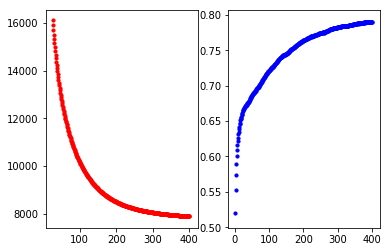

In [18]:
logistic_regression_cross_val_res = []
for i, tx in enumerate(preprocessed_data_train_augmented):
    logistic_regression_cross_val_res.append(cross_validate(logistic_regression, tx, all_ys_train[i], epochs=400, gamma=0.000005, model_name='logistic_regression'))
    
logistic_regression_cross_val_res

In [19]:
logistic_regression_cross_val_res

[{'test_score': [0.8280486828408999,
   0.8306109376251101,
   0.8374969973576748,
   0.8321322764032348],
  'train_score': [0.8303306910080871,
   0.8304774868550991,
   0.8339472068753837,
   0.8335735447193531]},
 {'test_score': [0.7448674301041989,
   0.7647787062828846,
   0.773290003095017,
   0.7670999690498298],
  'train_score': [0.7420647202448503,
   0.7710031294061006,
   0.7710719075621583,
   0.7648990680559854]},
 {'test_score': [0.7995077020803557,
   0.8066539622042243,
   0.8033190408130856,
   0.8083214228997936],
  'train_score': [0.8077920702980255,
   0.806045206712191,
   0.8019427240484887,
   0.8024456090201684]},
 {'test_score': [0.7875834686879625,
   0.7919148168200686,
   0.7911929254647175,
   0.7929976538530951],
  'train_score': [0.7946219094026349,
   0.7922757624977441,
   0.7936593875955003,
   0.7899897732057992]}]

No feature expansion for the following cross validation

cost function:  LIKELIHOOD
Accuracy: 0.5142658873141698
cost function:  LIKELIHOOD
Accuracy: 0.5300264232524622
cost function:  LIKELIHOOD
Accuracy: 0.5477486855099154
cost function:  LIKELIHOOD
Accuracy: 0.5632022846771826
cost function:  LIKELIHOOD
Accuracy: 0.5772146155283316
cost function:  LIKELIHOOD
Accuracy: 0.589585501908346


/home/marco/Documents/programming/ML_project1/MLscripts/implementations.py:90: RuntimeWarning: divide by zero encountered in log
  return -log_likelihood + lambda_ * np.squeeze(np.matmul(w.T, w))


cost function:  LIKELIHOOD
Accuracy: 0.598646809192089
cost function:  LIKELIHOOD
Accuracy: 0.6077348066298343
cost function:  LIKELIHOOD
Accuracy: 0.615061253903435
cost function:  LIKELIHOOD
Accuracy: 0.6216537219419757
cost function:  LIKELIHOOD
Accuracy: 0.6270050978194144
cost function:  LIKELIHOOD
Accuracy: 0.632463234312862
cost function:  LIKELIHOOD
Accuracy: 0.6373475324952625
cost function:  LIKELIHOOD
Accuracy: 0.6413644006725919
cost function:  LIKELIHOOD
Accuracy: 0.6447273600768676
cost function:  LIKELIHOOD
Accuracy: 0.6471828542450689
cost function:  LIKELIHOOD
Accuracy: 0.6496917287212747
cost function:  LIKELIHOOD
Accuracy: 0.6518402861184509
cost function:  LIKELIHOOD
Accuracy: 0.6540956041316358
cost function:  LIKELIHOOD
Accuracy: 0.6558037739877759
cost function:  LIKELIHOOD
Accuracy: 0.6573784930739051
cost function:  LIKELIHOOD
Accuracy: 0.6589932473910375
cost function:  LIKELIHOOD
Accuracy: 0.6606480369391732
cost function:  LIKELIHOOD
Accuracy: 0.662409587103

cost function:  LIKELIHOOD
Accuracy: 0.7178984172738677
cost function:  LIKELIHOOD
Accuracy: 0.717938452504871
cost function:  LIKELIHOOD
Accuracy: 0.7179784877358742
cost function:  LIKELIHOOD
Accuracy: 0.7181653188138896
cost function:  LIKELIHOOD
Accuracy: 0.7181920089678917
cost function:  LIKELIHOOD
Accuracy: 0.7182854245068994
cost function:  LIKELIHOOD
Accuracy: 0.7184589105079137
cost function:  LIKELIHOOD
Accuracy: 0.7185656711239223
cost function:  LIKELIHOOD
Accuracy: 0.7186991218939334
cost function:  LIKELIHOOD
Accuracy: 0.7188325726639443
cost function:  LIKELIHOOD
Accuracy: 0.7189793685109563
cost function:  LIKELIHOOD
Accuracy: 0.7190594389729629
cost function:  LIKELIHOOD
Accuracy: 0.7191261643579684
cost function:  LIKELIHOOD
Accuracy: 0.719219579896976
cost function:  LIKELIHOOD
Accuracy: 0.7192329249739771
cost function:  LIKELIHOOD
Accuracy: 0.719353030666987
cost function:  LIKELIHOOD
Accuracy: 0.7194464462059946
cost function:  LIKELIHOOD
Accuracy: 0.719539861745

cost function:  LIKELIHOOD
Accuracy: 0.7259054634745242
cost function:  LIKELIHOOD
Accuracy: 0.7259321536285265
cost function:  LIKELIHOOD
Accuracy: 0.7259188085515254
cost function:  LIKELIHOOD
Accuracy: 0.7259721888595297
cost function:  LIKELIHOOD
Accuracy: 0.7259721888595297
cost function:  LIKELIHOOD
Accuracy: 0.7259855339365309
cost function:  LIKELIHOOD
Accuracy: 0.7259454987055275
cost function:  LIKELIHOOD
Accuracy: 0.7259721888595297
cost function:  LIKELIHOOD
Accuracy: 0.7259721888595297
cost function:  LIKELIHOOD
Accuracy: 0.726012224090533
cost function:  LIKELIHOOD
Accuracy: 0.726012224090533
cost function:  LIKELIHOOD
Accuracy: 0.7260656043985374
cost function:  LIKELIHOOD
Accuracy: 0.7261189847065418
cost function:  LIKELIHOOD
Accuracy: 0.7261189847065418
cost function:  LIKELIHOOD
Accuracy: 0.7261189847065418
cost function:  LIKELIHOOD
Accuracy: 0.7261323297835428
cost function:  LIKELIHOOD
Accuracy: 0.7261456748605439
cost function:  LIKELIHOOD
Accuracy: 0.72613232978

Accuracy: 0.6918354818907305
cost function:  LIKELIHOOD
Accuracy: 0.692462700509782
cost function:  LIKELIHOOD
Accuracy: 0.6931166092828356
cost function:  LIKELIHOOD
Accuracy: 0.6939973843649078
cost function:  LIKELIHOOD
Accuracy: 0.6947046734459658
cost function:  LIKELIHOOD
Accuracy: 0.6952117863720073
cost function:  LIKELIHOOD
Accuracy: 0.6958256599140578
cost function:  LIKELIHOOD
Accuracy: 0.6962527023780927
cost function:  LIKELIHOOD
Accuracy: 0.6967331251501321
cost function:  LIKELIHOOD
Accuracy: 0.6971201323831638
cost function:  LIKELIHOOD
Accuracy: 0.6976672805402088
cost function:  LIKELIHOOD
Accuracy: 0.6980275976192383
cost function:  LIKELIHOOD
Accuracy: 0.6984946753142766
cost function:  LIKELIHOOD
Accuracy: 0.6988816825473083
cost function:  LIKELIHOOD
Accuracy: 0.6994421757813543
cost function:  LIKELIHOOD
Accuracy: 0.6998024928603838
cost function:  LIKELIHOOD
Accuracy: 0.7002829156324232
cost function:  LIKELIHOOD
Accuracy: 0.7008567539434702
cost function:  LIKE

Accuracy: 0.7206208129820909
cost function:  LIKELIHOOD
Accuracy: 0.720634158059092
cost function:  LIKELIHOOD
Accuracy: 0.7206875383670964
cost function:  LIKELIHOOD
Accuracy: 0.7207142285210986
cost function:  LIKELIHOOD
Accuracy: 0.720767608829103
cost function:  LIKELIHOOD
Accuracy: 0.7208610243681106
cost function:  LIKELIHOOD
Accuracy: 0.7209811300611204
cost function:  LIKELIHOOD
Accuracy: 0.721061200523127
cost function:  LIKELIHOOD
Accuracy: 0.7210745456001281
cost function:  LIKELIHOOD
Accuracy: 0.7211546160621347
cost function:  LIKELIHOOD
Accuracy: 0.7212213414471401
cost function:  LIKELIHOOD
Accuracy: 0.7212747217551445
cost function:  LIKELIHOOD
Accuracy: 0.7213147569861478
cost function:  LIKELIHOOD
Accuracy: 0.7214081725251554
cost function:  LIKELIHOOD
Accuracy: 0.7214215176021566
cost function:  LIKELIHOOD
Accuracy: 0.7214615528331598
cost function:  LIKELIHOOD
Accuracy: 0.7214882429871621
cost function:  LIKELIHOOD
Accuracy: 0.7215282782181653
cost function:  LIKELI

cost function:  LIKELIHOOD
Accuracy: 0.7256652520885045
cost function:  LIKELIHOOD
Accuracy: 0.7256519070115035
cost function:  LIKELIHOOD
Accuracy: 0.7256919422425068
cost function:  LIKELIHOOD
Accuracy: 0.7257453225505112
cost function:  LIKELIHOOD
Accuracy: 0.7257586676275122
cost function:  LIKELIHOOD
Accuracy: 0.7257586676275122
cost function:  LIKELIHOOD
Accuracy: 0.7257720127045133
cost function:  LIKELIHOOD
Accuracy: 0.7257987028585154
cost function:  LIKELIHOOD
Accuracy: 0.7258120479355166
cost function:  LIKELIHOOD
Accuracy: 0.7258120479355166
cost function:  LIKELIHOOD
Accuracy: 0.7257853577815144
cost function:  LIKELIHOOD
Accuracy: 0.7257987028585154
cost function:  LIKELIHOOD
Accuracy: 0.7257853577815144
cost function:  LIKELIHOOD
Accuracy: 0.7257720127045133
cost function:  LIKELIHOOD
Accuracy: 0.7257586676275122
cost function:  LIKELIHOOD
Accuracy: 0.72573197747351
cost function:  LIKELIHOOD
Accuracy: 0.72573197747351
cost function:  LIKELIHOOD
Accuracy: 0.7257720127045

cost function:  LIKELIHOOD
Accuracy: 0.7097579203032002
cost function:  LIKELIHOOD
Accuracy: 0.7100515119972243
cost function:  LIKELIHOOD
Accuracy: 0.7102516881522406
cost function:  LIKELIHOOD
Accuracy: 0.7103717938452505
cost function:  LIKELIHOOD
Accuracy: 0.7105319347692636
cost function:  LIKELIHOOD
Accuracy: 0.71073211092428
cost function:  LIKELIHOOD
Accuracy: 0.7108388715402888
cost function:  LIKELIHOOD
Accuracy: 0.7109189420022953
cost function:  LIKELIHOOD
Accuracy: 0.7111458083113139
cost function:  LIKELIHOOD
Accuracy: 0.7114260549283369
cost function:  LIKELIHOOD
Accuracy: 0.7116128860063523
cost function:  LIKELIHOOD
Accuracy: 0.7116929564683588
cost function:  LIKELIHOOD
Accuracy: 0.7117596818533642
cost function:  LIKELIHOOD
Accuracy: 0.7118931326233753
cost function:  LIKELIHOOD
Accuracy: 0.7120799637013906
cost function:  LIKELIHOOD
Accuracy: 0.712293484933408
cost function:  LIKELIHOOD
Accuracy: 0.7123068300104092
cost function:  LIKELIHOOD
Accuracy: 0.712426935703

Accuracy: 0.7241305682333787
cost function:  LIKELIHOOD
Accuracy: 0.7241305682333787
cost function:  LIKELIHOOD
Accuracy: 0.7241839485413831
cost function:  LIKELIHOOD
Accuracy: 0.7242239837723864
cost function:  LIKELIHOOD
Accuracy: 0.7242907091573918
cost function:  LIKELIHOOD
Accuracy: 0.7243707796193984
cost function:  LIKELIHOOD
Accuracy: 0.7244241599274028
cost function:  LIKELIHOOD
Accuracy: 0.7244641951584061
cost function:  LIKELIHOOD
Accuracy: 0.7244908853124082
cost function:  LIKELIHOOD
Accuracy: 0.7244641951584061
cost function:  LIKELIHOOD
Accuracy: 0.7245175754664105
cost function:  LIKELIHOOD
Accuracy: 0.7245175754664105
cost function:  LIKELIHOOD
Accuracy: 0.7245175754664105
cost function:  LIKELIHOOD
Accuracy: 0.7245309205434115
cost function:  LIKELIHOOD
Accuracy: 0.7246243360824192
cost function:  LIKELIHOOD
Accuracy: 0.7246243360824192
cost function:  LIKELIHOOD
Accuracy: 0.7246243360824192
cost function:  LIKELIHOOD
Accuracy: 0.7246376811594203
cost function:  LIK

Accuracy: 0.7273066965596392
cost function:  LIKELIHOOD
Accuracy: 0.7273333867136413
cost function:  LIKELIHOOD
Accuracy: 0.7273333867136413
cost function:  LIKELIHOOD
Accuracy: 0.727280006405637
cost function:  LIKELIHOOD
Accuracy: 0.7273066965596392
cost function:  LIKELIHOOD
Accuracy: 0.5117036325299597
cost function:  LIKELIHOOD
Accuracy: 0.5277711052392773
cost function:  LIKELIHOOD
Accuracy: 0.5452264659567085
cost function:  LIKELIHOOD
Accuracy: 0.5609603117409987
cost function:  LIKELIHOOD
Accuracy: 0.5752662342861719
cost function:  LIKELIHOOD
Accuracy: 0.5887447620572771
cost function:  LIKELIHOOD
Accuracy: 0.5987268796540957
cost function:  LIKELIHOOD
Accuracy: 0.6089358635599328
cost function:  LIKELIHOOD
Accuracy: 0.6161155149865215
cost function:  LIKELIHOOD
Accuracy: 0.6226812928710599
cost function:  LIKELIHOOD
Accuracy: 0.6286865775215523
cost function:  LIKELIHOOD
Accuracy: 0.6338511223209758
cost function:  LIKELIHOOD
Accuracy: 0.6390023220433982
cost function:  LIKE

cost function:  LIKELIHOOD
Accuracy: 0.7180452131208797
cost function:  LIKELIHOOD
Accuracy: 0.7181653188138896
cost function:  LIKELIHOOD
Accuracy: 0.7182320441988951
cost function:  LIKELIHOOD
Accuracy: 0.7183254597379027
cost function:  LIKELIHOOD
Accuracy: 0.7184322203539114
cost function:  LIKELIHOOD
Accuracy: 0.7184455654309125
cost function:  LIKELIHOOD
Accuracy: 0.7185389809699202
cost function:  LIKELIHOOD
Accuracy: 0.7186057063549257
cost function:  LIKELIHOOD
Accuracy: 0.7186991218939334
cost function:  LIKELIHOOD
Accuracy: 0.718792537432941
cost function:  LIKELIHOOD
Accuracy: 0.7188592628179464
cost function:  LIKELIHOOD
Accuracy: 0.7189927135879574
cost function:  LIKELIHOOD
Accuracy: 0.7190594389729629
cost function:  LIKELIHOOD
Accuracy: 0.7191661995889717
cost function:  LIKELIHOOD
Accuracy: 0.7193396855899858
cost function:  LIKELIHOOD
Accuracy: 0.7194597912829958
cost function:  LIKELIHOOD
Accuracy: 0.7194731363599968
cost function:  LIKELIHOOD
Accuracy: 0.7195798969

cost function:  LIKELIHOOD
Accuracy: 0.7260789494755385
cost function:  LIKELIHOOD
Accuracy: 0.7261189847065418
cost function:  LIKELIHOOD
Accuracy: 0.7261189847065418
cost function:  LIKELIHOOD
Accuracy: 0.7261456748605439
cost function:  LIKELIHOOD
Accuracy: 0.7261590199375451
cost function:  LIKELIHOOD
Accuracy: 0.7262257453225505
cost function:  LIKELIHOOD
Accuracy: 0.7262524354765527
cost function:  LIKELIHOOD
Accuracy: 0.7262791256305549
cost function:  LIKELIHOOD
Accuracy: 0.7262791256305549
cost function:  LIKELIHOOD
Accuracy: 0.7263191608615581
cost function:  LIKELIHOOD
Accuracy: 0.7263325059385592
cost function:  LIKELIHOOD
Accuracy: 0.7263591960925615
cost function:  LIKELIHOOD
Accuracy: 0.7263591960925615
cost function:  LIKELIHOOD
Accuracy: 0.7263858862465636
cost function:  LIKELIHOOD
Accuracy: 0.7264125764005658
cost function:  LIKELIHOOD
Accuracy: 0.726439266554568
cost function:  LIKELIHOOD
Accuracy: 0.7265460271705768
cost function:  LIKELIHOOD
Accuracy: 0.7265326820

cost function:  LIKELIHOOD
Accuracy: 0.6646033219849375
cost function:  LIKELIHOOD
Accuracy: 0.6653082980845284
cost function:  LIKELIHOOD
Accuracy: 0.6656349943258021
cost function:  LIKELIHOOD
Accuracy: 0.6661508304962344
cost function:  LIKELIHOOD
Accuracy: 0.6665463048935658
cost function:  LIKELIHOOD
Accuracy: 0.6670965301420269
cost function:  LIKELIHOOD
Accuracy: 0.6675091990783727
cost function:  LIKELIHOOD
Accuracy: 0.6681969806389491
cost function:  LIKELIHOOD
Accuracy: 0.6686268441143093
cost function:  LIKELIHOOD
Accuracy: 0.6690567075896695
cost function:  LIKELIHOOD
Accuracy: 0.6691254857457272
cost function:  LIKELIHOOD
Accuracy: 0.6697444891502459
cost function:  LIKELIHOOD
Accuracy: 0.6701399635475773
cost function:  LIKELIHOOD
Accuracy: 0.6707073833350528
cost function:  LIKELIHOOD
Accuracy: 0.6710856631933698
cost function:  LIKELIHOOD
Accuracy: 0.6712748031225283
cost function:  LIKELIHOOD
Accuracy: 0.671979779222119
cost function:  LIKELIHOOD
Accuracy: 0.6722376973

Accuracy: 0.680972523126655
cost function:  LIKELIHOOD
Accuracy: 0.6808349668145397
cost function:  LIKELIHOOD
Accuracy: 0.6809037449705974
cost function:  LIKELIHOOD
Accuracy: 0.6809553285876405
cost function:  LIKELIHOOD
Accuracy: 0.6809037449705974
cost function:  LIKELIHOOD
Accuracy: 0.6809209395096117
cost function:  LIKELIHOOD
Accuracy: 0.6808005777365109
cost function:  LIKELIHOOD
Accuracy: 0.680886550431583
cost function:  LIKELIHOOD
Accuracy: 0.6810584958217271
cost function:  LIKELIHOOD
Accuracy: 0.6811444685167991
cost function:  LIKELIHOOD
Accuracy: 0.6811100794387702
cost function:  LIKELIHOOD
Accuracy: 0.6811100794387702
cost function:  LIKELIHOOD
Accuracy: 0.6811616630558135
cost function:  LIKELIHOOD
Accuracy: 0.6811272739777846
cost function:  LIKELIHOOD
Accuracy: 0.6812132466728567
cost function:  LIKELIHOOD
Accuracy: 0.6813336084459576
cost function:  LIKELIHOOD
Accuracy: 0.681436775680044
cost function:  LIKELIHOOD
Accuracy: 0.6814711647580728
cost function:  LIKELI

Accuracy: 0.6820557790845627
cost function:  LIKELIHOOD
Accuracy: 0.6820041954675196
cost function:  LIKELIHOOD
Accuracy: 0.6820385845455483
cost function:  LIKELIHOOD
Accuracy: 0.682021390006534
cost function:  LIKELIHOOD
Accuracy: 0.682021390006534
cost function:  LIKELIHOOD
Accuracy: 0.682021390006534
cost function:  LIKELIHOOD
Accuracy: 0.682021390006534
cost function:  LIKELIHOOD
Accuracy: 0.682021390006534
cost function:  LIKELIHOOD
Accuracy: 0.6820041954675196
cost function:  LIKELIHOOD
Accuracy: 0.6820041954675196
cost function:  LIKELIHOOD
Accuracy: 0.6820041954675196
cost function:  LIKELIHOOD
Accuracy: 0.6820385845455483
cost function:  LIKELIHOOD
Accuracy: 0.6820557790845627
cost function:  LIKELIHOOD
Accuracy: 0.6819870009285051
cost function:  LIKELIHOOD
Accuracy: 0.6820041954675196
cost function:  LIKELIHOOD
Accuracy: 0.6820385845455483
cost function:  LIKELIHOOD
Accuracy: 0.682021390006534
cost function:  LIKELIHOOD
Accuracy: 0.6820041954675196
cost function:  LIKELIHOO

cost function:  LIKELIHOOD
Accuracy: 0.6777743388699748
cost function:  LIKELIHOOD
Accuracy: 0.6778947006430758
cost function:  LIKELIHOOD
Accuracy: 0.6781698132673063
cost function:  LIKELIHOOD
Accuracy: 0.6783589531964648
cost function:  LIKELIHOOD
Accuracy: 0.6784793149695657
cost function:  LIKELIHOOD
Accuracy: 0.6785480931256233
cost function:  LIKELIHOOD
Accuracy: 0.6786168712816809
cost function:  LIKELIHOOD
Accuracy: 0.6788404002888683
cost function:  LIKELIHOOD
Accuracy: 0.6788404002888683
cost function:  LIKELIHOOD
Accuracy: 0.6787716221328106
cost function:  LIKELIHOOD
Accuracy: 0.6789091784449259
cost function:  LIKELIHOOD
Accuracy: 0.6789435675229547
cost function:  LIKELIHOOD
Accuracy: 0.6789263729839403
cost function:  LIKELIHOOD
Accuracy: 0.6789435675229547
cost function:  LIKELIHOOD
Accuracy: 0.6788919839059114
cost function:  LIKELIHOOD
Accuracy: 0.6788232057498539
cost function:  LIKELIHOOD
Accuracy: 0.6788575948278827
cost function:  LIKELIHOOD
Accuracy: 0.678960762

cost function:  LIKELIHOOD
Accuracy: 0.6814883592970873
cost function:  LIKELIHOOD
Accuracy: 0.6814883592970873
cost function:  LIKELIHOOD
Accuracy: 0.6815055538361017
cost function:  LIKELIHOOD
Accuracy: 0.6814711647580728
cost function:  LIKELIHOOD
Accuracy: 0.6814023866020152
cost function:  LIKELIHOOD
Accuracy: 0.6813679975239864
cost function:  LIKELIHOOD
Accuracy: 0.6814195811410296
cost function:  LIKELIHOOD
Accuracy: 0.6814195811410296
cost function:  LIKELIHOOD
Accuracy: 0.6813336084459576
cost function:  LIKELIHOOD
Accuracy: 0.6812992193679287
cost function:  LIKELIHOOD
Accuracy: 0.6813164139069432
cost function:  LIKELIHOOD
Accuracy: 0.6813336084459576
cost function:  LIKELIHOOD
Accuracy: 0.6813336084459576
cost function:  LIKELIHOOD
Accuracy: 0.6812992193679287
cost function:  LIKELIHOOD
Accuracy: 0.6813336084459576
cost function:  LIKELIHOOD
Accuracy: 0.6813679975239864
cost function:  LIKELIHOOD
Accuracy: 0.6812648302898999
cost function:  LIKELIHOOD
Accuracy: 0.681333608

Accuracy: 0.6822277244747068
cost function:  LIKELIHOOD
Accuracy: 0.6822449190137212
cost function:  LIKELIHOOD
Accuracy: 0.6822965026307645
cost function:  LIKELIHOOD
Accuracy: 0.6822621135527357
cost function:  LIKELIHOOD
Accuracy: 0.6822105299356924
cost function:  LIKELIHOOD
Accuracy: 0.6822621135527357
cost function:  LIKELIHOOD
Accuracy: 0.6822621135527357
cost function:  LIKELIHOOD
Accuracy: 0.48835929708724507
cost function:  LIKELIHOOD
Accuracy: 0.501427146738196
cost function:  LIKELIHOOD
Accuracy: 0.513239795041095
cost function:  LIKELIHOOD
Accuracy: 0.5231954331304378
cost function:  LIKELIHOOD
Accuracy: 0.5332198493758382
cost function:  LIKELIHOOD
Accuracy: 0.5419374806561436
cost function:  LIKELIHOOD
Accuracy: 0.5486261563327487
cost function:  LIKELIHOOD
Accuracy: 0.5562949207331751
cost function:  LIKELIHOOD
Accuracy: 0.5628632346366794
cost function:  LIKELIHOOD
Accuracy: 0.5685374325114344
cost function:  LIKELIHOOD
Accuracy: 0.5746414938615496
cost function:  LIKE

Accuracy: 0.6785480931256233
cost function:  LIKELIHOOD
Accuracy: 0.6785824822036521
cost function:  LIKELIHOOD
Accuracy: 0.6785480931256233
cost function:  LIKELIHOOD
Accuracy: 0.6784277313525224
cost function:  LIKELIHOOD
Accuracy: 0.6783761477354792
cost function:  LIKELIHOOD
Accuracy: 0.6782901750404071
cost function:  LIKELIHOOD
Accuracy: 0.678410536813508
cost function:  LIKELIHOOD
Accuracy: 0.6784621204305512
cost function:  LIKELIHOOD
Accuracy: 0.6785824822036521
cost function:  LIKELIHOOD
Accuracy: 0.6786512603597098
cost function:  LIKELIHOOD
Accuracy: 0.6785480931256233
cost function:  LIKELIHOOD
Accuracy: 0.6786512603597098
cost function:  LIKELIHOOD
Accuracy: 0.6786512603597098
cost function:  LIKELIHOOD
Accuracy: 0.6787372330547818
cost function:  LIKELIHOOD
Accuracy: 0.6788060112108394
cost function:  LIKELIHOOD
Accuracy: 0.6787372330547818
cost function:  LIKELIHOOD
Accuracy: 0.6786340658206953
cost function:  LIKELIHOOD
Accuracy: 0.6785996767426665
cost function:  LIKE

Accuracy: 0.6802503524880498
cost function:  LIKELIHOOD
Accuracy: 0.6802675470270642
cost function:  LIKELIHOOD
Accuracy: 0.6802503524880498
cost function:  LIKELIHOOD
Accuracy: 0.6802503524880498
cost function:  LIKELIHOOD
Accuracy: 0.6802503524880498
cost function:  LIKELIHOOD
Accuracy: 0.6802847415660787
cost function:  LIKELIHOOD
Accuracy: 0.6802331579490354
cost function:  LIKELIHOOD
Accuracy: 0.6801987688710066
cost function:  LIKELIHOOD
Accuracy: 0.680215963410021
cost function:  LIKELIHOOD
Accuracy: 0.6800784070979057
cost function:  LIKELIHOOD
Accuracy: 0.6800956016369201
cost function:  LIKELIHOOD
Accuracy: 0.6800784070979057
cost function:  LIKELIHOOD
Accuracy: 0.680129990714949
cost function:  LIKELIHOOD
Accuracy: 0.6802331579490354
cost function:  LIKELIHOOD
Accuracy: 0.6801987688710066
cost function:  LIKELIHOOD
Accuracy: 0.6802847415660787
cost function:  LIKELIHOOD
Accuracy: 0.6802503524880498
cost function:  LIKELIHOOD
Accuracy: 0.6802847415660787
cost function:  LIKEL

Accuracy: 0.664242236665635
cost function:  LIKELIHOOD
Accuracy: 0.6648268509921249
cost function:  LIKELIHOOD
Accuracy: 0.6658241342549607
cost function:  LIKELIHOOD
Accuracy: 0.6667182502837099
cost function:  LIKELIHOOD
Accuracy: 0.6673372536882286
cost function:  LIKELIHOOD
Accuracy: 0.6673888373052719
cost function:  LIKELIHOOD
Accuracy: 0.667440420922315
cost function:  LIKELIHOOD
Accuracy: 0.6679390625537329
cost function:  LIKELIHOOD
Accuracy: 0.6686612331923382
cost function:  LIKELIHOOD
Accuracy: 0.6690567075896695
cost function:  LIKELIHOOD
Accuracy: 0.669245847518828
cost function:  LIKELIHOOD
Accuracy: 0.6693318202139
cost function:  LIKELIHOOD
Accuracy: 0.6696069328381307
cost function:  LIKELIHOOD
Accuracy: 0.6698992400013756
cost function:  LIKELIHOOD
Accuracy: 0.6701571580865917
cost function:  LIKELIHOOD
Accuracy: 0.6704494652498366
cost function:  LIKELIHOOD
Accuracy: 0.6709996904982978
cost function:  LIKELIHOOD
Accuracy: 0.671343581278586
cost function:  LIKELIHOOD

cost function:  LIKELIHOOD
Accuracy: 0.6785137040475945
cost function:  LIKELIHOOD
Accuracy: 0.6784621204305512
cost function:  LIKELIHOOD
Accuracy: 0.6784621204305512
cost function:  LIKELIHOOD
Accuracy: 0.6784965095085801
cost function:  LIKELIHOOD
Accuracy: 0.6785137040475945
cost function:  LIKELIHOOD
Accuracy: 0.6785824822036521
cost function:  LIKELIHOOD
Accuracy: 0.6786168712816809
cost function:  LIKELIHOOD
Accuracy: 0.6785652876646378
cost function:  LIKELIHOOD
Accuracy: 0.6786856494377386
cost function:  LIKELIHOOD
Accuracy: 0.6787200385157673
cost function:  LIKELIHOOD
Accuracy: 0.6787200385157673
cost function:  LIKELIHOOD
Accuracy: 0.6785996767426665
cost function:  LIKELIHOOD
Accuracy: 0.6786168712816809
cost function:  LIKELIHOOD
Accuracy: 0.6786168712816809
cost function:  LIKELIHOOD
Accuracy: 0.6786340658206953
cost function:  LIKELIHOOD
Accuracy: 0.6785652876646378
cost function:  LIKELIHOOD
Accuracy: 0.6787200385157673
cost function:  LIKELIHOOD
Accuracy: 0.678754427

cost function:  LIKELIHOOD
Accuracy: 0.6794422091543726
cost function:  LIKELIHOOD
Accuracy: 0.6794078200763437
cost function:  LIKELIHOOD
Accuracy: 0.6794422091543726
cost function:  LIKELIHOOD
Accuracy: 0.679459403693387
cost function:  LIKELIHOOD
Accuracy: 0.6794422091543726
cost function:  LIKELIHOOD
Accuracy: 0.6793390419202862
cost function:  LIKELIHOOD
Accuracy: 0.6793390419202862
cost function:  LIKELIHOOD
Accuracy: 0.6793390419202862
cost function:  LIKELIHOOD
Accuracy: 0.6793734309983149
cost function:  LIKELIHOOD
Accuracy: 0.6794422091543726
cost function:  LIKELIHOOD
Accuracy: 0.6794937927714157
cost function:  LIKELIHOOD
Accuracy: 0.6795109873104302
cost function:  LIKELIHOOD
Accuracy: 0.679459403693387
cost function:  LIKELIHOOD
Accuracy: 0.6795109873104302
cost function:  LIKELIHOOD
Accuracy: 0.6794765982324014
cost function:  LIKELIHOOD
Accuracy: 0.6794422091543726
cost function:  LIKELIHOOD
Accuracy: 0.6794765982324014
cost function:  LIKELIHOOD
Accuracy: 0.67944220915

Accuracy: 0.7146260123868509
cost function:  LIKELIHOOD
Accuracy: 0.7149965592080885
cost function:  LIKELIHOOD
Accuracy: 0.7152083002487957
cost function:  LIKELIHOOD
Accuracy: 0.7157111852204754
cost function:  LIKELIHOOD
Accuracy: 0.715949393891271
cost function:  LIKELIHOOD
Accuracy: 0.7160023291514478
cost function:  LIKELIHOOD
Accuracy: 0.716346408342597
cost function:  LIKELIHOOD
Accuracy: 0.7164258112328622
cost function:  LIKELIHOOD
Accuracy: 0.7167963580540998
cost function:  LIKELIHOOD
Accuracy: 0.7169551638346302
cost function:  LIKELIHOOD
Accuracy: 0.7173257106558679
cost function:  LIKELIHOOD
Accuracy: 0.7177756603673707
cost function:  LIKELIHOOD
Accuracy: 0.7181197395585199
cost function:  LIKELIHOOD
Accuracy: 0.7186226245301995
cost function:  LIKELIHOOD
Accuracy: 0.7190461066116139
cost function:  LIKELIHOOD
Accuracy: 0.7197342649939125
cost function:  LIKELIHOOD
Accuracy: 0.7198666031443545
cost function:  LIKELIHOOD
Accuracy: 0.7201577470753269
cost function:  LIKEL

Accuracy: 0.7338415118310306
cost function:  LIKELIHOOD
Accuracy: 0.7339209147212958
cost function:  LIKELIHOOD
Accuracy: 0.7339738499814726
cost function:  LIKELIHOOD
Accuracy: 0.7340532528717378
cost function:  LIKELIHOOD
Accuracy: 0.7341591233920914
cost function:  LIKELIHOOD
Accuracy: 0.7341061881319146
cost function:  LIKELIHOOD
Accuracy: 0.734132655762003
cost function:  LIKELIHOOD
Accuracy: 0.7341061881319146
cost function:  LIKELIHOOD
Accuracy: 0.7341591233920914
cost function:  LIKELIHOOD
Accuracy: 0.7341061881319146
cost function:  LIKELIHOOD
Accuracy: 0.7341061881319146
cost function:  LIKELIHOOD
Accuracy: 0.7342385262823566
cost function:  LIKELIHOOD
Accuracy: 0.7342914615425334
cost function:  LIKELIHOOD
Accuracy: 0.7344767349531522
cost function:  LIKELIHOOD
Accuracy: 0.7345032025832406
cost function:  LIKELIHOOD
Accuracy: 0.7346090731035944
cost function:  LIKELIHOOD
Accuracy: 0.7346884759938596
cost function:  LIKELIHOOD
Accuracy: 0.7346620083637712
cost function:  LIKE

Accuracy: 0.7371499655920809
cost function:  LIKELIHOOD
Accuracy: 0.7371499655920809
cost function:  LIKELIHOOD
Accuracy: 0.7371499655920809
cost function:  LIKELIHOOD
Accuracy: 0.7369911598115505
cost function:  LIKELIHOOD
Accuracy: 0.7370176274416389
cost function:  LIKELIHOOD
Accuracy: 0.7370176274416389
cost function:  LIKELIHOOD
Accuracy: 0.5380339844370335
cost function:  LIKELIHOOD
Accuracy: 0.5475358636387698
cost function:  LIKELIHOOD
Accuracy: 0.5567995341697104
cost function:  LIKELIHOOD
Accuracy: 0.5642898734847281
cost function:  LIKELIHOOD
Accuracy: 0.5724683711820444
cost function:  LIKELIHOOD
Accuracy: 0.5802233867979462
cost function:  LIKELIHOOD
Accuracy: 0.5878460642634059
cost function:  LIKELIHOOD
Accuracy: 0.5949393891270975
cost function:  LIKELIHOOD
Accuracy: 0.6018209729500821
cost function:  LIKELIHOOD
Accuracy: 0.6070615637075856
cost function:  LIKELIHOOD
Accuracy: 0.6126991689164152
cost function:  LIKELIHOOD
Accuracy: 0.6180985654544492
cost function:  LIK

Accuracy: 0.7262453019956593
cost function:  LIKELIHOOD
Accuracy: 0.7264835106664549
cost function:  LIKELIHOOD
Accuracy: 0.7266158488168969
cost function:  LIKELIHOOD
Accuracy: 0.7265893811868085
cost function:  LIKELIHOOD
Accuracy: 0.7266158488168969
cost function:  LIKELIHOOD
Accuracy: 0.7266158488168969
cost function:  LIKELIHOOD
Accuracy: 0.7266952517071621
cost function:  LIKELIHOOD
Accuracy: 0.7268540574876926
cost function:  LIKELIHOOD
Accuracy: 0.7269599280080462
cost function:  LIKELIHOOD
Accuracy: 0.727012863268223
cost function:  LIKELIHOOD
Accuracy: 0.7271981366788418
cost function:  LIKELIHOOD
Accuracy: 0.727542215869991
cost function:  LIKELIHOOD
Accuracy: 0.7274363453496374
cost function:  LIKELIHOOD
Accuracy: 0.727542215869991
cost function:  LIKELIHOOD
Accuracy: 0.7277274892806098
cost function:  LIKELIHOOD
Accuracy: 0.7279921655814938
cost function:  LIKELIHOOD
Accuracy: 0.7279921655814938
cost function:  LIKELIHOOD
Accuracy: 0.7281774389921126
cost function:  LIKELI

cost function:  LIKELIHOOD
Accuracy: 0.733338626859351
cost function:  LIKELIHOOD
Accuracy: 0.733338626859351
cost function:  LIKELIHOOD
Accuracy: 0.7332856915991742
cost function:  LIKELIHOOD
Accuracy: 0.7333121592292626
cost function:  LIKELIHOOD
Accuracy: 0.7333650944894394
cost function:  LIKELIHOOD
Accuracy: 0.7334974326398814
cost function:  LIKELIHOOD
Accuracy: 0.7335503679000582
cost function:  LIKELIHOOD
Accuracy: 0.7335239002699698
cost function:  LIKELIHOOD
Accuracy: 0.7335768355301466
cost function:  LIKELIHOOD
Accuracy: 0.7335768355301466
cost function:  LIKELIHOOD
Accuracy: 0.7335503679000582
cost function:  LIKELIHOOD
Accuracy: 0.7334444973797046
cost function:  LIKELIHOOD
Accuracy: 0.7336297707903234
cost function:  LIKELIHOOD
Accuracy: 0.7337621089407654
cost function:  LIKELIHOOD
Accuracy: 0.7337885765708538
cost function:  LIKELIHOOD
Accuracy: 0.7337885765708538
cost function:  LIKELIHOOD
Accuracy: 0.7338150442009422
cost function:  LIKELIHOOD
Accuracy: 0.73381504420

cost function:  LIKELIHOOD
Accuracy: 0.6951193690116987
cost function:  LIKELIHOOD
Accuracy: 0.6954899158329363
cost function:  LIKELIHOOD
Accuracy: 0.6958869302842623
cost function:  LIKELIHOOD
Accuracy: 0.6964692181462072
cost function:  LIKELIHOOD
Accuracy: 0.6972632470488592
cost function:  LIKELIHOOD
Accuracy: 0.6979778730612461
cost function:  LIKELIHOOD
Accuracy: 0.6981896141019533
cost function:  LIKELIHOOD
Accuracy: 0.6993012545656662
cost function:  LIKELIHOOD
Accuracy: 0.6996718013869038
cost function:  LIKELIHOOD
Accuracy: 0.7000688158382299
cost function:  LIKELIHOOD
Accuracy: 0.7002805568789371
cost function:  LIKELIHOOD
Accuracy: 0.7008893123709703
cost function:  LIKELIHOOD
Accuracy: 0.7014186649727383
cost function:  LIKELIHOOD
Accuracy: 0.7019480175745064
cost function:  LIKELIHOOD
Accuracy: 0.702450902546186
cost function:  LIKELIHOOD
Accuracy: 0.7029273198877772
cost function:  LIKELIHOOD
Accuracy: 0.7035890106399872
cost function:  LIKELIHOOD
Accuracy: 0.7038801545

cost function:  LIKELIHOOD
Accuracy: 0.7318299719443121
cost function:  LIKELIHOOD
Accuracy: 0.7318035043142237
cost function:  LIKELIHOOD
Accuracy: 0.7317770366841353
cost function:  LIKELIHOOD
Accuracy: 0.7318299719443121
cost function:  LIKELIHOOD
Accuracy: 0.7316976337938701
cost function:  LIKELIHOOD
Accuracy: 0.7317241014239585
cost function:  LIKELIHOOD
Accuracy: 0.7317770366841353
cost function:  LIKELIHOOD
Accuracy: 0.7317770366841353
cost function:  LIKELIHOOD
Accuracy: 0.7319093748345773
cost function:  LIKELIHOOD
Accuracy: 0.7319623100947541
cost function:  LIKELIHOOD
Accuracy: 0.7320417129850193
cost function:  LIKELIHOOD
Accuracy: 0.7320946482451961
cost function:  LIKELIHOOD
Accuracy: 0.7321475835053729
cost function:  LIKELIHOOD
Accuracy: 0.7321211158752845
cost function:  LIKELIHOOD
Accuracy: 0.7320417129850193
cost function:  LIKELIHOOD
Accuracy: 0.7321211158752845
cost function:  LIKELIHOOD
Accuracy: 0.7321475835053729
cost function:  LIKELIHOOD
Accuracy: 0.732332856

Accuracy: 0.7349531522947436
cost function:  LIKELIHOOD
Accuracy: 0.7349531522947436
cost function:  LIKELIHOOD
Accuracy: 0.7349531522947436
cost function:  LIKELIHOOD
Accuracy: 0.7350325551850088
cost function:  LIKELIHOOD
Accuracy: 0.7350325551850088
cost function:  LIKELIHOOD
Accuracy: 0.7351384257053624
cost function:  LIKELIHOOD
Accuracy: 0.735111958075274
cost function:  LIKELIHOOD
Accuracy: 0.7350325551850088
cost function:  LIKELIHOOD
Accuracy: 0.7350590228150972
cost function:  LIKELIHOOD
Accuracy: 0.7350854904451856
cost function:  LIKELIHOOD
Accuracy: 0.7350854904451856
cost function:  LIKELIHOOD
Accuracy: 0.7352972314858928
cost function:  LIKELIHOOD
Accuracy: 0.7352707638558044
cost function:  LIKELIHOOD
Accuracy: 0.7352707638558044
cost function:  LIKELIHOOD
Accuracy: 0.7352707638558044
cost function:  LIKELIHOOD
Accuracy: 0.7353236991159812
cost function:  LIKELIHOOD
Accuracy: 0.7353501667460696
cost function:  LIKELIHOOD
Accuracy: 0.7354560372664232
cost function:  LIKE

Accuracy: 0.7175903869567519
cost function:  LIKELIHOOD
Accuracy: 0.7178285956275475
cost function:  LIKELIHOOD
Accuracy: 0.7182256100788735
cost function:  LIKELIHOOD
Accuracy: 0.7184108834894923
cost function:  LIKELIHOOD
Accuracy: 0.7188078979408183
cost function:  LIKELIHOOD
Accuracy: 0.7192313800222329
cost function:  LIKELIHOOD
Accuracy: 0.7196813297337357
cost function:  LIKELIHOOD
Accuracy: 0.7198930707744429
cost function:  LIKELIHOOD
Accuracy: 0.7201048118151501
cost function:  LIKELIHOOD
Accuracy: 0.7207665025673601
cost function:  LIKELIHOOD
Accuracy: 0.7207135673071833
cost function:  LIKELIHOOD
Accuracy: 0.7207665025673601
cost function:  LIKELIHOOD
Accuracy: 0.7208988407178021
cost function:  LIKELIHOOD
Accuracy: 0.7212693875390398
cost function:  LIKELIHOOD
Accuracy: 0.721481128579747
cost function:  LIKELIHOOD
Accuracy: 0.7217722725107194
cost function:  LIKELIHOOD
Accuracy: 0.7221692869620454
cost function:  LIKELIHOOD
Accuracy: 0.722275157482399
cost function:  LIKEL

Accuracy: 0.7324651950664337
cost function:  LIKELIHOOD
Accuracy: 0.7324387274363453
cost function:  LIKELIHOOD
Accuracy: 0.7324122598062569
cost function:  LIKELIHOOD
Accuracy: 0.7324916626965221
cost function:  LIKELIHOOD
Accuracy: 0.7324651950664337
cost function:  LIKELIHOOD
Accuracy: 0.7324916626965221
cost function:  LIKELIHOOD
Accuracy: 0.7325445979566989
cost function:  LIKELIHOOD
Accuracy: 0.7326504684770526
cost function:  LIKELIHOOD
Accuracy: 0.7326504684770526
cost function:  LIKELIHOOD
Accuracy: 0.7326240008469641
cost function:  LIKELIHOOD
Accuracy: 0.7327563389974062
cost function:  LIKELIHOOD
Accuracy: 0.7327563389974062
cost function:  LIKELIHOOD
Accuracy: 0.7327298713673178
cost function:  LIKELIHOOD
Accuracy: 0.7327828066274946
cost function:  LIKELIHOOD
Accuracy: 0.7327828066274946
cost function:  LIKELIHOOD
Accuracy: 0.7327828066274946
cost function:  LIKELIHOOD
Accuracy: 0.7327828066274946
cost function:  LIKELIHOOD
Accuracy: 0.732809274257583
cost function:  LIKE

Accuracy: 0.513264753654575
cost function:  LIKELIHOOD
Accuracy: 0.514708536365277
cost function:  LIKELIHOOD
Accuracy: 0.5157913733983036
cost function:  LIKELIHOOD
Accuracy: 0.5169945256572219
cost function:  LIKELIHOOD
Accuracy: 0.5179570474643567
cost function:  LIKELIHOOD
Accuracy: 0.5192203573362209
cost function:  LIKELIHOOD
Accuracy: 0.5200625639174637
cost function:  LIKELIHOOD
Accuracy: 0.5212657161763821
cost function:  LIKELIHOOD
Accuracy: 0.522107922757625
cost function:  LIKELIHOOD
Accuracy: 0.5239126511460025
cost function:  LIKELIHOOD
Accuracy: 0.5251158034049209
cost function:  LIKELIHOOD
Accuracy: 0.5261384828250015
cost function:  LIKELIHOOD
Accuracy: 0.5267400589544606
cost function:  LIKELIHOOD
Accuracy: 0.5278228959874872
cost function:  LIKELIHOOD
Accuracy: 0.5296877819888107
cost function:  LIKELIHOOD
Accuracy: 0.5313120375383504
cost function:  LIKELIHOOD
Accuracy: 0.5325753474102147
cost function:  LIKELIHOOD
Accuracy: 0.5332370811526199
cost function:  LIKELI

Accuracy: 0.6084942549479637
cost function:  LIKELIHOOD
Accuracy: 0.609035673464477
cost function:  LIKELIHOOD
Accuracy: 0.6092763039162606
cost function:  LIKELIHOOD
Accuracy: 0.6099981952716116
cost function:  LIKELIHOOD
Accuracy: 0.6102388257233953
cost function:  LIKELIHOOD
Accuracy: 0.6101786681104494
cost function:  LIKELIHOOD
Accuracy: 0.6101786681104494
cost function:  LIKELIHOOD
Accuracy: 0.610479456175179
cost function:  LIKELIHOOD
Accuracy: 0.6106599290140168
cost function:  LIKELIHOOD
Accuracy: 0.610479456175179
cost function:  LIKELIHOOD
Accuracy: 0.6107200866269626
cost function:  LIKELIHOOD
Accuracy: 0.6109005594658004
cost function:  LIKELIHOOD
Accuracy: 0.61120134753053
cost function:  LIKELIHOOD
Accuracy: 0.6112615051434759
cost function:  LIKELIHOOD
Accuracy: 0.6113216627564219
cost function:  LIKELIHOOD
Accuracy: 0.6117427660470433
cost function:  LIKELIHOOD
Accuracy: 0.6119833964988269
cost function:  LIKELIHOOD
Accuracy: 0.6124044997894483
cost function:  LIKELIHO

cost function:  LIKELIHOOD
Accuracy: 0.6321361968357095
cost function:  LIKELIHOOD
Accuracy: 0.6320760392227637
cost function:  LIKELIHOOD
Accuracy: 0.6322565120616014
cost function:  LIKELIHOOD
Accuracy: 0.6323166696745474
cost function:  LIKELIHOOD
Accuracy: 0.6321963544486555
cost function:  LIKELIHOOD
Accuracy: 0.6321361968357095
cost function:  LIKELIHOOD
Accuracy: 0.6321361968357095
cost function:  LIKELIHOOD
Accuracy: 0.6321963544486555
cost function:  LIKELIHOOD
Accuracy: 0.6321963544486555
cost function:  LIKELIHOOD
Accuracy: 0.6323166696745474
cost function:  LIKELIHOOD
Accuracy: 0.6322565120616014
cost function:  LIKELIHOOD
Accuracy: 0.6324369849004392
cost function:  LIKELIHOOD
Accuracy: 0.6327377729651688
cost function:  LIKELIHOOD
Accuracy: 0.6327377729651688
cost function:  LIKELIHOOD
Accuracy: 0.6328580881910606
cost function:  LIKELIHOOD
Accuracy: 0.6329784034169524
cost function:  LIKELIHOOD
Accuracy: 0.6330385610298983
cost function:  LIKELIHOOD
Accuracy: 0.632978403

Accuracy: 0.5791974974433014
cost function:  LIKELIHOOD
Accuracy: 0.5807014377669494
cost function:  LIKELIHOOD
Accuracy: 0.5819045900258678
cost function:  LIKELIHOOD
Accuracy: 0.5818444324129218
cost function:  LIKELIHOOD
Accuracy: 0.5821452204776515
cost function:  LIKELIHOOD
Accuracy: 0.5823858509294351
cost function:  LIKELIHOOD
Accuracy: 0.5829874270588943
cost function:  LIKELIHOOD
Accuracy: 0.5843108945437046
cost function:  LIKELIHOOD
Accuracy: 0.5843710521566504
cost function:  LIKELIHOOD
Accuracy: 0.5848523130602178
cost function:  LIKELIHOOD
Accuracy: 0.5855742044155688
cost function:  LIKELIHOOD
Accuracy: 0.5864164109968116
cost function:  LIKELIHOOD
Accuracy: 0.5871984599651086
cost function:  LIKELIHOOD
Accuracy: 0.5875594056427841
cost function:  LIKELIHOOD
Accuracy: 0.588341454611081
cost function:  LIKELIHOOD
Accuracy: 0.5885820850628647
cost function:  LIKELIHOOD
Accuracy: 0.5888828731275942
cost function:  LIKELIHOOD
Accuracy: 0.5896649220958913
cost function:  LIKE

Accuracy: 0.6285267400589545
cost function:  LIKELIHOOD
Accuracy: 0.6287673705107382
cost function:  LIKELIHOOD
Accuracy: 0.6287072128977922
cost function:  LIKELIHOOD
Accuracy: 0.62888768573663
cost function:  LIKELIHOOD
Accuracy: 0.6292486314143054
cost function:  LIKELIHOOD
Accuracy: 0.6295494194790351
cost function:  LIKELIHOOD
Accuracy: 0.6296697347049269
cost function:  LIKELIHOOD
Accuracy: 0.6299103651567106
cost function:  LIKELIHOOD
Accuracy: 0.630331468447332
cost function:  LIKELIHOOD
Accuracy: 0.6303916260602779
cost function:  LIKELIHOOD
Accuracy: 0.6305720988991157
cost function:  LIKELIHOOD
Accuracy: 0.6308728869638452
cost function:  LIKELIHOOD
Accuracy: 0.6309932021897371
cost function:  LIKELIHOOD
Accuracy: 0.6313541478674126
cost function:  LIKELIHOOD
Accuracy: 0.631775251158034
cost function:  LIKELIHOOD
Accuracy: 0.6323166696745474
cost function:  LIKELIHOOD
Accuracy: 0.6324971425133851
cost function:  LIKELIHOOD
Accuracy: 0.6326174577392769
cost function:  LIKELIH

Accuracy: 0.6463333934909463
cost function:  LIKELIHOOD
Accuracy: 0.6466341815556759
cost function:  LIKELIHOOD
Accuracy: 0.6468146543945136
cost function:  LIKELIHOOD
Accuracy: 0.6469951272333514
cost function:  LIKELIHOOD
Accuracy: 0.6468748120074596
cost function:  LIKELIHOOD
Accuracy: 0.6468748120074596
cost function:  LIKELIHOOD
Accuracy: 0.6468748120074596
cost function:  LIKELIHOOD
Accuracy: 0.6469349696204054
cost function:  LIKELIHOOD
Accuracy: 0.6469951272333514
cost function:  LIKELIHOOD
Accuracy: 0.6471756000721891
cost function:  LIKELIHOOD
Accuracy: 0.6471756000721891
cost function:  LIKELIHOOD
Accuracy: 0.5005714973229862
cost function:  LIKELIHOOD
Accuracy: 0.5019551224207424
cost function:  LIKELIHOOD
Accuracy: 0.5027973290019851
cost function:  LIKELIHOOD
Accuracy: 0.5030981170667148
cost function:  LIKELIHOOD
Accuracy: 0.5041809540997413
cost function:  LIKELIHOOD
Accuracy: 0.5060458401010648
cost function:  LIKELIHOOD
Accuracy: 0.5071286771340913
cost function:  LIK

Accuracy: 0.6057871623653973
cost function:  LIKELIHOOD
Accuracy: 0.6056066895265596
cost function:  LIKELIHOOD
Accuracy: 0.6059074775912892
cost function:  LIKELIHOOD
Accuracy: 0.6065692113336942
cost function:  LIKELIHOOD
Accuracy: 0.6072911026890453
cost function:  LIKELIHOOD
Accuracy: 0.6075918907537748
cost function:  LIKELIHOOD
Accuracy: 0.6078926788185045
cost function:  LIKELIHOOD
Accuracy: 0.6081934668832341
cost function:  LIKELIHOOD
Accuracy: 0.6089153582385851
cost function:  LIKELIHOOD
Accuracy: 0.6093966191421525
cost function:  LIKELIHOOD
Accuracy: 0.6099981952716116
cost function:  LIKELIHOOD
Accuracy: 0.6103591409492871
cost function:  LIKELIHOOD
Accuracy: 0.6105396137881249
cost function:  LIKELIHOOD
Accuracy: 0.6110208746916922
cost function:  LIKELIHOOD
Accuracy: 0.61120134753053
cost function:  LIKELIHOOD
Accuracy: 0.6115021355952596
cost function:  LIKELIHOOD
Accuracy: 0.6116826084340974
cost function:  LIKELIHOOD
Accuracy: 0.6116826084340974
cost function:  LIKEL

Accuracy: 0.6352643927088973
cost function:  LIKELIHOOD
Accuracy: 0.6353847079347892
cost function:  LIKELIHOOD
Accuracy: 0.6356854959995187
cost function:  LIKELIHOOD
Accuracy: 0.6355651807736269
cost function:  LIKELIHOOD
Accuracy: 0.6358058112254106
cost function:  LIKELIHOOD
Accuracy: 0.6359862840642483
cost function:  LIKELIHOOD
Accuracy: 0.6359862840642483
cost function:  LIKELIHOOD
Accuracy: 0.6363472297419238
cost function:  LIKELIHOOD
Accuracy: 0.6363472297419238
cost function:  LIKELIHOOD
Accuracy: 0.6364073873548698
cost function:  LIKELIHOOD
Accuracy: 0.6365878601937075
cost function:  LIKELIHOOD
Accuracy: 0.636888648258437
cost function:  LIKELIHOOD
Accuracy: 0.6368284906454912
cost function:  LIKELIHOOD
Accuracy: 0.636948805871383
cost function:  LIKELIHOOD
Accuracy: 0.636888648258437
cost function:  LIKELIHOOD
Accuracy: 0.6370691210972749
cost function:  LIKELIHOOD
Accuracy: 0.6373097515490586
cost function:  LIKELIHOOD
Accuracy: 0.6373699091620044
cost function:  LIKELI

Accuracy: 0.5475545930337484
cost function:  LIKELIHOOD
Accuracy: 0.5487577452926667
cost function:  LIKELIHOOD
Accuracy: 0.5491788485832882
cost function:  LIKELIHOOD
Accuracy: 0.5489382181315046
cost function:  LIKELIHOOD
Accuracy: 0.550021055164531
cost function:  LIKELIHOOD
Accuracy: 0.5514648378752331
cost function:  LIKELIHOOD
Accuracy: 0.5522468868435301
cost function:  LIKELIHOOD
Accuracy: 0.5535101967153944
cost function:  LIKELIHOOD
Accuracy: 0.5542922456836913
cost function:  LIKELIHOOD
Accuracy: 0.5545930337484208
cost function:  LIKELIHOOD
Accuracy: 0.555976658846177
cost function:  LIKELIHOOD
Accuracy: 0.556638392588582
cost function:  LIKELIHOOD
Accuracy: 0.5571798111050954
cost function:  LIKELIHOOD
Accuracy: 0.5579017024604463
cost function:  LIKELIHOOD
Accuracy: 0.5593454851711485
cost function:  LIKELIHOOD
Accuracy: 0.5594056427840943
cost function:  LIKELIHOOD
Accuracy: 0.5609095831077423
cost function:  LIKELIHOOD
Accuracy: 0.5615111592372015
cost function:  LIKELI

Accuracy: 0.6173975816639595
cost function:  LIKELIHOOD
Accuracy: 0.6173374240510137
cost function:  LIKELIHOOD
Accuracy: 0.6175780545027973
cost function:  LIKELIHOOD
Accuracy: 0.6175178968898514
cost function:  LIKELIHOOD
Accuracy: 0.6175178968898514
cost function:  LIKELIHOOD
Accuracy: 0.6178788425675269
cost function:  LIKELIHOOD
Accuracy: 0.617758527341635
cost function:  LIKELIHOOD
Accuracy: 0.6176983697286892
cost function:  LIKELIHOOD
Accuracy: 0.6176382121157432
cost function:  LIKELIHOOD
Accuracy: 0.6179390001804729
cost function:  LIKELIHOOD
Accuracy: 0.6182397882452024
cost function:  LIKELIHOOD
Accuracy: 0.6182999458581484
cost function:  LIKELIHOOD
Accuracy: 0.6182999458581484
cost function:  LIKELIHOOD
Accuracy: 0.6186608915358238
cost function:  LIKELIHOOD
Accuracy: 0.6187812067617157
cost function:  LIKELIHOOD
Accuracy: 0.6187812067617157
cost function:  LIKELIHOOD
Accuracy: 0.6190218372134993
cost function:  LIKELIHOOD
Accuracy: 0.6193827828911749
cost function:  LIKE

Accuracy: 0.6346628165794381
cost function:  LIKELIHOOD
Accuracy: 0.6346628165794381
cost function:  LIKELIHOOD
Accuracy: 0.6346026589664923
cost function:  LIKELIHOOD
Accuracy: 0.63478313180533
cost function:  LIKELIHOOD
Accuracy: 0.6346026589664923
cost function:  LIKELIHOOD
Accuracy: 0.63478313180533
cost function:  LIKELIHOOD
Accuracy: 0.6349636046441677
cost function:  LIKELIHOOD
Accuracy: 0.6350839198700595
cost function:  LIKELIHOOD
Accuracy: 0.6350839198700595
cost function:  LIKELIHOOD
Accuracy: 0.6350839198700595
cost function:  LIKELIHOOD
Accuracy: 0.6353847079347892
cost function:  LIKELIHOOD
Accuracy: 0.635444865547735
cost function:  LIKELIHOOD
Accuracy: 0.6358659688383564
cost function:  LIKELIHOOD
Accuracy: 0.6359862840642483
cost function:  LIKELIHOOD
Accuracy: 0.6360464416771943
cost function:  LIKELIHOOD
Accuracy: 0.636226914516032
cost function:  LIKELIHOOD
Accuracy: 0.6363472297419238
cost function:  LIKELIHOOD
Accuracy: 0.636287072128978
cost function:  LIKELIHOOD

[{'test_score': [0.7308431419649292,
   0.7252782448554728,
   0.7261189847065418,
   0.7265193370165746],
  'train_score': [0.7274134571756479,
   0.7264125764005658,
   0.7273066965596392,
   0.7278671897936851]},
 {'test_score': [0.6783761477354792,
   0.6766223047560095,
   0.6837408439079748,
   0.6853399360363148],
  'train_score': [0.6821245572406204,
   0.6822621135527357,
   0.6806286323463668,
   0.6796141545445167]},
 {'test_score': [0.7314594251230745,
   0.7370970303319041,
   0.7353501667460696,
   0.7394791170398602],
  'train_score': [0.7370176274416389,
   0.7352707638558044,
   0.7354560372664232,
   0.734000317611561]},
 {'test_score': [0.651687421043133,
   0.6278650063165494,
   0.6377910124526259,
   0.6448294531672983],
  'train_score': [0.6370691210972749,
   0.6471756000721891,
   0.6423629910365156,
   0.6383324309691392]}]

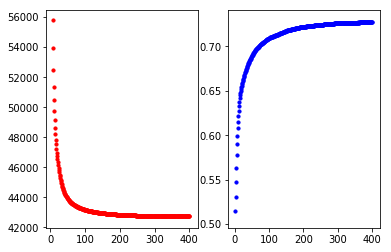

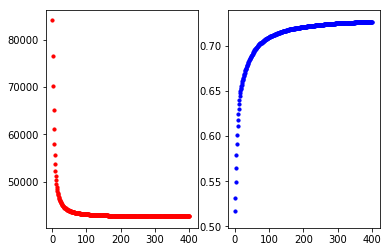

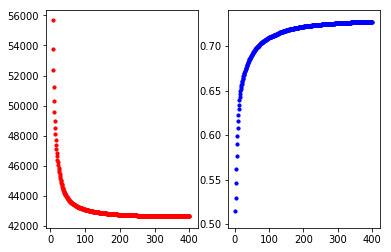

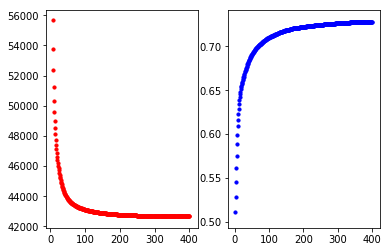

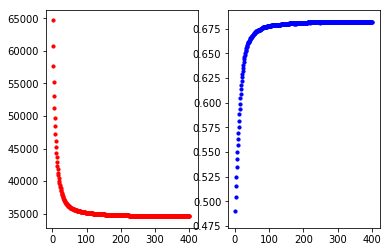

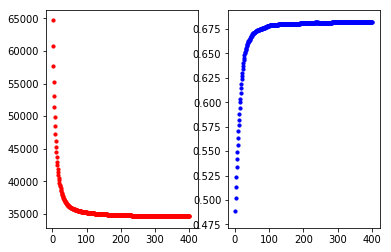

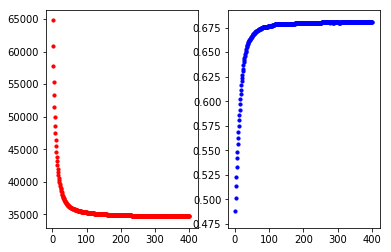

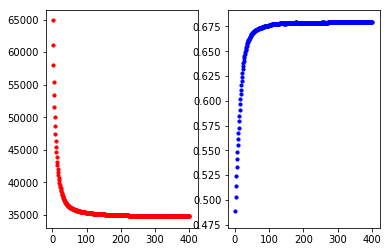

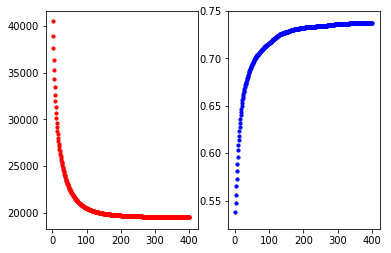

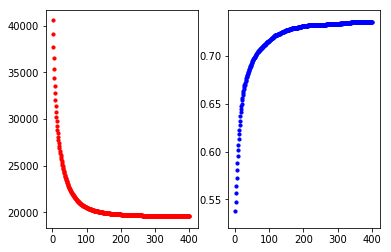

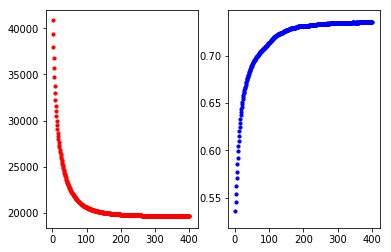

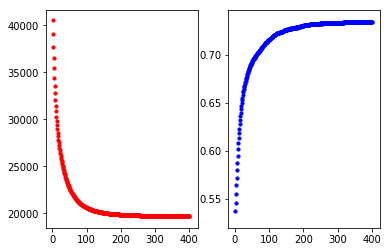

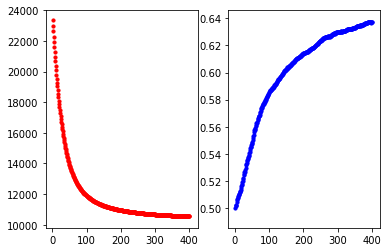

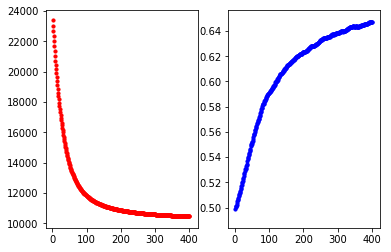

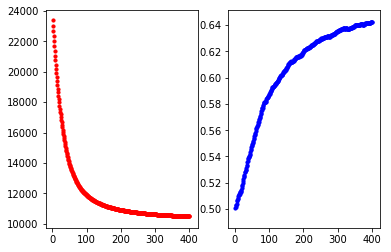

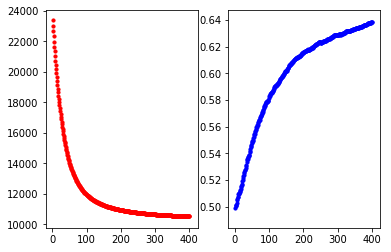

In [17]:
logistic_regression_cross_val_res = []
for i, tx in enumerate(preprocessed_data_train):
    logistic_regression_cross_val_res.append(cross_validate(logistic_regression, tx, all_ys_train[i], epochs=400, gamma=0.000005, model_name='logistic_regression'))
    
logistic_regression_cross_val_res

### Regularized Logistic Regression
The feature expansion for this model has to be 2. Otherwise very low performance is achieved

In [27]:
from MLscripts.implementations import *

logistic_regression_cross_val_res = []
for i, tx in enumerate(preprocessed_data_train_augmented):
    logistic_regression_cross_val_res.append(cross_validate(reg_logistic_regression, tx, all_ys_train[i], epochs=400, gamma=0.000005, lambda_=0.5, model_name='reg_logistic_regression'))
    
logistic_regression_cross_val_res

/home/marco/Documents/programming/ML_project1/MLscripts/implementations.py:138: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/marco/Documents/programming/ML_project1/MLscripts/implementations.py:89: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.squeeze( (np.matmul(y.T, np.log(p)) + np.matmul((1 - y).T, np.log(1 - p))   )   )


cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
cost function:  LIKELIHOOD
c

[{'test_score': [0.8324925934822643,
   0.8317319240932021,
   0.8368564336616222,
   0.8322523820962447],
  'train_score': [0.8368564336616222,
   0.8310913603971495,
   0.8349480876504658,
   0.8315317479381856]},
 {'test_score': [0.7448674301041989,
   0.7647787062828846,
   0.773290003095017,
   0.7670999690498298],
  'train_score': [0.7420647202448503,
   0.7710031294061006,
   0.7710719075621583,
   0.7648990680559854]},
 {'test_score': [0.7995077020803557,
   0.8066539622042243,
   0.8033190408130856,
   0.8083214228997936],
  'train_score': [0.8077920702980255,
   0.806045206712191,
   0.8019427240484887,
   0.8024456090201684]},
 {'test_score': [0.7875834686879625,
   0.7919148168200686,
   0.7911929254647175,
   0.7929976538530951],
  'train_score': [0.7946219094026349,
   0.7922757624977441,
   0.7936593875955003,
   0.7899897732057992]}]

# 3) Creating Baseline Prediction
### Ridge Regression
With not augmented data

In [6]:
computed_w = []
for i, tx in enumerate(preprocessed_data_train):
    _, wi = ridge_regression(all_ys_train[i], tx)
    computed_w.append(wi)

test_predictions = []

for i, w in enumerate(computed_w):
    train_prediction = predict_labels(w, preprocessed_data_train[i])
    test_prediction = predict_labels(w, preprocessed_data_test[i])
    test_predictions.append(test_prediction)
    
    train_y = all_ys_train[i]
    print('train loss for dataset ', i, ': ', calculate_loss_SUCCESS(train_y, preprocessed_data_train[i], w))

all_test_predictions = np.zeros(input_data_test.shape[0])
all_test_predictions, all_test_predictions.shape

for i, test_prediction in enumerate(test_predictions):
    all_test_predictions[input_data_test[:, 22] == i] = test_prediction

all_test_predictions

train loss for dataset  0 :  0.7190956131834696
train loss for dataset  1 :  0.6770607655008769
train loss for dataset  2 :  0.7341948033903015
train loss for dataset  3 :  0.6465890633459664


array([-1., -1.,  1., ...,  1.,  1., -1.])

### Ridge Regression
augmentation degree = 2

In [7]:
computed_w = []
for i, tx in enumerate(preprocessed_data_train_augmented):
    _, wi = ridge_regression(all_ys_train[i], tx, lamb=1)
    computed_w.append(wi)

test_predictions = []

for i, w in enumerate(computed_w):
    train_prediction = predict_labels(w, preprocessed_data_train_augmented[i])
    test_prediction = predict_labels(w, preprocessed_data_test_augmented[i])
    test_predictions.append(test_prediction)
    
    train_y = all_ys_train[i]
    print('train loss for dataset ', i, ': ', calculate_loss_SUCCESS(train_y, preprocessed_data_train_augmented[i], w))

all_test_predictions = np.zeros(input_data_test.shape[0])
all_test_predictions, all_test_predictions.shape

for i, test_prediction in enumerate(test_predictions):
    all_test_predictions[input_data_test[:, 22] == i] = test_prediction

all_test_predictions

train loss for dataset  0 :  0.8388998428632911
train loss for dataset  1 :  0.7855797998555659
train loss for dataset  2 :  0.8132952222156057
train loss for dataset  3 :  0.8064428803465078


array([-1., -1., -1., ...,  1., -1., -1.])

### Ridge Regression

Augmentation degree = 4

In [8]:
computed_w = []
for i, tx in enumerate(preprocessed_data_train_augmented):
    _, wi = ridge_regression(all_ys_train[i], tx, lamb=1)
    computed_w.append(wi)

test_predictions = []

for i, w in enumerate(computed_w):
    train_prediction = predict_labels(w, preprocessed_data_train_augmented[i])
    test_prediction = predict_labels(w, preprocessed_data_test_augmented[i])
    test_predictions.append(test_prediction)
    
    train_y = all_ys_train[i]
    print('train loss for dataset ', i, ': ', calculate_loss_SUCCESS(train_y, preprocessed_data_train_augmented[i], w))

all_test_predictions = np.zeros(input_data_test.shape[0])
all_test_predictions, all_test_predictions.shape

for i, test_prediction in enumerate(test_predictions):
    all_test_predictions[input_data_test[:, 22] == i] = test_prediction

all_test_predictions

train loss for dataset  0 :  0.8388998428632911
train loss for dataset  1 :  0.7855797998555659
train loss for dataset  2 :  0.8132952222156057
train loss for dataset  3 :  0.8064428803465078


array([-1., -1., -1., ...,  1., -1., -1.])

Score on the test set: 0.81329

In [13]:
create_csv_submission(ids_test, all_test_predictions, 'ridge_regression_submission.csv')

### Logistic Regression

Augmentation degree = 2

cost function:  LIKELIHOOD
Accuracy: 0.6869076096203697
cost function:  LIKELIHOOD
Accuracy: 0.6523375336542793
cost function:  LIKELIHOOD
Accuracy: 0.7084863831533434


/home/marco/Documents/programming/ML_project1/MLscripts/implementations.py:139: RuntimeWarning: overflow encountered in exp
  
/home/marco/Documents/programming/ML_project1/MLscripts/implementations.py:90: RuntimeWarning: divide by zero encountered in log
  return -log_likelihood + lambda_ * np.squeeze(np.matmul(w.T, w))


cost function:  LIKELIHOOD
Accuracy: 0.7096273758169608
cost function:  LIKELIHOOD
Accuracy: 0.749241840401149
cost function:  LIKELIHOOD
Accuracy: 0.746549498063315
cost function:  LIKELIHOOD
Accuracy: 0.7758750112597961
cost function:  LIKELIHOOD
Accuracy: 0.7690690901083943
cost function:  LIKELIHOOD
Accuracy: 0.793240118903446
cost function:  LIKELIHOOD
Accuracy: 0.7857135708066018
cost function:  LIKELIHOOD
Accuracy: 0.8032888613093391
cost function:  LIKELIHOOD
Accuracy: 0.7956221913064366
cost function:  LIKELIHOOD
Accuracy: 0.8101948695364968
cost function:  LIKELIHOOD
Accuracy: 0.8020277641548147
cost function:  LIKELIHOOD
Accuracy: 0.8150490927106583
cost function:  LIKELIHOOD
Accuracy: 0.8053306376547597
cost function:  LIKELIHOOD
Accuracy: 0.8178315134166725
cost function:  LIKELIHOOD
Accuracy: 0.8076826839350235
cost function:  LIKELIHOOD
Accuracy: 0.8196831243181568
cost function:  LIKELIHOOD
Accuracy: 0.8091939987789377
cost function:  LIKELIHOOD
Accuracy: 0.820683995075

cost function:  LIKELIHOOD
Accuracy: 0.8247375216438302
cost function:  LIKELIHOOD
Accuracy: 0.8128271596288771
cost function:  LIKELIHOOD
Accuracy: 0.8248175913044349
cost function:  LIKELIHOOD
Accuracy: 0.812877203166755
cost function:  LIKELIHOOD
Accuracy: 0.824837608719586
cost function:  LIKELIHOOD
Accuracy: 0.8129072292894819
cost function:  LIKELIHOOD
Accuracy: 0.8248075825968593
cost function:  LIKELIHOOD
Accuracy: 0.8129973076576622
cost function:  LIKELIHOOD
Accuracy: 0.8248676348423128
cost function:  LIKELIHOOD
Accuracy: 0.8129973076576622
cost function:  LIKELIHOOD
Accuracy: 0.8249677219180688
cost function:  LIKELIHOOD
Accuracy: 0.8131174121485693
cost function:  LIKELIHOOD
Accuracy: 0.8249376957953419
cost function:  LIKELIHOOD
Accuracy: 0.8131774643940228
cost function:  LIKELIHOOD
Accuracy: 0.8249677219180688
cost function:  LIKELIHOOD
Accuracy: 0.8132074905167496
cost function:  LIKELIHOOD
Accuracy: 0.8249477045029175
cost function:  LIKELIHOOD
Accuracy: 0.81320749051

cost function:  LIKELIHOOD
Accuracy: 0.8252779918529121
cost function:  LIKELIHOOD
Accuracy: 0.8148789446818733
cost function:  LIKELIHOOD
Accuracy: 0.8253480528059411
cost function:  LIKELIHOOD
Accuracy: 0.8148989620970244
cost function:  LIKELIHOOD
Accuracy: 0.8253380440983655
cost function:  LIKELIHOOD
Accuracy: 0.814959014342478
cost function:  LIKELIHOOD
Accuracy: 0.8253380440983655
cost function:  LIKELIHOOD
Accuracy: 0.8149289882197512
cost function:  LIKELIHOOD
Accuracy: 0.825378078928668
cost function:  LIKELIHOOD
Accuracy: 0.8149890404652047
cost function:  LIKELIHOOD
Accuracy: 0.8253980963438191
cost function:  LIKELIHOOD
Accuracy: 0.8150090578803559
cost function:  LIKELIHOOD
Accuracy: 0.825378078928668
cost function:  LIKELIHOOD
Accuracy: 0.8150490927106583
cost function:  LIKELIHOOD
Accuracy: 0.8253480528059411
cost function:  LIKELIHOOD
Accuracy: 0.8150591014182339
cost function:  LIKELIHOOD
Accuracy: 0.8253480528059411
cost function:  LIKELIHOOD
Accuracy: 0.815089127540

cost function:  LIKELIHOOD
Accuracy: 0.7394898380274425
cost function:  LIKELIHOOD
Accuracy: 0.7608325595790777
cost function:  LIKELIHOOD
Accuracy: 0.7478721757969669
cost function:  LIKELIHOOD
Accuracy: 0.6924842669968018
cost function:  LIKELIHOOD
Accuracy: 0.7186242649334571
cost function:  LIKELIHOOD
Accuracy: 0.7026978231713608
cost function:  LIKELIHOOD
Accuracy: 0.7424945837202105
cost function:  LIKELIHOOD
Accuracy: 0.7641210151655834
cost function:  LIKELIHOOD
Accuracy: 0.7510961518621686
cost function:  LIKELIHOOD
Accuracy: 0.6958372021046115
cost function:  LIKELIHOOD
Accuracy: 0.7211131744557928
cost function:  LIKELIHOOD
Accuracy: 0.7049675023212628
cost function:  LIKELIHOOD
Accuracy: 0.7445579284019396
cost function:  LIKELIHOOD
Accuracy: 0.7662875270813989
cost function:  LIKELIHOOD
Accuracy: 0.753004745692768
cost function:  LIKELIHOOD
Accuracy: 0.6979134426906015
cost function:  LIKELIHOOD
Accuracy: 0.723640771690911
cost function:  LIKELIHOOD
Accuracy: 0.70750799546

Accuracy: 0.7103966780150625
cost function:  LIKELIHOOD
Accuracy: 0.7353373568554628
cost function:  LIKELIHOOD
Accuracy: 0.7209842154131848
cost function:  LIKELIHOOD
Accuracy: 0.7548875477148458
cost function:  LIKELIHOOD
Accuracy: 0.7718972454348499
cost function:  LIKELIHOOD
Accuracy: 0.7605359537810791
cost function:  LIKELIHOOD
Accuracy: 0.7104869493448881
cost function:  LIKELIHOOD
Accuracy: 0.7354405240895492
cost function:  LIKELIHOOD
Accuracy: 0.7210229031259672
cost function:  LIKELIHOOD
Accuracy: 0.754939131331889
cost function:  LIKELIHOOD
Accuracy: 0.7718327659135459
cost function:  LIKELIHOOD
Accuracy: 0.7605101619725575
cost function:  LIKELIHOOD
Accuracy: 0.710564324770453
cost function:  LIKELIHOOD
Accuracy: 0.7354663158980708
cost function:  LIKELIHOOD
Accuracy: 0.7210486949344888
cost function:  LIKELIHOOD
Accuracy: 0.7550680903744971
cost function:  LIKELIHOOD
Accuracy: 0.7719617249561539
cost function:  LIKELIHOOD
Accuracy: 0.7605875373981223
cost function:  LIKEL

cost function:  LIKELIHOOD
Accuracy: 0.7609615186216857
cost function:  LIKELIHOOD
Accuracy: 0.7118152274837511
cost function:  LIKELIHOOD
Accuracy: 0.736124007015372
cost function:  LIKELIHOOD
Accuracy: 0.7223124935520479
cost function:  LIKELIHOOD
Accuracy: 0.7556097183534509
cost function:  LIKELIHOOD
Accuracy: 0.7720648921902403
cost function:  LIKELIHOOD
Accuracy: 0.7610646858557722
cost function:  LIKELIHOOD
Accuracy: 0.7118023315794904
cost function:  LIKELIHOOD
Accuracy: 0.7361497988238935
cost function:  LIKELIHOOD
Accuracy: 0.7223124935520479
cost function:  LIKELIHOOD
Accuracy: 0.7555968224491901
cost function:  LIKELIHOOD
Accuracy: 0.7720519962859795
cost function:  LIKELIHOOD
Accuracy: 0.7610517899515113
cost function:  LIKELIHOOD
Accuracy: 0.7120344578561849
cost function:  LIKELIHOOD
Accuracy: 0.7361755906324151
cost function:  LIKELIHOOD
Accuracy: 0.7223769730733519
cost function:  LIKELIHOOD
Accuracy: 0.7555581347364078
cost function:  LIKELIHOOD
Accuracy: 0.7720519962

cost function:  LIKELIHOOD
Accuracy: 0.764227158141289
cost function:  LIKELIHOOD
Accuracy: 0.7658945195418726
cost function:  LIKELIHOOD
Accuracy: 0.7652593342464122
cost function:  LIKELIHOOD
Accuracy: 0.7676214295639056
cost function:  LIKELIHOOD
Accuracy: 0.7660731654062208
cost function:  LIKELIHOOD
Accuracy: 0.7688521010738602
cost function:  LIKELIHOOD
Accuracy: 0.7669068461065126
cost function:  LIKELIHOOD
Accuracy: 0.7697056313146351
cost function:  LIKELIHOOD
Accuracy: 0.7681375176164672
cost function:  LIKELIHOOD
Accuracy: 0.7707576569602413
cost function:  LIKELIHOOD
Accuracy: 0.7691498441811072
cost function:  LIKELIHOOD
Accuracy: 0.7713332936342524
cost function:  LIKELIHOOD
Accuracy: 0.7701621707457472
cost function:  LIKELIHOOD
Accuracy: 0.7721272752535778
cost function:  LIKELIHOOD
Accuracy: 0.7706782587983089
cost function:  LIKELIHOOD
Accuracy: 0.7728815577919371
cost function:  LIKELIHOOD
Accuracy: 0.7715516385795669
cost function:  LIKELIHOOD
Accuracy: 0.7739137338

cost function:  LIKELIHOOD
Accuracy: 0.7907461442267611
cost function:  LIKELIHOOD
Accuracy: 0.7870342801564144
cost function:  LIKELIHOOD
Accuracy: 0.7908056928482106
cost function:  LIKELIHOOD
Accuracy: 0.7871335278588301
cost function:  LIKELIHOOD
Accuracy: 0.7908850910101431
cost function:  LIKELIHOOD
Accuracy: 0.7871732269397963
cost function:  LIKELIHOOD
Accuracy: 0.791004188253042
cost function:  LIKELIHOOD
Accuracy: 0.7873320232636615
cost function:  LIKELIHOOD
Accuracy: 0.7910835864149744
cost function:  LIKELIHOOD
Accuracy: 0.787550368208976
cost function:  LIKELIHOOD
Accuracy: 0.7911232854959408
cost function:  LIKELIHOOD
Accuracy: 0.7875106691280097
cost function:  LIKELIHOOD
Accuracy: 0.7912820818198059
cost function:  LIKELIHOOD
Accuracy: 0.7876496159113916
cost function:  LIKELIHOOD
Accuracy: 0.7913217809007721
cost function:  LIKELIHOOD
Accuracy: 0.7876694654518748
cost function:  LIKELIHOOD
Accuracy: 0.7914408781436709
cost function:  LIKELIHOOD
Accuracy: 0.78768931499

Accuracy: 0.7907858433077274
cost function:  LIKELIHOOD
Accuracy: 0.7932868854086028
cost function:  LIKELIHOOD
Accuracy: 0.7907858433077274
cost function:  LIKELIHOOD
Accuracy: 0.7932868854086028
cost function:  LIKELIHOOD
Accuracy: 0.7907858433077274
cost function:  LIKELIHOOD
Accuracy: 0.793326584489569
cost function:  LIKELIHOOD
Accuracy: 0.7907858433077274
cost function:  LIKELIHOOD
Accuracy: 0.793326584489569
cost function:  LIKELIHOOD
Accuracy: 0.7907858433077274
cost function:  LIKELIHOOD
Accuracy: 0.7933464340300522
cost function:  LIKELIHOOD
Accuracy: 0.7908056928482106
cost function:  LIKELIHOOD
Accuracy: 0.793326584489569
cost function:  LIKELIHOOD
Accuracy: 0.4961649521746977
cost function:  LIKELIHOOD
Accuracy: 0.5323046381519582
cost function:  LIKELIHOOD
Accuracy: 0.5670005414185165
cost function:  LIKELIHOOD
Accuracy: 0.5905973650965529
cost function:  LIKELIHOOD
Accuracy: 0.6072008662696264
cost function:  LIKELIHOOD
Accuracy: 0.6189767190037899
cost function:  LIKELI

cost function:  LIKELIHOOD
Accuracy: 0.7652499548817903
cost function:  LIKELIHOOD
Accuracy: 0.7656560187691752
cost function:  LIKELIHOOD
Accuracy: 0.7660620826565602
cost function:  LIKELIHOOD
Accuracy: 0.7661974372856885
cost function:  LIKELIHOOD
Accuracy: 0.7667388558022018
cost function:  LIKELIHOOD
Accuracy: 0.7673705107381339
cost function:  LIKELIHOOD
Accuracy: 0.7678216928352283
cost function:  LIKELIHOOD
Accuracy: 0.7678216928352283
cost function:  LIKELIHOOD
Accuracy: 0.7683631113517415
cost function:  LIKELIHOOD
Accuracy: 0.7684984659808699
cost function:  LIKELIHOOD
Accuracy: 0.7689045298682549
cost function:  LIKELIHOOD
Accuracy: 0.7691752391265114
cost function:  LIKELIHOOD
Accuracy: 0.769852012272153
cost function:  LIKELIHOOD
Accuracy: 0.7702129579498286
cost function:  LIKELIHOOD
Accuracy: 0.7704385489983757
cost function:  LIKELIHOOD
Accuracy: 0.770664140046923
cost function:  LIKELIHOOD
Accuracy: 0.7708897310954701
cost function:  LIKELIHOOD
Accuracy: 0.77134091319

Accuracy: 0.790516152319076
cost function:  LIKELIHOOD
Accuracy: 0.7905612705287854
cost function:  LIKELIHOOD
Accuracy: 0.790425915899657
cost function:  LIKELIHOOD
Accuracy: 0.7904710341093666
cost function:  LIKELIHOOD
Accuracy: 0.790831979787042
cost function:  LIKELIHOOD
Accuracy: 0.7910124526258798
cost function:  LIKELIHOOD
Accuracy: 0.7910124526258798
cost function:  LIKELIHOOD
Accuracy: 0.7910575708355893
cost function:  LIKELIHOOD
Accuracy: 0.7911929254647175
cost function:  LIKELIHOOD
Accuracy: 0.791238043674427
cost function:  LIKELIHOOD
Accuracy: 0.7912831618841364
cost function:  LIKELIHOOD
Accuracy: 0.7911929254647175
cost function:  LIKELIHOOD
Accuracy: 0.7911026890452987
cost function:  LIKELIHOOD
Accuracy: 0.7910575708355893
cost function:  LIKELIHOOD
Accuracy: 0.7911478072550081
cost function:  LIKELIHOOD
Accuracy: 0.7911478072550081
cost function:  LIKELIHOOD
Accuracy: 0.7911929254647175
cost function:  LIKELIHOOD
Accuracy: 0.7911478072550081
cost function:  LIKELIH

array([-1., -1.,  1., ...,  1.,  1., -1.])

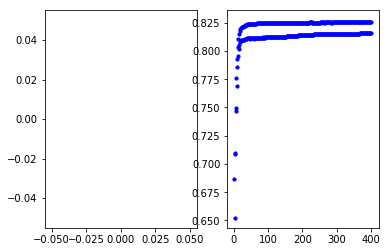

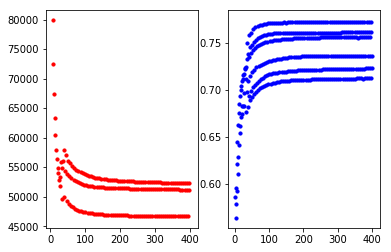

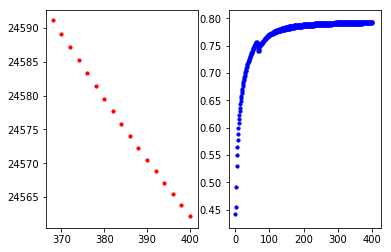

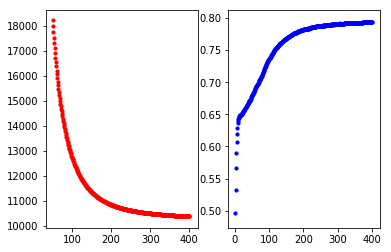

In [20]:
computed_w = []
for i, tx in enumerate(preprocessed_data_train_augmented):
#     _, wi = ridge_regression(all_ys_train[i], tx, lamb=1)
    initial_wi = np.random.uniform(low=-1, high=1, size=tx.shape[1])
    _, wi = logistic_regression(all_ys_train[i], tx, initial_wi, 400, 0.000005)
    computed_w.append(wi)

test_predictions = []

for i, w in enumerate(computed_w):
    train_prediction = predict_labels(w, preprocessed_data_train_augmented[i])
    test_prediction = predict_labels(w, preprocessed_data_test_augmented[i])
    test_predictions.append(test_prediction)
    
    train_y = all_ys_train[i]
    print('train loss for dataset ', i, ': ', calculate_loss_SUCCESS(train_y, preprocessed_data_train_augmented[i], w))

all_test_predictions = np.zeros(input_data_test.shape[0])
all_test_predictions, all_test_predictions.shape

for i, test_prediction in enumerate(test_predictions):
    all_test_predictions[input_data_test[:, 22] == i] = test_prediction

all_test_predictions

Score on the test set: 0.77789

Possible improvements: change the number of iterations, adapt different learning rates to the different parts of the dataset

In [21]:
create_csv_submission(ids_test, all_test_predictions, 'logistic_regression_submission.csv')

# Neural Network

In [3]:
from hotgrad.sequential import Sequential
from hotgrad.variable import Variable
from hotgrad.sequential import Sequential
from hotgrad.functions.layers import Linear
from hotgrad.functions.activations import ReLU, Tanh
from hotgrad.functions.losses import MSE
from hotgrad.optimizers import SGD
%reload_ext autoreload
%autoreload 2

The dataset has to be wrapped by the Variable class

In [4]:
yb_train, input_data_train, ids_train = load_csv_data('data/train.csv', sub_sample=False)
preprocessed_data_train, all_ys_train = clean_data(input_data_train, yb_train, feature_expansion=False)

yb_test, input_data_test, ids_test = load_csv_data('data/test.csv', sub_sample=False)
preprocessed_data_test, _ = clean_data(input_data_test, yb_test, feature_expansion=False)

X_train0_V = Variable(preprocessed_data_train[0])
X_train1_V = Variable(preprocessed_data_train[1])
X_train2_V = Variable(preprocessed_data_train[2])
X_train3_V = Variable(preprocessed_data_train[3])

X_test0_V = Variable(preprocessed_data_test[0])
X_test1_V = Variable(preprocessed_data_test[1])
X_test2_V = Variable(preprocessed_data_test[2])
X_test3_V = Variable(preprocessed_data_test[3])

y_train0_V = Variable(all_ys_train[0].reshape(-1,1))
y_train1_V = Variable(all_ys_train[1].reshape(-1,1))
y_train2_V = Variable(all_ys_train[2].reshape(-1,1))
y_train3_V = Variable(all_ys_train[3].reshape(-1,1))

As model, we choose a 4 layers model with ReLU as non linear function. The final Tanh set the prediction in the (-1, 1) range. As loss function we use the Mean Square Error and the Stocastic Gradient Descent to update the parameters.
We tested several learning rate and epochs. We found out best score with a learning rate of 0.001 and 100 epochs.

In [5]:
model0 = Sequential([Linear(100), ReLU(),  Linear(50), ReLU(), Linear(1), Tanh()], MSE(), SGD(lr=0.001))
model0.cross_validate(X_train0_V, y_train0_V, batch_size=20, epochs=100, verbose=True)

----------------- fold 1/4 -----------------
Epoch 0: Train loss: [2197.44530065]. Train accuracy 82.71%. Test accuracy 82.38%
Epoch 1: Train loss: [1858.89970163]. Train accuracy 83.23%. Test accuracy 82.95%
Epoch 2: Train loss: [1800.53176887]. Train accuracy 83.70%. Test accuracy 83.49%
Epoch 3: Train loss: [1762.41912185]. Train accuracy 84.01%. Test accuracy 83.97%
Epoch 4: Train loss: [1736.39306795]. Train accuracy 84.20%. Test accuracy 84.17%
Epoch 5: Train loss: [1718.64642878]. Train accuracy 84.33%. Test accuracy 84.32%
Epoch 6: Train loss: [1706.15564996]. Train accuracy 84.44%. Test accuracy 84.33%
Epoch 7: Train loss: [1696.93659055]. Train accuracy 84.47%. Test accuracy 84.41%
Epoch 8: Train loss: [1689.69291444]. Train accuracy 84.44%. Test accuracy 84.48%
Epoch 9: Train loss: [1683.65577874]. Train accuracy 84.48%. Test accuracy 84.53%
Epoch 10: Train loss: [1678.14883522]. Train accuracy 84.47%. Test accuracy 84.54%
Epoch 11: Train loss: [1672.53501776]. Train accurac

Epoch 99: Train loss: [1551.82949719]. Train accuracy 85.54%. Test accuracy 85.04%
----------------- fold 2/4 -----------------
Epoch 0: Train loss: [2163.91718722]. Train accuracy 82.82%. Test accuracy 82.76%
Epoch 1: Train loss: [1838.42115626]. Train accuracy 83.44%. Test accuracy 83.40%
Epoch 2: Train loss: [1780.46854882]. Train accuracy 83.80%. Test accuracy 83.77%
Epoch 3: Train loss: [1744.12828036]. Train accuracy 84.13%. Test accuracy 84.03%
Epoch 4: Train loss: [1719.81187174]. Train accuracy 84.31%. Test accuracy 84.26%
Epoch 5: Train loss: [1703.31093549]. Train accuracy 84.46%. Test accuracy 84.43%
Epoch 6: Train loss: [1691.85005048]. Train accuracy 84.52%. Test accuracy 84.46%
Epoch 7: Train loss: [1683.51467723]. Train accuracy 84.59%. Test accuracy 84.51%
Epoch 8: Train loss: [1677.09006854]. Train accuracy 84.60%. Test accuracy 84.57%
Epoch 9: Train loss: [1671.91106023]. Train accuracy 84.59%. Test accuracy 84.65%
Epoch 10: Train loss: [1667.4584161]. Train accuracy

Epoch 98: Train loss: [1546.08714436]. Train accuracy 85.50%. Test accuracy 85.15%
Epoch 99: Train loss: [1545.73066744]. Train accuracy 85.49%. Test accuracy 85.13%
----------------- fold 3/4 -----------------
Epoch 0: Train loss: [2265.10171281]. Train accuracy 82.46%. Test accuracy 82.79%
Epoch 1: Train loss: [1860.63380841]. Train accuracy 83.10%. Test accuracy 83.37%
Epoch 2: Train loss: [1798.28651613]. Train accuracy 83.63%. Test accuracy 83.76%
Epoch 3: Train loss: [1762.68037037]. Train accuracy 83.92%. Test accuracy 84.13%
Epoch 4: Train loss: [1738.2585442]. Train accuracy 84.06%. Test accuracy 84.28%
Epoch 5: Train loss: [1721.02814744]. Train accuracy 84.20%. Test accuracy 84.37%
Epoch 6: Train loss: [1708.54891345]. Train accuracy 84.31%. Test accuracy 84.47%
Epoch 7: Train loss: [1699.22375647]. Train accuracy 84.40%. Test accuracy 84.49%
Epoch 8: Train loss: [1692.00762165]. Train accuracy 84.46%. Test accuracy 84.56%
Epoch 9: Train loss: [1686.19132788]. Train accuracy

Epoch 97: Train loss: [1554.50551483]. Train accuracy 85.50%. Test accuracy 84.89%
Epoch 98: Train loss: [1554.13177192]. Train accuracy 85.50%. Test accuracy 84.88%
Epoch 99: Train loss: [1553.73918468]. Train accuracy 85.51%. Test accuracy 84.88%
----------------- fold 4/4 -----------------
Epoch 0: Train loss: [2211.91885928]. Train accuracy 82.27%. Test accuracy 81.91%
Epoch 1: Train loss: [1883.15652573]. Train accuracy 82.83%. Test accuracy 82.66%
Epoch 2: Train loss: [1822.43074235]. Train accuracy 83.40%. Test accuracy 83.27%
Epoch 3: Train loss: [1778.24187674]. Train accuracy 83.71%. Test accuracy 83.65%
Epoch 4: Train loss: [1744.36420172]. Train accuracy 83.96%. Test accuracy 83.93%
Epoch 5: Train loss: [1718.59449147]. Train accuracy 84.16%. Test accuracy 84.11%
Epoch 6: Train loss: [1698.76900796]. Train accuracy 84.32%. Test accuracy 84.15%
Epoch 7: Train loss: [1683.18443672]. Train accuracy 84.48%. Test accuracy 84.23%
Epoch 8: Train loss: [1670.58226704]. Train accura

Epoch 96: Train loss: [1550.42651306]. Train accuracy 85.54%. Test accuracy 84.84%
Epoch 97: Train loss: [1550.1042536]. Train accuracy 85.55%. Test accuracy 84.85%
Epoch 98: Train loss: [1549.79815024]. Train accuracy 85.56%. Test accuracy 84.85%
Epoch 99: Train loss: [1549.47573982]. Train accuracy 85.56%. Test accuracy 84.84%


{'train_score': [0.8554461259241466,
  0.854939012998105,
  0.8551258440761204,
  0.855646302079163],
 'test_score': [0.8504283769717351,
  0.8513491872848107,
  0.8488269677316038,
  0.8484266154215709]}

In [6]:
model1 = Sequential([Linear(100), ReLU(), Linear(50), ReLU(), Linear(1), Tanh()], MSE(), SGD(lr=0.001))
model1.cross_validate(X_train1_V, y_train1_V, batch_size=20, epochs=100, verbose=True)

----------------- fold 1/4 -----------------
Epoch 0: Train loss: [2385.85469282]. Train accuracy 71.73%. Test accuracy 71.24%
Epoch 1: Train loss: [2067.02208959]. Train accuracy 74.97%. Test accuracy 74.49%
Epoch 2: Train loss: [1914.04502795]. Train accuracy 77.23%. Test accuracy 76.64%
Epoch 3: Train loss: [1797.69976222]. Train accuracy 78.46%. Test accuracy 78.24%
Epoch 4: Train loss: [1719.75344348]. Train accuracy 79.38%. Test accuracy 79.15%
Epoch 5: Train loss: [1668.01604456]. Train accuracy 79.94%. Test accuracy 79.83%
Epoch 6: Train loss: [1632.20038014]. Train accuracy 80.34%. Test accuracy 80.21%
Epoch 7: Train loss: [1605.84693953]. Train accuracy 80.67%. Test accuracy 80.44%
Epoch 8: Train loss: [1585.48303316]. Train accuracy 80.93%. Test accuracy 80.74%
Epoch 9: Train loss: [1569.71983764]. Train accuracy 81.09%. Test accuracy 80.92%
Epoch 10: Train loss: [1557.31925989]. Train accuracy 81.25%. Test accuracy 80.96%
Epoch 11: Train loss: [1547.66115075]. Train accurac

Epoch 99: Train loss: [1407.46158186]. Train accuracy 83.21%. Test accuracy 82.02%
----------------- fold 2/4 -----------------
Epoch 0: Train loss: [2359.87754481]. Train accuracy 71.31%. Test accuracy 71.13%
Epoch 1: Train loss: [2055.04044634]. Train accuracy 74.91%. Test accuracy 74.55%
Epoch 2: Train loss: [1912.31752208]. Train accuracy 76.99%. Test accuracy 76.70%
Epoch 3: Train loss: [1803.51430635]. Train accuracy 78.35%. Test accuracy 78.17%
Epoch 4: Train loss: [1721.10307408]. Train accuracy 79.35%. Test accuracy 79.09%
Epoch 5: Train loss: [1662.34249522]. Train accuracy 80.04%. Test accuracy 79.86%
Epoch 6: Train loss: [1621.89770835]. Train accuracy 80.44%. Test accuracy 80.22%
Epoch 7: Train loss: [1594.23246748]. Train accuracy 80.80%. Test accuracy 80.46%
Epoch 8: Train loss: [1574.96560417]. Train accuracy 80.99%. Test accuracy 80.64%
Epoch 9: Train loss: [1561.27525081]. Train accuracy 81.15%. Test accuracy 80.70%
Epoch 10: Train loss: [1551.17856926]. Train accurac

Epoch 98: Train loss: [1403.03113441]. Train accuracy 83.25%. Test accuracy 81.86%
Epoch 99: Train loss: [1402.3528008]. Train accuracy 83.28%. Test accuracy 81.84%
----------------- fold 3/4 -----------------
Epoch 0: Train loss: [2345.81513346]. Train accuracy 71.29%. Test accuracy 71.53%
Epoch 1: Train loss: [2085.73183527]. Train accuracy 74.51%. Test accuracy 74.81%
Epoch 2: Train loss: [1928.70986183]. Train accuracy 77.18%. Test accuracy 77.14%
Epoch 3: Train loss: [1797.48652637]. Train accuracy 78.86%. Test accuracy 78.87%
Epoch 4: Train loss: [1707.64474527]. Train accuracy 79.73%. Test accuracy 79.62%
Epoch 5: Train loss: [1651.27612247]. Train accuracy 80.30%. Test accuracy 80.23%
Epoch 6: Train loss: [1613.78387495]. Train accuracy 80.68%. Test accuracy 80.65%
Epoch 7: Train loss: [1587.03473652]. Train accuracy 81.02%. Test accuracy 80.87%
Epoch 8: Train loss: [1567.12791795]. Train accuracy 81.21%. Test accuracy 80.93%
Epoch 9: Train loss: [1552.07728499]. Train accuracy

Epoch 97: Train loss: [1401.86089457]. Train accuracy 83.11%. Test accuracy 81.88%
Epoch 98: Train loss: [1401.14448058]. Train accuracy 83.11%. Test accuracy 81.89%
Epoch 99: Train loss: [1400.42035674]. Train accuracy 83.14%. Test accuracy 81.88%
----------------- fold 4/4 -----------------
Epoch 0: Train loss: [2427.80208917]. Train accuracy 70.31%. Test accuracy 70.70%
Epoch 1: Train loss: [2124.21235652]. Train accuracy 73.54%. Test accuracy 73.75%
Epoch 2: Train loss: [1970.15513515]. Train accuracy 76.07%. Test accuracy 76.10%
Epoch 3: Train loss: [1842.41047811]. Train accuracy 77.91%. Test accuracy 78.02%
Epoch 4: Train loss: [1745.30558265]. Train accuracy 79.16%. Test accuracy 79.17%
Epoch 5: Train loss: [1678.43223196]. Train accuracy 79.90%. Test accuracy 79.83%
Epoch 6: Train loss: [1634.11398815]. Train accuracy 80.40%. Test accuracy 80.22%
Epoch 7: Train loss: [1604.82906966]. Train accuracy 80.62%. Test accuracy 80.59%
Epoch 8: Train loss: [1584.97263904]. Train accura

Epoch 96: Train loss: [1412.88269282]. Train accuracy 83.03%. Test accuracy 82.13%
Epoch 97: Train loss: [1412.21350619]. Train accuracy 83.04%. Test accuracy 82.12%
Epoch 98: Train loss: [1411.54508889]. Train accuracy 83.06%. Test accuracy 82.12%
Epoch 99: Train loss: [1410.89857417]. Train accuracy 83.07%. Test accuracy 82.12%


{'train_score': [0.8320953265242959,
  0.8328346917019155,
  0.8313731558856907,
  0.8306509852470855],
 'test_score': [0.8201795109873105,
  0.8184256680078407,
  0.8188383369441865,
  0.8211595997111317]}

In [7]:
model2 = Sequential([Linear(100), ReLU(), Linear(50), ReLU(), Linear(1), Tanh()], MSE(), SGD(lr=0.001))
model2.cross_validate(X_train2_V, y_train2_V, batch_size=20, epochs=100, verbose=True)

----------------- fold 1/4 -----------------
Epoch 0: Train loss: [1612.71973446]. Train accuracy 70.81%. Test accuracy 70.37%
Epoch 1: Train loss: [1388.01582872]. Train accuracy 73.02%. Test accuracy 72.66%
Epoch 2: Train loss: [1291.90805983]. Train accuracy 75.73%. Test accuracy 75.42%
Epoch 3: Train loss: [1198.69321284]. Train accuracy 78.29%. Test accuracy 77.82%
Epoch 4: Train loss: [1109.43788774]. Train accuracy 80.22%. Test accuracy 79.57%
Epoch 5: Train loss: [1037.12421175]. Train accuracy 81.27%. Test accuracy 80.63%
Epoch 6: Train loss: [983.67009837]. Train accuracy 82.14%. Test accuracy 81.46%
Epoch 7: Train loss: [944.49008969]. Train accuracy 82.80%. Test accuracy 82.08%
Epoch 8: Train loss: [915.67502073]. Train accuracy 83.25%. Test accuracy 82.40%
Epoch 9: Train loss: [894.35426784]. Train accuracy 83.64%. Test accuracy 82.67%
Epoch 10: Train loss: [878.36911794]. Train accuracy 83.83%. Test accuracy 83.07%
Epoch 11: Train loss: [866.59248326]. Train accuracy 84.0

Epoch 0: Train loss: [1688.57720615]. Train accuracy 72.24%. Test accuracy 71.46%
Epoch 1: Train loss: [1363.39043084]. Train accuracy 74.34%. Test accuracy 73.81%
Epoch 2: Train loss: [1257.10843248]. Train accuracy 76.72%. Test accuracy 76.43%
Epoch 3: Train loss: [1159.07772974]. Train accuracy 79.32%. Test accuracy 79.26%
Epoch 4: Train loss: [1063.22883286]. Train accuracy 81.24%. Test accuracy 80.90%
Epoch 5: Train loss: [991.11630615]. Train accuracy 82.20%. Test accuracy 81.86%
Epoch 6: Train loss: [943.97844625]. Train accuracy 82.86%. Test accuracy 82.39%
Epoch 7: Train loss: [913.41097784]. Train accuracy 83.27%. Test accuracy 82.85%
Epoch 8: Train loss: [893.089642]. Train accuracy 83.53%. Test accuracy 83.17%
Epoch 9: Train loss: [879.04846831]. Train accuracy 83.67%. Test accuracy 83.29%
Epoch 10: Train loss: [868.86219502]. Train accuracy 83.88%. Test accuracy 83.46%
Epoch 11: Train loss: [861.02313049]. Train accuracy 84.06%. Test accuracy 83.61%
Epoch 12: Train loss: [

Epoch 0: Train loss: [1635.91114363]. Train accuracy 71.55%. Test accuracy 71.92%
Epoch 1: Train loss: [1385.21346676]. Train accuracy 73.49%. Test accuracy 73.74%
Epoch 2: Train loss: [1290.99659204]. Train accuracy 75.81%. Test accuracy 75.86%
Epoch 3: Train loss: [1204.70194485]. Train accuracy 78.17%. Test accuracy 78.05%
Epoch 4: Train loss: [1118.88791895]. Train accuracy 80.11%. Test accuracy 79.90%
Epoch 5: Train loss: [1045.78078217]. Train accuracy 81.37%. Test accuracy 81.12%
Epoch 6: Train loss: [991.72648505]. Train accuracy 82.16%. Test accuracy 81.94%
Epoch 7: Train loss: [953.00991097]. Train accuracy 82.78%. Test accuracy 82.47%
Epoch 8: Train loss: [924.7261375]. Train accuracy 83.19%. Test accuracy 82.87%
Epoch 9: Train loss: [903.86638022]. Train accuracy 83.59%. Test accuracy 83.32%
Epoch 10: Train loss: [888.34803302]. Train accuracy 83.85%. Test accuracy 83.57%
Epoch 11: Train loss: [876.73008893]. Train accuracy 84.01%. Test accuracy 83.89%
Epoch 12: Train loss:

Epoch 0: Train loss: [1671.76214723]. Train accuracy 72.22%. Test accuracy 72.45%
Epoch 1: Train loss: [1352.32369854]. Train accuracy 74.38%. Test accuracy 74.61%
Epoch 2: Train loss: [1243.84523886]. Train accuracy 77.00%. Test accuracy 77.34%
Epoch 3: Train loss: [1151.70834757]. Train accuracy 79.26%. Test accuracy 79.58%
Epoch 4: Train loss: [1068.81823266]. Train accuracy 80.86%. Test accuracy 81.48%
Epoch 5: Train loss: [1003.33029726]. Train accuracy 81.89%. Test accuracy 82.46%
Epoch 6: Train loss: [955.92076298]. Train accuracy 82.63%. Test accuracy 83.13%
Epoch 7: Train loss: [923.08354645]. Train accuracy 83.06%. Test accuracy 83.68%
Epoch 8: Train loss: [900.37268764]. Train accuracy 83.42%. Test accuracy 83.94%
Epoch 9: Train loss: [884.44009583]. Train accuracy 83.72%. Test accuracy 84.12%
Epoch 10: Train loss: [872.87955578]. Train accuracy 83.89%. Test accuracy 84.34%
Epoch 11: Train loss: [864.26788902]. Train accuracy 84.02%. Test accuracy 84.37%
Epoch 12: Train loss

{'train_score': [0.8681382668995818,
  0.8660473241225981,
  0.8650150865491504,
  0.8634534963739346],
 'test_score': [0.8442909321899317,
  0.8465936160076227,
  0.848261076703192,
  0.853660473241226]}

In [8]:
model3 = Sequential([Linear(100), ReLU(), Linear(50), ReLU(), Linear(1), Tanh()], MSE(), SGD(lr=0.001))
model3.cross_validate(X_train3_V, y_train3_V, batch_size=20, epochs=100, verbose=True)

----------------- fold 1/4 -----------------
Epoch 0: Train loss: [693.16415716]. Train accuracy 69.90%. Test accuracy 68.83%
Epoch 1: Train loss: [655.81641887]. Train accuracy 70.59%. Test accuracy 69.48%
Epoch 2: Train loss: [633.38600218]. Train accuracy 71.79%. Test accuracy 71.02%
Epoch 3: Train loss: [616.07900956]. Train accuracy 72.76%. Test accuracy 72.13%
Epoch 4: Train loss: [602.48786055]. Train accuracy 73.39%. Test accuracy 72.87%
Epoch 5: Train loss: [590.96807688]. Train accuracy 73.84%. Test accuracy 73.42%
Epoch 6: Train loss: [580.33955691]. Train accuracy 74.38%. Test accuracy 73.96%
Epoch 7: Train loss: [569.93738686]. Train accuracy 74.93%. Test accuracy 74.84%
Epoch 8: Train loss: [559.38273677]. Train accuracy 75.48%. Test accuracy 75.51%
Epoch 9: Train loss: [548.43363205]. Train accuracy 76.13%. Test accuracy 76.20%
Epoch 10: Train loss: [536.94929002]. Train accuracy 77.09%. Test accuracy 76.99%
Epoch 11: Train loss: [525.03402768]. Train accuracy 77.85%. Te

Epoch 0: Train loss: [691.76532832]. Train accuracy 69.66%. Test accuracy 70.01%
Epoch 1: Train loss: [653.02652595]. Train accuracy 70.94%. Test accuracy 71.47%
Epoch 2: Train loss: [631.80956284]. Train accuracy 71.95%. Test accuracy 72.53%
Epoch 3: Train loss: [616.4303095]. Train accuracy 72.49%. Test accuracy 72.82%
Epoch 4: Train loss: [603.75112259]. Train accuracy 73.01%. Test accuracy 72.84%
Epoch 5: Train loss: [592.05908953]. Train accuracy 73.57%. Test accuracy 72.95%
Epoch 6: Train loss: [580.54186243]. Train accuracy 74.21%. Test accuracy 73.49%
Epoch 7: Train loss: [568.82443088]. Train accuracy 74.90%. Test accuracy 74.12%
Epoch 8: Train loss: [556.69510615]. Train accuracy 75.52%. Test accuracy 74.73%
Epoch 9: Train loss: [544.02700231]. Train accuracy 76.27%. Test accuracy 75.58%
Epoch 10: Train loss: [530.90688151]. Train accuracy 76.92%. Test accuracy 76.47%
Epoch 11: Train loss: [517.50871064]. Train accuracy 77.76%. Test accuracy 77.35%
Epoch 12: Train loss: [504.

Epoch 0: Train loss: [692.3381416]. Train accuracy 69.46%. Test accuracy 70.13%
Epoch 1: Train loss: [657.83550426]. Train accuracy 69.67%. Test accuracy 70.26%
Epoch 2: Train loss: [638.70696357]. Train accuracy 70.85%. Test accuracy 71.29%
Epoch 3: Train loss: [623.5933626]. Train accuracy 72.16%. Test accuracy 72.30%
Epoch 4: Train loss: [610.56285337]. Train accuracy 73.09%. Test accuracy 73.16%
Epoch 5: Train loss: [598.40488639]. Train accuracy 73.65%. Test accuracy 73.61%
Epoch 6: Train loss: [586.28183612]. Train accuracy 74.33%. Test accuracy 74.30%
Epoch 7: Train loss: [573.62818915]. Train accuracy 74.91%. Test accuracy 74.86%
Epoch 8: Train loss: [560.11311941]. Train accuracy 75.65%. Test accuracy 75.67%
Epoch 9: Train loss: [545.66588936]. Train accuracy 76.56%. Test accuracy 76.41%
Epoch 10: Train loss: [530.47921427]. Train accuracy 77.45%. Test accuracy 77.31%
Epoch 11: Train loss: [515.04862806]. Train accuracy 78.72%. Test accuracy 78.13%
Epoch 12: Train loss: [499.8

Epoch 0: Train loss: [703.34729924]. Train accuracy 69.61%. Test accuracy 69.64%
Epoch 1: Train loss: [654.5817005]. Train accuracy 70.28%. Test accuracy 70.47%
Epoch 2: Train loss: [634.89963488]. Train accuracy 71.69%. Test accuracy 71.74%
Epoch 3: Train loss: [619.17255411]. Train accuracy 72.66%. Test accuracy 72.69%
Epoch 4: Train loss: [605.55753686]. Train accuracy 73.32%. Test accuracy 73.40%
Epoch 5: Train loss: [592.83913998]. Train accuracy 73.84%. Test accuracy 74.23%
Epoch 6: Train loss: [580.21630707]. Train accuracy 74.61%. Test accuracy 74.72%
Epoch 7: Train loss: [567.18851064]. Train accuracy 75.33%. Test accuracy 75.53%
Epoch 8: Train loss: [553.47127666]. Train accuracy 75.93%. Test accuracy 76.32%
Epoch 9: Train loss: [539.02006454]. Train accuracy 76.83%. Test accuracy 76.94%
Epoch 10: Train loss: [524.19508488]. Train accuracy 77.68%. Test accuracy 77.84%
Epoch 11: Train loss: [509.47046018]. Train accuracy 78.56%. Test accuracy 78.78%
Epoch 12: Train loss: [495.

{'train_score': [0.862299223966793,
  0.864525055645792,
  0.8683751428743307,
  0.8627203272574144],
 'test_score': [0.8478613968597726,
  0.8442519400830175,
  0.8352282981411298,
  0.8428081573723155]}

After setting the hyperparameters, we fit the models and make our prediction

In [9]:
model0 = Sequential([Linear(100), ReLU(), Linear(50), ReLU(), Linear(1), Tanh()], MSE(), SGD(lr=0.001))
model0.fit(X_train0_V, y_train0_V, batch_size=20, epochs=100, verbose=True)

Epoch 0: Train loss: [2805.95976795]. Train accuracy 83.16%. 
Epoch 1: Train loss: [2387.80141451]. Train accuracy 83.82%. 
Epoch 2: Train loss: [2318.29053048]. Train accuracy 84.17%. 
Epoch 3: Train loss: [2278.88077913]. Train accuracy 84.37%. 
Epoch 4: Train loss: [2253.39628002]. Train accuracy 84.51%. 
Epoch 5: Train loss: [2234.23785268]. Train accuracy 84.60%. 
Epoch 6: Train loss: [2218.78180946]. Train accuracy 84.70%. 
Epoch 7: Train loss: [2205.87386056]. Train accuracy 84.73%. 
Epoch 8: Train loss: [2194.08082787]. Train accuracy 84.80%. 
Epoch 9: Train loss: [2182.58970206]. Train accuracy 84.85%. 
Epoch 10: Train loss: [2171.83214971]. Train accuracy 84.89%. 
Epoch 11: Train loss: [2162.54928913]. Train accuracy 84.96%. 
Epoch 12: Train loss: [2155.58236491]. Train accuracy 85.00%. 
Epoch 13: Train loss: [2150.04869189]. Train accuracy 85.02%. 
Epoch 14: Train loss: [2145.40798015]. Train accuracy 85.04%. 
Epoch 15: Train loss: [2141.38340899]. Train accuracy 85.07%. 
Ep

In [10]:
pred0 = model0.predict(X_test0_V)

In [11]:
model1 = Sequential([Linear(100), ReLU(),  Linear(50), ReLU(), Linear(1), Tanh()], MSE(), SGD(lr=0.001))
model1.fit(X_train1_V, y_train1_V, batch_size=20, epochs=100, verbose=True)

Epoch 0: Train loss: [3031.24188636]. Train accuracy 73.96%. 
Epoch 1: Train loss: [2598.78928682]. Train accuracy 77.31%. 
Epoch 2: Train loss: [2392.24324494]. Train accuracy 78.85%. 
Epoch 3: Train loss: [2272.18608147]. Train accuracy 79.68%. 
Epoch 4: Train loss: [2199.58830889]. Train accuracy 80.18%. 
Epoch 5: Train loss: [2151.82891026]. Train accuracy 80.55%. 
Epoch 6: Train loss: [2117.9499976]. Train accuracy 80.85%. 
Epoch 7: Train loss: [2093.11056104]. Train accuracy 81.02%. 
Epoch 8: Train loss: [2074.82049675]. Train accuracy 81.18%. 
Epoch 9: Train loss: [2061.16159927]. Train accuracy 81.30%. 
Epoch 10: Train loss: [2050.67942022]. Train accuracy 81.38%. 
Epoch 11: Train loss: [2042.1903565]. Train accuracy 81.45%. 
Epoch 12: Train loss: [2034.88986612]. Train accuracy 81.53%. 
Epoch 13: Train loss: [2028.6432061]. Train accuracy 81.60%. 
Epoch 14: Train loss: [2023.07607983]. Train accuracy 81.63%. 
Epoch 15: Train loss: [2018.02225348]. Train accuracy 81.68%. 
Epoch

In [12]:
pred1 = model1.predict(X_test1_V)

In [13]:
model2 = Sequential([Linear(100), ReLU(), Linear(50), ReLU(), Linear(1), Tanh()], MSE(), SGD(lr=0.001))
model2.fit(X_train2_V, y_train2_V, batch_size=20, epochs=100, verbose=True)

Epoch 0: Train loss: [2096.00228685]. Train accuracy 72.66%. 
Epoch 1: Train loss: [1743.96688676]. Train accuracy 75.81%. 
Epoch 2: Train loss: [1577.28982734]. Train accuracy 79.09%. 
Epoch 3: Train loss: [1425.80916027]. Train accuracy 81.22%. 
Epoch 4: Train loss: [1317.86018268]. Train accuracy 82.36%. 
Epoch 5: Train loss: [1251.72956641]. Train accuracy 82.98%. 
Epoch 6: Train loss: [1211.55789146]. Train accuracy 83.43%. 
Epoch 7: Train loss: [1186.22999185]. Train accuracy 83.71%. 
Epoch 8: Train loss: [1168.97551931]. Train accuracy 83.92%. 
Epoch 9: Train loss: [1156.24821903]. Train accuracy 84.07%. 
Epoch 10: Train loss: [1146.16684097]. Train accuracy 84.16%. 
Epoch 11: Train loss: [1137.7529447]. Train accuracy 84.27%. 
Epoch 12: Train loss: [1130.40282375]. Train accuracy 84.34%. 
Epoch 13: Train loss: [1123.98604913]. Train accuracy 84.45%. 
Epoch 14: Train loss: [1118.24997355]. Train accuracy 84.54%. 
Epoch 15: Train loss: [1112.92353583]. Train accuracy 84.62%. 
Epo

In [14]:
pred2 = model2.predict(X_test2_V)

In [15]:
model3 = Sequential([Linear(100), ReLU(), Linear(50), ReLU(), Linear(1), Tanh()], MSE(), SGD(lr=0.001))
model3.fit(X_train3_V, y_train3_V, batch_size=20, epochs=100, verbose=True)

Epoch 0: Train loss: [951.55737593]. Train accuracy 69.63%. 
Epoch 1: Train loss: [878.4888862]. Train accuracy 70.08%. 
Epoch 2: Train loss: [840.59536281]. Train accuracy 72.11%. 
Epoch 3: Train loss: [811.11350219]. Train accuracy 73.53%. 
Epoch 4: Train loss: [786.06418482]. Train accuracy 74.50%. 
Epoch 5: Train loss: [761.63547755]. Train accuracy 75.56%. 
Epoch 6: Train loss: [735.92841095]. Train accuracy 76.50%. 
Epoch 7: Train loss: [708.42340631]. Train accuracy 77.87%. 
Epoch 8: Train loss: [680.14841025]. Train accuracy 79.08%. 
Epoch 9: Train loss: [653.16273713]. Train accuracy 80.02%. 
Epoch 10: Train loss: [628.92131224]. Train accuracy 80.79%. 
Epoch 11: Train loss: [608.01379517]. Train accuracy 81.40%. 
Epoch 12: Train loss: [590.4320772]. Train accuracy 81.90%. 
Epoch 13: Train loss: [575.71758566]. Train accuracy 82.42%. 
Epoch 14: Train loss: [563.53358968]. Train accuracy 82.86%. 
Epoch 15: Train loss: [553.50595531]. Train accuracy 83.08%. 
Epoch 16: Train loss

In [16]:
pred3 = model3.predict(X_test3_V)

In [17]:
test_predictions = [pred0, pred1, pred2, pred3]

In [18]:
all_test_predictions = np.zeros(input_data_test.shape[0])
all_test_predictions, all_test_predictions.shape

for i, test_prediction in enumerate(test_predictions):
    all_test_predictions[input_data_test[:, 22] == i] = test_prediction

all_test_predictions

array([-1., -1.,  1., ...,  1., -1., -1.])

In [19]:
create_csv_submission(ids_test, all_test_predictions, 'submissionNN.csv')